<a href="https://colab.research.google.com/github/Danzai-kun/MachineLearning-KidneyStoneprediction/blob/Main/ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
!nvidia-smi

Sun Jun 15 19:20:51 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [24]:
pip install --upgrade tensorflow

In [25]:
!pip install split-folders

In [26]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os, shutil, sys, json, re, random
import tensorflow as tf
import cv2
from PIL import Image, ImageOps
import scipy.ndimage as ndi
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img , img_to_array
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, MaxPool2D
import matplotlib.pyplot as plt
from skimage import transform
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns
import splitfolders
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tqdm import tqdm

In [27]:
Kidneystone = os.listdir('/content/drive/MyDrive/KidneystoneDataset')

In [28]:
normal_dir = '/content/drive/MyDrive/KidneystoneDataset/Normal'
stone_dir = '/content/drive/MyDrive/KidneystoneDataset/STONE'

In [29]:
len(os.listdir(normal_dir)), len(os.listdir(stone_dir))

(5905, 3389)

In [30]:
path_main = '/content/drive/MyDrive/KidneystoneDataset'
for folder in os.listdir(path_main):
    list_of_elements = os.listdir(os.path.join(path_main, folder))
    print(f'Folder: {folder}')
    print(f'Number of elements: {len(list_of_elements)}')
    print(f'First item\'s name: {list_of_elements[0]}\n')
    print('-------------------------------------')


Folder: STONE
Number of elements: 3389
First item's name: STONE- (3160).jpg

-------------------------------------
Folder: Normal
Number of elements: 5905
First item's name: Normal- (541).jpg

-------------------------------------


In [31]:
def plot_imgs(item_dir, num_imgs=25):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:num_imgs]

    plt.figure(figsize=(10, 10))
    for idx, img_path in enumerate(item_files):
        plt.subplot(5, 5, idx+1)
        img = Image.open(img_path).convert("RGB")
        plt.title(f'{img_path}'[-10:-4])
        plt.imshow(img)

    plt.tight_layout()

In [32]:
path_normal = normal_dir
path_stone = stone_dir

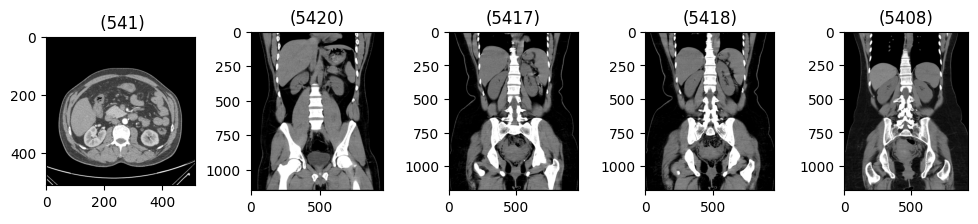

In [33]:
plot_imgs(path_normal, 5)

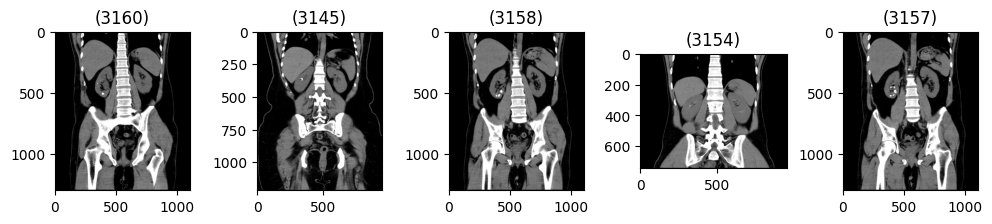

In [34]:
plot_imgs(path_stone, 5)

In [35]:
def preprocess_and_save(folder, label_name, output_dir, IMG_SIZE):
    os.makedirs(os.path.join(output_dir, label_name), exist_ok=True)

    for idx, filename in enumerate(os.listdir(folder)):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = cv2.GaussianBlur(img, (3, 3), 0)
            img = cv2.equalizeHist(img)
            img = img / 255.0
            img = (img * 255).astype(np.uint8)
            save_path = os.path.join(output_dir, label_name, f"{label_name}_{idx}.jpg")
            cv2.imwrite(save_path, img)


In [36]:
normal_dir = '/content/drive/MyDrive/KidneystoneDataset/Normal'
stone_dir = '/content/drive/MyDrive/KidneystoneDataset/STONE'
output_dir = '/content/preprocessed_dataset'

IMG_SIZE = 224

preprocess_and_save(normal_dir, 'normal', output_dir, IMG_SIZE)
preprocess_and_save(stone_dir, 'stone', output_dir, IMG_SIZE)

In [37]:
processed_normal_dir = '/content/preprocessed_dataset/normal'
processed_stone_dir = '/content/preprocessed_dataset/stone'

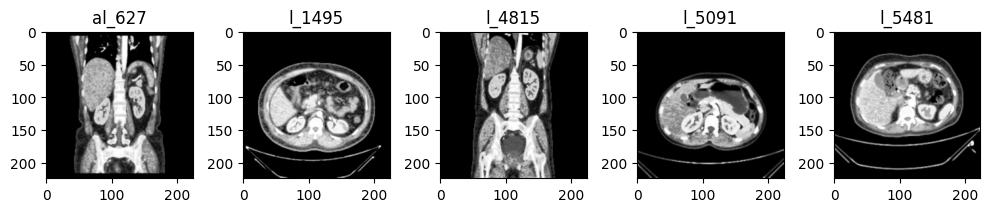

In [38]:
plot_imgs(processed_normal_dir, 5)

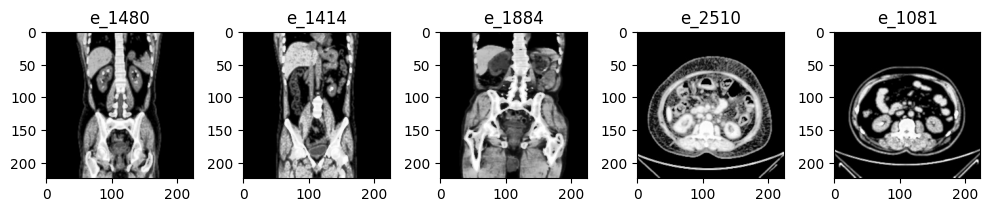

In [39]:
plot_imgs(processed_stone_dir, 5)

In [44]:
IMG_SIZE = 224
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
model = Model(inputs=base_model.input, outputs=base_model.output)

def extract_resnet50_features(folder_path, IMG_SIZE):
    features = []
    for fname in tqdm(os.listdir(folder_path), desc=f"Extracting from {folder_path}"):
        img_path = os.path.join(folder_path, fname)
        img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
        img = img.convert('RGB')
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        feature = model.predict(img_array)
        features.append(feature.squeeze())
    return np.array(features)

In [46]:
normal_dir = '/content/preprocessed_dataset/normal'
stone_dir = '/content/preprocessed_dataset/stone'

normal_features = extract_resnet50_features(normal_dir, IMG_SIZE)
stone_features = extract_resnet50_features(stone_dir, IMG_SIZE)

normal_labels = np.zeros(len(normal_features))
stone_labels = np.ones(len(stone_features))

X = np.concatenate([normal_features, stone_features], axis=0)
y = np.concatenate([normal_labels, stone_labels], axis=0)

print("Feature shape:", X.shape)
print("Label shape:", y.shape)

Extracting from /content/preprocessed_dataset/normal:   0%|          | 0/5905 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


Extracting from /content/preprocessed_dataset/normal:   0%|          | 1/5905 [00:06<10:23:13,  6.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting from /content/preprocessed_dataset/normal:   0%|          | 3/5905 [00:06<2:47:03,  1.70s/it] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting from /content/preprocessed_dataset/normal:   0%|          | 4/5905 [00:06<1:53:05,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Extracting from /content/preprocessed_dataset/normal:   0%|          | 6/5905 [00:06<1:00:30,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting from /content/preprocessed_dataset/normal:   0%|          | 8/5905 [00:06<39:20,  2.50it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting from /content/preprocessed_dataset/normal:   0%|          | 10/5905 [00:07<27:41,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting from /content/preprocessed_dataset/normal:   0%|          | 12/5905 [00:07<20:37,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting from /content/preprocessed_dataset/normal:   0%|          | 14/5905 [00:07<17:09,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting from /content/preprocessed_dataset/normal:   0%|          | 16/5905 [00:07<14:57,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting from /content/preprocessed_dataset/normal:   0%|          | 18/5905 [00:07<13:10,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:   0%|          | 20/5905 [00:08<11:46,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting from /content/preprocessed_dataset/normal:   0%|          | 22/5905 [00:08<11:20,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting from /content/preprocessed_dataset/normal:   0%|          | 24/5905 [00:08<10:36,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting from /content/preprocessed_dataset/normal:   0%|          | 26/5905 [00:08<10:32,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   0%|          | 28/5905 [00:08<10:33,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:   1%|          | 30/5905 [00:09<10:05,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   1%|          | 32/5905 [00:09<09:54,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting from /content/preprocessed_dataset/normal:   1%|          | 34/5905 [00:09<09:19, 10.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting from /content/preprocessed_dataset/normal:   1%|          | 36/5905 [00:09<09:14, 10.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting from /content/preprocessed_dataset/normal:   1%|          | 38/5905 [00:09<08:47, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting from /content/preprocessed_dataset/normal:   1%|          | 40/5905 [00:09<08:21, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:   1%|          | 42/5905 [00:10<08:14, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting from /content/preprocessed_dataset/normal:   1%|          | 44/5905 [00:10<08:09, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting from /content/preprocessed_dataset/normal:   1%|          | 46/5905 [00:10<08:49, 11.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting from /content/preprocessed_dataset/normal:   1%|          | 48/5905 [00:10<08:49, 11.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting from /content/preprocessed_dataset/normal:   1%|          | 50/5905 [00:10<09:14, 10.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting from /content/preprocessed_dataset/normal:   1%|          | 52/5905 [00:11<09:04, 10.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting from /content/preprocessed_dataset/normal:   1%|          | 54/5905 [00:11<09:01, 10.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:   1%|          | 56/5905 [00:11<09:52,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:   1%|          | 58/5905 [00:11<10:21,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:   1%|          | 59/5905 [00:11<10:47,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:   1%|          | 60/5905 [00:11<11:05,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:   1%|          | 61/5905 [00:12<10:55,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:   1%|          | 62/5905 [00:12<11:01,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:   1%|          | 63/5905 [00:12<10:57,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:   1%|          | 65/5905 [00:12<10:29,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:   1%|          | 66/5905 [00:12<10:27,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:   1%|          | 67/5905 [00:12<10:39,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:   1%|          | 68/5905 [00:12<11:11,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:   1%|          | 69/5905 [00:12<11:25,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:   1%|          | 70/5905 [00:13<11:35,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:   1%|          | 71/5905 [00:13<11:08,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:   1%|          | 72/5905 [00:13<11:58,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:   1%|▏         | 74/5905 [00:13<11:39,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:   1%|▏         | 75/5905 [00:13<11:54,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:   1%|▏         | 76/5905 [00:13<11:47,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:   1%|▏         | 77/5905 [00:13<11:56,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:   1%|▏         | 78/5905 [00:14<12:19,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:   1%|▏         | 79/5905 [00:14<12:37,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/normal:   1%|▏         | 80/5905 [00:14<13:12,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:   1%|▏         | 81/5905 [00:14<13:16,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting from /content/preprocessed_dataset/normal:   1%|▏         | 83/5905 [00:14<11:07,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting from /content/preprocessed_dataset/normal:   1%|▏         | 85/5905 [00:14<09:42,  9.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting from /content/preprocessed_dataset/normal:   1%|▏         | 87/5905 [00:14<09:18, 10.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting from /content/preprocessed_dataset/normal:   2%|▏         | 89/5905 [00:15<09:10, 10.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:   2%|▏         | 91/5905 [00:15<09:24, 10.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:   2%|▏         | 93/5905 [00:15<09:20, 10.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting from /content/preprocessed_dataset/normal:   2%|▏         | 95/5905 [00:15<08:51, 10.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting from /content/preprocessed_dataset/normal:   2%|▏         | 97/5905 [00:15<08:55, 10.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting from /content/preprocessed_dataset/normal:   2%|▏         | 99/5905 [00:16<08:52, 10.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting from /content/preprocessed_dataset/normal:   2%|▏         | 101/5905 [00:16<08:24, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting from /content/preprocessed_dataset/normal:   2%|▏         | 103/5905 [00:16<08:36, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:   2%|▏         | 105/5905 [00:16<08:48, 10.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:   2%|▏         | 107/5905 [00:16<08:51, 10.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:   2%|▏         | 109/5905 [00:17<09:20, 10.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   2%|▏         | 111/5905 [00:17<09:16, 10.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:   2%|▏         | 113/5905 [00:17<09:23, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:   2%|▏         | 115/5905 [00:17<08:59, 10.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   2%|▏         | 117/5905 [00:17<09:05, 10.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting from /content/preprocessed_dataset/normal:   2%|▏         | 119/5905 [00:17<08:36, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting from /content/preprocessed_dataset/normal:   2%|▏         | 121/5905 [00:18<08:21, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting from /content/preprocessed_dataset/normal:   2%|▏         | 123/5905 [00:18<08:04, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:   2%|▏         | 125/5905 [00:18<08:53, 10.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:   2%|▏         | 127/5905 [00:18<08:46, 10.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:   2%|▏         | 129/5905 [00:18<08:59, 10.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:   2%|▏         | 131/5905 [00:19<08:46, 10.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   2%|▏         | 133/5905 [00:19<08:53, 10.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   2%|▏         | 135/5905 [00:19<09:19, 10.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting from /content/preprocessed_dataset/normal:   2%|▏         | 137/5905 [00:19<09:23, 10.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   2%|▏         | 139/5905 [00:19<09:24, 10.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:   2%|▏         | 141/5905 [00:19<08:54, 10.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting from /content/preprocessed_dataset/normal:   2%|▏         | 143/5905 [00:20<08:35, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   2%|▏         | 145/5905 [00:20<09:09, 10.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting from /content/preprocessed_dataset/normal:   2%|▏         | 147/5905 [00:20<09:05, 10.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting from /content/preprocessed_dataset/normal:   3%|▎         | 149/5905 [00:20<08:39, 11.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   3%|▎         | 151/5905 [00:20<08:22, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:   3%|▎         | 153/5905 [00:21<08:58, 10.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting from /content/preprocessed_dataset/normal:   3%|▎         | 155/5905 [00:21<08:58, 10.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   3%|▎         | 157/5905 [00:21<09:19, 10.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting from /content/preprocessed_dataset/normal:   3%|▎         | 159/5905 [00:21<09:38,  9.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting from /content/preprocessed_dataset/normal:   3%|▎         | 161/5905 [00:21<08:58, 10.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   3%|▎         | 163/5905 [00:22<09:00, 10.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:   3%|▎         | 165/5905 [00:22<09:04, 10.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting from /content/preprocessed_dataset/normal:   3%|▎         | 167/5905 [00:22<09:01, 10.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:   3%|▎         | 169/5905 [00:22<09:29, 10.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:   3%|▎         | 171/5905 [00:22<08:59, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting from /content/preprocessed_dataset/normal:   3%|▎         | 173/5905 [00:23<08:54, 10.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:   3%|▎         | 175/5905 [00:23<08:59, 10.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   3%|▎         | 177/5905 [00:23<08:38, 11.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:   3%|▎         | 179/5905 [00:23<09:00, 10.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   3%|▎         | 181/5905 [00:23<08:45, 10.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   3%|▎         | 183/5905 [00:23<09:11, 10.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting from /content/preprocessed_dataset/normal:   3%|▎         | 185/5905 [00:24<09:03, 10.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   3%|▎         | 187/5905 [00:24<09:09, 10.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:   3%|▎         | 189/5905 [00:24<08:44, 10.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:   3%|▎         | 191/5905 [00:24<09:34,  9.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:   3%|▎         | 193/5905 [00:24<09:54,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:   3%|▎         | 194/5905 [00:25<10:19,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:   3%|▎         | 195/5905 [00:25<10:35,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:   3%|▎         | 196/5905 [00:25<10:52,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:   3%|▎         | 197/5905 [00:25<11:11,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:   3%|▎         | 198/5905 [00:25<11:06,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:   3%|▎         | 199/5905 [00:25<11:41,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:   3%|▎         | 200/5905 [00:25<11:32,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:   3%|▎         | 201/5905 [00:25<11:18,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:   3%|▎         | 202/5905 [00:26<11:05,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:   3%|▎         | 203/5905 [00:26<11:25,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:   3%|▎         | 204/5905 [00:26<11:36,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:   3%|▎         | 205/5905 [00:26<11:09,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:   3%|▎         | 206/5905 [00:26<10:44,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:   4%|▎         | 207/5905 [00:26<10:28,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/normal:   4%|▎         | 208/5905 [00:26<11:17,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:   4%|▎         | 209/5905 [00:26<11:47,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:   4%|▎         | 210/5905 [00:27<12:00,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:   4%|▎         | 211/5905 [00:27<12:27,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:   4%|▎         | 212/5905 [00:27<12:56,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:   4%|▎         | 213/5905 [00:27<12:53,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:   4%|▎         | 214/5905 [00:27<12:54,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:   4%|▎         | 215/5905 [00:27<12:25,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:   4%|▎         | 216/5905 [00:27<12:15,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting from /content/preprocessed_dataset/normal:   4%|▎         | 218/5905 [00:28<10:06,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting from /content/preprocessed_dataset/normal:   4%|▎         | 220/5905 [00:28<09:34,  9.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting from /content/preprocessed_dataset/normal:   4%|▍         | 222/5905 [00:28<09:13, 10.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:   4%|▍         | 224/5905 [00:28<09:45,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   4%|▍         | 225/5905 [00:28<09:55,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:   4%|▍         | 226/5905 [00:28<10:01,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   4%|▍         | 228/5905 [00:28<09:12, 10.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:   4%|▍         | 230/5905 [00:29<09:37,  9.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   4%|▍         | 232/5905 [00:29<09:23, 10.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting from /content/preprocessed_dataset/normal:   4%|▍         | 234/5905 [00:29<09:34,  9.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   4%|▍         | 236/5905 [00:29<09:24, 10.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   4%|▍         | 238/5905 [00:29<09:21, 10.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   4%|▍         | 240/5905 [00:30<09:37,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   4%|▍         | 241/5905 [00:30<09:46,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting from /content/preprocessed_dataset/normal:   4%|▍         | 242/5905 [00:30<09:52,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting from /content/preprocessed_dataset/normal:   4%|▍         | 244/5905 [00:30<08:52, 10.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting from /content/preprocessed_dataset/normal:   4%|▍         | 246/5905 [00:30<08:21, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:   4%|▍         | 248/5905 [00:30<09:11, 10.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:   4%|▍         | 250/5905 [00:31<09:35,  9.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   4%|▍         | 252/5905 [00:31<09:26,  9.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting from /content/preprocessed_dataset/normal:   4%|▍         | 254/5905 [00:31<09:16, 10.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:   4%|▍         | 256/5905 [00:31<09:11, 10.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:   4%|▍         | 258/5905 [00:31<09:32,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:   4%|▍         | 259/5905 [00:32<09:45,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting from /content/preprocessed_dataset/normal:   4%|▍         | 261/5905 [00:32<09:24,  9.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting from /content/preprocessed_dataset/normal:   4%|▍         | 263/5905 [00:32<09:15, 10.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:   4%|▍         | 265/5905 [00:32<08:48, 10.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:   5%|▍         | 267/5905 [00:32<09:16, 10.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting from /content/preprocessed_dataset/normal:   5%|▍         | 269/5905 [00:33<09:32,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting from /content/preprocessed_dataset/normal:   5%|▍         | 270/5905 [00:33<09:39,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:   5%|▍         | 271/5905 [00:33<09:56,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:   5%|▍         | 272/5905 [00:33<10:07,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:   5%|▍         | 274/5905 [00:33<09:43,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:   5%|▍         | 275/5905 [00:33<09:56,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:   5%|▍         | 277/5905 [00:33<09:11, 10.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:   5%|▍         | 279/5905 [00:34<09:35,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   5%|▍         | 280/5905 [00:34<09:44,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:   5%|▍         | 281/5905 [00:34<09:54,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:   5%|▍         | 283/5905 [00:34<09:08, 10.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:   5%|▍         | 285/5905 [00:34<09:37,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:   5%|▍         | 287/5905 [00:34<09:07, 10.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   5%|▍         | 289/5905 [00:35<09:32,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   5%|▍         | 290/5905 [00:35<09:38,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting from /content/preprocessed_dataset/normal:   5%|▍         | 291/5905 [00:35<09:42,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting from /content/preprocessed_dataset/normal:   5%|▍         | 293/5905 [00:35<08:48, 10.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   5%|▍         | 295/5905 [00:35<08:25, 11.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:   5%|▌         | 297/5905 [00:35<08:13, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:   5%|▌         | 299/5905 [00:36<08:55, 10.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:   5%|▌         | 301/5905 [00:36<08:55, 10.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting from /content/preprocessed_dataset/normal:   5%|▌         | 303/5905 [00:36<08:53, 10.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting from /content/preprocessed_dataset/normal:   5%|▌         | 305/5905 [00:36<08:52, 10.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   5%|▌         | 307/5905 [00:36<08:52, 10.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   5%|▌         | 309/5905 [00:37<09:18, 10.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:   5%|▌         | 311/5905 [00:37<09:22,  9.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   5%|▌         | 313/5905 [00:37<09:15, 10.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:   5%|▌         | 315/5905 [00:37<09:11, 10.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting from /content/preprocessed_dataset/normal:   5%|▌         | 317/5905 [00:37<09:04, 10.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:   5%|▌         | 319/5905 [00:38<09:55,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:   5%|▌         | 320/5905 [00:38<10:44,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:   5%|▌         | 321/5905 [00:38<11:03,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:   5%|▌         | 322/5905 [00:38<10:50,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:   5%|▌         | 323/5905 [00:38<10:39,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:   5%|▌         | 324/5905 [00:38<10:25,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:   6%|▌         | 325/5905 [00:38<10:44,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:   6%|▌         | 326/5905 [00:38<11:14,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:   6%|▌         | 327/5905 [00:39<11:05,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:   6%|▌         | 328/5905 [00:39<11:00,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:   6%|▌         | 329/5905 [00:39<11:43,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:   6%|▌         | 330/5905 [00:39<11:51,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:   6%|▌         | 331/5905 [00:39<11:38,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:   6%|▌         | 332/5905 [00:39<11:48,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:   6%|▌         | 333/5905 [00:39<11:33,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:   6%|▌         | 334/5905 [00:39<11:37,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:   6%|▌         | 335/5905 [00:40<11:47,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:   6%|▌         | 336/5905 [00:40<12:06,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:   6%|▌         | 337/5905 [00:40<12:25,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:   6%|▌         | 338/5905 [00:40<12:26,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:   6%|▌         | 339/5905 [00:40<12:16,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:   6%|▌         | 340/5905 [00:40<12:19,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:   6%|▌         | 341/5905 [00:40<12:16,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:   6%|▌         | 342/5905 [00:41<12:12,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:   6%|▌         | 343/5905 [00:41<12:02,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:   6%|▌         | 344/5905 [00:41<11:56,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting from /content/preprocessed_dataset/normal:   6%|▌         | 346/5905 [00:41<10:07,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:   6%|▌         | 347/5905 [00:41<10:11,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:   6%|▌         | 349/5905 [00:41<09:41,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:   6%|▌         | 350/5905 [00:41<09:51,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:   6%|▌         | 352/5905 [00:42<09:28,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:   6%|▌         | 353/5905 [00:42<09:40,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:   6%|▌         | 355/5905 [00:42<09:32,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:   6%|▌         | 356/5905 [00:42<09:44,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:   6%|▌         | 358/5905 [00:42<09:35,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:   6%|▌         | 359/5905 [00:42<09:46,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:   6%|▌         | 360/5905 [00:42<09:53,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   6%|▌         | 361/5905 [00:43<10:02,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   6%|▌         | 363/5905 [00:43<08:58, 10.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:   6%|▌         | 365/5905 [00:43<09:23,  9.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   6%|▌         | 366/5905 [00:43<09:31,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:   6%|▌         | 368/5905 [00:43<09:07, 10.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting from /content/preprocessed_dataset/normal:   6%|▋         | 370/5905 [00:43<09:25,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting from /content/preprocessed_dataset/normal:   6%|▋         | 371/5905 [00:44<09:30,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting from /content/preprocessed_dataset/normal:   6%|▋         | 372/5905 [00:44<09:41,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting from /content/preprocessed_dataset/normal:   6%|▋         | 373/5905 [00:44<09:48,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:   6%|▋         | 374/5905 [00:44<09:52,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:   6%|▋         | 375/5905 [00:44<09:54,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting from /content/preprocessed_dataset/normal:   6%|▋         | 376/5905 [00:44<09:53,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting from /content/preprocessed_dataset/normal:   6%|▋         | 377/5905 [00:44<09:52,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting from /content/preprocessed_dataset/normal:   6%|▋         | 378/5905 [00:44<09:52,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:   6%|▋         | 380/5905 [00:44<09:10, 10.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:   6%|▋         | 382/5905 [00:45<09:08, 10.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:   7%|▋         | 384/5905 [00:45<09:06, 10.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:   7%|▋         | 385/5905 [00:45<09:20,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:   7%|▋         | 386/5905 [00:45<09:32,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:   7%|▋         | 388/5905 [00:45<09:30,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting from /content/preprocessed_dataset/normal:   7%|▋         | 390/5905 [00:45<09:19,  9.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:   7%|▋         | 391/5905 [00:46<09:40,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:   7%|▋         | 392/5905 [00:46<10:01,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:   7%|▋         | 393/5905 [00:46<10:09,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   7%|▋         | 394/5905 [00:46<10:08,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   7%|▋         | 395/5905 [00:46<10:27,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   7%|▋         | 396/5905 [00:46<10:23,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:   7%|▋         | 397/5905 [00:46<10:17,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:   7%|▋         | 398/5905 [00:46<10:12,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:   7%|▋         | 400/5905 [00:47<09:32,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   7%|▋         | 401/5905 [00:47<09:38,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting from /content/preprocessed_dataset/normal:   7%|▋         | 402/5905 [00:47<09:44,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:   7%|▋         | 404/5905 [00:47<09:26,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:   7%|▋         | 405/5905 [00:47<09:52,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:   7%|▋         | 407/5905 [00:47<09:35,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:   7%|▋         | 408/5905 [00:47<09:49,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:   7%|▋         | 409/5905 [00:48<09:55,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   7%|▋         | 410/5905 [00:48<09:54,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   7%|▋         | 411/5905 [00:48<09:53,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting from /content/preprocessed_dataset/normal:   7%|▋         | 412/5905 [00:48<09:58,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:   7%|▋         | 413/5905 [00:48<09:54,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:   7%|▋         | 415/5905 [00:48<09:38,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:   7%|▋         | 416/5905 [00:48<09:44,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:   7%|▋         | 417/5905 [00:48<09:57,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting from /content/preprocessed_dataset/normal:   7%|▋         | 419/5905 [00:49<08:52, 10.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   7%|▋         | 421/5905 [00:49<09:16,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting from /content/preprocessed_dataset/normal:   7%|▋         | 422/5905 [00:49<09:28,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:   7%|▋         | 424/5905 [00:49<09:16,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:   7%|▋         | 425/5905 [00:49<09:27,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting from /content/preprocessed_dataset/normal:   7%|▋         | 426/5905 [00:49<09:36,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:   7%|▋         | 427/5905 [00:49<09:50,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:   7%|▋         | 429/5905 [00:50<09:24,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   7%|▋         | 431/5905 [00:50<09:11,  9.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   7%|▋         | 433/5905 [00:50<09:00, 10.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   7%|▋         | 434/5905 [00:50<09:09,  9.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting from /content/preprocessed_dataset/normal:   7%|▋         | 436/5905 [00:50<09:00, 10.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting from /content/preprocessed_dataset/normal:   7%|▋         | 437/5905 [00:50<09:11,  9.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:   7%|▋         | 439/5905 [00:51<09:11,  9.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:   7%|▋         | 440/5905 [00:51<09:25,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/normal:   7%|▋         | 441/5905 [00:51<10:14,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:   7%|▋         | 442/5905 [00:51<10:28,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:   8%|▊         | 443/5905 [00:51<10:52,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:   8%|▊         | 444/5905 [00:51<10:40,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:   8%|▊         | 445/5905 [00:51<10:32,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:   8%|▊         | 446/5905 [00:51<10:37,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:   8%|▊         | 447/5905 [00:52<10:53,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:   8%|▊         | 448/5905 [00:52<11:00,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:   8%|▊         | 449/5905 [00:52<10:38,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:   8%|▊         | 450/5905 [00:52<10:16,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:   8%|▊         | 451/5905 [00:52<10:24,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:   8%|▊         | 452/5905 [00:52<10:11,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/normal:   8%|▊         | 453/5905 [00:52<10:50,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:   8%|▊         | 454/5905 [00:52<10:35,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:   8%|▊         | 455/5905 [00:53<11:01,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:   8%|▊         | 456/5905 [00:53<11:09,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:   8%|▊         | 457/5905 [00:53<11:09,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:   8%|▊         | 458/5905 [00:53<10:38,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:   8%|▊         | 459/5905 [00:53<10:17,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:   8%|▊         | 460/5905 [00:53<10:02,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:   8%|▊         | 461/5905 [00:53<10:36,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:   8%|▊         | 462/5905 [00:53<11:24,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/normal:   8%|▊         | 463/5905 [00:54<12:02,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/normal:   8%|▊         | 464/5905 [00:54<12:08,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:   8%|▊         | 465/5905 [00:54<12:37,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:   8%|▊         | 466/5905 [00:54<12:31,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:   8%|▊         | 467/5905 [00:54<12:03,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:   8%|▊         | 468/5905 [00:54<12:18,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:   8%|▊         | 469/5905 [00:54<11:49,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:   8%|▊         | 470/5905 [00:54<11:14,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:   8%|▊         | 471/5905 [00:55<11:02,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:   8%|▊         | 473/5905 [00:55<10:19,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:   8%|▊         | 475/5905 [00:55<09:51,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:   8%|▊         | 477/5905 [00:55<09:41,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:   8%|▊         | 479/5905 [00:55<09:28,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:   8%|▊         | 480/5905 [00:56<09:43,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:   8%|▊         | 481/5905 [00:56<09:58,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting from /content/preprocessed_dataset/normal:   8%|▊         | 482/5905 [00:56<09:58,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   8%|▊         | 483/5905 [00:56<09:55,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   8%|▊         | 485/5905 [00:56<09:21,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:   8%|▊         | 487/5905 [00:56<08:38, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:   8%|▊         | 489/5905 [00:56<09:05,  9.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:   8%|▊         | 490/5905 [00:57<09:26,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   8%|▊         | 491/5905 [00:57<09:30,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:   8%|▊         | 492/5905 [00:57<09:35,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   8%|▊         | 493/5905 [00:57<09:42,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting from /content/preprocessed_dataset/normal:   8%|▊         | 494/5905 [00:57<09:42,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   8%|▊         | 496/5905 [00:57<09:13,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:   8%|▊         | 498/5905 [00:57<09:09,  9.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:   8%|▊         | 499/5905 [00:57<09:27,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:   8%|▊         | 501/5905 [00:58<08:53, 10.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   9%|▊         | 502/5905 [00:58<09:13,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:   9%|▊         | 504/5905 [00:58<09:03,  9.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:   9%|▊         | 506/5905 [00:58<08:35, 10.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting from /content/preprocessed_dataset/normal:   9%|▊         | 508/5905 [00:58<08:35, 10.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:   9%|▊         | 510/5905 [00:59<08:59, 10.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:   9%|▊         | 512/5905 [00:59<08:54, 10.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:   9%|▊         | 514/5905 [00:59<09:14,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   9%|▊         | 515/5905 [00:59<09:24,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:   9%|▊         | 516/5905 [00:59<09:34,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   9%|▉         | 517/5905 [00:59<09:36,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting from /content/preprocessed_dataset/normal:   9%|▉         | 518/5905 [00:59<09:43,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:   9%|▉         | 520/5905 [01:00<09:34,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:   9%|▉         | 521/5905 [01:00<09:39,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   9%|▉         | 522/5905 [01:00<09:44,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:   9%|▉         | 523/5905 [01:00<10:02,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:   9%|▉         | 524/5905 [01:00<18:01,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:   9%|▉         | 526/5905 [01:01<14:20,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:   9%|▉         | 527/5905 [01:01<13:27,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:   9%|▉         | 528/5905 [01:01<12:30,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:   9%|▉         | 529/5905 [01:01<11:56,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   9%|▉         | 531/5905 [01:01<10:05,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:   9%|▉         | 532/5905 [01:01<10:11,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   9%|▉         | 534/5905 [01:01<09:05,  9.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:   9%|▉         | 536/5905 [01:02<09:10,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:   9%|▉         | 537/5905 [01:02<09:19,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:   9%|▉         | 538/5905 [01:02<09:26,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:   9%|▉         | 539/5905 [01:02<09:31,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:   9%|▉         | 540/5905 [01:02<09:36,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:   9%|▉         | 541/5905 [01:02<09:46,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:   9%|▉         | 542/5905 [01:02<09:53,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:   9%|▉         | 543/5905 [01:02<09:59,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:   9%|▉         | 545/5905 [01:03<08:56,  9.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:   9%|▉         | 547/5905 [01:03<08:34, 10.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:   9%|▉         | 549/5905 [01:03<08:47, 10.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:   9%|▉         | 551/5905 [01:03<09:03,  9.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:   9%|▉         | 553/5905 [01:03<08:55, 10.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:   9%|▉         | 555/5905 [01:04<08:42, 10.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:   9%|▉         | 557/5905 [01:04<08:45, 10.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:   9%|▉         | 559/5905 [01:04<09:02,  9.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:   9%|▉         | 560/5905 [01:04<09:14,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  10%|▉         | 561/5905 [01:04<09:21,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  10%|▉         | 563/5905 [01:04<09:05,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/normal:  10%|▉         | 564/5905 [01:05<09:57,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/normal:  10%|▉         | 565/5905 [01:05<10:31,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  10%|▉         | 566/5905 [01:05<11:00,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  10%|▉         | 567/5905 [01:05<11:09,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  10%|▉         | 568/5905 [01:05<10:53,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  10%|▉         | 569/5905 [01:05<10:43,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/normal:  10%|▉         | 570/5905 [01:05<10:55,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  10%|▉         | 571/5905 [01:05<11:02,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  10%|▉         | 572/5905 [01:06<10:56,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  10%|▉         | 573/5905 [01:06<10:59,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/normal:  10%|▉         | 574/5905 [01:06<11:32,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  10%|▉         | 575/5905 [01:06<11:25,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  10%|▉         | 576/5905 [01:06<11:16,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  10%|▉         | 577/5905 [01:06<11:34,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  10%|▉         | 578/5905 [01:06<11:12,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  10%|▉         | 579/5905 [01:06<11:36,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  10%|▉         | 580/5905 [01:07<11:29,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/normal:  10%|▉         | 581/5905 [01:07<11:47,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/normal:  10%|▉         | 582/5905 [01:07<11:51,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  10%|▉         | 583/5905 [01:07<11:53,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  10%|▉         | 584/5905 [01:07<12:20,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  10%|▉         | 585/5905 [01:07<12:10,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/normal:  10%|▉         | 586/5905 [01:08<14:27,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/normal:  10%|▉         | 587/5905 [01:08<13:54,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  10%|▉         | 588/5905 [01:08<13:51,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  10%|▉         | 589/5905 [01:08<12:47,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  10%|▉         | 590/5905 [01:08<12:02,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  10%|█         | 591/5905 [01:08<11:45,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  10%|█         | 592/5905 [01:08<11:19,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  10%|█         | 594/5905 [01:09<10:03,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  10%|█         | 595/5905 [01:09<10:09,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  10%|█         | 596/5905 [01:09<10:12,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  10%|█         | 597/5905 [01:09<10:13,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  10%|█         | 598/5905 [01:09<09:55,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  10%|█         | 599/5905 [01:09<10:00,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:  10%|█         | 601/5905 [01:09<08:50,  9.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:  10%|█         | 603/5905 [01:09<08:21, 10.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  10%|█         | 605/5905 [01:10<08:52,  9.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  10%|█         | 607/5905 [01:10<08:29, 10.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  10%|█         | 609/5905 [01:10<08:49, 10.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  10%|█         | 611/5905 [01:10<08:45, 10.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  10%|█         | 613/5905 [01:10<09:08,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  10%|█         | 614/5905 [01:11<09:23,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  10%|█         | 616/5905 [01:11<08:48, 10.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  10%|█         | 617/5905 [01:11<09:05,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:  10%|█         | 618/5905 [01:11<09:16,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  10%|█         | 619/5905 [01:11<09:47,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  10%|█         | 620/5905 [01:11<10:03,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  11%|█         | 621/5905 [01:11<10:12,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  11%|█         | 622/5905 [01:11<10:11,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  11%|█         | 623/5905 [01:12<10:12,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  11%|█         | 624/5905 [01:12<10:11,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  11%|█         | 626/5905 [01:12<09:08,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  11%|█         | 627/5905 [01:12<09:23,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  11%|█         | 628/5905 [01:12<09:38,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  11%|█         | 629/5905 [01:12<09:40,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  11%|█         | 631/5905 [01:12<09:10,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  11%|█         | 633/5905 [01:13<09:10,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  11%|█         | 635/5905 [01:13<08:52,  9.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  11%|█         | 637/5905 [01:13<08:53,  9.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  11%|█         | 638/5905 [01:13<09:08,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  11%|█         | 639/5905 [01:13<09:24,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  11%|█         | 641/5905 [01:13<09:14,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:  11%|█         | 642/5905 [01:14<09:22,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  11%|█         | 643/5905 [01:14<09:23,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  11%|█         | 644/5905 [01:14<09:36,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  11%|█         | 645/5905 [01:14<09:50,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  11%|█         | 647/5905 [01:14<09:27,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  11%|█         | 648/5905 [01:14<09:17,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  11%|█         | 649/5905 [01:14<09:33,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:  11%|█         | 650/5905 [01:14<09:36,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:  11%|█         | 651/5905 [01:15<09:35,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting from /content/preprocessed_dataset/normal:  11%|█         | 652/5905 [01:15<09:47,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:  11%|█         | 653/5905 [01:15<09:54,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting from /content/preprocessed_dataset/normal:  11%|█         | 654/5905 [01:15<09:57,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  11%|█         | 656/5905 [01:15<08:48,  9.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  11%|█         | 658/5905 [01:15<09:00,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  11%|█         | 659/5905 [01:15<09:07,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:  11%|█         | 660/5905 [01:16<09:22,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:  11%|█         | 661/5905 [01:16<09:28,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  11%|█         | 662/5905 [01:16<09:32,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  11%|█         | 663/5905 [01:16<09:37,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  11%|█▏        | 665/5905 [01:16<08:46,  9.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  11%|█▏        | 666/5905 [01:16<09:03,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  11%|█▏        | 667/5905 [01:16<09:19,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  11%|█▏        | 669/5905 [01:16<08:45,  9.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  11%|█▏        | 670/5905 [01:17<09:03,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  11%|█▏        | 671/5905 [01:17<09:26,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  11%|█▏        | 672/5905 [01:17<09:35,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  11%|█▏        | 673/5905 [01:17<09:42,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:  11%|█▏        | 675/5905 [01:17<09:07,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:  11%|█▏        | 676/5905 [01:17<09:19,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting from /content/preprocessed_dataset/normal:  11%|█▏        | 678/5905 [01:17<09:14,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  12%|█▏        | 680/5905 [01:18<08:37, 10.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  12%|█▏        | 681/5905 [01:18<08:52,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:  12%|█▏        | 682/5905 [01:18<09:04,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  12%|█▏        | 683/5905 [01:18<09:16,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  12%|█▏        | 684/5905 [01:18<09:56,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/normal:  12%|█▏        | 685/5905 [01:18<10:44,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/normal:  12%|█▏        | 686/5905 [01:18<11:15,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  12%|█▏        | 687/5905 [01:18<11:18,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/normal:  12%|█▏        | 688/5905 [01:19<11:30,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  12%|█▏        | 689/5905 [01:19<11:22,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  12%|█▏        | 690/5905 [01:19<11:49,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  12%|█▏        | 691/5905 [01:19<11:31,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  12%|█▏        | 692/5905 [01:19<10:50,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  12%|█▏        | 693/5905 [01:19<10:37,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/normal:  12%|█▏        | 694/5905 [01:19<13:18,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  12%|█▏        | 695/5905 [01:20<12:59,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  12%|█▏        | 696/5905 [01:20<12:26,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  12%|█▏        | 697/5905 [01:20<11:49,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  12%|█▏        | 698/5905 [01:20<11:11,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  12%|█▏        | 699/5905 [01:20<10:51,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  12%|█▏        | 700/5905 [01:20<10:32,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/normal:  12%|█▏        | 701/5905 [01:20<10:58,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/normal:  12%|█▏        | 702/5905 [01:20<11:36,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/normal:  12%|█▏        | 703/5905 [01:21<11:39,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  12%|█▏        | 704/5905 [01:21<11:23,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/normal:  12%|█▏        | 705/5905 [01:21<11:36,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  12%|█▏        | 706/5905 [01:21<11:13,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  12%|█▏        | 707/5905 [01:21<11:59,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  12%|█▏        | 708/5905 [01:21<11:48,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  12%|█▏        | 709/5905 [01:21<11:14,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  12%|█▏        | 711/5905 [01:22<10:23,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  12%|█▏        | 712/5905 [01:22<10:11,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  12%|█▏        | 713/5905 [01:22<10:00,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  12%|█▏        | 714/5905 [01:22<09:55,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  12%|█▏        | 716/5905 [01:22<09:27,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  12%|█▏        | 718/5905 [01:22<09:27,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  12%|█▏        | 719/5905 [01:23<09:35,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  12%|█▏        | 720/5905 [01:23<09:51,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  12%|█▏        | 721/5905 [01:23<09:56,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  12%|█▏        | 722/5905 [01:23<09:57,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  12%|█▏        | 723/5905 [01:23<09:59,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  12%|█▏        | 725/5905 [01:23<08:59,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  12%|█▏        | 727/5905 [01:23<08:31, 10.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  12%|█▏        | 729/5905 [01:24<08:34, 10.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  12%|█▏        | 730/5905 [01:24<08:59,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  12%|█▏        | 732/5905 [01:24<08:32, 10.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  12%|█▏        | 734/5905 [01:24<08:17, 10.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  12%|█▏        | 736/5905 [01:24<08:44,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  12%|█▏        | 737/5905 [01:24<08:44,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  13%|█▎        | 739/5905 [01:25<08:38,  9.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  13%|█▎        | 740/5905 [01:25<09:09,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  13%|█▎        | 742/5905 [01:25<08:56,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  13%|█▎        | 744/5905 [01:25<08:33, 10.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:  13%|█▎        | 746/5905 [01:25<08:36, 10.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  13%|█▎        | 747/5905 [01:25<08:49,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  13%|█▎        | 749/5905 [01:26<08:34, 10.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  13%|█▎        | 750/5905 [01:26<08:55,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  13%|█▎        | 752/5905 [01:26<08:51,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  13%|█▎        | 754/5905 [01:26<08:35, 10.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  13%|█▎        | 755/5905 [01:26<08:52,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  13%|█▎        | 756/5905 [01:26<09:09,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  13%|█▎        | 757/5905 [01:26<09:18,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  13%|█▎        | 759/5905 [01:27<08:41,  9.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  13%|█▎        | 760/5905 [01:27<08:47,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  13%|█▎        | 762/5905 [01:27<08:39,  9.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  13%|█▎        | 763/5905 [01:27<08:53,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  13%|█▎        | 764/5905 [01:27<09:12,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  13%|█▎        | 766/5905 [01:27<08:41,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  13%|█▎        | 768/5905 [01:28<08:21, 10.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  13%|█▎        | 770/5905 [01:28<08:29, 10.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  13%|█▎        | 771/5905 [01:28<08:45,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  13%|█▎        | 772/5905 [01:28<08:56,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:  13%|█▎        | 774/5905 [01:28<08:13, 10.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  13%|█▎        | 776/5905 [01:28<07:56, 10.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  13%|█▎        | 778/5905 [01:29<08:28, 10.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  13%|█▎        | 780/5905 [01:29<08:32, 10.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  13%|█▎        | 782/5905 [01:29<09:10,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  13%|█▎        | 783/5905 [01:29<09:07,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  13%|█▎        | 784/5905 [01:29<09:05,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  13%|█▎        | 785/5905 [01:29<09:13,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  13%|█▎        | 787/5905 [01:30<09:12,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  13%|█▎        | 789/5905 [01:30<09:05,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  13%|█▎        | 790/5905 [01:30<09:11,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  13%|█▎        | 791/5905 [01:30<09:15,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  13%|█▎        | 793/5905 [01:30<08:31, 10.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  13%|█▎        | 794/5905 [01:30<08:48,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  13%|█▎        | 795/5905 [01:30<09:01,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  13%|█▎        | 796/5905 [01:30<09:11,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  13%|█▎        | 797/5905 [01:31<09:25,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  14%|█▎        | 799/5905 [01:31<09:08,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  14%|█▎        | 800/5905 [01:31<09:10,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  14%|█▎        | 801/5905 [01:31<09:29,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  14%|█▎        | 803/5905 [01:31<09:13,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/normal:  14%|█▎        | 804/5905 [01:31<09:30,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  14%|█▎        | 805/5905 [01:31<10:07,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  14%|█▎        | 806/5905 [01:32<10:32,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  14%|█▎        | 807/5905 [01:32<10:39,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  14%|█▎        | 808/5905 [01:32<10:54,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  14%|█▎        | 809/5905 [01:32<10:55,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  14%|█▎        | 810/5905 [01:32<10:55,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  14%|█▎        | 811/5905 [01:32<10:47,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  14%|█▍        | 812/5905 [01:32<10:44,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/normal:  14%|█▍        | 813/5905 [01:33<10:51,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/normal:  14%|█▍        | 814/5905 [01:33<10:59,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/normal:  14%|█▍        | 815/5905 [01:33<11:07,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  14%|█▍        | 816/5905 [01:33<11:15,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  14%|█▍        | 817/5905 [01:33<11:06,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  14%|█▍        | 818/5905 [01:33<11:14,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  14%|█▍        | 819/5905 [01:33<11:31,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  14%|█▍        | 820/5905 [01:33<10:44,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  14%|█▍        | 821/5905 [01:34<10:16,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  14%|█▍        | 822/5905 [01:34<10:17,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  14%|█▍        | 823/5905 [01:34<10:52,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/normal:  14%|█▍        | 824/5905 [01:34<11:03,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  14%|█▍        | 825/5905 [01:34<11:34,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  14%|█▍        | 826/5905 [01:34<11:21,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/normal:  14%|█▍        | 827/5905 [01:34<11:15,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  14%|█▍        | 828/5905 [01:35<11:23,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  14%|█▍        | 829/5905 [01:35<11:17,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  14%|█▍        | 830/5905 [01:35<11:49,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  14%|█▍        | 831/5905 [01:35<11:17,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  14%|█▍        | 832/5905 [01:35<10:54,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:  14%|█▍        | 833/5905 [01:35<10:11,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:  14%|█▍        | 834/5905 [01:35<10:01,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  14%|█▍        | 835/5905 [01:35<09:56,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  14%|█▍        | 837/5905 [01:36<08:58,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  14%|█▍        | 839/5905 [01:36<08:59,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  14%|█▍        | 841/5905 [01:36<08:50,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  14%|█▍        | 842/5905 [01:36<09:08,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  14%|█▍        | 843/5905 [01:36<08:59,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  14%|█▍        | 845/5905 [01:36<08:47,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  14%|█▍        | 847/5905 [01:37<08:14, 10.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  14%|█▍        | 849/5905 [01:37<08:24, 10.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  14%|█▍        | 851/5905 [01:37<08:24, 10.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  14%|█▍        | 853/5905 [01:37<08:34,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  14%|█▍        | 854/5905 [01:37<08:46,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:  14%|█▍        | 856/5905 [01:37<08:38,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  15%|█▍        | 857/5905 [01:38<08:45,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  15%|█▍        | 858/5905 [01:38<08:50,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:  15%|█▍        | 859/5905 [01:38<09:04,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  15%|█▍        | 860/5905 [01:38<09:20,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  15%|█▍        | 861/5905 [01:38<09:33,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  15%|█▍        | 862/5905 [01:38<09:38,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  15%|█▍        | 864/5905 [01:38<08:46,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  15%|█▍        | 865/5905 [01:38<09:00,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  15%|█▍        | 866/5905 [01:39<09:09,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  15%|█▍        | 868/5905 [01:39<08:48,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  15%|█▍        | 870/5905 [01:39<08:33,  9.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  15%|█▍        | 872/5905 [01:39<08:27,  9.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  15%|█▍        | 874/5905 [01:39<08:15, 10.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  15%|█▍        | 876/5905 [01:40<08:39,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  15%|█▍        | 877/5905 [01:40<08:54,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  15%|█▍        | 878/5905 [01:40<09:09,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  15%|█▍        | 880/5905 [01:40<09:01,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  15%|█▍        | 882/5905 [01:40<08:47,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:  15%|█▍        | 883/5905 [01:40<08:52,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  15%|█▍        | 884/5905 [01:40<09:04,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  15%|█▌        | 886/5905 [01:41<08:55,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  15%|█▌        | 887/5905 [01:41<09:06,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  15%|█▌        | 889/5905 [01:41<08:52,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  15%|█▌        | 890/5905 [01:41<09:00,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  15%|█▌        | 892/5905 [01:41<08:34,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  15%|█▌        | 893/5905 [01:41<08:45,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  15%|█▌        | 895/5905 [01:42<08:11, 10.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  15%|█▌        | 896/5905 [01:42<08:38,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  15%|█▌        | 897/5905 [01:42<08:56,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  15%|█▌        | 898/5905 [01:42<09:10,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  15%|█▌        | 900/5905 [01:42<08:40,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  15%|█▌        | 901/5905 [01:42<09:00,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  15%|█▌        | 902/5905 [01:42<08:55,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  15%|█▌        | 903/5905 [01:42<09:11,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  15%|█▌        | 904/5905 [01:43<09:14,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  15%|█▌        | 905/5905 [01:43<09:12,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:  15%|█▌        | 907/5905 [01:43<08:53,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  15%|█▌        | 909/5905 [01:43<08:28,  9.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  15%|█▌        | 911/5905 [01:43<08:30,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  15%|█▌        | 912/5905 [01:43<08:59,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  15%|█▌        | 914/5905 [01:44<08:31,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  16%|█▌        | 916/5905 [01:44<08:31,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:  16%|█▌        | 917/5905 [01:44<08:38,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  16%|█▌        | 919/5905 [01:44<08:02, 10.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  16%|█▌        | 921/5905 [01:44<08:09, 10.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  16%|█▌        | 923/5905 [01:45<08:25,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  16%|█▌        | 925/5905 [01:45<08:07, 10.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  16%|█▌        | 927/5905 [01:45<08:35,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  16%|█▌        | 928/5905 [01:45<09:07,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  16%|█▌        | 929/5905 [01:45<09:36,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  16%|█▌        | 930/5905 [01:45<09:57,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  16%|█▌        | 931/5905 [01:46<10:31,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  16%|█▌        | 932/5905 [01:46<10:53,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  16%|█▌        | 933/5905 [01:46<10:36,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  16%|█▌        | 934/5905 [01:46<10:41,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  16%|█▌        | 935/5905 [01:46<10:28,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  16%|█▌        | 936/5905 [01:46<10:36,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  16%|█▌        | 937/5905 [01:46<10:31,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/normal:  16%|█▌        | 938/5905 [01:46<10:49,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/normal:  16%|█▌        | 939/5905 [01:47<11:15,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  16%|█▌        | 940/5905 [01:47<10:40,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  16%|█▌        | 941/5905 [01:47<10:09,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  16%|█▌        | 942/5905 [01:47<10:16,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  16%|█▌        | 943/5905 [01:47<10:27,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  16%|█▌        | 944/5905 [01:47<10:25,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  16%|█▌        | 945/5905 [01:47<10:31,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  16%|█▌        | 946/5905 [01:47<10:47,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  16%|█▌        | 947/5905 [01:48<10:49,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  16%|█▌        | 948/5905 [01:48<11:00,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  16%|█▌        | 949/5905 [01:48<10:52,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  16%|█▌        | 950/5905 [01:48<11:01,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  16%|█▌        | 951/5905 [01:48<10:38,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  16%|█▌        | 952/5905 [01:48<10:40,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  16%|█▌        | 953/5905 [01:48<11:14,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting from /content/preprocessed_dataset/normal:  16%|█▌        | 954/5905 [01:48<10:49,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  16%|█▌        | 956/5905 [01:49<09:55,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  16%|█▌        | 957/5905 [01:49<09:47,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  16%|█▌        | 959/5905 [01:49<08:39,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  16%|█▋        | 960/5905 [01:49<08:49,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  16%|█▋        | 961/5905 [01:49<08:59,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:  16%|█▋        | 962/5905 [01:49<09:12,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:  16%|█▋        | 963/5905 [01:49<09:22,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  16%|█▋        | 964/5905 [01:50<09:15,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  16%|█▋        | 965/5905 [01:50<09:09,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:  16%|█▋        | 967/5905 [01:50<08:09, 10.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  16%|█▋        | 968/5905 [01:50<08:35,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  16%|█▋        | 969/5905 [01:50<08:45,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  16%|█▋        | 970/5905 [01:50<08:52,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  16%|█▋        | 972/5905 [01:50<08:11, 10.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  16%|█▋        | 973/5905 [01:50<08:30,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  16%|█▋        | 974/5905 [01:51<08:41,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  17%|█▋        | 975/5905 [01:51<08:59,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  17%|█▋        | 977/5905 [01:51<08:39,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  17%|█▋        | 978/5905 [01:51<08:47,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  17%|█▋        | 980/5905 [01:51<08:40,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  17%|█▋        | 981/5905 [01:51<08:54,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  17%|█▋        | 983/5905 [01:52<08:24,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  17%|█▋        | 985/5905 [01:52<08:24,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  17%|█▋        | 986/5905 [01:52<08:35,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  17%|█▋        | 988/5905 [01:52<08:27,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  17%|█▋        | 990/5905 [01:52<08:31,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  17%|█▋        | 991/5905 [01:52<08:38,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  17%|█▋        | 992/5905 [01:53<08:55,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  17%|█▋        | 993/5905 [01:53<09:04,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  17%|█▋        | 995/5905 [01:53<09:03,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  17%|█▋        | 996/5905 [01:53<09:09,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  17%|█▋        | 998/5905 [01:53<08:28,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  17%|█▋        | 999/5905 [01:53<08:42,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  17%|█▋        | 1000/5905 [01:53<08:50,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  17%|█▋        | 1002/5905 [01:54<08:37,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  17%|█▋        | 1003/5905 [01:54<08:42,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  17%|█▋        | 1004/5905 [01:54<08:59,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  17%|█▋        | 1006/5905 [01:54<08:41,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:  17%|█▋        | 1008/5905 [01:54<08:06, 10.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  17%|█▋        | 1009/5905 [01:54<08:09,  9.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  17%|█▋        | 1010/5905 [01:54<08:26,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:  17%|█▋        | 1011/5905 [01:55<08:46,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  17%|█▋        | 1013/5905 [01:55<08:25,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:  17%|█▋        | 1015/5905 [01:55<08:01, 10.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  17%|█▋        | 1016/5905 [01:55<08:22,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  17%|█▋        | 1017/5905 [01:55<08:33,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  17%|█▋        | 1019/5905 [01:55<07:59, 10.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:  17%|█▋        | 1020/5905 [01:55<08:19,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  17%|█▋        | 1022/5905 [01:56<08:13,  9.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:  17%|█▋        | 1023/5905 [01:56<08:30,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  17%|█▋        | 1025/5905 [01:56<08:23,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  17%|█▋        | 1026/5905 [01:56<08:32,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting from /content/preprocessed_dataset/normal:  17%|█▋        | 1027/5905 [01:56<08:43,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  17%|█▋        | 1028/5905 [01:56<09:03,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  17%|█▋        | 1030/5905 [01:56<08:21,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  17%|█▋        | 1031/5905 [01:57<08:35,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  17%|█▋        | 1033/5905 [01:57<08:03, 10.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  18%|█▊        | 1034/5905 [01:57<08:30,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:  18%|█▊        | 1036/5905 [01:57<08:04, 10.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:  18%|█▊        | 1037/5905 [01:57<08:24,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  18%|█▊        | 1039/5905 [01:57<08:16,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  18%|█▊        | 1040/5905 [01:58<08:40,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  18%|█▊        | 1042/5905 [01:58<08:44,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  18%|█▊        | 1044/5905 [01:58<08:37,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  18%|█▊        | 1045/5905 [01:58<08:31,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  18%|█▊        | 1047/5905 [01:58<08:10,  9.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  18%|█▊        | 1048/5905 [01:58<08:24,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  18%|█▊        | 1050/5905 [01:59<08:40,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  18%|█▊        | 1051/5905 [01:59<09:06,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/normal:  18%|█▊        | 1052/5905 [01:59<09:42,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  18%|█▊        | 1053/5905 [01:59<10:04,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/normal:  18%|█▊        | 1054/5905 [01:59<10:37,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/normal:  18%|█▊        | 1055/5905 [01:59<11:00,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  18%|█▊        | 1056/5905 [01:59<10:40,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  18%|█▊        | 1057/5905 [02:00<10:53,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  18%|█▊        | 1058/5905 [02:00<10:21,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  18%|█▊        | 1059/5905 [02:00<10:17,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  18%|█▊        | 1060/5905 [02:00<10:30,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  18%|█▊        | 1061/5905 [02:00<10:20,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/normal:  18%|█▊        | 1062/5905 [02:00<10:46,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  18%|█▊        | 1063/5905 [02:00<10:42,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/normal:  18%|█▊        | 1064/5905 [02:00<11:20,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  18%|█▊        | 1065/5905 [02:01<11:03,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  18%|█▊        | 1066/5905 [02:01<11:08,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  18%|█▊        | 1067/5905 [02:01<11:02,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/normal:  18%|█▊        | 1068/5905 [02:01<11:08,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/normal:  18%|█▊        | 1069/5905 [02:01<11:09,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  18%|█▊        | 1070/5905 [02:01<11:23,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  18%|█▊        | 1071/5905 [02:01<11:04,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  18%|█▊        | 1072/5905 [02:02<10:38,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  18%|█▊        | 1073/5905 [02:02<10:52,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/normal:  18%|█▊        | 1074/5905 [02:02<11:08,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  18%|█▊        | 1075/5905 [02:02<11:02,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  18%|█▊        | 1076/5905 [02:02<11:04,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  18%|█▊        | 1078/5905 [02:02<10:12,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  18%|█▊        | 1080/5905 [02:03<09:09,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  18%|█▊        | 1082/5905 [02:03<08:56,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  18%|█▊        | 1083/5905 [02:03<08:59,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:  18%|█▊        | 1084/5905 [02:03<08:57,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:  18%|█▊        | 1086/5905 [02:03<08:36,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  18%|█▊        | 1087/5905 [02:03<08:36,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  18%|█▊        | 1088/5905 [02:03<09:13,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  18%|█▊        | 1090/5905 [02:04<08:23,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  18%|█▊        | 1091/5905 [02:04<08:36,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  18%|█▊        | 1092/5905 [02:04<08:49,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  19%|█▊        | 1094/5905 [02:04<08:30,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:  19%|█▊        | 1095/5905 [02:04<08:37,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:  19%|█▊        | 1096/5905 [02:04<08:49,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  19%|█▊        | 1097/5905 [02:04<09:14,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:  19%|█▊        | 1098/5905 [02:05<09:16,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:  19%|█▊        | 1099/5905 [02:05<09:08,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  19%|█▊        | 1101/5905 [02:05<08:42,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  19%|█▊        | 1102/5905 [02:05<08:46,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  19%|█▊        | 1103/5905 [02:05<08:55,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  19%|█▊        | 1104/5905 [02:05<08:59,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  19%|█▊        | 1105/5905 [02:05<09:02,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  19%|█▊        | 1106/5905 [02:05<09:20,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  19%|█▊        | 1107/5905 [02:06<09:15,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:  19%|█▉        | 1109/5905 [02:06<08:11,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:  19%|█▉        | 1110/5905 [02:06<08:30,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:  19%|█▉        | 1111/5905 [02:06<08:37,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  19%|█▉        | 1112/5905 [02:06<09:06,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  19%|█▉        | 1114/5905 [02:06<08:51,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  19%|█▉        | 1115/5905 [02:06<09:01,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  19%|█▉        | 1117/5905 [02:07<08:16,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  19%|█▉        | 1118/5905 [02:07<08:34,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  19%|█▉        | 1119/5905 [02:07<08:45,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:  19%|█▉        | 1121/5905 [02:07<08:21,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:  19%|█▉        | 1122/5905 [02:07<08:27,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:  19%|█▉        | 1123/5905 [02:07<08:32,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  19%|█▉        | 1125/5905 [02:07<08:19,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  19%|█▉        | 1126/5905 [02:08<08:34,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  19%|█▉        | 1127/5905 [02:08<08:39,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  19%|█▉        | 1129/5905 [02:08<08:30,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  19%|█▉        | 1130/5905 [02:08<08:44,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  19%|█▉        | 1131/5905 [02:08<08:49,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  19%|█▉        | 1132/5905 [02:08<08:56,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  19%|█▉        | 1134/5905 [02:08<08:40,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  19%|█▉        | 1135/5905 [02:09<08:40,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  19%|█▉        | 1136/5905 [02:09<08:58,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  19%|█▉        | 1137/5905 [02:09<09:09,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  19%|█▉        | 1138/5905 [02:09<09:13,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  19%|█▉        | 1140/5905 [02:09<08:27,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  19%|█▉        | 1142/5905 [02:09<08:01,  9.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  19%|█▉        | 1143/5905 [02:09<08:18,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  19%|█▉        | 1144/5905 [02:10<08:31,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  19%|█▉        | 1146/5905 [02:10<08:16,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  19%|█▉        | 1147/5905 [02:10<08:24,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  19%|█▉        | 1149/5905 [02:10<08:25,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  19%|█▉        | 1151/5905 [02:10<08:17,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  20%|█▉        | 1152/5905 [02:10<08:27,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  20%|█▉        | 1154/5905 [02:11<08:18,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  20%|█▉        | 1155/5905 [02:11<08:29,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:  20%|█▉        | 1156/5905 [02:11<08:37,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  20%|█▉        | 1157/5905 [02:11<08:37,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:  20%|█▉        | 1158/5905 [02:11<08:38,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  20%|█▉        | 1159/5905 [02:11<08:44,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  20%|█▉        | 1160/5905 [02:11<08:54,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  20%|█▉        | 1161/5905 [02:11<08:56,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  20%|█▉        | 1163/5905 [02:12<08:42,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  20%|█▉        | 1164/5905 [02:12<09:01,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  20%|█▉        | 1165/5905 [02:12<09:04,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  20%|█▉        | 1167/5905 [02:12<08:21,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  20%|█▉        | 1168/5905 [02:12<08:48,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  20%|█▉        | 1169/5905 [02:12<09:15,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  20%|█▉        | 1170/5905 [02:12<09:39,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  20%|█▉        | 1171/5905 [02:13<09:33,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting from /content/preprocessed_dataset/normal:  20%|█▉        | 1172/5905 [02:13<12:10,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/normal:  20%|█▉        | 1173/5905 [02:13<11:58,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  20%|█▉        | 1174/5905 [02:13<11:51,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  20%|█▉        | 1175/5905 [02:13<11:39,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  20%|█▉        | 1176/5905 [02:13<11:14,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  20%|█▉        | 1177/5905 [02:13<11:23,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  20%|█▉        | 1178/5905 [02:14<11:25,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  20%|█▉        | 1179/5905 [02:14<11:37,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  20%|█▉        | 1180/5905 [02:14<11:07,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/normal:  20%|██        | 1181/5905 [02:14<10:55,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  20%|██        | 1182/5905 [02:14<11:07,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  20%|██        | 1183/5905 [02:14<11:00,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  20%|██        | 1184/5905 [02:14<11:10,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  20%|██        | 1185/5905 [02:15<11:08,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/normal:  20%|██        | 1186/5905 [02:15<11:12,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/normal:  20%|██        | 1187/5905 [02:15<11:37,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  20%|██        | 1188/5905 [02:15<10:54,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/normal:  20%|██        | 1189/5905 [02:15<11:06,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  20%|██        | 1190/5905 [02:15<10:49,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  20%|██        | 1191/5905 [02:15<10:42,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  20%|██        | 1192/5905 [02:16<10:37,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  20%|██        | 1194/5905 [02:16<09:06,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  20%|██        | 1195/5905 [02:16<09:11,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  20%|██        | 1196/5905 [02:16<09:15,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  20%|██        | 1198/5905 [02:16<08:20,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  20%|██        | 1200/5905 [02:16<08:12,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  20%|██        | 1201/5905 [02:16<08:21,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  20%|██        | 1203/5905 [02:17<08:20,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  20%|██        | 1204/5905 [02:17<08:37,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  20%|██        | 1205/5905 [02:17<08:51,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  20%|██        | 1207/5905 [02:17<08:32,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  20%|██        | 1209/5905 [02:17<08:04,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  21%|██        | 1211/5905 [02:18<08:11,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  21%|██        | 1212/5905 [02:18<08:19,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  21%|██        | 1213/5905 [02:18<08:29,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  21%|██        | 1215/5905 [02:18<08:28,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  21%|██        | 1217/5905 [02:18<07:50,  9.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  21%|██        | 1219/5905 [02:18<07:31, 10.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  21%|██        | 1221/5905 [02:19<07:37, 10.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  21%|██        | 1223/5905 [02:19<07:48,  9.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  21%|██        | 1224/5905 [02:19<08:07,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  21%|██        | 1225/5905 [02:19<08:29,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  21%|██        | 1226/5905 [02:19<08:34,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  21%|██        | 1227/5905 [02:19<08:39,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  21%|██        | 1229/5905 [02:19<07:55,  9.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  21%|██        | 1231/5905 [02:20<07:36, 10.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  21%|██        | 1233/5905 [02:20<08:08,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  21%|██        | 1235/5905 [02:20<08:06,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  21%|██        | 1236/5905 [02:20<08:23,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  21%|██        | 1238/5905 [02:20<08:16,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  21%|██        | 1239/5905 [02:20<08:27,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:  21%|██        | 1240/5905 [02:21<08:31,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  21%|██        | 1241/5905 [02:21<08:37,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  21%|██        | 1242/5905 [02:21<08:39,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  21%|██        | 1243/5905 [02:21<08:41,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  21%|██        | 1244/5905 [02:21<08:56,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  21%|██        | 1246/5905 [02:21<08:17,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  21%|██        | 1248/5905 [02:21<07:59,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  21%|██        | 1249/5905 [02:22<07:56,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  21%|██        | 1250/5905 [02:22<08:14,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  21%|██        | 1252/5905 [02:22<08:08,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  21%|██        | 1253/5905 [02:22<08:17,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  21%|██        | 1254/5905 [02:22<08:27,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  21%|██▏       | 1255/5905 [02:22<08:31,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  21%|██▏       | 1256/5905 [02:22<08:45,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  21%|██▏       | 1257/5905 [02:22<08:43,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  21%|██▏       | 1258/5905 [02:23<08:48,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  21%|██▏       | 1259/5905 [02:23<08:48,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  21%|██▏       | 1260/5905 [02:23<08:49,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  21%|██▏       | 1261/5905 [02:23<08:52,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  21%|██▏       | 1263/5905 [02:23<08:25,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  21%|██▏       | 1264/5905 [02:23<08:42,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  21%|██▏       | 1266/5905 [02:23<07:56,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  21%|██▏       | 1268/5905 [02:24<08:01,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  22%|██▏       | 1270/5905 [02:24<08:01,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  22%|██▏       | 1271/5905 [02:24<08:19,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  22%|██▏       | 1273/5905 [02:24<08:11,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  22%|██▏       | 1275/5905 [02:24<07:45,  9.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  22%|██▏       | 1276/5905 [02:24<07:58,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  22%|██▏       | 1277/5905 [02:25<08:06,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:  22%|██▏       | 1278/5905 [02:25<08:14,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting from /content/preprocessed_dataset/normal:  22%|██▏       | 1279/5905 [02:25<08:28,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  22%|██▏       | 1280/5905 [02:25<08:43,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  22%|██▏       | 1282/5905 [02:25<08:36,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  22%|██▏       | 1283/5905 [02:25<08:32,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  22%|██▏       | 1285/5905 [02:25<08:27,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  22%|██▏       | 1287/5905 [02:26<08:25,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  22%|██▏       | 1288/5905 [02:26<08:46,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  22%|██▏       | 1289/5905 [02:26<09:00,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  22%|██▏       | 1290/5905 [02:26<09:25,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/normal:  22%|██▏       | 1291/5905 [02:26<09:41,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/normal:  22%|██▏       | 1292/5905 [02:26<10:18,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/normal:  22%|██▏       | 1293/5905 [02:27<10:12,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/normal:  22%|██▏       | 1294/5905 [02:27<10:26,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  22%|██▏       | 1295/5905 [02:27<10:14,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/normal:  22%|██▏       | 1296/5905 [02:27<10:21,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  22%|██▏       | 1297/5905 [02:27<10:24,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  22%|██▏       | 1298/5905 [02:27<10:06,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/normal:  22%|██▏       | 1299/5905 [02:27<10:28,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/normal:  22%|██▏       | 1300/5905 [02:27<11:01,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  22%|██▏       | 1301/5905 [02:28<10:56,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/normal:  22%|██▏       | 1302/5905 [02:28<10:46,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  22%|██▏       | 1303/5905 [02:28<10:36,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/normal:  22%|██▏       | 1304/5905 [02:28<10:50,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/normal:  22%|██▏       | 1305/5905 [02:28<10:53,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/normal:  22%|██▏       | 1306/5905 [02:28<11:01,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/normal:  22%|██▏       | 1307/5905 [02:28<11:16,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/normal:  22%|██▏       | 1308/5905 [02:29<11:15,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  22%|██▏       | 1309/5905 [02:29<11:17,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  22%|██▏       | 1310/5905 [02:29<11:23,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  22%|██▏       | 1311/5905 [02:29<11:13,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  22%|██▏       | 1312/5905 [02:29<11:10,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  22%|██▏       | 1313/5905 [02:29<11:04,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/normal:  22%|██▏       | 1314/5905 [02:30<11:16,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  22%|██▏       | 1315/5905 [02:30<10:28,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  22%|██▏       | 1316/5905 [02:30<10:04,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  22%|██▏       | 1318/5905 [02:30<09:13,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  22%|██▏       | 1319/5905 [02:30<09:09,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  22%|██▏       | 1320/5905 [02:30<09:15,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  22%|██▏       | 1321/5905 [02:30<09:11,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  22%|██▏       | 1322/5905 [02:30<09:06,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  22%|██▏       | 1323/5905 [02:31<09:19,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  22%|██▏       | 1324/5905 [02:31<09:15,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  22%|██▏       | 1326/5905 [02:31<08:10,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  22%|██▏       | 1328/5905 [02:31<07:53,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  23%|██▎       | 1329/5905 [02:31<08:17,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  23%|██▎       | 1330/5905 [02:31<08:24,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  23%|██▎       | 1332/5905 [02:31<07:48,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  23%|██▎       | 1333/5905 [02:32<07:53,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  23%|██▎       | 1334/5905 [02:32<08:08,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  23%|██▎       | 1335/5905 [02:32<08:16,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  23%|██▎       | 1336/5905 [02:32<08:23,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  23%|██▎       | 1337/5905 [02:32<08:34,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  23%|██▎       | 1338/5905 [02:32<08:35,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  23%|██▎       | 1340/5905 [02:32<08:03,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  23%|██▎       | 1341/5905 [02:32<08:18,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  23%|██▎       | 1342/5905 [02:33<08:35,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  23%|██▎       | 1343/5905 [02:33<08:39,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  23%|██▎       | 1344/5905 [02:33<08:44,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  23%|██▎       | 1346/5905 [02:33<07:54,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:  23%|██▎       | 1348/5905 [02:33<07:29, 10.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  23%|██▎       | 1350/5905 [02:33<07:19, 10.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  23%|██▎       | 1352/5905 [02:34<07:53,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  23%|██▎       | 1353/5905 [02:34<08:16,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  23%|██▎       | 1355/5905 [02:34<07:58,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  23%|██▎       | 1356/5905 [02:34<08:15,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  23%|██▎       | 1357/5905 [02:34<08:24,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  23%|██▎       | 1359/5905 [02:34<07:51,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  23%|██▎       | 1360/5905 [02:35<08:09,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:  23%|██▎       | 1361/5905 [02:35<08:17,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  23%|██▎       | 1362/5905 [02:35<08:33,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  23%|██▎       | 1363/5905 [02:35<08:31,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  23%|██▎       | 1364/5905 [02:35<08:40,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  23%|██▎       | 1365/5905 [02:35<08:49,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  23%|██▎       | 1366/5905 [02:35<08:46,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  23%|██▎       | 1367/5905 [02:35<08:48,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  23%|██▎       | 1368/5905 [02:35<08:50,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  23%|██▎       | 1369/5905 [02:36<08:53,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  23%|██▎       | 1370/5905 [02:36<08:57,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  23%|██▎       | 1371/5905 [02:36<09:03,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  23%|██▎       | 1372/5905 [02:36<08:57,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  23%|██▎       | 1373/5905 [02:36<08:52,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  23%|██▎       | 1375/5905 [02:36<08:27,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  23%|██▎       | 1377/5905 [02:36<08:19,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  23%|██▎       | 1378/5905 [02:37<08:24,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  23%|██▎       | 1380/5905 [02:37<08:17,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  23%|██▎       | 1381/5905 [02:37<08:21,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  23%|██▎       | 1383/5905 [02:37<08:07,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  23%|██▎       | 1384/5905 [02:37<08:15,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:  23%|██▎       | 1386/5905 [02:37<07:54,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  23%|██▎       | 1387/5905 [02:38<08:02,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  24%|██▎       | 1388/5905 [02:38<08:23,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  24%|██▎       | 1389/5905 [02:38<08:26,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  24%|██▎       | 1391/5905 [02:38<08:09,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  24%|██▎       | 1393/5905 [02:38<08:08,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  24%|██▎       | 1394/5905 [02:38<08:25,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  24%|██▎       | 1395/5905 [02:38<08:34,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  24%|██▎       | 1397/5905 [02:39<07:58,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  24%|██▎       | 1398/5905 [02:39<08:15,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  24%|██▎       | 1399/5905 [02:39<08:30,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  24%|██▎       | 1400/5905 [02:39<08:40,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  24%|██▎       | 1402/5905 [02:39<08:01,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  24%|██▍       | 1403/5905 [02:39<07:55,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  24%|██▍       | 1404/5905 [02:39<08:36,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/normal:  24%|██▍       | 1405/5905 [02:40<09:09,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  24%|██▍       | 1406/5905 [02:40<09:27,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  24%|██▍       | 1407/5905 [02:40<09:30,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  24%|██▍       | 1408/5905 [02:40<09:56,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  24%|██▍       | 1409/5905 [02:40<10:05,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  24%|██▍       | 1410/5905 [02:40<09:58,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  24%|██▍       | 1411/5905 [02:40<10:14,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  24%|██▍       | 1412/5905 [02:41<10:13,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  24%|██▍       | 1413/5905 [02:41<10:23,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/normal:  24%|██▍       | 1414/5905 [02:41<10:24,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  24%|██▍       | 1415/5905 [02:41<10:34,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/normal:  24%|██▍       | 1416/5905 [02:41<10:39,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/normal:  24%|██▍       | 1417/5905 [02:41<10:49,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  24%|██▍       | 1418/5905 [02:41<10:42,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  24%|██▍       | 1419/5905 [02:42<10:42,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  24%|██▍       | 1420/5905 [02:42<10:27,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  24%|██▍       | 1421/5905 [02:42<10:25,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  24%|██▍       | 1422/5905 [02:42<09:57,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/normal:  24%|██▍       | 1423/5905 [02:42<09:49,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  24%|██▍       | 1424/5905 [02:42<10:15,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  24%|██▍       | 1425/5905 [02:42<10:21,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  24%|██▍       | 1426/5905 [02:42<09:56,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  24%|██▍       | 1427/5905 [02:43<10:01,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  24%|██▍       | 1428/5905 [02:43<10:11,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  24%|██▍       | 1429/5905 [02:43<10:19,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  24%|██▍       | 1430/5905 [02:43<10:04,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/normal:  24%|██▍       | 1431/5905 [02:43<10:39,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  24%|██▍       | 1433/5905 [02:43<09:10,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  24%|██▍       | 1435/5905 [02:44<08:07,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  24%|██▍       | 1436/5905 [02:44<08:20,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  24%|██▍       | 1438/5905 [02:44<08:04,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  24%|██▍       | 1440/5905 [02:44<08:08,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  24%|██▍       | 1441/5905 [02:44<08:27,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  24%|██▍       | 1443/5905 [02:44<08:16,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  24%|██▍       | 1444/5905 [02:45<08:23,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  24%|██▍       | 1446/5905 [02:45<08:12,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  25%|██▍       | 1448/5905 [02:45<08:03,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  25%|██▍       | 1449/5905 [02:45<08:09,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  25%|██▍       | 1450/5905 [02:45<08:25,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  25%|██▍       | 1452/5905 [02:45<07:49,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  25%|██▍       | 1453/5905 [02:46<08:03,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  25%|██▍       | 1454/5905 [02:46<08:12,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:  25%|██▍       | 1456/5905 [02:46<07:58,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:  25%|██▍       | 1458/5905 [02:46<07:41,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:  25%|██▍       | 1459/5905 [02:46<07:47,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  25%|██▍       | 1460/5905 [02:46<08:11,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  25%|██▍       | 1462/5905 [02:47<07:44,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  25%|██▍       | 1463/5905 [02:47<08:03,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  25%|██▍       | 1464/5905 [02:47<08:22,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  25%|██▍       | 1465/5905 [02:47<08:34,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  25%|██▍       | 1466/5905 [02:47<08:31,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  25%|██▍       | 1467/5905 [02:47<08:39,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  25%|██▍       | 1469/5905 [02:47<08:25,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  25%|██▍       | 1471/5905 [02:48<08:07,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  25%|██▍       | 1472/5905 [02:48<08:23,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  25%|██▍       | 1473/5905 [02:48<08:33,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  25%|██▍       | 1474/5905 [02:48<08:39,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  25%|██▍       | 1475/5905 [02:48<08:46,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  25%|██▍       | 1476/5905 [02:48<08:56,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  25%|██▌       | 1477/5905 [02:48<08:49,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  25%|██▌       | 1478/5905 [02:48<08:25,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  25%|██▌       | 1479/5905 [02:49<08:29,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  25%|██▌       | 1480/5905 [02:49<08:33,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  25%|██▌       | 1482/5905 [02:49<07:35,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  25%|██▌       | 1484/5905 [02:49<07:28,  9.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  25%|██▌       | 1485/5905 [02:49<07:33,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  25%|██▌       | 1487/5905 [02:49<07:19, 10.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  25%|██▌       | 1488/5905 [02:49<07:51,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  25%|██▌       | 1489/5905 [02:50<08:01,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  25%|██▌       | 1490/5905 [02:50<08:11,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  25%|██▌       | 1491/5905 [02:50<08:20,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  25%|██▌       | 1493/5905 [02:50<07:55,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  25%|██▌       | 1494/5905 [02:50<08:12,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  25%|██▌       | 1496/5905 [02:50<07:44,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  25%|██▌       | 1497/5905 [02:50<08:02,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  25%|██▌       | 1498/5905 [02:51<08:16,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  25%|██▌       | 1500/5905 [02:51<08:12,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  25%|██▌       | 1502/5905 [02:51<08:01,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  25%|██▌       | 1504/5905 [02:51<07:55,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  26%|██▌       | 1506/5905 [02:51<07:40,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  26%|██▌       | 1508/5905 [02:52<07:32,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  26%|██▌       | 1509/5905 [02:52<07:48,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  26%|██▌       | 1510/5905 [02:52<07:45,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  26%|██▌       | 1511/5905 [02:52<08:02,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  26%|██▌       | 1513/5905 [02:52<07:58,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  26%|██▌       | 1514/5905 [02:52<08:09,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  26%|██▌       | 1516/5905 [02:52<07:51,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  26%|██▌       | 1518/5905 [02:53<07:45,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  26%|██▌       | 1519/5905 [02:53<07:53,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  26%|██▌       | 1520/5905 [02:53<08:08,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  26%|██▌       | 1521/5905 [02:53<08:18,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  26%|██▌       | 1522/5905 [02:53<08:22,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/normal:  26%|██▌       | 1523/5905 [02:53<08:55,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  26%|██▌       | 1524/5905 [02:53<09:22,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/normal:  26%|██▌       | 1525/5905 [02:54<09:50,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  26%|██▌       | 1526/5905 [02:54<09:26,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  26%|██▌       | 1527/5905 [02:54<09:28,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  26%|██▌       | 1528/5905 [02:54<09:33,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  26%|██▌       | 1529/5905 [02:54<09:45,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  26%|██▌       | 1530/5905 [02:54<10:01,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  26%|██▌       | 1531/5905 [02:54<10:10,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/normal:  26%|██▌       | 1532/5905 [02:55<10:49,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting from /content/preprocessed_dataset/normal:  26%|██▌       | 1533/5905 [02:55<10:58,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/normal:  26%|██▌       | 1534/5905 [02:55<10:46,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  26%|██▌       | 1535/5905 [02:55<10:34,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  26%|██▌       | 1536/5905 [02:55<10:12,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  26%|██▌       | 1537/5905 [02:55<10:10,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  26%|██▌       | 1538/5905 [02:55<10:03,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  26%|██▌       | 1539/5905 [02:56<09:43,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting from /content/preprocessed_dataset/normal:  26%|██▌       | 1540/5905 [02:56<09:58,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  26%|██▌       | 1541/5905 [02:56<09:59,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  26%|██▌       | 1542/5905 [02:56<09:30,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  26%|██▌       | 1543/5905 [02:56<09:26,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  26%|██▌       | 1544/5905 [02:56<09:29,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  26%|██▌       | 1545/5905 [02:56<09:41,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  26%|██▌       | 1546/5905 [02:56<10:09,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/normal:  26%|██▌       | 1547/5905 [02:57<10:28,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/normal:  26%|██▌       | 1548/5905 [02:57<10:23,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  26%|██▌       | 1549/5905 [02:57<10:21,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  26%|██▌       | 1550/5905 [02:57<10:23,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  26%|██▋       | 1551/5905 [02:57<10:00,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:  26%|██▋       | 1552/5905 [02:57<09:33,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  26%|██▋       | 1553/5905 [02:57<09:16,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  26%|██▋       | 1555/5905 [02:58<08:30,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  26%|██▋       | 1556/5905 [02:58<08:19,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  26%|██▋       | 1557/5905 [02:58<08:49,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  26%|██▋       | 1558/5905 [02:58<08:49,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  26%|██▋       | 1559/5905 [02:58<08:47,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  26%|██▋       | 1560/5905 [02:58<08:22,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  26%|██▋       | 1561/5905 [02:58<08:29,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  26%|██▋       | 1563/5905 [02:59<08:13,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  27%|██▋       | 1565/5905 [02:59<07:38,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  27%|██▋       | 1566/5905 [02:59<07:41,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  27%|██▋       | 1567/5905 [02:59<07:52,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  27%|██▋       | 1568/5905 [02:59<08:04,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  27%|██▋       | 1570/5905 [02:59<07:31,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  27%|██▋       | 1571/5905 [02:59<07:29,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  27%|██▋       | 1573/5905 [03:00<07:52,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  27%|██▋       | 1575/5905 [03:00<07:39,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  27%|██▋       | 1576/5905 [03:00<07:54,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  27%|██▋       | 1577/5905 [03:00<07:59,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  27%|██▋       | 1579/5905 [03:00<07:20,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  27%|██▋       | 1580/5905 [03:00<07:43,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  27%|██▋       | 1581/5905 [03:00<07:56,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  27%|██▋       | 1582/5905 [03:01<08:09,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  27%|██▋       | 1584/5905 [03:01<07:35,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  27%|██▋       | 1586/5905 [03:01<07:28,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  27%|██▋       | 1587/5905 [03:01<07:45,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  27%|██▋       | 1589/5905 [03:01<07:44,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  27%|██▋       | 1590/5905 [03:01<07:56,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  27%|██▋       | 1591/5905 [03:02<08:08,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  27%|██▋       | 1592/5905 [03:02<08:19,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  27%|██▋       | 1594/5905 [03:02<07:46,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  27%|██▋       | 1595/5905 [03:02<08:15,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  27%|██▋       | 1596/5905 [03:02<08:18,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  27%|██▋       | 1597/5905 [03:02<08:21,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  27%|██▋       | 1599/5905 [03:02<07:43,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  27%|██▋       | 1600/5905 [03:03<08:01,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  27%|██▋       | 1601/5905 [03:03<08:07,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  27%|██▋       | 1603/5905 [03:03<07:47,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  27%|██▋       | 1604/5905 [03:03<07:59,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  27%|██▋       | 1606/5905 [03:03<07:45,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  27%|██▋       | 1608/5905 [03:03<07:36,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  27%|██▋       | 1610/5905 [03:04<07:35,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  27%|██▋       | 1611/5905 [03:04<07:48,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  27%|██▋       | 1612/5905 [03:04<08:00,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  27%|██▋       | 1613/5905 [03:04<08:07,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  27%|██▋       | 1614/5905 [03:04<08:23,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  27%|██▋       | 1615/5905 [03:04<08:19,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  27%|██▋       | 1616/5905 [03:04<08:06,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  27%|██▋       | 1617/5905 [03:04<08:03,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  27%|██▋       | 1618/5905 [03:05<08:17,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  27%|██▋       | 1620/5905 [03:05<07:58,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  27%|██▋       | 1622/5905 [03:05<07:47,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  27%|██▋       | 1623/5905 [03:05<08:02,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  28%|██▊       | 1625/5905 [03:05<07:48,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:  28%|██▊       | 1626/5905 [03:05<07:55,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  28%|██▊       | 1628/5905 [03:06<07:28,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  28%|██▊       | 1629/5905 [03:06<07:44,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  28%|██▊       | 1630/5905 [03:06<07:52,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  28%|██▊       | 1631/5905 [03:06<08:02,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  28%|██▊       | 1632/5905 [03:06<08:12,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  28%|██▊       | 1634/5905 [03:06<07:36,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  28%|██▊       | 1635/5905 [03:06<07:51,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  28%|██▊       | 1637/5905 [03:07<07:48,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  28%|██▊       | 1638/5905 [03:07<07:55,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  28%|██▊       | 1640/5905 [03:07<07:35,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  28%|██▊       | 1641/5905 [03:07<07:42,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/normal:  28%|██▊       | 1642/5905 [03:07<08:21,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  28%|██▊       | 1643/5905 [03:07<08:25,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  28%|██▊       | 1644/5905 [03:08<08:42,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  28%|██▊       | 1645/5905 [03:08<09:02,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  28%|██▊       | 1646/5905 [03:08<08:57,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/normal:  28%|██▊       | 1647/5905 [03:08<09:20,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  28%|██▊       | 1648/5905 [03:08<09:32,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  28%|██▊       | 1649/5905 [03:08<09:22,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/normal:  28%|██▊       | 1650/5905 [03:08<09:40,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/normal:  28%|██▊       | 1651/5905 [03:09<10:20,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  28%|██▊       | 1652/5905 [03:09<10:17,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/normal:  28%|██▊       | 1653/5905 [03:09<10:29,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/normal:  28%|██▊       | 1654/5905 [03:09<10:23,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  28%|██▊       | 1655/5905 [03:09<09:59,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/normal:  28%|██▊       | 1656/5905 [03:09<10:03,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/normal:  28%|██▊       | 1657/5905 [03:09<10:15,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/normal:  28%|██▊       | 1658/5905 [03:10<10:01,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  28%|██▊       | 1659/5905 [03:10<09:37,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  28%|██▊       | 1660/5905 [03:10<09:45,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  28%|██▊       | 1661/5905 [03:10<09:39,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  28%|██▊       | 1662/5905 [03:10<09:43,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  28%|██▊       | 1663/5905 [03:10<09:15,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  28%|██▊       | 1664/5905 [03:10<09:35,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting from /content/preprocessed_dataset/normal:  28%|██▊       | 1665/5905 [03:11<11:32,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/normal:  28%|██▊       | 1666/5905 [03:11<11:08,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/normal:  28%|██▊       | 1667/5905 [03:11<11:08,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  28%|██▊       | 1668/5905 [03:11<10:25,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  28%|██▊       | 1669/5905 [03:11<10:09,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  28%|██▊       | 1671/5905 [03:11<08:46,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  28%|██▊       | 1672/5905 [03:11<08:33,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  28%|██▊       | 1673/5905 [03:12<08:34,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  28%|██▊       | 1674/5905 [03:12<08:21,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  28%|██▊       | 1676/5905 [03:12<07:33,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  28%|██▊       | 1678/5905 [03:12<07:08,  9.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  28%|██▊       | 1679/5905 [03:12<07:22,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  28%|██▊       | 1680/5905 [03:12<07:31,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  28%|██▊       | 1681/5905 [03:12<07:44,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  28%|██▊       | 1682/5905 [03:12<07:56,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  29%|██▊       | 1683/5905 [03:13<08:15,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  29%|██▊       | 1685/5905 [03:13<07:52,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  29%|██▊       | 1687/5905 [03:13<07:36,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  29%|██▊       | 1688/5905 [03:13<07:53,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  29%|██▊       | 1689/5905 [03:13<07:57,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  29%|██▊       | 1690/5905 [03:13<08:04,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  29%|██▊       | 1691/5905 [03:14<08:15,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  29%|██▊       | 1692/5905 [03:14<08:10,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  29%|██▊       | 1693/5905 [03:14<07:57,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  29%|██▊       | 1694/5905 [03:14<08:11,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  29%|██▊       | 1696/5905 [03:14<07:48,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  29%|██▊       | 1697/5905 [03:14<07:59,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:  29%|██▉       | 1699/5905 [03:14<07:33,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  29%|██▉       | 1701/5905 [03:15<07:14,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  29%|██▉       | 1702/5905 [03:15<07:19,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  29%|██▉       | 1703/5905 [03:15<07:34,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  29%|██▉       | 1704/5905 [03:15<07:39,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  29%|██▉       | 1705/5905 [03:15<07:50,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  29%|██▉       | 1706/5905 [03:15<07:56,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  29%|██▉       | 1707/5905 [03:15<08:21,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  29%|██▉       | 1708/5905 [03:15<08:18,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  29%|██▉       | 1710/5905 [03:16<07:51,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  29%|██▉       | 1711/5905 [03:16<08:05,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  29%|██▉       | 1712/5905 [03:16<08:16,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  29%|██▉       | 1713/5905 [03:16<08:14,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  29%|██▉       | 1714/5905 [03:16<08:17,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  29%|██▉       | 1715/5905 [03:16<08:17,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  29%|██▉       | 1717/5905 [03:16<07:50,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  29%|██▉       | 1718/5905 [03:17<07:53,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  29%|██▉       | 1719/5905 [03:17<07:55,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  29%|██▉       | 1721/5905 [03:17<07:34,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  29%|██▉       | 1722/5905 [03:17<07:37,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  29%|██▉       | 1724/5905 [03:17<07:08,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  29%|██▉       | 1725/5905 [03:17<07:26,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  29%|██▉       | 1727/5905 [03:18<07:31,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  29%|██▉       | 1728/5905 [03:18<07:43,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  29%|██▉       | 1729/5905 [03:18<07:40,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  29%|██▉       | 1730/5905 [03:18<07:55,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  29%|██▉       | 1732/5905 [03:18<07:19,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  29%|██▉       | 1734/5905 [03:18<06:59,  9.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  29%|██▉       | 1735/5905 [03:18<07:19,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  29%|██▉       | 1736/5905 [03:18<07:33,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  29%|██▉       | 1737/5905 [03:19<07:53,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  29%|██▉       | 1738/5905 [03:19<07:38,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  29%|██▉       | 1739/5905 [03:19<08:17,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  29%|██▉       | 1741/5905 [03:19<07:53,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  30%|██▉       | 1743/5905 [03:19<07:20,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:  30%|██▉       | 1745/5905 [03:19<06:59,  9.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  30%|██▉       | 1747/5905 [03:20<07:01,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  30%|██▉       | 1748/5905 [03:20<07:17,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  30%|██▉       | 1749/5905 [03:20<07:42,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  30%|██▉       | 1751/5905 [03:20<07:37,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  30%|██▉       | 1752/5905 [03:20<07:29,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  30%|██▉       | 1754/5905 [03:20<07:23,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  30%|██▉       | 1755/5905 [03:21<07:35,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  30%|██▉       | 1756/5905 [03:21<07:40,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  30%|██▉       | 1757/5905 [03:21<07:47,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  30%|██▉       | 1758/5905 [03:21<07:56,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/normal:  30%|██▉       | 1760/5905 [03:21<07:55,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  30%|██▉       | 1761/5905 [03:21<08:21,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting from /content/preprocessed_dataset/normal:  30%|██▉       | 1762/5905 [03:21<09:06,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/normal:  30%|██▉       | 1763/5905 [03:22<09:28,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting from /content/preprocessed_dataset/normal:  30%|██▉       | 1764/5905 [03:22<11:15,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting from /content/preprocessed_dataset/normal:  30%|██▉       | 1765/5905 [03:22<11:12,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  30%|██▉       | 1766/5905 [03:22<10:38,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  30%|██▉       | 1767/5905 [03:22<10:29,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/normal:  30%|██▉       | 1768/5905 [03:22<10:20,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  30%|██▉       | 1769/5905 [03:23<09:48,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/normal:  30%|██▉       | 1770/5905 [03:23<09:46,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/normal:  30%|██▉       | 1771/5905 [03:23<09:49,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  30%|███       | 1772/5905 [03:23<09:52,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  30%|███       | 1773/5905 [03:23<09:43,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/normal:  30%|███       | 1774/5905 [03:23<09:46,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/normal:  30%|███       | 1775/5905 [03:23<09:43,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/normal:  30%|███       | 1776/5905 [03:24<09:45,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  30%|███       | 1777/5905 [03:24<09:39,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  30%|███       | 1778/5905 [03:24<09:26,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  30%|███       | 1779/5905 [03:24<09:40,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/normal:  30%|███       | 1780/5905 [03:24<11:33,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/normal:  30%|███       | 1781/5905 [03:24<10:56,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  30%|███       | 1782/5905 [03:24<10:45,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  30%|███       | 1783/5905 [03:25<10:19,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/normal:  30%|███       | 1784/5905 [03:25<10:05,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/normal:  30%|███       | 1785/5905 [03:25<10:09,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  30%|███       | 1786/5905 [03:25<09:32,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  30%|███       | 1787/5905 [03:25<09:09,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  30%|███       | 1789/5905 [03:25<08:18,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  30%|███       | 1791/5905 [03:26<07:55,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  30%|███       | 1792/5905 [03:26<08:00,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  30%|███       | 1794/5905 [03:26<07:49,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  30%|███       | 1796/5905 [03:26<07:24,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  30%|███       | 1797/5905 [03:26<07:29,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  30%|███       | 1798/5905 [03:26<07:45,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  30%|███       | 1799/5905 [03:26<07:51,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  30%|███       | 1800/5905 [03:27<07:52,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  30%|███       | 1801/5905 [03:27<07:59,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  31%|███       | 1802/5905 [03:27<08:03,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  31%|███       | 1804/5905 [03:27<07:49,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  31%|███       | 1806/5905 [03:27<07:16,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  31%|███       | 1808/5905 [03:27<07:17,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  31%|███       | 1809/5905 [03:28<07:24,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  31%|███       | 1811/5905 [03:28<07:18,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  31%|███       | 1812/5905 [03:28<07:27,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  31%|███       | 1813/5905 [03:28<07:37,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  31%|███       | 1814/5905 [03:28<07:51,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  31%|███       | 1815/5905 [03:28<07:52,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  31%|███       | 1817/5905 [03:28<07:37,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  31%|███       | 1818/5905 [03:29<07:38,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  31%|███       | 1819/5905 [03:29<07:40,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  31%|███       | 1820/5905 [03:29<07:48,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  31%|███       | 1822/5905 [03:29<07:15,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  31%|███       | 1823/5905 [03:29<07:31,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  31%|███       | 1825/5905 [03:29<07:15,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  31%|███       | 1827/5905 [03:30<07:18,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  31%|███       | 1829/5905 [03:30<07:17,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  31%|███       | 1830/5905 [03:30<07:27,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  31%|███       | 1832/5905 [03:30<07:22,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  31%|███       | 1833/5905 [03:30<07:31,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/normal:  31%|███       | 1834/5905 [03:30<07:41,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  31%|███       | 1835/5905 [03:30<07:33,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  31%|███       | 1836/5905 [03:31<07:54,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  31%|███       | 1838/5905 [03:31<07:26,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  31%|███       | 1839/5905 [03:31<07:39,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  31%|███       | 1841/5905 [03:31<07:22,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  31%|███       | 1842/5905 [03:31<07:32,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  31%|███       | 1844/5905 [03:31<07:12,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  31%|███       | 1845/5905 [03:32<07:29,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  31%|███▏      | 1847/5905 [03:32<07:12,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  31%|███▏      | 1848/5905 [03:32<07:30,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  31%|███▏      | 1850/5905 [03:32<07:13,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  31%|███▏      | 1851/5905 [03:32<07:28,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  31%|███▏      | 1852/5905 [03:32<07:41,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  31%|███▏      | 1853/5905 [03:32<07:43,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:  31%|███▏      | 1855/5905 [03:33<07:25,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  31%|███▏      | 1856/5905 [03:33<07:38,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  31%|███▏      | 1858/5905 [03:33<07:26,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  31%|███▏      | 1859/5905 [03:33<07:35,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  31%|███▏      | 1860/5905 [03:33<07:44,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1861/5905 [03:33<07:47,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1862/5905 [03:33<07:54,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1863/5905 [03:34<07:35,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1864/5905 [03:34<07:49,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1865/5905 [03:34<07:46,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1867/5905 [03:34<06:58,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1868/5905 [03:34<07:05,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1869/5905 [03:34<07:24,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1870/5905 [03:34<07:13,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1871/5905 [03:34<07:06,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1872/5905 [03:35<07:47,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1874/5905 [03:35<07:09,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1875/5905 [03:35<07:21,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1876/5905 [03:35<07:51,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1877/5905 [03:35<08:14,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1878/5905 [03:35<08:27,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1879/5905 [03:35<08:22,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1880/5905 [03:36<08:59,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1881/5905 [03:36<09:36,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1882/5905 [03:36<09:51,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1883/5905 [03:36<10:04,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1884/5905 [03:36<09:52,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1885/5905 [03:36<10:20,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1886/5905 [03:36<10:20,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1887/5905 [03:37<10:36,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1888/5905 [03:37<10:43,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1889/5905 [03:37<10:42,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1890/5905 [03:37<10:27,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1891/5905 [03:37<11:43,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1892/5905 [03:38<11:30,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1893/5905 [03:38<11:06,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1894/5905 [03:38<11:00,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1895/5905 [03:38<11:22,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1896/5905 [03:38<10:54,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1897/5905 [03:38<10:46,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1898/5905 [03:38<10:26,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1899/5905 [03:39<10:08,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1900/5905 [03:39<09:23,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1901/5905 [03:39<09:11,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1902/5905 [03:39<08:39,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1903/5905 [03:39<08:18,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1905/5905 [03:39<07:46,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1907/5905 [03:39<07:35,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1908/5905 [03:40<07:40,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1909/5905 [03:40<07:52,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1910/5905 [03:40<07:57,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1911/5905 [03:40<07:59,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1912/5905 [03:40<07:56,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1913/5905 [03:40<07:54,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1914/5905 [03:40<07:53,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1916/5905 [03:41<07:20,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1917/5905 [03:41<07:31,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1918/5905 [03:41<07:37,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  32%|███▏      | 1919/5905 [03:41<07:58,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  33%|███▎      | 1921/5905 [03:41<07:34,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  33%|███▎      | 1923/5905 [03:41<07:03,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  33%|███▎      | 1925/5905 [03:42<07:02,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:  33%|███▎      | 1926/5905 [03:42<07:08,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  33%|███▎      | 1927/5905 [03:42<07:12,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  33%|███▎      | 1928/5905 [03:42<07:28,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  33%|███▎      | 1929/5905 [03:42<07:22,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  33%|███▎      | 1930/5905 [03:42<07:41,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  33%|███▎      | 1932/5905 [03:42<07:10,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  33%|███▎      | 1933/5905 [03:42<07:14,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  33%|███▎      | 1934/5905 [03:43<07:08,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  33%|███▎      | 1935/5905 [03:43<07:02,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  33%|███▎      | 1936/5905 [03:43<07:29,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  33%|███▎      | 1937/5905 [03:43<07:33,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  33%|███▎      | 1938/5905 [03:43<07:49,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  33%|███▎      | 1940/5905 [03:43<07:33,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  33%|███▎      | 1941/5905 [03:43<07:39,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  33%|███▎      | 1942/5905 [03:43<07:38,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  33%|███▎      | 1943/5905 [03:44<07:40,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  33%|███▎      | 1944/5905 [03:44<07:49,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  33%|███▎      | 1945/5905 [03:44<07:53,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  33%|███▎      | 1946/5905 [03:44<07:52,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  33%|███▎      | 1947/5905 [03:44<08:06,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  33%|███▎      | 1948/5905 [03:44<08:02,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  33%|███▎      | 1949/5905 [03:44<07:52,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  33%|███▎      | 1950/5905 [03:44<07:53,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  33%|███▎      | 1952/5905 [03:45<07:24,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  33%|███▎      | 1953/5905 [03:45<07:34,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  33%|███▎      | 1954/5905 [03:45<07:30,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  33%|███▎      | 1956/5905 [03:45<07:08,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  33%|███▎      | 1957/5905 [03:45<07:25,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  33%|███▎      | 1959/5905 [03:45<07:12,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  33%|███▎      | 1960/5905 [03:46<07:18,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:  33%|███▎      | 1961/5905 [03:46<07:19,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  33%|███▎      | 1962/5905 [03:46<07:27,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  33%|███▎      | 1963/5905 [03:46<07:25,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  33%|███▎      | 1965/5905 [03:46<07:09,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  33%|███▎      | 1966/5905 [03:46<07:23,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  33%|███▎      | 1967/5905 [03:46<07:31,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  33%|███▎      | 1968/5905 [03:46<07:41,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  33%|███▎      | 1969/5905 [03:47<07:52,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  33%|███▎      | 1970/5905 [03:47<07:57,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  33%|███▎      | 1972/5905 [03:47<07:07,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  33%|███▎      | 1973/5905 [03:47<07:22,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  33%|███▎      | 1974/5905 [03:47<07:27,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  33%|███▎      | 1976/5905 [03:47<07:25,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  33%|███▎      | 1977/5905 [03:47<07:20,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  33%|███▎      | 1978/5905 [03:48<07:35,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  34%|███▎      | 1979/5905 [03:48<07:39,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  34%|███▎      | 1980/5905 [03:48<07:24,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  34%|███▎      | 1981/5905 [03:48<07:36,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  34%|███▎      | 1983/5905 [03:48<07:28,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  34%|███▎      | 1985/5905 [03:48<07:19,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  34%|███▎      | 1987/5905 [03:49<07:07,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  34%|███▎      | 1988/5905 [03:49<07:16,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  34%|███▎      | 1989/5905 [03:49<07:40,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/normal:  34%|███▎      | 1990/5905 [03:49<07:59,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  34%|███▎      | 1991/5905 [03:49<08:25,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  34%|███▎      | 1992/5905 [03:49<08:32,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  34%|███▍      | 1993/5905 [03:49<08:41,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  34%|███▍      | 1994/5905 [03:50<09:06,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  34%|███▍      | 1995/5905 [03:50<09:00,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  34%|███▍      | 1996/5905 [03:50<09:03,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  34%|███▍      | 1997/5905 [03:50<09:07,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  34%|███▍      | 1998/5905 [03:50<08:58,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  34%|███▍      | 1999/5905 [03:50<08:50,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/normal:  34%|███▍      | 2000/5905 [03:50<09:19,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/normal:  34%|███▍      | 2001/5905 [03:51<09:26,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/normal:  34%|███▍      | 2002/5905 [03:51<09:55,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  34%|███▍      | 2003/5905 [03:51<09:26,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  34%|███▍      | 2004/5905 [03:51<09:34,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/normal:  34%|███▍      | 2005/5905 [03:51<09:26,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  34%|███▍      | 2006/5905 [03:51<08:59,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/normal:  34%|███▍      | 2007/5905 [03:51<09:19,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  34%|███▍      | 2008/5905 [03:52<09:19,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  34%|███▍      | 2009/5905 [03:52<09:14,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/normal:  34%|███▍      | 2010/5905 [03:52<09:11,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  34%|███▍      | 2011/5905 [03:52<08:49,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/normal:  34%|███▍      | 2012/5905 [03:52<09:06,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/normal:  34%|███▍      | 2013/5905 [03:52<09:32,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Extracting from /content/preprocessed_dataset/normal:  34%|███▍      | 2014/5905 [03:52<10:16,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/normal:  34%|███▍      | 2015/5905 [03:53<10:11,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  34%|███▍      | 2016/5905 [03:53<09:53,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  34%|███▍      | 2017/5905 [03:53<09:41,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  34%|███▍      | 2018/5905 [03:53<09:36,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  34%|███▍      | 2019/5905 [03:53<08:49,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  34%|███▍      | 2020/5905 [03:53<08:07,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  34%|███▍      | 2021/5905 [03:53<07:40,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  34%|███▍      | 2022/5905 [03:53<07:47,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  34%|███▍      | 2024/5905 [03:54<07:06,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  34%|███▍      | 2025/5905 [03:54<07:24,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  34%|███▍      | 2026/5905 [03:54<07:35,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  34%|███▍      | 2028/5905 [03:54<07:23,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  34%|███▍      | 2029/5905 [03:54<07:26,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  34%|███▍      | 2030/5905 [03:54<07:28,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  34%|███▍      | 2031/5905 [03:55<07:31,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  34%|███▍      | 2032/5905 [03:55<07:45,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  34%|███▍      | 2034/5905 [03:55<07:14,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  34%|███▍      | 2036/5905 [03:55<07:03,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  34%|███▍      | 2037/5905 [03:55<06:55,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  35%|███▍      | 2038/5905 [03:55<07:09,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  35%|███▍      | 2039/5905 [03:55<07:18,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  35%|███▍      | 2040/5905 [03:56<07:28,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  35%|███▍      | 2041/5905 [03:56<07:43,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  35%|███▍      | 2042/5905 [03:56<07:42,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  35%|███▍      | 2043/5905 [03:56<07:44,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  35%|███▍      | 2044/5905 [03:56<07:44,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  35%|███▍      | 2045/5905 [03:56<07:42,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  35%|███▍      | 2046/5905 [03:56<07:35,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  35%|███▍      | 2048/5905 [03:56<06:52,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  35%|███▍      | 2049/5905 [03:57<06:51,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  35%|███▍      | 2050/5905 [03:57<06:58,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  35%|███▍      | 2052/5905 [03:57<06:38,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  35%|███▍      | 2054/5905 [03:57<06:42,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  35%|███▍      | 2056/5905 [03:57<06:42,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  35%|███▍      | 2058/5905 [03:57<06:41,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  35%|███▍      | 2060/5905 [03:58<06:35,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  35%|███▍      | 2061/5905 [03:58<06:48,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  35%|███▍      | 2062/5905 [03:58<06:58,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  35%|███▍      | 2063/5905 [03:58<07:11,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  35%|███▍      | 2064/5905 [03:58<07:16,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  35%|███▍      | 2065/5905 [03:58<07:20,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  35%|███▍      | 2066/5905 [03:58<07:08,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  35%|███▌      | 2067/5905 [03:59<07:23,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  35%|███▌      | 2068/5905 [03:59<07:39,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  35%|███▌      | 2069/5905 [03:59<07:28,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  35%|███▌      | 2070/5905 [03:59<07:40,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  35%|███▌      | 2071/5905 [03:59<07:35,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  35%|███▌      | 2072/5905 [03:59<07:40,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  35%|███▌      | 2074/5905 [03:59<07:28,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  35%|███▌      | 2075/5905 [03:59<07:12,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  35%|███▌      | 2076/5905 [04:00<07:06,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  35%|███▌      | 2077/5905 [04:00<07:23,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  35%|███▌      | 2078/5905 [04:00<07:44,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  35%|███▌      | 2079/5905 [04:00<08:09,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  35%|███▌      | 2080/5905 [04:00<08:01,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  35%|███▌      | 2081/5905 [04:00<07:56,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  35%|███▌      | 2083/5905 [04:00<07:25,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  35%|███▌      | 2084/5905 [04:01<07:16,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  35%|███▌      | 2085/5905 [04:01<07:30,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  35%|███▌      | 2086/5905 [04:01<07:18,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  35%|███▌      | 2087/5905 [04:01<07:44,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  35%|███▌      | 2089/5905 [04:01<07:23,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  35%|███▌      | 2090/5905 [04:01<07:08,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  35%|███▌      | 2091/5905 [04:01<07:22,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  35%|███▌      | 2092/5905 [04:01<07:28,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  35%|███▌      | 2094/5905 [04:02<07:04,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  35%|███▌      | 2095/5905 [04:02<07:09,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  35%|███▌      | 2096/5905 [04:02<07:35,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▌      | 2097/5905 [04:02<07:37,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▌      | 2098/5905 [04:02<07:37,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▌      | 2099/5905 [04:02<07:46,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▌      | 2100/5905 [04:02<07:22,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▌      | 2101/5905 [04:03<07:19,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▌      | 2102/5905 [04:03<07:35,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▌      | 2104/5905 [04:03<07:14,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▌      | 2105/5905 [04:03<07:04,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▌      | 2106/5905 [04:03<07:18,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▌      | 2107/5905 [04:03<07:47,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▌      | 2108/5905 [04:03<09:41,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▌      | 2109/5905 [04:04<09:41,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▌      | 2110/5905 [04:04<11:15,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▌      | 2111/5905 [04:04<10:44,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▌      | 2112/5905 [04:04<10:22,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▌      | 2113/5905 [04:04<10:14,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▌      | 2114/5905 [04:04<10:04,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▌      | 2115/5905 [04:05<09:44,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▌      | 2116/5905 [04:05<09:43,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▌      | 2117/5905 [04:05<09:28,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▌      | 2118/5905 [04:05<09:43,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▌      | 2119/5905 [04:05<09:21,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▌      | 2120/5905 [04:05<09:29,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▌      | 2121/5905 [04:06<09:38,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▌      | 2122/5905 [04:06<09:11,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▌      | 2123/5905 [04:06<10:49,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▌      | 2124/5905 [04:06<10:09,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▌      | 2125/5905 [04:06<10:26,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▌      | 2126/5905 [04:06<10:03,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▌      | 2127/5905 [04:06<10:07,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▌      | 2128/5905 [04:07<09:50,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▌      | 2129/5905 [04:07<09:30,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▌      | 2130/5905 [04:07<09:30,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▌      | 2131/5905 [04:07<09:20,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▌      | 2132/5905 [04:07<08:42,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▌      | 2133/5905 [04:07<08:04,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▌      | 2134/5905 [04:07<08:00,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▌      | 2135/5905 [04:08<07:59,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▌      | 2136/5905 [04:08<07:50,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▌      | 2138/5905 [04:08<07:16,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▌      | 2139/5905 [04:08<07:17,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▌      | 2140/5905 [04:08<07:15,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▋      | 2141/5905 [04:08<07:27,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▋      | 2142/5905 [04:08<07:08,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▋      | 2143/5905 [04:08<07:24,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▋      | 2144/5905 [04:09<07:08,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▋      | 2145/5905 [04:09<07:18,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▋      | 2146/5905 [04:09<07:25,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▋      | 2147/5905 [04:09<07:06,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▋      | 2148/5905 [04:09<07:23,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▋      | 2149/5905 [04:09<07:20,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▋      | 2150/5905 [04:09<07:35,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▋      | 2151/5905 [04:09<07:30,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▋      | 2152/5905 [04:10<07:30,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▋      | 2154/5905 [04:10<07:06,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  36%|███▋      | 2155/5905 [04:10<07:16,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  37%|███▋      | 2156/5905 [04:10<07:21,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  37%|███▋      | 2157/5905 [04:10<07:19,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  37%|███▋      | 2158/5905 [04:10<07:30,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  37%|███▋      | 2159/5905 [04:10<07:19,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  37%|███▋      | 2160/5905 [04:10<07:26,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  37%|███▋      | 2162/5905 [04:11<06:47,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  37%|███▋      | 2164/5905 [04:11<06:43,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  37%|███▋      | 2165/5905 [04:11<06:49,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  37%|███▋      | 2166/5905 [04:11<06:58,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  37%|███▋      | 2167/5905 [04:11<06:47,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  37%|███▋      | 2168/5905 [04:11<07:14,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  37%|███▋      | 2169/5905 [04:11<07:00,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  37%|███▋      | 2170/5905 [04:12<07:04,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  37%|███▋      | 2171/5905 [04:12<06:54,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  37%|███▋      | 2172/5905 [04:12<06:49,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  37%|███▋      | 2173/5905 [04:12<07:07,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  37%|███▋      | 2174/5905 [04:12<07:13,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  37%|███▋      | 2175/5905 [04:12<07:22,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:  37%|███▋      | 2176/5905 [04:12<07:19,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  37%|███▋      | 2177/5905 [04:12<07:21,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:  37%|███▋      | 2179/5905 [04:13<06:35,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  37%|███▋      | 2180/5905 [04:13<06:43,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  37%|███▋      | 2181/5905 [04:13<07:04,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  37%|███▋      | 2182/5905 [04:13<07:18,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  37%|███▋      | 2183/5905 [04:13<07:26,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  37%|███▋      | 2184/5905 [04:13<07:05,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  37%|███▋      | 2185/5905 [04:13<07:18,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  37%|███▋      | 2186/5905 [04:13<07:14,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  37%|███▋      | 2187/5905 [04:14<07:25,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  37%|███▋      | 2189/5905 [04:14<07:03,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:  37%|███▋      | 2190/5905 [04:14<07:04,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  37%|███▋      | 2191/5905 [04:14<07:09,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  37%|███▋      | 2192/5905 [04:14<06:55,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  37%|███▋      | 2193/5905 [04:14<07:23,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  37%|███▋      | 2194/5905 [04:14<07:39,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  37%|███▋      | 2195/5905 [04:14<07:42,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  37%|███▋      | 2197/5905 [04:15<07:13,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  37%|███▋      | 2199/5905 [04:15<06:55,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  37%|███▋      | 2200/5905 [04:15<06:57,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  37%|███▋      | 2201/5905 [04:15<07:05,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  37%|███▋      | 2203/5905 [04:15<06:55,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  37%|███▋      | 2204/5905 [04:15<06:56,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  37%|███▋      | 2205/5905 [04:16<06:55,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  37%|███▋      | 2206/5905 [04:16<06:48,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  37%|███▋      | 2207/5905 [04:16<07:02,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  37%|███▋      | 2208/5905 [04:16<07:08,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  37%|███▋      | 2210/5905 [04:16<06:58,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  37%|███▋      | 2212/5905 [04:16<06:48,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  37%|███▋      | 2213/5905 [04:16<06:52,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  37%|███▋      | 2214/5905 [04:17<07:04,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2215/5905 [04:17<07:08,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2216/5905 [04:17<07:14,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2218/5905 [04:17<07:02,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2219/5905 [04:17<07:37,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2220/5905 [04:17<07:42,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2221/5905 [04:17<08:03,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2222/5905 [04:18<08:15,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2223/5905 [04:18<08:27,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2224/5905 [04:18<08:12,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2225/5905 [04:18<08:05,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2226/5905 [04:18<08:29,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2227/5905 [04:18<08:36,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2228/5905 [04:19<09:06,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2229/5905 [04:19<09:21,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2230/5905 [04:19<09:13,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2231/5905 [04:19<09:21,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2232/5905 [04:19<09:28,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2233/5905 [04:19<09:05,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2234/5905 [04:19<09:12,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2235/5905 [04:20<09:34,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2236/5905 [04:20<09:17,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2237/5905 [04:20<09:08,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2238/5905 [04:20<10:58,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2239/5905 [04:20<09:54,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2240/5905 [04:20<09:50,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2241/5905 [04:21<09:50,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2242/5905 [04:21<09:42,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2243/5905 [04:21<09:59,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2244/5905 [04:21<09:43,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2245/5905 [04:21<09:44,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2246/5905 [04:21<09:24,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2247/5905 [04:21<08:53,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2248/5905 [04:22<08:19,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2249/5905 [04:22<07:57,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2250/5905 [04:22<07:46,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2251/5905 [04:22<07:46,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2252/5905 [04:22<07:37,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2253/5905 [04:22<07:18,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2254/5905 [04:22<07:11,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2255/5905 [04:22<07:23,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2256/5905 [04:23<07:26,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2257/5905 [04:23<07:27,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2258/5905 [04:23<07:26,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2259/5905 [04:23<07:23,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2260/5905 [04:23<07:06,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2261/5905 [04:23<07:19,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2262/5905 [04:23<07:15,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2264/5905 [04:23<06:49,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2265/5905 [04:24<07:02,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2266/5905 [04:24<07:07,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2268/5905 [04:24<06:48,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2269/5905 [04:24<07:10,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2270/5905 [04:24<07:09,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2271/5905 [04:24<06:52,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2272/5905 [04:24<06:46,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  38%|███▊      | 2273/5905 [04:25<07:05,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  39%|███▊      | 2274/5905 [04:25<07:04,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  39%|███▊      | 2276/5905 [04:25<06:43,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  39%|███▊      | 2277/5905 [04:25<06:58,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  39%|███▊      | 2278/5905 [04:25<07:16,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  39%|███▊      | 2279/5905 [04:25<07:17,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  39%|███▊      | 2280/5905 [04:25<07:18,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  39%|███▊      | 2281/5905 [04:25<07:15,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  39%|███▊      | 2282/5905 [04:26<06:56,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  39%|███▊      | 2283/5905 [04:26<06:41,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  39%|███▊      | 2284/5905 [04:26<06:54,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  39%|███▊      | 2285/5905 [04:26<06:53,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  39%|███▊      | 2286/5905 [04:26<06:57,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  39%|███▊      | 2287/5905 [04:26<06:44,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  39%|███▊      | 2288/5905 [04:26<06:57,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  39%|███▉      | 2289/5905 [04:26<07:17,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  39%|███▉      | 2291/5905 [04:27<07:01,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  39%|███▉      | 2293/5905 [04:27<06:46,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  39%|███▉      | 2294/5905 [04:27<06:54,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  39%|███▉      | 2295/5905 [04:27<06:58,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  39%|███▉      | 2296/5905 [04:27<07:12,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  39%|███▉      | 2298/5905 [04:27<06:54,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  39%|███▉      | 2299/5905 [04:28<07:04,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  39%|███▉      | 2301/5905 [04:28<06:50,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  39%|███▉      | 2303/5905 [04:28<06:41,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  39%|███▉      | 2304/5905 [04:28<06:47,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  39%|███▉      | 2305/5905 [04:28<07:01,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  39%|███▉      | 2307/5905 [04:28<06:47,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  39%|███▉      | 2308/5905 [04:29<06:57,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  39%|███▉      | 2309/5905 [04:29<06:44,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  39%|███▉      | 2310/5905 [04:29<06:56,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  39%|███▉      | 2311/5905 [04:29<07:00,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  39%|███▉      | 2313/5905 [04:29<06:48,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  39%|███▉      | 2314/5905 [04:29<07:03,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  39%|███▉      | 2315/5905 [04:29<07:03,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  39%|███▉      | 2316/5905 [04:30<07:04,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  39%|███▉      | 2317/5905 [04:30<07:07,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  39%|███▉      | 2318/5905 [04:30<06:49,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  39%|███▉      | 2319/5905 [04:30<07:01,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  39%|███▉      | 2320/5905 [04:30<06:44,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  39%|███▉      | 2321/5905 [04:30<07:23,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  39%|███▉      | 2322/5905 [04:30<07:20,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  39%|███▉      | 2323/5905 [04:30<07:01,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  39%|███▉      | 2324/5905 [04:30<06:47,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  39%|███▉      | 2325/5905 [04:31<07:09,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  39%|███▉      | 2326/5905 [04:31<07:11,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  39%|███▉      | 2327/5905 [04:31<07:07,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  39%|███▉      | 2328/5905 [04:31<07:10,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  39%|███▉      | 2329/5905 [04:31<07:10,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  39%|███▉      | 2330/5905 [04:31<07:19,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  39%|███▉      | 2331/5905 [04:31<07:03,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  39%|███▉      | 2332/5905 [04:31<07:19,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|███▉      | 2333/5905 [04:32<07:57,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|███▉      | 2334/5905 [04:32<07:52,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|███▉      | 2335/5905 [04:32<08:11,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|███▉      | 2336/5905 [04:32<08:35,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|███▉      | 2337/5905 [04:32<08:48,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|███▉      | 2338/5905 [04:32<08:57,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|███▉      | 2339/5905 [04:32<08:49,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|███▉      | 2340/5905 [04:33<10:32,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|███▉      | 2341/5905 [04:33<09:56,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|███▉      | 2342/5905 [04:33<09:35,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|███▉      | 2343/5905 [04:33<09:22,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|███▉      | 2344/5905 [04:33<11:01,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|███▉      | 2345/5905 [04:34<09:57,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|███▉      | 2346/5905 [04:34<09:30,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|███▉      | 2347/5905 [04:34<09:49,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|███▉      | 2348/5905 [04:34<09:23,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|███▉      | 2349/5905 [04:34<09:56,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|███▉      | 2350/5905 [04:34<09:24,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|███▉      | 2351/5905 [04:34<09:03,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|███▉      | 2352/5905 [04:35<08:56,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|███▉      | 2353/5905 [04:35<10:24,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|███▉      | 2354/5905 [04:35<09:42,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|███▉      | 2355/5905 [04:35<09:37,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|███▉      | 2356/5905 [04:35<09:35,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|███▉      | 2357/5905 [04:35<09:45,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|███▉      | 2358/5905 [04:36<09:08,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|███▉      | 2360/5905 [04:36<07:32,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|███▉      | 2361/5905 [04:36<07:19,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|████      | 2362/5905 [04:36<07:29,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|████      | 2363/5905 [04:36<07:24,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|████      | 2364/5905 [04:36<07:24,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|████      | 2365/5905 [04:36<07:21,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|████      | 2366/5905 [04:37<07:19,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|████      | 2367/5905 [04:37<07:32,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|████      | 2368/5905 [04:37<07:25,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|████      | 2369/5905 [04:37<07:18,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|████      | 2371/5905 [04:37<06:49,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|████      | 2373/5905 [04:37<06:36,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|████      | 2374/5905 [04:37<06:42,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|████      | 2375/5905 [04:38<06:32,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|████      | 2376/5905 [04:38<06:50,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|████      | 2378/5905 [04:38<06:34,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|████      | 2379/5905 [04:38<06:46,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|████      | 2380/5905 [04:38<06:34,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|████      | 2381/5905 [04:38<06:50,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|████      | 2383/5905 [04:38<06:21,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|████      | 2384/5905 [04:39<06:38,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|████      | 2385/5905 [04:39<06:39,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|████      | 2386/5905 [04:39<06:52,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|████      | 2387/5905 [04:39<06:54,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|████      | 2388/5905 [04:39<06:36,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|████      | 2389/5905 [04:39<06:39,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|████      | 2390/5905 [04:39<06:51,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  40%|████      | 2391/5905 [04:39<06:34,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████      | 2392/5905 [04:40<06:55,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████      | 2393/5905 [04:40<06:59,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████      | 2394/5905 [04:40<07:06,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████      | 2396/5905 [04:40<06:35,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████      | 2397/5905 [04:40<06:46,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████      | 2398/5905 [04:40<06:54,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████      | 2399/5905 [04:40<06:53,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████      | 2400/5905 [04:40<06:53,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████      | 2401/5905 [04:41<07:04,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████      | 2402/5905 [04:41<07:10,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████      | 2403/5905 [04:41<07:19,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████      | 2404/5905 [04:41<07:15,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████      | 2405/5905 [04:41<07:13,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████      | 2406/5905 [04:41<07:11,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████      | 2407/5905 [04:41<07:11,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████      | 2408/5905 [04:41<07:06,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████      | 2409/5905 [04:42<07:11,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████      | 2410/5905 [04:42<06:52,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████      | 2411/5905 [04:42<07:08,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████      | 2412/5905 [04:42<07:01,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████      | 2413/5905 [04:42<06:56,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████      | 2414/5905 [04:42<07:08,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████      | 2415/5905 [04:42<07:05,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████      | 2416/5905 [04:42<07:00,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████      | 2417/5905 [04:43<07:02,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████      | 2419/5905 [04:43<06:39,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████      | 2420/5905 [04:43<06:38,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████      | 2421/5905 [04:43<06:37,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████      | 2422/5905 [04:43<06:47,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████      | 2423/5905 [04:43<06:32,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████      | 2424/5905 [04:43<06:27,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████      | 2425/5905 [04:43<06:21,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████      | 2426/5905 [04:44<06:35,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████      | 2427/5905 [04:44<06:41,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████      | 2429/5905 [04:44<06:07,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████      | 2430/5905 [04:44<06:42,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████      | 2431/5905 [04:44<06:31,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████      | 2432/5905 [04:44<06:45,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████      | 2433/5905 [04:44<06:33,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████      | 2434/5905 [04:44<06:49,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████      | 2435/5905 [04:45<06:56,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████▏     | 2436/5905 [04:45<06:58,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████▏     | 2437/5905 [04:45<06:56,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████▏     | 2438/5905 [04:45<06:58,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████▏     | 2439/5905 [04:45<07:12,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████▏     | 2440/5905 [04:45<07:10,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████▏     | 2442/5905 [04:45<06:20,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████▏     | 2443/5905 [04:46<06:45,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████▏     | 2444/5905 [04:46<06:55,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████▏     | 2445/5905 [04:46<07:18,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████▏     | 2446/5905 [04:46<09:04,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████▏     | 2447/5905 [04:46<08:43,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████▏     | 2448/5905 [04:46<08:24,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████▏     | 2449/5905 [04:46<08:31,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Extracting from /content/preprocessed_dataset/normal:  41%|████▏     | 2450/5905 [04:47<10:06,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2451/5905 [04:47<09:36,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2452/5905 [04:47<08:57,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2453/5905 [04:47<09:04,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2454/5905 [04:47<08:52,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2455/5905 [04:47<08:48,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2456/5905 [04:48<08:39,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2457/5905 [04:48<10:29,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2458/5905 [04:48<09:42,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2459/5905 [04:48<11:16,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2460/5905 [04:48<10:27,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2461/5905 [04:49<11:31,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2462/5905 [04:49<10:28,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2463/5905 [04:49<10:01,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2464/5905 [04:49<09:43,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2465/5905 [04:49<10:35,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2466/5905 [04:49<09:49,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2468/5905 [04:50<07:51,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2469/5905 [04:50<07:35,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2470/5905 [04:50<07:31,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2471/5905 [04:50<07:26,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2472/5905 [04:50<07:18,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2473/5905 [04:50<07:11,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2474/5905 [04:50<07:15,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2475/5905 [04:51<07:09,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2476/5905 [04:51<07:02,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2477/5905 [04:51<06:57,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2478/5905 [04:51<06:36,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2479/5905 [04:51<06:45,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2480/5905 [04:51<06:42,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2481/5905 [04:51<06:53,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2482/5905 [04:51<06:56,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2483/5905 [04:51<07:02,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2484/5905 [04:52<06:58,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2485/5905 [04:52<06:35,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2486/5905 [04:52<06:27,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2487/5905 [04:52<06:42,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2488/5905 [04:52<06:47,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2489/5905 [04:52<06:44,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2490/5905 [04:52<06:41,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2491/5905 [04:52<06:41,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2493/5905 [04:53<06:17,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2494/5905 [04:53<06:16,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2495/5905 [04:53<06:20,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2496/5905 [04:53<06:20,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2497/5905 [04:53<06:18,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2498/5905 [04:53<06:36,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2499/5905 [04:53<06:41,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2500/5905 [04:54<08:02,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2501/5905 [04:54<07:21,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2502/5905 [04:54<07:19,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2503/5905 [04:54<07:15,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2505/5905 [04:54<06:34,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2506/5905 [04:54<06:51,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2507/5905 [04:54<06:55,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2508/5905 [04:54<06:56,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  42%|████▏     | 2509/5905 [04:55<07:08,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2510/5905 [04:55<07:04,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2511/5905 [04:55<07:03,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2512/5905 [04:55<07:04,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2514/5905 [04:55<06:14,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2515/5905 [04:55<06:27,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2516/5905 [04:55<06:29,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2517/5905 [04:55<06:20,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2518/5905 [04:56<06:28,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2519/5905 [04:56<06:38,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2520/5905 [04:56<06:43,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2521/5905 [04:56<06:45,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2523/5905 [04:56<06:33,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2524/5905 [04:56<06:33,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2525/5905 [04:56<06:37,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2526/5905 [04:57<06:43,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2527/5905 [04:57<07:00,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2528/5905 [04:57<06:51,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2529/5905 [04:57<06:51,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2530/5905 [04:57<06:50,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2531/5905 [04:57<06:29,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2532/5905 [04:57<06:21,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2533/5905 [04:57<06:38,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2534/5905 [04:58<06:45,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2535/5905 [04:58<06:47,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2536/5905 [04:58<06:54,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2538/5905 [04:58<06:31,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2539/5905 [04:58<06:29,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2540/5905 [04:58<06:33,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2541/5905 [04:58<06:48,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2542/5905 [04:58<06:44,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2543/5905 [04:59<06:45,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2544/5905 [04:59<06:50,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2545/5905 [04:59<06:49,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2546/5905 [04:59<06:51,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2547/5905 [04:59<06:50,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2548/5905 [04:59<06:44,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2549/5905 [04:59<06:38,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2550/5905 [04:59<06:23,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2551/5905 [05:00<06:43,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2552/5905 [05:00<07:11,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2553/5905 [05:00<08:08,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2554/5905 [05:00<09:34,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2555/5905 [05:00<09:42,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2556/5905 [05:01<10:36,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2557/5905 [05:01<09:57,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2558/5905 [05:01<10:46,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2559/5905 [05:01<09:53,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2560/5905 [05:01<09:12,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2561/5905 [05:01<08:48,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2562/5905 [05:01<08:51,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2563/5905 [05:02<08:21,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2564/5905 [05:02<08:07,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2565/5905 [05:02<08:13,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2566/5905 [05:02<08:26,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2567/5905 [05:02<09:32,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  43%|████▎     | 2568/5905 [05:02<09:03,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▎     | 2569/5905 [05:03<09:00,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▎     | 2570/5905 [05:03<08:56,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▎     | 2571/5905 [05:03<08:43,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▎     | 2572/5905 [05:03<10:15,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▎     | 2573/5905 [05:03<09:55,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▎     | 2574/5905 [05:04<10:52,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▎     | 2575/5905 [05:04<10:01,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▎     | 2576/5905 [05:04<09:06,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▎     | 2577/5905 [05:04<08:05,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▎     | 2578/5905 [05:04<07:47,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▎     | 2579/5905 [05:04<07:25,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▎     | 2580/5905 [05:04<07:27,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▎     | 2581/5905 [05:04<06:54,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▎     | 2582/5905 [05:05<07:04,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▎     | 2583/5905 [05:05<06:54,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▍     | 2585/5905 [05:05<06:11,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▍     | 2586/5905 [05:05<06:10,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▍     | 2587/5905 [05:05<06:24,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▍     | 2588/5905 [05:05<06:33,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▍     | 2589/5905 [05:05<06:20,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▍     | 2590/5905 [05:05<06:37,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▍     | 2591/5905 [05:06<06:44,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▍     | 2592/5905 [05:06<06:53,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▍     | 2593/5905 [05:06<06:38,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▍     | 2594/5905 [05:06<06:28,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▍     | 2595/5905 [05:06<06:21,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▍     | 2596/5905 [05:06<06:31,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▍     | 2597/5905 [05:06<06:16,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▍     | 2598/5905 [05:06<06:09,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▍     | 2599/5905 [05:07<06:20,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▍     | 2600/5905 [05:07<06:21,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▍     | 2601/5905 [05:07<06:42,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▍     | 2602/5905 [05:07<06:43,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▍     | 2603/5905 [05:07<06:50,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▍     | 2604/5905 [05:07<06:49,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▍     | 2605/5905 [05:07<06:40,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▍     | 2606/5905 [05:07<06:50,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▍     | 2607/5905 [05:08<06:57,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▍     | 2608/5905 [05:08<06:33,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▍     | 2609/5905 [05:08<06:40,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▍     | 2610/5905 [05:08<06:36,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▍     | 2611/5905 [05:08<06:34,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▍     | 2612/5905 [05:08<06:32,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▍     | 2613/5905 [05:08<06:38,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▍     | 2614/5905 [05:08<06:24,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▍     | 2615/5905 [05:08<06:44,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▍     | 2616/5905 [05:09<06:45,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▍     | 2617/5905 [05:09<06:24,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▍     | 2618/5905 [05:09<06:20,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▍     | 2619/5905 [05:09<06:15,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▍     | 2620/5905 [05:09<06:29,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▍     | 2621/5905 [05:09<06:43,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▍     | 2622/5905 [05:09<06:44,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▍     | 2623/5905 [05:09<06:50,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▍     | 2624/5905 [05:10<06:51,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▍     | 2625/5905 [05:10<06:30,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▍     | 2626/5905 [05:10<06:42,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  44%|████▍     | 2627/5905 [05:10<06:44,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▍     | 2628/5905 [05:10<06:50,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▍     | 2629/5905 [05:10<06:29,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▍     | 2630/5905 [05:10<06:40,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▍     | 2631/5905 [05:10<06:31,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▍     | 2632/5905 [05:11<06:48,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▍     | 2633/5905 [05:11<06:50,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▍     | 2635/5905 [05:11<06:21,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▍     | 2637/5905 [05:11<05:59,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▍     | 2638/5905 [05:11<06:11,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▍     | 2639/5905 [05:11<06:17,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▍     | 2640/5905 [05:11<06:17,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▍     | 2641/5905 [05:12<06:33,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▍     | 2642/5905 [05:12<06:41,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▍     | 2643/5905 [05:12<06:37,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▍     | 2644/5905 [05:12<06:32,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▍     | 2645/5905 [05:12<06:28,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▍     | 2647/5905 [05:12<05:55,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▍     | 2648/5905 [05:12<05:52,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▍     | 2649/5905 [05:12<06:22,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▍     | 2650/5905 [05:13<06:11,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▍     | 2651/5905 [05:13<06:30,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▍     | 2652/5905 [05:13<06:40,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▍     | 2653/5905 [05:13<06:21,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▍     | 2654/5905 [05:13<06:37,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▍     | 2655/5905 [05:13<06:18,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▍     | 2656/5905 [05:13<06:12,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▍     | 2657/5905 [05:13<06:24,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▌     | 2658/5905 [05:14<06:22,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▌     | 2659/5905 [05:14<06:31,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▌     | 2660/5905 [05:14<06:45,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▌     | 2661/5905 [05:14<07:26,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▌     | 2662/5905 [05:14<07:58,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▌     | 2663/5905 [05:14<08:24,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▌     | 2664/5905 [05:15<09:42,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▌     | 2665/5905 [05:15<09:15,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▌     | 2666/5905 [05:15<08:56,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▌     | 2667/5905 [05:15<09:48,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▌     | 2668/5905 [05:15<08:51,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▌     | 2669/5905 [05:15<08:44,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▌     | 2670/5905 [05:16<08:14,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▌     | 2671/5905 [05:16<09:46,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▌     | 2672/5905 [05:16<09:01,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▌     | 2673/5905 [05:16<09:13,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▌     | 2674/5905 [05:17<17:07,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▌     | 2675/5905 [05:17<14:42,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▌     | 2676/5905 [05:17<12:51,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▌     | 2677/5905 [05:17<12:58,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▌     | 2678/5905 [05:17<11:24,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▌     | 2679/5905 [05:18<10:29,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▌     | 2680/5905 [05:18<09:42,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▌     | 2681/5905 [05:18<08:37,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▌     | 2682/5905 [05:18<08:03,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▌     | 2683/5905 [05:18<07:34,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▌     | 2684/5905 [05:18<07:16,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▌     | 2685/5905 [05:18<07:00,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  45%|████▌     | 2686/5905 [05:18<06:55,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▌     | 2687/5905 [05:19<06:51,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▌     | 2688/5905 [05:19<06:41,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▌     | 2689/5905 [05:19<06:45,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▌     | 2690/5905 [05:19<06:44,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▌     | 2691/5905 [05:19<06:35,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▌     | 2692/5905 [05:19<06:33,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▌     | 2693/5905 [05:19<06:31,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▌     | 2694/5905 [05:19<06:27,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▌     | 2695/5905 [05:20<06:26,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▌     | 2696/5905 [05:20<06:38,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▌     | 2697/5905 [05:20<06:44,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▌     | 2698/5905 [05:20<06:38,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▌     | 2699/5905 [05:20<06:32,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▌     | 2700/5905 [05:20<06:35,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▌     | 2701/5905 [05:20<06:26,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▌     | 2702/5905 [05:20<06:16,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▌     | 2703/5905 [05:21<06:19,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▌     | 2704/5905 [05:21<06:42,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▌     | 2705/5905 [05:21<06:17,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▌     | 2706/5905 [05:21<06:34,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▌     | 2707/5905 [05:21<06:41,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▌     | 2708/5905 [05:21<06:43,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▌     | 2709/5905 [05:21<06:35,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▌     | 2710/5905 [05:21<06:16,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▌     | 2711/5905 [05:22<06:12,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▌     | 2712/5905 [05:22<06:32,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▌     | 2713/5905 [05:22<06:10,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▌     | 2714/5905 [05:22<06:25,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▌     | 2715/5905 [05:22<06:44,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▌     | 2716/5905 [05:22<06:23,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▌     | 2717/5905 [05:22<06:19,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▌     | 2718/5905 [05:22<06:34,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▌     | 2720/5905 [05:23<06:17,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▌     | 2722/5905 [05:23<06:06,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▌     | 2723/5905 [05:23<06:14,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▌     | 2724/5905 [05:23<06:22,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▌     | 2725/5905 [05:23<06:22,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▌     | 2726/5905 [05:23<06:23,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▌     | 2727/5905 [05:23<06:18,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▌     | 2728/5905 [05:24<06:24,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▌     | 2729/5905 [05:24<06:26,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▌     | 2730/5905 [05:24<06:30,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▌     | 2731/5905 [05:24<06:28,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▋     | 2732/5905 [05:24<06:30,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▋     | 2733/5905 [05:24<06:43,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▋     | 2734/5905 [05:24<06:39,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▋     | 2735/5905 [05:24<06:43,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▋     | 2736/5905 [05:25<06:37,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▋     | 2737/5905 [05:25<06:33,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▋     | 2738/5905 [05:25<06:12,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▋     | 2739/5905 [05:25<06:25,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▋     | 2740/5905 [05:25<06:29,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▋     | 2741/5905 [05:25<06:28,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▋     | 2742/5905 [05:25<06:36,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▋     | 2743/5905 [05:25<06:44,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▋     | 2744/5905 [05:26<06:46,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  46%|████▋     | 2745/5905 [05:26<06:44,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2746/5905 [05:26<06:40,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2747/5905 [05:26<06:39,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2748/5905 [05:26<06:33,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2749/5905 [05:26<06:44,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2750/5905 [05:26<06:37,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2752/5905 [05:27<06:14,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2753/5905 [05:27<06:18,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2754/5905 [05:27<06:19,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2755/5905 [05:27<06:06,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2756/5905 [05:27<06:20,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2757/5905 [05:27<06:24,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2758/5905 [05:27<06:49,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2759/5905 [05:27<06:33,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2760/5905 [05:28<06:40,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2761/5905 [05:28<06:30,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2762/5905 [05:28<06:48,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2763/5905 [05:28<07:15,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2764/5905 [05:28<07:16,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2765/5905 [05:28<07:34,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2766/5905 [05:29<09:12,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2767/5905 [05:29<08:48,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2768/5905 [05:29<08:41,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2769/5905 [05:29<08:51,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2770/5905 [05:29<08:42,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2771/5905 [05:29<09:46,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2772/5905 [05:30<09:22,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2773/5905 [05:30<09:07,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2774/5905 [05:30<09:57,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2775/5905 [05:30<09:09,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2776/5905 [05:30<08:58,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2777/5905 [05:30<09:21,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2778/5905 [05:31<10:18,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2779/5905 [05:31<09:40,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2780/5905 [05:31<09:03,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2781/5905 [05:31<09:51,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2782/5905 [05:31<09:13,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2783/5905 [05:32<08:59,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2784/5905 [05:32<08:54,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2785/5905 [05:32<08:43,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2786/5905 [05:32<09:48,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2787/5905 [05:32<08:45,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2788/5905 [05:32<08:03,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2789/5905 [05:32<07:31,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2790/5905 [05:33<07:27,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2791/5905 [05:33<07:08,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2792/5905 [05:33<06:58,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2794/5905 [05:33<06:26,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2795/5905 [05:33<06:15,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2796/5905 [05:33<06:08,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2797/5905 [05:33<06:00,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2798/5905 [05:34<06:17,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2799/5905 [05:34<06:45,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2800/5905 [05:34<06:40,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2801/5905 [05:34<06:38,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2802/5905 [05:34<06:39,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2803/5905 [05:34<06:15,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  47%|████▋     | 2804/5905 [05:34<06:21,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2805/5905 [05:34<06:03,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2806/5905 [05:35<06:21,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2807/5905 [05:35<06:25,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2808/5905 [05:35<06:16,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2809/5905 [05:35<06:29,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2810/5905 [05:35<06:29,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2812/5905 [05:35<06:08,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2813/5905 [05:35<06:17,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2814/5905 [05:36<06:21,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2815/5905 [05:36<06:18,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2816/5905 [05:36<06:30,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2817/5905 [05:36<06:23,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2818/5905 [05:36<06:31,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2819/5905 [05:36<06:29,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2820/5905 [05:36<06:32,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2821/5905 [05:36<06:29,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2822/5905 [05:37<06:29,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2823/5905 [05:37<06:34,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2824/5905 [05:37<06:45,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2825/5905 [05:37<06:39,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2826/5905 [05:37<06:37,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2827/5905 [05:37<06:37,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2828/5905 [05:37<06:31,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2829/5905 [05:37<06:25,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2830/5905 [05:38<06:30,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2831/5905 [05:38<06:31,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2832/5905 [05:38<06:15,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2833/5905 [05:38<06:22,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2834/5905 [05:38<06:22,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2835/5905 [05:38<06:19,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2836/5905 [05:38<06:19,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2838/5905 [05:39<06:04,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2839/5905 [05:39<06:08,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2840/5905 [05:39<06:09,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2841/5905 [05:39<06:05,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2842/5905 [05:39<06:21,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2843/5905 [05:39<06:19,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2844/5905 [05:39<06:12,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2845/5905 [05:39<06:07,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2846/5905 [05:40<06:26,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2847/5905 [05:40<06:26,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2848/5905 [05:40<06:30,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2849/5905 [05:40<06:16,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2850/5905 [05:40<06:24,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2851/5905 [05:40<06:17,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2852/5905 [05:40<06:16,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2853/5905 [05:40<06:13,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2854/5905 [05:41<05:59,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2855/5905 [05:41<06:11,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2856/5905 [05:41<06:24,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2857/5905 [05:41<06:24,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2858/5905 [05:41<06:41,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2859/5905 [05:41<06:14,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2860/5905 [05:41<06:21,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2861/5905 [05:41<06:17,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2862/5905 [05:42<06:13,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  48%|████▊     | 2863/5905 [05:42<06:24,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▊     | 2865/5905 [05:42<06:03,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▊     | 2866/5905 [05:42<06:14,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▊     | 2867/5905 [05:42<06:20,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▊     | 2868/5905 [05:42<06:44,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▊     | 2869/5905 [05:43<08:14,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▊     | 2870/5905 [05:43<07:59,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▊     | 2871/5905 [05:43<07:55,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▊     | 2872/5905 [05:43<09:09,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▊     | 2873/5905 [05:43<08:48,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▊     | 2874/5905 [05:43<09:44,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▊     | 2875/5905 [05:44<09:07,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▊     | 2876/5905 [05:44<08:52,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▊     | 2877/5905 [05:44<09:35,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▊     | 2878/5905 [05:44<09:22,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▉     | 2879/5905 [05:44<10:08,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▉     | 2880/5905 [05:45<09:32,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▉     | 2881/5905 [05:45<10:16,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▉     | 2882/5905 [05:45<09:36,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▉     | 2883/5905 [05:45<10:14,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▉     | 2884/5905 [05:45<09:17,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▉     | 2885/5905 [05:46<10:15,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▉     | 2886/5905 [05:46<09:22,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▉     | 2887/5905 [05:46<09:02,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▉     | 2888/5905 [05:46<08:33,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▉     | 2889/5905 [05:46<08:02,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▉     | 2890/5905 [05:46<07:42,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▉     | 2891/5905 [05:46<07:03,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▉     | 2892/5905 [05:47<06:58,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▉     | 2893/5905 [05:47<06:51,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▉     | 2894/5905 [05:47<06:26,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▉     | 2895/5905 [05:47<06:31,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▉     | 2896/5905 [05:47<06:29,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▉     | 2897/5905 [05:47<06:28,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▉     | 2898/5905 [05:47<06:41,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▉     | 2899/5905 [05:47<06:14,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▉     | 2900/5905 [05:48<06:21,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▉     | 2901/5905 [05:48<06:16,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▉     | 2902/5905 [05:48<06:33,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▉     | 2903/5905 [05:48<06:08,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▉     | 2904/5905 [05:48<06:15,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▉     | 2905/5905 [05:48<06:01,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▉     | 2906/5905 [05:48<06:06,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▉     | 2907/5905 [05:48<06:13,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▉     | 2909/5905 [05:49<05:49,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▉     | 2910/5905 [05:49<05:49,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▉     | 2912/5905 [05:49<05:36,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▉     | 2913/5905 [05:49<05:41,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▉     | 2914/5905 [05:49<05:51,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▉     | 2915/5905 [05:49<05:43,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▉     | 2916/5905 [05:50<06:06,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▉     | 2917/5905 [05:50<06:05,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▉     | 2918/5905 [05:50<06:09,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▉     | 2920/5905 [05:50<05:49,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  49%|████▉     | 2922/5905 [05:50<05:38,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|████▉     | 2923/5905 [05:50<05:48,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|████▉     | 2924/5905 [05:50<05:54,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|████▉     | 2925/5905 [05:51<06:03,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|████▉     | 2926/5905 [05:51<06:07,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|████▉     | 2927/5905 [05:51<06:07,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|████▉     | 2928/5905 [05:51<06:08,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|████▉     | 2929/5905 [05:51<06:08,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|████▉     | 2930/5905 [05:51<06:07,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|████▉     | 2931/5905 [05:51<06:13,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|████▉     | 2933/5905 [05:52<06:00,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|████▉     | 2934/5905 [05:52<06:03,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|████▉     | 2935/5905 [05:52<06:04,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|████▉     | 2937/5905 [05:52<05:34,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|████▉     | 2938/5905 [05:52<05:49,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|████▉     | 2939/5905 [05:52<05:58,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|████▉     | 2940/5905 [05:52<06:02,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|████▉     | 2941/5905 [05:53<06:05,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|████▉     | 2942/5905 [05:53<06:21,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|████▉     | 2943/5905 [05:53<06:04,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|████▉     | 2944/5905 [05:53<06:11,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|████▉     | 2945/5905 [05:53<06:11,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|████▉     | 2947/5905 [05:53<05:52,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|████▉     | 2948/5905 [05:53<05:43,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|████▉     | 2949/5905 [05:54<05:57,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|████▉     | 2950/5905 [05:54<05:58,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|████▉     | 2951/5905 [05:54<05:56,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|████▉     | 2952/5905 [05:54<06:10,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|█████     | 2953/5905 [05:54<06:16,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|█████     | 2954/5905 [05:54<06:05,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|█████     | 2955/5905 [05:54<06:13,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|█████     | 2956/5905 [05:54<06:20,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|█████     | 2957/5905 [05:54<05:57,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|█████     | 2958/5905 [05:55<06:10,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|█████     | 2959/5905 [05:55<06:13,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|█████     | 2960/5905 [05:55<06:16,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|█████     | 2961/5905 [05:55<06:15,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|█████     | 2962/5905 [05:55<06:16,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|█████     | 2963/5905 [05:55<06:16,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|█████     | 2964/5905 [05:55<06:15,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|█████     | 2965/5905 [05:56<06:19,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|█████     | 2966/5905 [05:56<06:02,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|█████     | 2967/5905 [05:56<06:12,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|█████     | 2968/5905 [05:56<06:10,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|█████     | 2969/5905 [05:56<05:48,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|█████     | 2970/5905 [05:56<06:06,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|█████     | 2971/5905 [05:56<06:25,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|█████     | 2972/5905 [05:57<07:48,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|█████     | 2973/5905 [05:57<07:20,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|█████     | 2974/5905 [05:57<07:39,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|█████     | 2975/5905 [05:57<07:51,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|█████     | 2976/5905 [05:57<07:45,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|█████     | 2977/5905 [05:57<07:39,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|█████     | 2978/5905 [05:57<07:38,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|█████     | 2979/5905 [05:58<07:49,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|█████     | 2980/5905 [05:58<07:31,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|█████     | 2981/5905 [05:58<07:44,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  50%|█████     | 2982/5905 [05:58<07:35,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████     | 2983/5905 [05:58<07:34,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████     | 2984/5905 [05:58<07:29,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████     | 2985/5905 [05:59<07:29,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████     | 2986/5905 [05:59<08:50,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████     | 2987/5905 [05:59<08:29,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████     | 2988/5905 [05:59<08:13,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████     | 2989/5905 [05:59<09:34,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████     | 2990/5905 [06:00<08:49,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████     | 2991/5905 [06:00<09:43,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████     | 2992/5905 [06:00<09:09,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████     | 2993/5905 [06:00<08:40,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████     | 2994/5905 [06:00<08:01,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████     | 2995/5905 [06:00<07:38,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████     | 2996/5905 [06:00<07:34,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████     | 2997/5905 [06:01<06:51,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████     | 2998/5905 [06:01<07:15,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████     | 2999/5905 [06:01<06:57,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████     | 3000/5905 [06:01<06:48,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████     | 3001/5905 [06:01<06:49,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████     | 3002/5905 [06:01<06:40,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████     | 3003/5905 [06:01<06:22,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████     | 3004/5905 [06:02<06:21,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████     | 3005/5905 [06:02<06:19,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████     | 3006/5905 [06:02<06:18,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████     | 3007/5905 [06:02<06:09,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████     | 3008/5905 [06:02<05:48,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████     | 3009/5905 [06:02<06:21,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████     | 3010/5905 [06:02<06:07,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████     | 3011/5905 [06:02<06:14,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████     | 3012/5905 [06:03<06:11,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████     | 3013/5905 [06:03<05:52,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████     | 3014/5905 [06:03<05:43,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████     | 3015/5905 [06:03<06:03,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████     | 3016/5905 [06:03<05:43,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████     | 3017/5905 [06:03<05:39,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████     | 3018/5905 [06:03<05:59,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████     | 3020/5905 [06:04<05:39,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████     | 3021/5905 [06:04<05:40,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████     | 3022/5905 [06:04<05:48,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████     | 3023/5905 [06:04<05:52,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████     | 3024/5905 [06:04<05:56,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████     | 3025/5905 [06:04<06:00,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████     | 3026/5905 [06:04<05:52,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████▏    | 3027/5905 [06:04<05:58,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████▏    | 3028/5905 [06:05<06:02,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████▏    | 3029/5905 [06:05<06:02,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████▏    | 3030/5905 [06:05<05:47,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████▏    | 3031/5905 [06:05<05:42,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████▏    | 3032/5905 [06:05<05:50,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████▏    | 3033/5905 [06:05<05:50,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████▏    | 3034/5905 [06:05<05:56,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████▏    | 3035/5905 [06:05<06:09,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████▏    | 3036/5905 [06:05<05:52,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████▏    | 3037/5905 [06:06<06:00,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████▏    | 3038/5905 [06:06<05:58,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████▏    | 3039/5905 [06:06<05:59,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████▏    | 3040/5905 [06:06<05:38,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  51%|█████▏    | 3041/5905 [06:06<05:52,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3042/5905 [06:06<05:33,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3043/5905 [06:06<05:46,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3044/5905 [06:06<05:35,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3045/5905 [06:07<05:27,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3046/5905 [06:07<05:47,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3047/5905 [06:07<05:51,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3048/5905 [06:07<05:49,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3049/5905 [06:07<05:32,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3050/5905 [06:07<05:45,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3051/5905 [06:07<05:33,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3052/5905 [06:07<05:51,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3053/5905 [06:08<05:59,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3054/5905 [06:08<06:09,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3055/5905 [06:08<05:56,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3056/5905 [06:08<06:00,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3057/5905 [06:08<06:05,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3058/5905 [06:08<06:00,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3059/5905 [06:08<06:07,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3060/5905 [06:08<06:15,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3061/5905 [06:09<06:15,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3062/5905 [06:09<05:57,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3063/5905 [06:09<06:00,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3064/5905 [06:09<05:58,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3065/5905 [06:09<05:54,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3066/5905 [06:09<05:51,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3067/5905 [06:09<05:54,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3068/5905 [06:09<05:54,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3069/5905 [06:10<06:07,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3070/5905 [06:10<06:07,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3071/5905 [06:10<05:49,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3072/5905 [06:10<05:55,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3073/5905 [06:10<06:04,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3074/5905 [06:10<06:08,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3075/5905 [06:10<06:05,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3076/5905 [06:10<06:03,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3077/5905 [06:11<06:25,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3078/5905 [06:11<06:20,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3079/5905 [06:11<07:50,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3080/5905 [06:11<07:35,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3081/5905 [06:11<08:39,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3082/5905 [06:12<08:35,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3083/5905 [06:12<08:11,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3084/5905 [06:12<09:33,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3085/5905 [06:12<08:28,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3086/5905 [06:12<07:44,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3087/5905 [06:12<07:59,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3088/5905 [06:13<07:41,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3089/5905 [06:13<07:39,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3090/5905 [06:13<08:31,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3091/5905 [06:13<08:07,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3092/5905 [06:13<08:05,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3093/5905 [06:13<07:47,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3094/5905 [06:14<07:28,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3095/5905 [06:14<07:27,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3096/5905 [06:14<07:25,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3097/5905 [06:14<08:29,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3098/5905 [06:14<08:26,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3099/5905 [06:15<08:28,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/normal:  52%|█████▏    | 3100/5905 [06:15<09:15,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3101/5905 [06:15<08:50,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3102/5905 [06:15<08:20,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3103/5905 [06:15<07:51,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3104/5905 [06:15<07:29,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3105/5905 [06:16<07:06,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3106/5905 [06:16<06:35,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3107/5905 [06:16<06:14,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3108/5905 [06:16<05:56,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3109/5905 [06:16<05:57,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3110/5905 [06:16<06:00,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3111/5905 [06:16<06:04,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3112/5905 [06:16<06:01,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3113/5905 [06:16<05:54,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3114/5905 [06:17<05:56,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3115/5905 [06:17<05:39,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3116/5905 [06:17<05:46,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3117/5905 [06:17<05:49,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3118/5905 [06:17<06:02,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3119/5905 [06:17<05:46,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3120/5905 [06:17<05:39,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3121/5905 [06:17<05:31,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3122/5905 [06:18<05:30,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3123/5905 [06:18<05:39,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3124/5905 [06:18<05:51,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3125/5905 [06:18<05:46,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3126/5905 [06:18<05:45,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3127/5905 [06:18<05:54,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3128/5905 [06:18<05:56,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3129/5905 [06:18<05:54,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3130/5905 [06:19<06:00,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3131/5905 [06:19<05:57,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3132/5905 [06:19<05:57,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3133/5905 [06:19<05:53,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3134/5905 [06:19<05:58,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3135/5905 [06:19<05:52,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3136/5905 [06:19<05:52,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3137/5905 [06:20<05:52,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3138/5905 [06:20<05:55,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3139/5905 [06:20<05:56,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3140/5905 [06:20<05:32,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3141/5905 [06:20<05:40,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3142/5905 [06:20<05:45,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3143/5905 [06:20<05:52,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3144/5905 [06:20<05:41,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3145/5905 [06:21<05:45,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3146/5905 [06:21<05:54,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3147/5905 [06:21<05:36,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3148/5905 [06:21<05:47,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3149/5905 [06:21<05:36,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3150/5905 [06:21<05:44,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3151/5905 [06:21<05:58,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3152/5905 [06:21<05:57,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3153/5905 [06:22<05:36,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3154/5905 [06:22<05:48,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3155/5905 [06:22<05:50,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3156/5905 [06:22<05:48,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3157/5905 [06:22<05:51,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3158/5905 [06:22<05:37,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/normal:  53%|█████▎    | 3159/5905 [06:22<05:57,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▎    | 3160/5905 [06:22<05:52,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▎    | 3161/5905 [06:23<05:49,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▎    | 3162/5905 [06:23<05:52,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▎    | 3163/5905 [06:23<05:55,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▎    | 3164/5905 [06:23<05:47,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▎    | 3165/5905 [06:23<05:49,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▎    | 3166/5905 [06:23<05:37,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▎    | 3167/5905 [06:23<05:42,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▎    | 3168/5905 [06:23<05:39,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▎    | 3169/5905 [06:24<05:36,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▎    | 3170/5905 [06:24<05:42,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▎    | 3171/5905 [06:24<05:24,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▎    | 3172/5905 [06:24<05:31,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▎    | 3173/5905 [06:24<05:21,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▍    | 3174/5905 [06:24<05:28,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▍    | 3175/5905 [06:24<05:34,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▍    | 3176/5905 [06:24<05:52,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▍    | 3177/5905 [06:25<05:48,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▍    | 3178/5905 [06:25<05:49,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▍    | 3179/5905 [06:25<05:31,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▍    | 3180/5905 [06:25<05:40,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▍    | 3181/5905 [06:25<05:44,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▍    | 3182/5905 [06:25<05:24,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▍    | 3183/5905 [06:25<05:35,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▍    | 3184/5905 [06:25<05:57,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▍    | 3185/5905 [06:26<06:30,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▍    | 3186/5905 [06:26<06:50,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▍    | 3187/5905 [06:26<06:25,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▍    | 3188/5905 [06:26<06:54,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▍    | 3189/5905 [06:26<06:42,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▍    | 3190/5905 [06:26<07:58,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▍    | 3191/5905 [06:27<09:01,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▍    | 3192/5905 [06:27<09:21,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▍    | 3193/5905 [06:27<08:33,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▍    | 3194/5905 [06:27<07:46,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▍    | 3195/5905 [06:27<07:50,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▍    | 3196/5905 [06:28<07:30,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▍    | 3197/5905 [06:28<07:48,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▍    | 3198/5905 [06:28<08:36,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▍    | 3199/5905 [06:28<08:09,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▍    | 3200/5905 [06:28<07:35,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▍    | 3201/5905 [06:28<07:10,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▍    | 3202/5905 [06:29<08:07,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▍    | 3203/5905 [06:29<09:09,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▍    | 3204/5905 [06:29<09:44,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▍    | 3205/5905 [06:29<09:10,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▍    | 3206/5905 [06:29<08:13,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▍    | 3207/5905 [06:30<07:39,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▍    | 3208/5905 [06:30<07:37,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▍    | 3209/5905 [06:30<07:13,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▍    | 3210/5905 [06:30<06:47,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▍    | 3211/5905 [06:30<06:33,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▍    | 3212/5905 [06:30<06:21,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▍    | 3213/5905 [06:30<06:12,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▍    | 3214/5905 [06:31<06:04,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▍    | 3215/5905 [06:31<06:03,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▍    | 3216/5905 [06:31<05:54,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▍    | 3217/5905 [06:31<05:48,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  54%|█████▍    | 3218/5905 [06:31<05:52,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▍    | 3219/5905 [06:31<05:48,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▍    | 3220/5905 [06:31<05:41,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▍    | 3221/5905 [06:31<05:50,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▍    | 3222/5905 [06:32<05:47,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▍    | 3223/5905 [06:32<05:27,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▍    | 3224/5905 [06:32<05:30,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▍    | 3225/5905 [06:32<05:40,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▍    | 3226/5905 [06:32<05:47,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▍    | 3227/5905 [06:32<05:46,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▍    | 3228/5905 [06:32<05:41,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▍    | 3229/5905 [06:32<05:42,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▍    | 3230/5905 [06:33<05:38,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▍    | 3231/5905 [06:33<05:45,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▍    | 3232/5905 [06:33<05:44,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▍    | 3233/5905 [06:33<05:58,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▍    | 3234/5905 [06:33<05:52,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▍    | 3235/5905 [06:33<05:46,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▍    | 3236/5905 [06:33<05:44,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▍    | 3237/5905 [06:33<05:47,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▍    | 3238/5905 [06:34<05:38,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▍    | 3239/5905 [06:34<05:32,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▍    | 3240/5905 [06:34<05:36,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▍    | 3241/5905 [06:34<05:47,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▍    | 3242/5905 [06:34<05:46,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▍    | 3243/5905 [06:34<05:42,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▍    | 3244/5905 [06:34<05:49,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▍    | 3245/5905 [06:34<05:43,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▍    | 3246/5905 [06:35<05:44,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▍    | 3247/5905 [06:35<05:40,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▌    | 3248/5905 [06:35<05:32,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▌    | 3249/5905 [06:35<05:45,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▌    | 3250/5905 [06:35<05:42,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▌    | 3251/5905 [06:35<05:50,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▌    | 3252/5905 [06:35<05:33,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▌    | 3253/5905 [06:36<05:42,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▌    | 3254/5905 [06:36<05:46,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▌    | 3255/5905 [06:36<05:42,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▌    | 3256/5905 [06:36<05:39,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▌    | 3257/5905 [06:36<05:25,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▌    | 3258/5905 [06:36<05:44,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▌    | 3259/5905 [06:36<05:29,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▌    | 3260/5905 [06:36<05:36,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▌    | 3261/5905 [06:37<05:39,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▌    | 3262/5905 [06:37<05:50,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▌    | 3263/5905 [06:37<05:47,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▌    | 3264/5905 [06:37<05:48,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▌    | 3265/5905 [06:37<05:48,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▌    | 3266/5905 [06:37<05:38,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▌    | 3267/5905 [06:37<05:43,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▌    | 3268/5905 [06:37<05:41,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▌    | 3269/5905 [06:38<05:40,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▌    | 3270/5905 [06:38<05:41,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▌    | 3271/5905 [06:38<05:39,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▌    | 3272/5905 [06:38<05:17,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▌    | 3273/5905 [06:38<05:22,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▌    | 3274/5905 [06:38<05:33,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▌    | 3275/5905 [06:38<05:37,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▌    | 3276/5905 [06:38<05:22,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  55%|█████▌    | 3277/5905 [06:39<05:29,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▌    | 3278/5905 [06:39<05:32,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▌    | 3279/5905 [06:39<05:17,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▌    | 3280/5905 [06:39<05:27,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▌    | 3281/5905 [06:39<05:29,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▌    | 3282/5905 [06:39<05:31,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▌    | 3283/5905 [06:39<05:43,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▌    | 3284/5905 [06:39<05:25,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▌    | 3285/5905 [06:40<05:26,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▌    | 3286/5905 [06:40<05:40,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▌    | 3287/5905 [06:40<06:01,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▌    | 3288/5905 [06:40<07:16,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▌    | 3289/5905 [06:40<07:10,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▌    | 3290/5905 [06:40<06:55,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▌    | 3291/5905 [06:41<06:44,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▌    | 3292/5905 [06:41<07:02,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▌    | 3293/5905 [06:41<06:54,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▌    | 3294/5905 [06:41<06:27,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▌    | 3295/5905 [06:41<06:17,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▌    | 3296/5905 [06:41<06:11,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▌    | 3297/5905 [06:42<07:45,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▌    | 3298/5905 [06:42<07:47,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▌    | 3299/5905 [06:42<08:21,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▌    | 3300/5905 [06:42<08:01,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▌    | 3301/5905 [06:42<09:04,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▌    | 3302/5905 [06:43<08:40,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▌    | 3303/5905 [06:43<08:50,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▌    | 3304/5905 [06:43<08:12,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▌    | 3305/5905 [06:43<07:39,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▌    | 3306/5905 [06:43<08:22,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▌    | 3307/5905 [06:43<07:38,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▌    | 3308/5905 [06:44<07:36,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▌    | 3309/5905 [06:44<07:14,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▌    | 3310/5905 [06:44<08:20,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▌    | 3311/5905 [06:44<08:21,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▌    | 3312/5905 [06:44<08:58,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▌    | 3313/5905 [06:45<07:54,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▌    | 3314/5905 [06:45<07:02,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▌    | 3315/5905 [06:45<06:21,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▌    | 3316/5905 [06:45<06:10,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▌    | 3317/5905 [06:45<06:02,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▌    | 3318/5905 [06:45<05:39,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▌    | 3319/5905 [06:45<05:19,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▌    | 3320/5905 [06:45<05:26,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▌    | 3321/5905 [06:46<05:29,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▋    | 3322/5905 [06:46<05:40,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▋    | 3323/5905 [06:46<05:30,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▋    | 3324/5905 [06:46<05:15,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▋    | 3325/5905 [06:46<05:20,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▋    | 3326/5905 [06:46<05:27,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▋    | 3327/5905 [06:46<05:39,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▋    | 3328/5905 [06:46<05:19,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▋    | 3329/5905 [06:47<05:23,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▋    | 3330/5905 [06:47<05:27,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▋    | 3331/5905 [06:47<05:31,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▋    | 3332/5905 [06:47<05:28,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▋    | 3333/5905 [06:47<05:34,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▋    | 3334/5905 [06:47<05:32,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▋    | 3335/5905 [06:47<05:17,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  56%|█████▋    | 3336/5905 [06:47<05:13,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3337/5905 [06:48<05:20,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3338/5905 [06:48<05:29,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3339/5905 [06:48<05:43,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3340/5905 [06:48<05:28,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3341/5905 [06:48<05:27,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3342/5905 [06:48<05:36,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3343/5905 [06:48<05:37,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3344/5905 [06:49<05:39,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3345/5905 [06:49<05:17,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3346/5905 [06:49<05:26,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3347/5905 [06:49<05:46,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3348/5905 [06:49<05:47,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3349/5905 [06:49<05:46,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3350/5905 [06:49<05:45,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3351/5905 [06:49<05:44,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3352/5905 [06:50<05:42,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3353/5905 [06:50<05:22,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3354/5905 [06:50<05:22,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3355/5905 [06:50<05:20,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3356/5905 [06:50<05:02,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3357/5905 [06:50<05:09,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3358/5905 [06:50<05:20,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3359/5905 [06:50<05:26,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3360/5905 [06:51<05:26,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3361/5905 [06:51<05:27,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3362/5905 [06:51<05:07,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3363/5905 [06:51<05:13,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3364/5905 [06:51<05:27,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3365/5905 [06:51<05:28,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3366/5905 [06:51<05:27,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3367/5905 [06:51<05:24,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3368/5905 [06:52<05:25,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3369/5905 [06:52<05:25,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3370/5905 [06:52<05:31,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3371/5905 [06:52<05:39,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3372/5905 [06:52<05:45,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3373/5905 [06:52<05:40,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3374/5905 [06:52<05:40,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3375/5905 [06:53<05:29,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3376/5905 [06:53<05:31,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3377/5905 [06:53<05:30,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3378/5905 [06:53<05:19,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3379/5905 [06:53<05:13,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3380/5905 [06:53<05:30,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3381/5905 [06:53<05:26,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3382/5905 [06:53<05:29,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3383/5905 [06:54<05:15,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3384/5905 [06:54<05:20,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3385/5905 [06:54<05:22,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3386/5905 [06:54<05:24,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3387/5905 [06:54<05:09,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3388/5905 [06:54<06:20,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3389/5905 [06:54<06:07,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3390/5905 [06:55<06:10,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3391/5905 [06:55<05:59,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3392/5905 [06:55<06:01,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3393/5905 [06:55<05:53,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3394/5905 [06:55<06:17,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting from /content/preprocessed_dataset/normal:  57%|█████▋    | 3395/5905 [06:55<06:18,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3396/5905 [06:55<06:24,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3397/5905 [06:56<06:24,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3398/5905 [06:56<06:53,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3399/5905 [06:56<07:06,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3400/5905 [06:56<06:50,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3401/5905 [06:56<07:01,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3402/5905 [06:57<07:44,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3403/5905 [06:57<07:30,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3404/5905 [06:57<08:05,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3405/5905 [06:57<08:37,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3406/5905 [06:57<08:11,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3407/5905 [06:58<08:43,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3408/5905 [06:58<09:02,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3409/5905 [06:58<09:24,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3410/5905 [06:58<08:40,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3411/5905 [06:58<08:01,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3412/5905 [06:59<07:32,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3413/5905 [06:59<07:21,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3414/5905 [06:59<07:08,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3415/5905 [06:59<06:47,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3416/5905 [06:59<06:07,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3417/5905 [06:59<05:37,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3418/5905 [06:59<05:37,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3419/5905 [06:59<05:26,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3420/5905 [07:00<05:34,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3421/5905 [07:00<05:31,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3422/5905 [07:00<05:28,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3423/5905 [07:00<05:12,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3424/5905 [07:00<05:00,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3425/5905 [07:00<05:04,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3426/5905 [07:00<05:08,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3427/5905 [07:00<04:56,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3428/5905 [07:01<05:02,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3429/5905 [07:01<04:55,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3430/5905 [07:01<05:07,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3431/5905 [07:01<04:57,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3432/5905 [07:01<05:07,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3433/5905 [07:01<05:28,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3434/5905 [07:01<05:31,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3435/5905 [07:01<05:17,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3436/5905 [07:02<05:26,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3437/5905 [07:02<05:29,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3438/5905 [07:02<05:28,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3439/5905 [07:02<05:15,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3440/5905 [07:02<05:02,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3441/5905 [07:02<05:04,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3442/5905 [07:02<05:03,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3443/5905 [07:02<04:57,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3444/5905 [07:03<04:53,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3445/5905 [07:03<05:05,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3446/5905 [07:03<05:10,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3447/5905 [07:03<05:16,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3448/5905 [07:03<05:18,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3449/5905 [07:03<05:07,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3450/5905 [07:03<05:01,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3451/5905 [07:04<05:11,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3452/5905 [07:04<04:59,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3453/5905 [07:04<05:00,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  58%|█████▊    | 3454/5905 [07:04<05:19,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▊    | 3455/5905 [07:04<05:23,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▊    | 3456/5905 [07:04<05:11,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▊    | 3457/5905 [07:04<05:18,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▊    | 3458/5905 [07:04<05:05,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▊    | 3459/5905 [07:05<05:13,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▊    | 3460/5905 [07:05<05:17,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▊    | 3461/5905 [07:05<05:19,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▊    | 3462/5905 [07:05<05:27,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▊    | 3463/5905 [07:05<05:22,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▊    | 3464/5905 [07:05<05:19,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▊    | 3465/5905 [07:05<05:12,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▊    | 3466/5905 [07:05<05:15,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▊    | 3467/5905 [07:06<04:59,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▊    | 3468/5905 [07:06<04:48,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▊    | 3469/5905 [07:06<04:55,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▉    | 3470/5905 [07:06<06:06,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▉    | 3471/5905 [07:06<05:51,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▉    | 3472/5905 [07:06<05:43,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▉    | 3473/5905 [07:06<05:32,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▉    | 3474/5905 [07:07<05:27,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▉    | 3475/5905 [07:07<05:24,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▉    | 3476/5905 [07:07<05:21,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▉    | 3477/5905 [07:07<05:18,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▉    | 3478/5905 [07:07<05:30,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▉    | 3479/5905 [07:07<05:11,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▉    | 3480/5905 [07:07<05:12,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▉    | 3481/5905 [07:07<05:11,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▉    | 3482/5905 [07:08<05:13,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▉    | 3483/5905 [07:08<05:02,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▉    | 3484/5905 [07:08<05:06,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▉    | 3485/5905 [07:08<05:11,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▉    | 3486/5905 [07:08<05:24,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▉    | 3487/5905 [07:08<05:27,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▉    | 3488/5905 [07:08<05:24,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▉    | 3489/5905 [07:08<05:17,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▉    | 3490/5905 [07:09<05:24,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▉    | 3491/5905 [07:09<05:24,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▉    | 3492/5905 [07:09<05:24,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▉    | 3493/5905 [07:09<05:17,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▉    | 3494/5905 [07:09<05:30,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▉    | 3495/5905 [07:09<05:43,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▉    | 3496/5905 [07:09<05:51,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▉    | 3497/5905 [07:10<06:15,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▉    | 3498/5905 [07:10<07:08,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▉    | 3499/5905 [07:10<07:41,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▉    | 3500/5905 [07:10<07:09,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▉    | 3501/5905 [07:10<07:00,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▉    | 3502/5905 [07:11<07:51,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▉    | 3503/5905 [07:11<07:29,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▉    | 3504/5905 [07:11<07:14,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▉    | 3505/5905 [07:11<06:59,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▉    | 3506/5905 [07:11<07:47,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▉    | 3507/5905 [07:12<07:31,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▉    | 3508/5905 [07:12<07:04,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▉    | 3509/5905 [07:12<06:48,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▉    | 3510/5905 [07:12<06:56,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▉    | 3511/5905 [07:12<07:34,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▉    | 3512/5905 [07:12<07:25,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting from /content/preprocessed_dataset/normal:  59%|█████▉    | 3513/5905 [07:13<08:02,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|█████▉    | 3514/5905 [07:13<07:44,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|█████▉    | 3515/5905 [07:13<07:20,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|█████▉    | 3516/5905 [07:13<06:48,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|█████▉    | 3517/5905 [07:13<07:52,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|█████▉    | 3518/5905 [07:14<07:02,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|█████▉    | 3519/5905 [07:14<06:20,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|█████▉    | 3520/5905 [07:14<05:59,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|█████▉    | 3521/5905 [07:14<05:36,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|█████▉    | 3522/5905 [07:14<05:29,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|█████▉    | 3523/5905 [07:14<05:23,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|█████▉    | 3524/5905 [07:14<05:07,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|█████▉    | 3525/5905 [07:14<05:08,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|█████▉    | 3526/5905 [07:15<05:19,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|█████▉    | 3527/5905 [07:15<05:25,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|█████▉    | 3528/5905 [07:15<05:21,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|█████▉    | 3529/5905 [07:15<05:20,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|█████▉    | 3530/5905 [07:15<05:19,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|█████▉    | 3531/5905 [07:15<05:03,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|█████▉    | 3532/5905 [07:15<05:08,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|█████▉    | 3533/5905 [07:16<05:16,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|█████▉    | 3534/5905 [07:16<05:13,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|█████▉    | 3535/5905 [07:16<05:10,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|█████▉    | 3536/5905 [07:16<05:08,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|█████▉    | 3537/5905 [07:16<05:05,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|█████▉    | 3538/5905 [07:16<04:52,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|█████▉    | 3539/5905 [07:16<04:45,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|█████▉    | 3540/5905 [07:16<04:54,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|█████▉    | 3541/5905 [07:17<05:05,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|█████▉    | 3542/5905 [07:17<05:10,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|██████    | 3543/5905 [07:17<04:59,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|██████    | 3544/5905 [07:17<05:02,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|██████    | 3545/5905 [07:17<05:04,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|██████    | 3546/5905 [07:17<05:02,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|██████    | 3547/5905 [07:17<04:44,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|██████    | 3548/5905 [07:17<04:53,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|██████    | 3549/5905 [07:18<04:44,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|██████    | 3550/5905 [07:18<04:58,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|██████    | 3551/5905 [07:18<04:46,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|██████    | 3552/5905 [07:18<04:52,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|██████    | 3553/5905 [07:18<05:09,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|██████    | 3554/5905 [07:18<05:10,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|██████    | 3555/5905 [07:18<05:13,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|██████    | 3556/5905 [07:18<05:12,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|██████    | 3557/5905 [07:19<05:14,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|██████    | 3558/5905 [07:19<05:22,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|██████    | 3559/5905 [07:19<05:07,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|██████    | 3560/5905 [07:19<04:55,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|██████    | 3561/5905 [07:19<04:57,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|██████    | 3562/5905 [07:19<05:09,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|██████    | 3563/5905 [07:19<05:11,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|██████    | 3564/5905 [07:20<05:11,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|██████    | 3565/5905 [07:20<05:08,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|██████    | 3566/5905 [07:20<05:13,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|██████    | 3567/5905 [07:20<05:11,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|██████    | 3568/5905 [07:20<05:08,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|██████    | 3569/5905 [07:20<04:48,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|██████    | 3570/5905 [07:20<04:51,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|██████    | 3571/5905 [07:20<04:53,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  60%|██████    | 3572/5905 [07:21<04:57,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████    | 3573/5905 [07:21<04:39,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████    | 3574/5905 [07:21<04:52,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████    | 3575/5905 [07:21<05:06,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████    | 3576/5905 [07:21<05:07,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████    | 3577/5905 [07:21<04:56,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████    | 3578/5905 [07:21<04:47,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████    | 3579/5905 [07:21<04:59,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████    | 3580/5905 [07:22<05:12,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████    | 3581/5905 [07:22<05:09,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████    | 3582/5905 [07:22<04:52,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████    | 3583/5905 [07:22<04:59,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████    | 3584/5905 [07:22<04:59,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████    | 3585/5905 [07:22<04:43,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████    | 3586/5905 [07:22<04:47,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████    | 3587/5905 [07:22<04:40,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████    | 3588/5905 [07:23<04:42,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████    | 3589/5905 [07:23<04:53,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████    | 3590/5905 [07:23<04:57,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████    | 3591/5905 [07:23<05:06,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████    | 3592/5905 [07:23<05:07,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████    | 3593/5905 [07:23<05:05,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████    | 3594/5905 [07:23<05:04,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████    | 3595/5905 [07:23<05:06,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████    | 3596/5905 [07:24<05:20,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████    | 3597/5905 [07:24<05:40,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████    | 3598/5905 [07:24<06:51,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████    | 3599/5905 [07:24<06:46,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████    | 3600/5905 [07:24<07:20,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████    | 3601/5905 [07:25<07:47,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████    | 3602/5905 [07:25<07:05,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████    | 3603/5905 [07:25<06:32,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████    | 3604/5905 [07:25<06:21,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████    | 3605/5905 [07:25<06:09,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████    | 3606/5905 [07:25<05:46,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████    | 3607/5905 [07:26<05:57,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████    | 3608/5905 [07:26<05:48,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████    | 3609/5905 [07:26<06:04,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████    | 3610/5905 [07:26<06:11,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████    | 3611/5905 [07:26<06:19,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████    | 3612/5905 [07:26<06:10,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████    | 3613/5905 [07:27<06:17,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████    | 3614/5905 [07:27<06:04,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████    | 3615/5905 [07:27<06:53,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████    | 3616/5905 [07:27<06:43,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████▏   | 3617/5905 [07:27<07:27,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████▏   | 3618/5905 [07:27<07:01,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████▏   | 3619/5905 [07:28<06:56,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████▏   | 3620/5905 [07:28<06:35,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████▏   | 3621/5905 [07:28<06:14,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████▏   | 3622/5905 [07:28<06:31,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████▏   | 3623/5905 [07:28<07:23,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████▏   | 3624/5905 [07:29<06:41,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████▏   | 3625/5905 [07:29<06:09,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████▏   | 3626/5905 [07:29<05:40,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████▏   | 3627/5905 [07:29<05:28,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████▏   | 3628/5905 [07:29<05:21,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████▏   | 3629/5905 [07:29<05:18,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████▏   | 3630/5905 [07:29<04:58,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  61%|██████▏   | 3631/5905 [07:29<05:14,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3632/5905 [07:30<04:59,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3633/5905 [07:30<04:45,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3634/5905 [07:30<04:55,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3635/5905 [07:30<04:48,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3636/5905 [07:30<04:49,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3637/5905 [07:30<04:39,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3638/5905 [07:30<04:42,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3639/5905 [07:30<04:42,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3640/5905 [07:31<04:49,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3641/5905 [07:31<04:37,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3642/5905 [07:31<04:41,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3643/5905 [07:31<04:28,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3644/5905 [07:31<04:34,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3645/5905 [07:31<04:24,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3646/5905 [07:31<04:56,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3647/5905 [07:31<05:04,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3648/5905 [07:32<05:15,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3649/5905 [07:32<05:11,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3650/5905 [07:32<04:56,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3651/5905 [07:32<04:56,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3652/5905 [07:32<04:56,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3653/5905 [07:32<04:51,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3654/5905 [07:32<04:52,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3655/5905 [07:33<04:55,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3656/5905 [07:33<05:01,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3657/5905 [07:33<04:56,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3658/5905 [07:33<04:50,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3659/5905 [07:33<04:40,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3660/5905 [07:33<04:32,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3661/5905 [07:33<04:38,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3662/5905 [07:33<04:44,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3663/5905 [07:34<04:47,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3664/5905 [07:34<05:04,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3665/5905 [07:34<05:01,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3666/5905 [07:34<04:58,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3667/5905 [07:34<04:54,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3668/5905 [07:34<04:53,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3669/5905 [07:34<04:40,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3670/5905 [07:34<04:32,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3671/5905 [07:35<04:37,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3672/5905 [07:35<04:33,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3673/5905 [07:35<04:41,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3674/5905 [07:35<04:44,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3675/5905 [07:35<04:33,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3676/5905 [07:35<04:41,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3677/5905 [07:35<04:46,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3678/5905 [07:35<04:36,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3679/5905 [07:36<04:41,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3680/5905 [07:36<04:45,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3681/5905 [07:36<04:48,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3682/5905 [07:36<04:44,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3683/5905 [07:36<04:50,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3684/5905 [07:36<04:41,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3685/5905 [07:36<04:44,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3686/5905 [07:36<04:49,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3687/5905 [07:37<04:58,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3688/5905 [07:37<05:00,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3689/5905 [07:37<05:14,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  62%|██████▏   | 3690/5905 [07:37<05:11,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3691/5905 [07:37<05:03,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3692/5905 [07:37<05:02,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3693/5905 [07:37<05:01,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3694/5905 [07:38<05:06,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3695/5905 [07:38<04:50,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3696/5905 [07:38<04:51,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3697/5905 [07:38<04:55,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3698/5905 [07:38<04:54,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3699/5905 [07:38<04:56,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3700/5905 [07:38<04:56,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3701/5905 [07:39<04:58,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3702/5905 [07:39<05:20,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3703/5905 [07:39<05:31,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3704/5905 [07:39<05:42,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3705/5905 [07:39<05:28,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3706/5905 [07:39<05:35,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3707/5905 [07:39<05:29,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3708/5905 [07:40<05:44,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3709/5905 [07:40<06:33,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3710/5905 [07:40<07:12,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3711/5905 [07:40<06:44,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3712/5905 [07:40<06:22,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3713/5905 [07:41<06:15,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3714/5905 [07:41<05:53,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3715/5905 [07:41<05:46,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3716/5905 [07:41<05:39,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3717/5905 [07:41<05:36,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3718/5905 [07:41<05:32,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3719/5905 [07:42<06:30,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3720/5905 [07:42<06:14,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3721/5905 [07:42<06:03,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3722/5905 [07:42<05:55,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3723/5905 [07:42<06:40,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3724/5905 [07:42<07:12,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3725/5905 [07:43<07:42,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3726/5905 [07:43<07:00,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3727/5905 [07:43<06:07,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3728/5905 [07:43<05:40,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3729/5905 [07:43<05:23,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3730/5905 [07:43<05:15,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3731/5905 [07:44<05:06,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3732/5905 [07:44<05:06,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3733/5905 [07:44<05:05,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3734/5905 [07:44<04:55,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3735/5905 [07:44<04:55,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3736/5905 [07:44<04:56,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3737/5905 [07:44<04:56,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3738/5905 [07:44<04:53,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3739/5905 [07:45<04:48,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3740/5905 [07:45<04:31,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3741/5905 [07:45<04:32,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3742/5905 [07:45<04:37,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3743/5905 [07:45<04:38,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3744/5905 [07:45<04:38,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3745/5905 [07:45<04:28,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3746/5905 [07:45<04:39,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3747/5905 [07:46<04:39,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3748/5905 [07:46<04:30,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  63%|██████▎   | 3749/5905 [07:46<04:36,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▎   | 3750/5905 [07:46<04:36,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▎   | 3751/5905 [07:46<04:26,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▎   | 3752/5905 [07:46<04:19,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▎   | 3753/5905 [07:46<04:25,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▎   | 3754/5905 [07:46<04:46,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▎   | 3755/5905 [07:47<04:47,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▎   | 3756/5905 [07:47<04:36,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▎   | 3757/5905 [07:47<04:37,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▎   | 3758/5905 [07:47<04:42,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▎   | 3759/5905 [07:47<04:33,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▎   | 3760/5905 [07:47<04:39,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▎   | 3761/5905 [07:47<04:39,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▎   | 3762/5905 [07:48<05:34,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▎   | 3763/5905 [07:48<05:10,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▎   | 3764/5905 [07:48<04:58,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▍   | 3765/5905 [07:48<04:38,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▍   | 3766/5905 [07:48<04:43,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▍   | 3767/5905 [07:48<04:43,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▍   | 3768/5905 [07:48<04:41,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▍   | 3769/5905 [07:48<04:40,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▍   | 3770/5905 [07:49<04:46,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▍   | 3771/5905 [07:49<04:31,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▍   | 3772/5905 [07:49<04:31,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▍   | 3773/5905 [07:49<04:31,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▍   | 3774/5905 [07:49<04:23,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▍   | 3775/5905 [07:49<04:24,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▍   | 3776/5905 [07:49<04:28,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▍   | 3777/5905 [07:50<04:29,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▍   | 3778/5905 [07:50<04:35,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▍   | 3779/5905 [07:50<04:29,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▍   | 3780/5905 [07:50<04:33,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▍   | 3781/5905 [07:50<04:21,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▍   | 3782/5905 [07:50<04:17,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▍   | 3783/5905 [07:50<04:22,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▍   | 3784/5905 [07:50<04:31,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▍   | 3785/5905 [07:51<04:37,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▍   | 3786/5905 [07:51<04:38,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▍   | 3787/5905 [07:51<04:50,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▍   | 3788/5905 [07:51<04:45,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▍   | 3789/5905 [07:51<04:40,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▍   | 3790/5905 [07:51<04:37,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▍   | 3791/5905 [07:51<04:42,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▍   | 3792/5905 [07:51<04:39,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▍   | 3793/5905 [07:52<04:42,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▍   | 3794/5905 [07:52<04:44,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▍   | 3795/5905 [07:52<04:55,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▍   | 3796/5905 [07:52<04:53,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▍   | 3797/5905 [07:52<04:42,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▍   | 3798/5905 [07:52<04:40,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▍   | 3799/5905 [07:52<04:23,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▍   | 3800/5905 [07:53<04:26,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▍   | 3801/5905 [07:53<04:17,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▍   | 3802/5905 [07:53<04:20,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▍   | 3803/5905 [07:53<04:42,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▍   | 3804/5905 [07:53<04:44,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▍   | 3805/5905 [07:53<05:02,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▍   | 3806/5905 [07:53<05:26,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▍   | 3807/5905 [07:54<05:29,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/normal:  64%|██████▍   | 3808/5905 [07:54<06:13,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▍   | 3809/5905 [07:54<05:55,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▍   | 3810/5905 [07:54<05:43,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▍   | 3811/5905 [07:54<05:35,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▍   | 3812/5905 [07:54<05:37,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▍   | 3813/5905 [07:55<05:36,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▍   | 3814/5905 [07:55<05:44,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▍   | 3815/5905 [07:55<05:33,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▍   | 3816/5905 [07:55<05:21,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▍   | 3817/5905 [07:55<05:15,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▍   | 3818/5905 [07:55<05:34,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▍   | 3819/5905 [07:55<05:21,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▍   | 3820/5905 [07:56<05:28,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▍   | 3821/5905 [07:56<05:55,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▍   | 3822/5905 [07:56<05:39,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▍   | 3823/5905 [07:56<06:43,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▍   | 3824/5905 [07:56<06:22,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▍   | 3825/5905 [07:57<05:54,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▍   | 3826/5905 [07:57<05:34,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▍   | 3827/5905 [07:57<06:28,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▍   | 3828/5905 [07:57<05:53,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▍   | 3829/5905 [07:57<05:55,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▍   | 3830/5905 [07:57<05:52,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▍   | 3831/5905 [07:58<06:36,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▍   | 3832/5905 [07:58<05:59,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▍   | 3833/5905 [07:58<05:39,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▍   | 3834/5905 [07:58<05:20,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▍   | 3835/5905 [07:58<05:07,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▍   | 3836/5905 [07:58<04:51,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▍   | 3837/5905 [07:58<04:47,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▍   | 3838/5905 [07:59<04:43,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▌   | 3839/5905 [07:59<04:45,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▌   | 3840/5905 [07:59<04:39,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▌   | 3841/5905 [07:59<04:39,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▌   | 3842/5905 [07:59<04:37,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▌   | 3843/5905 [07:59<04:35,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▌   | 3844/5905 [07:59<04:34,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▌   | 3845/5905 [08:00<04:36,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▌   | 3846/5905 [08:00<04:34,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▌   | 3847/5905 [08:00<04:20,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▌   | 3848/5905 [08:00<04:22,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▌   | 3849/5905 [08:00<04:23,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▌   | 3850/5905 [08:00<04:25,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▌   | 3851/5905 [08:00<04:25,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▌   | 3852/5905 [08:00<04:26,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▌   | 3853/5905 [08:01<04:26,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▌   | 3854/5905 [08:01<04:31,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▌   | 3855/5905 [08:01<04:31,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▌   | 3856/5905 [08:01<04:31,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▌   | 3857/5905 [08:01<04:34,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▌   | 3858/5905 [08:01<04:33,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▌   | 3859/5905 [08:01<04:38,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▌   | 3860/5905 [08:02<05:25,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▌   | 3861/5905 [08:02<05:11,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▌   | 3862/5905 [08:02<04:45,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▌   | 3863/5905 [08:02<04:37,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▌   | 3864/5905 [08:02<04:37,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▌   | 3865/5905 [08:02<04:30,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▌   | 3866/5905 [08:02<04:33,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  65%|██████▌   | 3867/5905 [08:02<04:31,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▌   | 3868/5905 [08:03<04:29,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▌   | 3869/5905 [08:03<04:31,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▌   | 3870/5905 [08:03<04:30,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▌   | 3871/5905 [08:03<04:18,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▌   | 3872/5905 [08:03<04:20,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▌   | 3873/5905 [08:03<04:09,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▌   | 3874/5905 [08:03<04:06,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▌   | 3875/5905 [08:03<04:16,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▌   | 3876/5905 [08:04<05:15,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▌   | 3877/5905 [08:04<05:03,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▌   | 3878/5905 [08:04<04:49,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▌   | 3879/5905 [08:04<04:42,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▌   | 3880/5905 [08:04<04:36,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▌   | 3881/5905 [08:04<04:27,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▌   | 3882/5905 [08:04<04:27,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▌   | 3883/5905 [08:05<04:29,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▌   | 3884/5905 [08:05<04:25,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▌   | 3885/5905 [08:05<04:21,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▌   | 3886/5905 [08:05<04:04,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▌   | 3887/5905 [08:05<04:11,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▌   | 3888/5905 [08:05<04:13,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▌   | 3889/5905 [08:05<04:19,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▌   | 3890/5905 [08:06<04:24,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▌   | 3891/5905 [08:06<04:24,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▌   | 3892/5905 [08:06<04:22,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▌   | 3893/5905 [08:06<04:27,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▌   | 3894/5905 [08:06<04:12,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▌   | 3895/5905 [08:06<04:14,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▌   | 3896/5905 [08:06<04:03,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▌   | 3897/5905 [08:06<04:05,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▌   | 3898/5905 [08:07<04:08,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▌   | 3899/5905 [08:07<04:15,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▌   | 3900/5905 [08:07<04:16,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▌   | 3901/5905 [08:07<04:10,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▌   | 3902/5905 [08:07<04:12,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▌   | 3903/5905 [08:07<04:15,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▌   | 3904/5905 [08:07<04:17,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▌   | 3905/5905 [08:07<04:19,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▌   | 3906/5905 [08:08<04:23,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▌   | 3907/5905 [08:08<04:29,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▌   | 3908/5905 [08:08<04:44,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▌   | 3909/5905 [08:08<04:42,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▌   | 3910/5905 [08:08<04:44,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▌   | 3911/5905 [08:08<04:51,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▌   | 3912/5905 [08:08<04:56,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▋   | 3913/5905 [08:09<05:03,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▋   | 3914/5905 [08:09<05:50,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▋   | 3915/5905 [08:09<05:41,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▋   | 3916/5905 [08:09<05:22,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▋   | 3917/5905 [08:09<05:41,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▋   | 3918/5905 [08:10<05:32,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▋   | 3919/5905 [08:10<05:24,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▋   | 3920/5905 [08:10<05:35,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▋   | 3921/5905 [08:10<05:14,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▋   | 3922/5905 [08:10<05:14,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▋   | 3923/5905 [08:10<05:39,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▋   | 3924/5905 [08:11<06:17,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▋   | 3925/5905 [08:11<06:15,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/normal:  66%|██████▋   | 3926/5905 [08:11<06:40,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3927/5905 [08:11<06:53,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3928/5905 [08:11<06:24,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3929/5905 [08:12<05:57,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3930/5905 [08:12<05:58,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3931/5905 [08:12<05:40,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3932/5905 [08:12<05:31,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3933/5905 [08:12<05:18,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3934/5905 [08:12<05:16,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3935/5905 [08:13<06:05,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3936/5905 [08:13<05:48,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3937/5905 [08:13<05:19,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3938/5905 [08:13<05:00,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3939/5905 [08:13<04:51,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3940/5905 [08:13<04:44,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3941/5905 [08:13<04:40,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3942/5905 [08:13<04:20,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3943/5905 [08:14<04:20,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3944/5905 [08:14<04:20,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3945/5905 [08:14<04:04,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3946/5905 [08:14<04:13,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3947/5905 [08:14<04:19,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3948/5905 [08:14<04:20,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3949/5905 [08:14<04:17,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3950/5905 [08:15<04:08,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3951/5905 [08:15<04:17,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3952/5905 [08:15<04:20,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3953/5905 [08:15<04:19,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3954/5905 [08:15<04:22,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3955/5905 [08:15<04:20,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3956/5905 [08:15<04:12,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3957/5905 [08:15<04:19,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3958/5905 [08:16<04:08,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3959/5905 [08:16<04:12,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3960/5905 [08:16<04:15,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3961/5905 [08:16<04:13,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3962/5905 [08:16<04:15,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3963/5905 [08:16<04:01,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3964/5905 [08:16<03:54,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3965/5905 [08:16<04:09,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3966/5905 [08:17<04:11,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3967/5905 [08:17<04:03,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3968/5905 [08:17<04:08,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3969/5905 [08:17<04:09,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3970/5905 [08:17<04:11,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3971/5905 [08:17<04:16,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3972/5905 [08:17<04:15,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3973/5905 [08:18<05:02,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3974/5905 [08:18<04:49,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3975/5905 [08:18<04:31,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3976/5905 [08:18<04:28,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3977/5905 [08:18<04:26,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3978/5905 [08:18<04:25,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3979/5905 [08:18<04:24,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3980/5905 [08:19<04:19,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3981/5905 [08:19<04:22,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3982/5905 [08:19<04:20,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3983/5905 [08:19<04:20,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3984/5905 [08:19<04:19,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  67%|██████▋   | 3985/5905 [08:19<04:18,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 3986/5905 [08:19<04:14,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 3987/5905 [08:19<04:11,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 3988/5905 [08:20<04:08,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 3989/5905 [08:20<04:10,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 3990/5905 [08:20<04:00,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 3991/5905 [08:20<04:04,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 3992/5905 [08:20<04:10,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 3993/5905 [08:20<04:04,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 3994/5905 [08:20<04:06,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 3995/5905 [08:21<04:16,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 3996/5905 [08:21<04:18,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 3997/5905 [08:21<04:11,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 3998/5905 [08:21<04:13,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 3999/5905 [08:21<04:16,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 4000/5905 [08:21<04:15,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 4001/5905 [08:21<04:01,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 4002/5905 [08:21<04:02,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 4003/5905 [08:22<04:05,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 4004/5905 [08:22<04:00,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 4005/5905 [08:22<04:06,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 4006/5905 [08:22<04:04,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 4007/5905 [08:22<04:03,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 4008/5905 [08:22<03:59,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 4009/5905 [08:22<04:01,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 4010/5905 [08:22<03:56,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 4011/5905 [08:23<03:58,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 4012/5905 [08:23<04:01,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 4013/5905 [08:23<04:25,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 4014/5905 [08:23<04:36,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 4015/5905 [08:23<04:48,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 4016/5905 [08:23<05:06,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 4017/5905 [08:24<04:55,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 4018/5905 [08:24<05:34,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 4019/5905 [08:24<05:31,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 4020/5905 [08:24<05:17,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 4021/5905 [08:24<04:54,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 4022/5905 [08:24<04:41,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 4023/5905 [08:25<05:30,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 4024/5905 [08:25<06:15,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 4025/5905 [08:25<06:42,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 4026/5905 [08:25<06:19,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 4027/5905 [08:25<06:08,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 4028/5905 [08:26<06:41,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 4029/5905 [08:26<06:05,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 4030/5905 [08:26<05:46,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 4031/5905 [08:26<06:23,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 4032/5905 [08:26<05:56,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 4033/5905 [08:27<06:24,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 4034/5905 [08:27<06:45,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 4035/5905 [08:27<07:01,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 4036/5905 [08:27<06:10,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 4037/5905 [08:27<05:35,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 4038/5905 [08:28<04:58,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 4039/5905 [08:28<04:31,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 4040/5905 [08:28<04:21,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 4041/5905 [08:28<04:15,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 4042/5905 [08:28<04:09,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 4043/5905 [08:28<04:10,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  68%|██████▊   | 4044/5905 [08:28<04:09,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▊   | 4045/5905 [08:28<04:03,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▊   | 4046/5905 [08:29<03:56,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▊   | 4047/5905 [08:29<03:58,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▊   | 4048/5905 [08:29<03:52,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▊   | 4049/5905 [08:29<03:55,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▊   | 4050/5905 [08:29<03:57,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▊   | 4051/5905 [08:29<03:49,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▊   | 4052/5905 [08:29<03:58,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▊   | 4053/5905 [08:29<04:03,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▊   | 4054/5905 [08:30<03:52,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▊   | 4055/5905 [08:30<03:49,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▊   | 4056/5905 [08:30<03:54,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▊   | 4057/5905 [08:30<03:57,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▊   | 4058/5905 [08:30<03:47,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▊   | 4059/5905 [08:30<03:48,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▉   | 4060/5905 [08:30<03:53,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▉   | 4061/5905 [08:30<03:54,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▉   | 4062/5905 [08:31<03:55,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▉   | 4063/5905 [08:31<03:54,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▉   | 4064/5905 [08:31<03:53,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▉   | 4065/5905 [08:31<03:51,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▉   | 4066/5905 [08:31<03:51,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▉   | 4067/5905 [08:31<03:55,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▉   | 4068/5905 [08:31<03:53,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▉   | 4069/5905 [08:31<03:52,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▉   | 4070/5905 [08:32<03:55,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▉   | 4071/5905 [08:32<03:46,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▉   | 4072/5905 [08:32<04:06,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▉   | 4073/5905 [08:32<04:04,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▉   | 4074/5905 [08:32<04:05,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▉   | 4075/5905 [08:32<04:05,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▉   | 4076/5905 [08:32<04:10,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▉   | 4077/5905 [08:33<04:06,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▉   | 4078/5905 [08:33<04:04,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▉   | 4079/5905 [08:33<04:05,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▉   | 4080/5905 [08:33<04:02,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▉   | 4081/5905 [08:33<04:01,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▉   | 4082/5905 [08:33<03:54,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▉   | 4083/5905 [08:33<03:57,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▉   | 4084/5905 [08:33<03:56,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▉   | 4085/5905 [08:34<03:57,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▉   | 4086/5905 [08:34<03:55,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▉   | 4087/5905 [08:34<03:45,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▉   | 4088/5905 [08:34<03:48,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▉   | 4089/5905 [08:34<03:49,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▉   | 4090/5905 [08:34<03:42,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▉   | 4091/5905 [08:34<03:49,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▉   | 4092/5905 [08:34<03:55,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▉   | 4093/5905 [08:35<04:07,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▉   | 4094/5905 [08:35<04:03,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▉   | 4095/5905 [08:35<04:00,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▉   | 4096/5905 [08:35<03:54,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▉   | 4097/5905 [08:35<03:56,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▉   | 4098/5905 [08:35<03:56,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▉   | 4099/5905 [08:35<03:56,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▉   | 4100/5905 [08:35<03:45,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▉   | 4101/5905 [08:36<04:05,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▉   | 4102/5905 [08:36<04:02,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  69%|██████▉   | 4103/5905 [08:36<04:04,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|██████▉   | 4104/5905 [08:36<04:06,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|██████▉   | 4105/5905 [08:36<04:03,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|██████▉   | 4106/5905 [08:36<03:53,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|██████▉   | 4107/5905 [08:36<03:46,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|██████▉   | 4108/5905 [08:37<03:47,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|██████▉   | 4109/5905 [08:37<03:56,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|██████▉   | 4110/5905 [08:37<03:56,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|██████▉   | 4111/5905 [08:37<03:45,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|██████▉   | 4112/5905 [08:37<03:50,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|██████▉   | 4113/5905 [08:37<03:49,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|██████▉   | 4114/5905 [08:37<04:01,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|██████▉   | 4115/5905 [08:38<04:16,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|██████▉   | 4116/5905 [08:38<04:20,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|██████▉   | 4117/5905 [08:38<04:36,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|██████▉   | 4118/5905 [08:38<05:15,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|██████▉   | 4119/5905 [08:38<05:27,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|██████▉   | 4120/5905 [08:38<05:33,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|██████▉   | 4121/5905 [08:39<05:16,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|██████▉   | 4122/5905 [08:39<05:06,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|██████▉   | 4123/5905 [08:39<05:32,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|██████▉   | 4124/5905 [08:39<05:15,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|██████▉   | 4125/5905 [08:39<04:56,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|██████▉   | 4126/5905 [08:40<05:41,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|██████▉   | 4127/5905 [08:40<06:05,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|██████▉   | 4128/5905 [08:40<05:40,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|██████▉   | 4129/5905 [08:40<05:19,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|██████▉   | 4130/5905 [08:40<05:39,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|██████▉   | 4131/5905 [08:41<06:01,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|██████▉   | 4132/5905 [08:41<05:35,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|██████▉   | 4133/5905 [08:41<06:00,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|███████   | 4134/5905 [08:41<05:37,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|███████   | 4135/5905 [08:41<05:19,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|███████   | 4136/5905 [08:41<05:46,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|███████   | 4137/5905 [08:42<05:20,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|███████   | 4138/5905 [08:42<05:03,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|███████   | 4139/5905 [08:42<04:55,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|███████   | 4140/5905 [08:42<04:53,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|███████   | 4141/5905 [08:42<05:32,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|███████   | 4142/5905 [08:42<05:05,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|███████   | 4143/5905 [08:43<04:45,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|███████   | 4144/5905 [08:43<04:29,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|███████   | 4145/5905 [08:43<04:09,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|███████   | 4146/5905 [08:43<04:04,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|███████   | 4147/5905 [08:43<04:02,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|███████   | 4148/5905 [08:43<03:59,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|███████   | 4149/5905 [08:43<03:47,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|███████   | 4150/5905 [08:43<03:34,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|███████   | 4151/5905 [08:44<03:46,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|███████   | 4152/5905 [08:44<03:50,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|███████   | 4153/5905 [08:44<03:51,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|███████   | 4154/5905 [08:44<03:51,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|███████   | 4155/5905 [08:44<03:51,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|███████   | 4156/5905 [08:44<03:50,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|███████   | 4157/5905 [08:44<03:44,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|███████   | 4158/5905 [08:45<03:32,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|███████   | 4159/5905 [08:45<03:29,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|███████   | 4160/5905 [08:45<03:21,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|███████   | 4161/5905 [08:45<03:29,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|███████   | 4162/5905 [08:45<03:36,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  70%|███████   | 4163/5905 [08:45<03:43,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████   | 4164/5905 [08:45<03:56,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████   | 4165/5905 [08:45<03:55,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████   | 4166/5905 [08:46<03:52,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████   | 4167/5905 [08:46<03:50,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████   | 4168/5905 [08:46<03:52,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████   | 4169/5905 [08:46<03:50,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████   | 4170/5905 [08:46<03:47,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████   | 4171/5905 [08:46<03:47,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████   | 4172/5905 [08:46<03:56,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████   | 4173/5905 [08:46<03:54,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████   | 4174/5905 [08:47<03:54,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████   | 4175/5905 [08:47<03:54,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████   | 4176/5905 [08:47<03:57,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████   | 4177/5905 [08:47<03:56,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████   | 4178/5905 [08:47<03:54,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████   | 4179/5905 [08:47<03:50,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████   | 4180/5905 [08:47<03:54,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████   | 4181/5905 [08:48<03:53,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████   | 4182/5905 [08:48<03:42,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████   | 4183/5905 [08:48<03:40,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████   | 4184/5905 [08:48<03:40,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████   | 4185/5905 [08:48<03:41,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████   | 4186/5905 [08:48<03:39,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████   | 4187/5905 [08:48<03:45,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████   | 4188/5905 [08:48<03:52,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████   | 4189/5905 [08:49<03:53,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████   | 4190/5905 [08:49<03:53,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████   | 4191/5905 [08:49<03:44,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████   | 4192/5905 [08:49<03:45,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████   | 4193/5905 [08:49<03:52,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████   | 4194/5905 [08:49<03:37,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████   | 4195/5905 [08:49<03:42,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████   | 4196/5905 [08:50<03:41,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████   | 4197/5905 [08:50<03:44,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████   | 4198/5905 [08:50<03:35,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████   | 4199/5905 [08:50<03:45,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████   | 4200/5905 [08:50<03:45,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████   | 4201/5905 [08:50<03:46,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████   | 4202/5905 [08:50<03:37,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████   | 4203/5905 [08:50<03:31,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████   | 4204/5905 [08:51<03:39,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████   | 4205/5905 [08:51<03:39,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████   | 4206/5905 [08:51<03:40,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████   | 4207/5905 [08:51<03:41,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████▏  | 4208/5905 [08:51<03:39,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████▏  | 4209/5905 [08:51<03:27,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████▏  | 4210/5905 [08:51<03:28,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████▏  | 4211/5905 [08:51<03:36,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████▏  | 4212/5905 [08:52<03:32,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████▏  | 4213/5905 [08:52<03:47,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████▏  | 4214/5905 [08:52<03:48,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████▏  | 4215/5905 [08:52<03:48,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████▏  | 4216/5905 [08:52<03:47,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████▏  | 4217/5905 [08:52<03:46,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████▏  | 4218/5905 [08:52<03:57,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████▏  | 4219/5905 [08:53<03:57,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████▏  | 4220/5905 [08:53<04:08,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████▏  | 4221/5905 [08:53<04:12,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Extracting from /content/preprocessed_dataset/normal:  71%|███████▏  | 4222/5905 [08:53<04:26,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4223/5905 [08:53<04:40,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4224/5905 [08:53<05:10,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4225/5905 [08:54<04:50,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4226/5905 [08:54<05:22,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4227/5905 [08:54<05:03,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4228/5905 [08:54<05:04,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4229/5905 [08:54<04:39,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4230/5905 [08:55<05:09,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4231/5905 [08:55<04:44,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4232/5905 [08:55<04:27,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4233/5905 [08:55<04:33,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4234/5905 [08:55<05:07,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4235/5905 [08:55<04:52,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4236/5905 [08:56<04:42,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4237/5905 [08:56<04:35,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4238/5905 [08:56<04:33,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4239/5905 [08:56<04:30,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4240/5905 [08:56<04:22,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4241/5905 [08:56<05:08,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4242/5905 [08:57<05:04,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4243/5905 [08:57<05:00,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4244/5905 [08:57<04:26,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4245/5905 [08:57<04:08,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4246/5905 [08:57<03:52,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4247/5905 [08:57<03:49,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4248/5905 [08:57<03:38,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4249/5905 [08:58<03:37,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4250/5905 [08:58<03:39,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4251/5905 [08:58<03:37,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4252/5905 [08:58<03:37,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4253/5905 [08:58<03:37,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4254/5905 [08:58<03:37,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4255/5905 [08:58<03:34,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4256/5905 [08:58<03:32,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4257/5905 [08:59<03:25,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4258/5905 [08:59<03:28,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4259/5905 [08:59<03:26,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4260/5905 [08:59<03:32,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4261/5905 [08:59<03:36,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4262/5905 [08:59<03:39,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4263/5905 [08:59<03:36,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4264/5905 [08:59<03:26,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4265/5905 [09:00<03:30,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4266/5905 [09:00<03:31,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4267/5905 [09:00<03:37,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4268/5905 [09:00<03:33,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4269/5905 [09:00<03:33,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4270/5905 [09:00<03:33,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4271/5905 [09:00<03:44,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4272/5905 [09:01<03:40,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4273/5905 [09:01<03:32,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4274/5905 [09:01<03:24,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4275/5905 [09:01<03:17,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4276/5905 [09:01<03:22,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4277/5905 [09:01<03:27,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4278/5905 [09:01<03:21,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4279/5905 [09:01<03:29,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4280/5905 [09:01<03:17,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  72%|███████▏  | 4281/5905 [09:02<03:18,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4282/5905 [09:02<03:22,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4283/5905 [09:02<03:19,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4284/5905 [09:02<03:30,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4285/5905 [09:02<03:26,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4286/5905 [09:02<03:31,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4287/5905 [09:02<03:38,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4288/5905 [09:03<03:42,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4289/5905 [09:03<03:33,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4290/5905 [09:03<03:25,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4291/5905 [09:03<03:18,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4292/5905 [09:03<03:19,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4293/5905 [09:03<03:23,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4294/5905 [09:03<03:24,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4295/5905 [09:03<03:26,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4296/5905 [09:04<03:39,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4297/5905 [09:04<03:37,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4298/5905 [09:04<03:37,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4299/5905 [09:04<03:34,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4300/5905 [09:04<03:26,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4301/5905 [09:04<03:27,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4302/5905 [09:04<03:29,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4303/5905 [09:04<03:33,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4304/5905 [09:05<03:33,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4305/5905 [09:05<03:31,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4306/5905 [09:05<03:31,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4307/5905 [09:05<03:35,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4308/5905 [09:05<03:38,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4309/5905 [09:05<03:39,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4310/5905 [09:05<03:39,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4311/5905 [09:06<03:38,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4312/5905 [09:06<03:39,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4313/5905 [09:06<03:38,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4314/5905 [09:06<03:33,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4315/5905 [09:06<03:32,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4316/5905 [09:06<03:31,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4317/5905 [09:06<03:31,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4318/5905 [09:07<03:27,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4319/5905 [09:07<03:27,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4320/5905 [09:07<03:30,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4321/5905 [09:07<03:38,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4322/5905 [09:07<03:36,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4323/5905 [09:07<04:31,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4324/5905 [09:08<04:58,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4325/5905 [09:08<05:20,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4326/5905 [09:08<05:35,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4327/5905 [09:08<05:17,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4328/5905 [09:08<04:52,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4329/5905 [09:09<05:14,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4330/5905 [09:09<05:01,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4331/5905 [09:09<04:45,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4332/5905 [09:09<04:50,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4333/5905 [09:09<04:40,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4334/5905 [09:09<04:26,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4335/5905 [09:10<04:39,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4336/5905 [09:10<04:33,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4337/5905 [09:10<04:22,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4338/5905 [09:10<04:25,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4339/5905 [09:10<04:27,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/normal:  73%|███████▎  | 4340/5905 [09:10<04:25,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▎  | 4341/5905 [09:11<04:32,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▎  | 4342/5905 [09:11<04:20,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▎  | 4343/5905 [09:11<04:10,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▎  | 4344/5905 [09:11<04:47,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▎  | 4345/5905 [09:11<04:38,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▎  | 4346/5905 [09:12<04:41,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▎  | 4347/5905 [09:12<04:12,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▎  | 4348/5905 [09:12<03:51,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▎  | 4349/5905 [09:12<03:43,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▎  | 4350/5905 [09:12<03:36,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▎  | 4351/5905 [09:12<03:32,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▎  | 4352/5905 [09:12<03:29,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▎  | 4353/5905 [09:12<03:31,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▎  | 4354/5905 [09:13<03:27,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▍  | 4355/5905 [09:13<03:28,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▍  | 4356/5905 [09:13<03:32,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▍  | 4357/5905 [09:13<03:33,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▍  | 4358/5905 [09:13<03:32,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▍  | 4359/5905 [09:13<03:29,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▍  | 4360/5905 [09:13<03:27,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▍  | 4361/5905 [09:13<03:26,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▍  | 4362/5905 [09:14<03:26,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▍  | 4363/5905 [09:14<03:25,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▍  | 4364/5905 [09:14<03:24,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▍  | 4366/5905 [09:14<03:11,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▍  | 4367/5905 [09:14<03:19,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▍  | 4368/5905 [09:14<03:23,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▍  | 4369/5905 [09:15<03:21,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▍  | 4370/5905 [09:15<03:15,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▍  | 4371/5905 [09:15<03:20,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▍  | 4372/5905 [09:15<03:23,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▍  | 4373/5905 [09:15<03:25,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▍  | 4374/5905 [09:15<03:17,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▍  | 4375/5905 [09:15<03:21,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▍  | 4376/5905 [09:15<03:21,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▍  | 4377/5905 [09:16<03:11,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▍  | 4378/5905 [09:16<03:13,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▍  | 4379/5905 [09:16<03:07,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▍  | 4380/5905 [09:16<03:17,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▍  | 4381/5905 [09:16<03:14,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▍  | 4382/5905 [09:16<03:16,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▍  | 4383/5905 [09:16<03:21,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▍  | 4384/5905 [09:16<03:20,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▍  | 4385/5905 [09:17<03:22,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▍  | 4386/5905 [09:17<03:23,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▍  | 4387/5905 [09:17<03:23,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▍  | 4388/5905 [09:17<03:14,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▍  | 4389/5905 [09:17<03:14,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▍  | 4390/5905 [09:17<03:14,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▍  | 4391/5905 [09:17<03:13,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▍  | 4392/5905 [09:18<03:13,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▍  | 4393/5905 [09:18<03:16,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▍  | 4394/5905 [09:18<03:17,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▍  | 4395/5905 [09:18<03:18,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▍  | 4396/5905 [09:18<03:09,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▍  | 4397/5905 [09:18<03:11,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▍  | 4398/5905 [09:18<03:17,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  74%|███████▍  | 4399/5905 [09:18<03:18,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▍  | 4400/5905 [09:19<03:19,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▍  | 4401/5905 [09:19<03:18,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▍  | 4402/5905 [09:19<03:09,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▍  | 4403/5905 [09:19<03:12,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▍  | 4404/5905 [09:19<03:18,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▍  | 4405/5905 [09:19<03:21,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▍  | 4406/5905 [09:19<03:21,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▍  | 4407/5905 [09:19<03:13,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▍  | 4408/5905 [09:20<03:21,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▍  | 4409/5905 [09:20<03:23,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▍  | 4410/5905 [09:20<03:22,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▍  | 4411/5905 [09:20<03:24,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▍  | 4412/5905 [09:20<03:11,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▍  | 4413/5905 [09:20<03:11,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▍  | 4414/5905 [09:20<03:12,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▍  | 4415/5905 [09:21<03:11,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▍  | 4416/5905 [09:21<03:28,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▍  | 4417/5905 [09:21<03:18,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▍  | 4418/5905 [09:21<03:14,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▍  | 4419/5905 [09:21<03:14,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▍  | 4420/5905 [09:21<03:08,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▍  | 4421/5905 [09:21<03:12,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▍  | 4422/5905 [09:21<03:15,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▍  | 4423/5905 [09:22<03:23,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▍  | 4424/5905 [09:22<03:44,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▍  | 4425/5905 [09:22<03:55,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▍  | 4426/5905 [09:22<03:54,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▍  | 4427/5905 [09:22<04:17,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▍  | 4428/5905 [09:23<04:49,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▌  | 4429/5905 [09:23<05:16,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▌  | 4430/5905 [09:23<04:54,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▌  | 4431/5905 [09:23<04:34,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▌  | 4432/5905 [09:23<04:26,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▌  | 4433/5905 [09:24<04:32,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▌  | 4434/5905 [09:24<04:52,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▌  | 4435/5905 [09:24<04:41,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▌  | 4436/5905 [09:24<04:38,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▌  | 4437/5905 [09:24<04:23,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▌  | 4438/5905 [09:24<04:15,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▌  | 4439/5905 [09:25<04:03,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▌  | 4440/5905 [09:25<04:05,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▌  | 4441/5905 [09:25<03:53,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▌  | 4442/5905 [09:25<03:55,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▌  | 4443/5905 [09:25<04:28,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▌  | 4444/5905 [09:25<04:13,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▌  | 4445/5905 [09:26<04:02,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▌  | 4446/5905 [09:26<03:58,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▌  | 4447/5905 [09:26<03:58,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▌  | 4448/5905 [09:26<03:57,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▌  | 4449/5905 [09:26<03:46,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▌  | 4450/5905 [09:26<03:36,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▌  | 4451/5905 [09:26<03:34,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▌  | 4452/5905 [09:27<03:20,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▌  | 4453/5905 [09:27<03:20,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▌  | 4454/5905 [09:27<03:17,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▌  | 4455/5905 [09:27<03:14,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▌  | 4456/5905 [09:27<03:13,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▌  | 4457/5905 [09:27<03:05,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  75%|███████▌  | 4458/5905 [09:27<03:05,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▌  | 4459/5905 [09:28<03:06,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▌  | 4460/5905 [09:28<03:05,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▌  | 4461/5905 [09:28<02:54,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▌  | 4462/5905 [09:28<02:55,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▌  | 4463/5905 [09:28<02:58,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▌  | 4464/5905 [09:28<03:05,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▌  | 4465/5905 [09:28<03:12,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▌  | 4466/5905 [09:28<03:09,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▌  | 4467/5905 [09:29<03:09,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▌  | 4468/5905 [09:29<03:07,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▌  | 4469/5905 [09:29<03:11,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▌  | 4470/5905 [09:29<03:08,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▌  | 4471/5905 [09:29<02:59,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▌  | 4472/5905 [09:29<02:58,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▌  | 4473/5905 [09:29<03:05,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▌  | 4474/5905 [09:29<02:59,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▌  | 4475/5905 [09:30<02:58,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▌  | 4476/5905 [09:30<02:54,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▌  | 4477/5905 [09:30<02:46,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▌  | 4478/5905 [09:30<02:55,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▌  | 4479/5905 [09:30<02:51,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▌  | 4480/5905 [09:30<02:56,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▌  | 4481/5905 [09:30<02:57,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▌  | 4482/5905 [09:30<02:58,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▌  | 4483/5905 [09:31<02:51,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▌  | 4484/5905 [09:31<02:53,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▌  | 4485/5905 [09:31<02:47,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▌  | 4486/5905 [09:31<02:49,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▌  | 4487/5905 [09:31<02:52,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▌  | 4488/5905 [09:31<02:58,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▌  | 4489/5905 [09:31<03:03,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▌  | 4490/5905 [09:31<03:09,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▌  | 4491/5905 [09:32<03:10,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▌  | 4492/5905 [09:32<03:08,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▌  | 4493/5905 [09:32<03:06,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▌  | 4494/5905 [09:32<03:04,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▌  | 4495/5905 [09:32<02:53,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▌  | 4496/5905 [09:32<03:01,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▌  | 4497/5905 [09:32<03:11,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▌  | 4498/5905 [09:32<03:06,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▌  | 4499/5905 [09:33<03:02,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▌  | 4500/5905 [09:33<03:03,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▌  | 4501/5905 [09:33<02:55,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▌  | 4502/5905 [09:33<02:54,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▋  | 4503/5905 [09:33<02:57,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▋  | 4504/5905 [09:33<02:58,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▋  | 4505/5905 [09:33<02:59,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▋  | 4506/5905 [09:33<02:58,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▋  | 4507/5905 [09:34<02:58,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▋  | 4508/5905 [09:34<02:58,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▋  | 4509/5905 [09:34<02:50,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▋  | 4510/5905 [09:34<02:50,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▋  | 4511/5905 [09:34<02:51,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▋  | 4512/5905 [09:34<02:56,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▋  | 4513/5905 [09:34<02:58,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▋  | 4514/5905 [09:34<02:57,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▋  | 4515/5905 [09:35<02:55,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▋  | 4516/5905 [09:35<02:59,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  76%|███████▋  | 4517/5905 [09:35<02:59,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4518/5905 [09:35<02:50,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4519/5905 [09:35<02:48,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4520/5905 [09:35<02:51,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4521/5905 [09:35<02:53,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4522/5905 [09:35<02:55,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4523/5905 [09:36<02:54,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4524/5905 [09:36<03:01,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4525/5905 [09:36<02:59,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4526/5905 [09:36<02:59,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4527/5905 [09:36<02:58,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4528/5905 [09:36<02:59,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4529/5905 [09:36<02:58,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4530/5905 [09:37<03:04,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4531/5905 [09:37<03:04,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4532/5905 [09:37<03:07,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4533/5905 [09:37<03:16,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4534/5905 [09:37<03:26,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4535/5905 [09:37<03:26,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4536/5905 [09:38<04:03,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4537/5905 [09:38<03:56,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4538/5905 [09:38<04:00,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4539/5905 [09:38<04:24,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4540/5905 [09:38<04:11,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4541/5905 [09:38<03:57,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4542/5905 [09:39<03:42,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4543/5905 [09:39<03:43,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4544/5905 [09:39<03:37,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4545/5905 [09:39<03:34,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4546/5905 [09:39<03:37,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4547/5905 [09:39<03:23,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4548/5905 [09:40<03:53,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4549/5905 [09:40<03:43,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4550/5905 [09:40<03:42,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4551/5905 [09:40<03:41,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4552/5905 [09:40<04:12,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4553/5905 [09:40<03:54,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4554/5905 [09:41<03:44,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4555/5905 [09:41<03:34,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4556/5905 [09:41<03:25,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4557/5905 [09:41<03:24,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4558/5905 [09:41<03:28,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4559/5905 [09:41<03:16,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4560/5905 [09:41<03:13,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4561/5905 [09:42<03:00,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4562/5905 [09:42<02:58,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4563/5905 [09:42<02:57,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4564/5905 [09:42<02:57,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4565/5905 [09:42<03:03,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4566/5905 [09:42<03:04,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4567/5905 [09:42<03:00,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4568/5905 [09:42<02:56,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4569/5905 [09:43<02:45,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4570/5905 [09:43<02:46,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4571/5905 [09:43<02:46,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4572/5905 [09:43<02:54,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4573/5905 [09:43<02:52,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4574/5905 [09:43<02:56,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4575/5905 [09:43<02:54,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  77%|███████▋  | 4576/5905 [09:43<02:49,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4577/5905 [09:44<02:49,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4578/5905 [09:44<02:51,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4579/5905 [09:44<02:42,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4580/5905 [09:44<02:44,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4581/5905 [09:44<02:36,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4582/5905 [09:44<02:36,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4583/5905 [09:44<02:41,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4584/5905 [09:44<02:39,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4585/5905 [09:45<02:44,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4586/5905 [09:45<02:47,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4587/5905 [09:45<02:47,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4588/5905 [09:45<02:47,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4589/5905 [09:45<02:50,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4590/5905 [09:45<02:44,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4591/5905 [09:45<02:50,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4592/5905 [09:45<02:49,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4593/5905 [09:46<02:48,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4594/5905 [09:46<02:47,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4595/5905 [09:46<02:38,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4596/5905 [09:46<02:44,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4597/5905 [09:46<02:45,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4598/5905 [09:46<02:41,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4599/5905 [09:46<02:45,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4600/5905 [09:46<02:45,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4601/5905 [09:47<02:46,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4602/5905 [09:47<02:46,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4603/5905 [09:47<02:46,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4604/5905 [09:47<02:47,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4605/5905 [09:47<02:47,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4606/5905 [09:47<02:47,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4607/5905 [09:47<02:46,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4608/5905 [09:48<02:49,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4609/5905 [09:48<02:43,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4610/5905 [09:48<02:45,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4611/5905 [09:48<02:46,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4612/5905 [09:48<02:45,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4613/5905 [09:48<02:47,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4614/5905 [09:48<02:46,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4615/5905 [09:48<02:37,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4616/5905 [09:49<02:48,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4617/5905 [09:49<02:48,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4618/5905 [09:49<02:46,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4619/5905 [09:49<02:44,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4620/5905 [09:49<02:48,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4621/5905 [09:49<02:46,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4622/5905 [09:49<02:47,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4623/5905 [09:49<02:47,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4624/5905 [09:50<02:54,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4625/5905 [09:50<02:44,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4626/5905 [09:50<02:37,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4627/5905 [09:50<02:31,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4628/5905 [09:50<02:27,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4629/5905 [09:50<02:30,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4630/5905 [09:50<02:28,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4631/5905 [09:50<02:30,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4632/5905 [09:51<02:36,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4633/5905 [09:51<02:36,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4634/5905 [09:51<02:30,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  78%|███████▊  | 4635/5905 [09:51<02:24,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▊  | 4636/5905 [09:51<02:30,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▊  | 4637/5905 [09:51<02:34,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▊  | 4638/5905 [09:51<02:41,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▊  | 4639/5905 [09:51<02:56,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▊  | 4640/5905 [09:52<02:55,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▊  | 4641/5905 [09:52<02:58,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▊  | 4642/5905 [09:52<02:57,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▊  | 4643/5905 [09:52<02:58,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▊  | 4644/5905 [09:52<03:00,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▊  | 4645/5905 [09:52<03:13,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▊  | 4646/5905 [09:53<03:36,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▊  | 4647/5905 [09:53<03:36,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▊  | 4648/5905 [09:53<03:29,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▊  | 4649/5905 [09:53<03:22,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▊  | 4650/5905 [09:53<03:18,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▉  | 4651/5905 [09:53<03:43,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▉  | 4652/5905 [09:54<03:29,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▉  | 4653/5905 [09:54<03:28,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▉  | 4654/5905 [09:54<03:31,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▉  | 4655/5905 [09:54<03:19,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▉  | 4656/5905 [09:54<03:46,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▉  | 4657/5905 [09:54<04:14,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▉  | 4658/5905 [09:55<03:59,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▉  | 4659/5905 [09:55<03:46,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▉  | 4660/5905 [09:55<04:11,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▉  | 4661/5905 [09:55<03:56,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▉  | 4662/5905 [09:55<04:18,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▉  | 4663/5905 [09:56<04:03,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▉  | 4664/5905 [09:56<03:42,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▉  | 4665/5905 [09:56<03:31,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▉  | 4666/5905 [09:56<03:23,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▉  | 4667/5905 [09:56<03:09,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▉  | 4668/5905 [09:56<03:05,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▉  | 4669/5905 [09:56<02:49,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▉  | 4670/5905 [09:57<02:39,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▉  | 4671/5905 [09:57<02:40,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▉  | 4672/5905 [09:57<02:33,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▉  | 4673/5905 [09:57<02:34,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▉  | 4674/5905 [09:57<02:35,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▉  | 4675/5905 [09:57<02:37,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▉  | 4676/5905 [09:57<02:36,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▉  | 4677/5905 [09:57<02:35,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▉  | 4678/5905 [09:58<02:34,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▉  | 4679/5905 [09:58<02:26,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▉  | 4680/5905 [09:58<02:32,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▉  | 4681/5905 [09:58<02:39,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▉  | 4682/5905 [09:58<02:37,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▉  | 4683/5905 [09:58<02:35,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▉  | 4684/5905 [09:58<02:37,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▉  | 4685/5905 [09:58<02:36,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▉  | 4686/5905 [09:59<02:38,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▉  | 4687/5905 [09:59<02:39,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▉  | 4688/5905 [09:59<02:30,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▉  | 4689/5905 [09:59<02:31,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▉  | 4690/5905 [09:59<02:33,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▉  | 4691/5905 [09:59<02:38,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▉  | 4692/5905 [09:59<02:31,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▉  | 4693/5905 [09:59<02:25,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  79%|███████▉  | 4694/5905 [10:00<02:27,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|███████▉  | 4695/5905 [10:00<02:29,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|███████▉  | 4696/5905 [10:00<02:30,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|███████▉  | 4697/5905 [10:00<02:33,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|███████▉  | 4698/5905 [10:00<02:34,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|███████▉  | 4699/5905 [10:00<02:34,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|███████▉  | 4700/5905 [10:00<02:36,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|███████▉  | 4701/5905 [10:00<02:36,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|███████▉  | 4702/5905 [10:01<02:26,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|███████▉  | 4704/5905 [10:01<02:24,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|███████▉  | 4705/5905 [10:01<02:27,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|███████▉  | 4706/5905 [10:01<02:28,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|███████▉  | 4707/5905 [10:01<02:23,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|███████▉  | 4708/5905 [10:01<02:33,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|███████▉  | 4709/5905 [10:01<02:32,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|███████▉  | 4710/5905 [10:02<02:36,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|███████▉  | 4711/5905 [10:02<02:30,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|███████▉  | 4712/5905 [10:02<02:31,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|███████▉  | 4713/5905 [10:02<02:30,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|███████▉  | 4714/5905 [10:02<02:29,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|███████▉  | 4715/5905 [10:02<02:29,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|███████▉  | 4716/5905 [10:02<02:35,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|███████▉  | 4717/5905 [10:03<02:36,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|███████▉  | 4718/5905 [10:03<02:40,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|███████▉  | 4719/5905 [10:03<02:33,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|███████▉  | 4720/5905 [10:03<02:32,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|███████▉  | 4721/5905 [10:03<02:31,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|███████▉  | 4722/5905 [10:03<02:27,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|███████▉  | 4723/5905 [10:03<02:27,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|████████  | 4724/5905 [10:03<02:27,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|████████  | 4725/5905 [10:04<02:25,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|████████  | 4726/5905 [10:04<02:25,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|████████  | 4727/5905 [10:04<02:28,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|████████  | 4728/5905 [10:04<02:24,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|████████  | 4729/5905 [10:04<02:27,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|████████  | 4730/5905 [10:04<02:30,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|████████  | 4731/5905 [10:04<02:30,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|████████  | 4732/5905 [10:04<02:29,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|████████  | 4733/5905 [10:05<02:33,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|████████  | 4734/5905 [10:05<02:32,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|████████  | 4735/5905 [10:05<02:30,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|████████  | 4736/5905 [10:05<02:30,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|████████  | 4737/5905 [10:05<02:29,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|████████  | 4738/5905 [10:05<02:29,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|████████  | 4739/5905 [10:05<02:21,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|████████  | 4740/5905 [10:05<02:24,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|████████  | 4741/5905 [10:06<02:29,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|████████  | 4742/5905 [10:06<02:29,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|████████  | 4743/5905 [10:06<02:22,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|████████  | 4744/5905 [10:06<02:26,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|████████  | 4745/5905 [10:06<02:19,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|████████  | 4746/5905 [10:06<02:27,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|████████  | 4747/5905 [10:06<02:58,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|████████  | 4748/5905 [10:07<02:58,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|████████  | 4749/5905 [10:07<02:58,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|████████  | 4750/5905 [10:07<02:59,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|████████  | 4751/5905 [10:07<02:57,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|████████  | 4752/5905 [10:07<02:55,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Extracting from /content/preprocessed_dataset/normal:  80%|████████  | 4753/5905 [10:07<03:10,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████  | 4754/5905 [10:08<03:14,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████  | 4755/5905 [10:08<03:13,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████  | 4756/5905 [10:08<03:01,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████  | 4757/5905 [10:08<02:52,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████  | 4758/5905 [10:08<02:50,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████  | 4759/5905 [10:08<02:54,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████  | 4760/5905 [10:08<02:55,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████  | 4761/5905 [10:09<03:02,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████  | 4762/5905 [10:09<02:56,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████  | 4763/5905 [10:09<02:52,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████  | 4764/5905 [10:09<02:50,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████  | 4765/5905 [10:09<02:56,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████  | 4766/5905 [10:09<03:03,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████  | 4767/5905 [10:10<02:55,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████  | 4768/5905 [10:10<02:48,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████  | 4769/5905 [10:10<02:53,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████  | 4770/5905 [10:10<02:53,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████  | 4771/5905 [10:10<03:02,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████  | 4772/5905 [10:10<03:30,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████  | 4773/5905 [10:11<03:19,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████  | 4774/5905 [10:11<03:10,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████  | 4775/5905 [10:11<03:03,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████  | 4776/5905 [10:11<03:06,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████  | 4777/5905 [10:11<03:28,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████  | 4778/5905 [10:11<03:11,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████  | 4779/5905 [10:11<02:56,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████  | 4780/5905 [10:12<02:41,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████  | 4781/5905 [10:12<02:38,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████  | 4782/5905 [10:12<02:34,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████  | 4783/5905 [10:12<02:33,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████  | 4784/5905 [10:12<02:30,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████  | 4785/5905 [10:12<02:27,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████  | 4786/5905 [10:12<02:25,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████  | 4787/5905 [10:13<02:23,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████  | 4788/5905 [10:13<02:26,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████  | 4789/5905 [10:13<02:21,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████  | 4790/5905 [10:13<02:22,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████  | 4791/5905 [10:13<02:24,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████  | 4792/5905 [10:13<02:28,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████  | 4793/5905 [10:13<02:27,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████  | 4794/5905 [10:13<02:25,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████  | 4795/5905 [10:14<02:23,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████  | 4796/5905 [10:14<02:23,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████  | 4797/5905 [10:14<02:21,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████▏ | 4798/5905 [10:14<02:19,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████▏ | 4799/5905 [10:14<02:19,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████▏ | 4800/5905 [10:14<02:26,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████▏ | 4801/5905 [10:14<02:27,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████▏ | 4802/5905 [10:14<02:25,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████▏ | 4803/5905 [10:15<02:24,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████▏ | 4804/5905 [10:15<02:23,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████▏ | 4805/5905 [10:15<02:22,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████▏ | 4806/5905 [10:15<02:25,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████▏ | 4807/5905 [10:15<02:23,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████▏ | 4808/5905 [10:15<02:28,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████▏ | 4809/5905 [10:15<02:24,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████▏ | 4810/5905 [10:16<02:24,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████▏ | 4811/5905 [10:16<02:23,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  81%|████████▏ | 4812/5905 [10:16<02:23,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4813/5905 [10:16<02:24,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4814/5905 [10:16<02:25,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4815/5905 [10:16<02:16,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4816/5905 [10:16<02:21,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4817/5905 [10:16<02:21,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4818/5905 [10:17<02:22,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4819/5905 [10:17<02:22,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4820/5905 [10:17<02:20,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4821/5905 [10:17<02:19,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4822/5905 [10:17<02:21,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4823/5905 [10:17<02:18,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4824/5905 [10:17<02:21,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4825/5905 [10:17<02:13,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4826/5905 [10:18<02:14,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4827/5905 [10:18<02:19,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4828/5905 [10:18<02:15,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4829/5905 [10:18<02:11,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4830/5905 [10:18<02:14,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4831/5905 [10:18<02:15,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4832/5905 [10:18<02:14,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4833/5905 [10:18<02:22,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4834/5905 [10:19<02:21,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4835/5905 [10:19<02:12,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4836/5905 [10:19<02:15,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4837/5905 [10:19<04:18,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4838/5905 [10:20<04:07,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4839/5905 [10:20<03:34,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4840/5905 [10:20<03:08,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4841/5905 [10:20<02:45,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4842/5905 [10:20<02:36,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4843/5905 [10:20<02:25,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4844/5905 [10:20<02:24,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4845/5905 [10:20<02:22,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4846/5905 [10:21<02:23,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4847/5905 [10:21<02:21,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4848/5905 [10:21<02:22,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4849/5905 [10:21<02:22,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4850/5905 [10:21<02:19,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4851/5905 [10:21<02:24,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4852/5905 [10:21<02:24,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4853/5905 [10:22<02:25,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4854/5905 [10:22<02:26,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4855/5905 [10:22<02:52,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4856/5905 [10:22<03:11,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4857/5905 [10:22<03:04,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4858/5905 [10:23<03:21,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4859/5905 [10:23<03:31,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4860/5905 [10:23<03:25,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4861/5905 [10:23<03:47,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4862/5905 [10:23<03:29,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4863/5905 [10:24<03:34,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4864/5905 [10:24<03:41,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4865/5905 [10:24<03:28,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4866/5905 [10:24<03:12,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4867/5905 [10:24<03:26,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4868/5905 [10:24<03:09,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4869/5905 [10:25<03:03,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4870/5905 [10:25<02:51,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Extracting from /content/preprocessed_dataset/normal:  82%|████████▏ | 4871/5905 [10:25<03:18,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4872/5905 [10:25<03:05,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4873/5905 [10:25<03:24,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4874/5905 [10:26<03:10,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4875/5905 [10:26<02:46,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4876/5905 [10:26<02:37,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4877/5905 [10:26<02:27,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4878/5905 [10:26<02:24,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4879/5905 [10:26<02:22,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4880/5905 [10:26<02:18,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4881/5905 [10:26<02:17,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4882/5905 [10:27<02:18,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4883/5905 [10:27<02:17,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4884/5905 [10:27<02:15,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4885/5905 [10:27<02:20,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4886/5905 [10:27<02:19,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4887/5905 [10:27<02:17,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4888/5905 [10:27<02:16,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4889/5905 [10:28<02:13,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4890/5905 [10:28<02:11,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4891/5905 [10:28<02:08,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4892/5905 [10:28<02:08,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4893/5905 [10:28<02:11,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4894/5905 [10:28<02:05,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4895/5905 [10:28<02:07,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4896/5905 [10:28<02:03,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4897/5905 [10:29<02:06,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4898/5905 [10:29<02:08,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4899/5905 [10:29<02:09,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4900/5905 [10:29<02:09,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4901/5905 [10:29<02:09,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4902/5905 [10:29<02:14,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4903/5905 [10:29<02:13,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4904/5905 [10:29<02:12,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4905/5905 [10:30<02:11,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4906/5905 [10:30<02:12,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4907/5905 [10:30<02:05,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4908/5905 [10:30<02:04,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4909/5905 [10:30<02:06,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4910/5905 [10:30<02:11,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4911/5905 [10:30<02:10,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4912/5905 [10:31<02:09,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4913/5905 [10:31<02:08,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4914/5905 [10:31<02:07,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4915/5905 [10:31<02:06,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4916/5905 [10:31<02:01,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4917/5905 [10:31<01:56,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4918/5905 [10:31<02:02,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4919/5905 [10:31<01:59,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4920/5905 [10:31<02:00,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4921/5905 [10:32<02:00,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4922/5905 [10:32<02:02,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4923/5905 [10:32<02:02,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4924/5905 [10:32<02:04,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4925/5905 [10:32<01:59,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4926/5905 [10:32<02:01,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4927/5905 [10:32<01:57,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4928/5905 [10:32<01:59,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4929/5905 [10:33<01:57,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  83%|████████▎ | 4930/5905 [10:33<02:01,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▎ | 4931/5905 [10:33<02:05,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▎ | 4932/5905 [10:33<02:07,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▎ | 4933/5905 [10:33<02:08,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▎ | 4934/5905 [10:33<02:07,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▎ | 4935/5905 [10:33<02:07,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▎ | 4936/5905 [10:34<02:06,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▎ | 4937/5905 [10:34<02:00,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▎ | 4938/5905 [10:34<01:55,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▎ | 4939/5905 [10:34<01:57,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▎ | 4940/5905 [10:34<01:56,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▎ | 4941/5905 [10:34<02:00,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▎ | 4942/5905 [10:34<02:02,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▎ | 4943/5905 [10:34<02:07,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▎ | 4944/5905 [10:35<02:06,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▎ | 4945/5905 [10:35<02:01,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▍ | 4946/5905 [10:35<02:00,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▍ | 4947/5905 [10:35<02:04,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▍ | 4948/5905 [10:35<02:05,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▍ | 4949/5905 [10:35<02:06,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▍ | 4950/5905 [10:35<02:04,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▍ | 4951/5905 [10:35<02:05,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▍ | 4952/5905 [10:36<02:04,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▍ | 4953/5905 [10:36<02:05,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▍ | 4954/5905 [10:36<02:09,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▍ | 4955/5905 [10:36<02:14,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▍ | 4956/5905 [10:36<02:23,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▍ | 4957/5905 [10:36<02:23,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▍ | 4958/5905 [10:36<02:18,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▍ | 4959/5905 [10:37<02:23,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▍ | 4960/5905 [10:37<02:22,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▍ | 4961/5905 [10:37<02:21,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▍ | 4962/5905 [10:37<02:17,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▍ | 4963/5905 [10:37<02:14,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▍ | 4964/5905 [10:37<02:20,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▍ | 4965/5905 [10:38<02:20,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▍ | 4966/5905 [10:38<02:45,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▍ | 4967/5905 [10:38<03:03,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▍ | 4968/5905 [10:38<02:45,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▍ | 4969/5905 [10:38<02:36,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▍ | 4970/5905 [10:38<02:33,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▍ | 4971/5905 [10:39<02:50,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▍ | 4972/5905 [10:39<02:48,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▍ | 4973/5905 [10:39<03:02,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▍ | 4974/5905 [10:39<02:47,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▍ | 4975/5905 [10:39<02:40,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▍ | 4976/5905 [10:40<02:35,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▍ | 4977/5905 [10:40<02:53,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▍ | 4978/5905 [10:40<02:42,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▍ | 4979/5905 [10:40<02:35,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▍ | 4980/5905 [10:40<02:26,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▍ | 4981/5905 [10:40<02:22,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▍ | 4982/5905 [10:40<02:14,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▍ | 4983/5905 [10:41<02:11,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▍ | 4984/5905 [10:41<02:07,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▍ | 4985/5905 [10:41<02:02,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▍ | 4986/5905 [10:41<02:00,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▍ | 4987/5905 [10:41<01:59,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▍ | 4988/5905 [10:41<01:54,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  84%|████████▍ | 4989/5905 [10:41<01:56,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▍ | 4990/5905 [10:41<01:56,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▍ | 4991/5905 [10:42<01:58,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▍ | 4992/5905 [10:42<01:59,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▍ | 4993/5905 [10:42<02:01,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▍ | 4994/5905 [10:42<02:01,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▍ | 4995/5905 [10:42<02:02,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▍ | 4996/5905 [10:42<02:01,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▍ | 4997/5905 [10:42<01:53,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▍ | 4998/5905 [10:43<01:55,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▍ | 4999/5905 [10:43<01:55,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▍ | 5000/5905 [10:43<01:54,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▍ | 5001/5905 [10:43<01:57,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▍ | 5002/5905 [10:43<01:50,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▍ | 5003/5905 [10:43<01:46,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▍ | 5004/5905 [10:43<01:51,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▍ | 5005/5905 [10:43<01:55,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▍ | 5006/5905 [10:44<01:58,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▍ | 5007/5905 [10:44<01:51,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▍ | 5008/5905 [10:44<01:48,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▍ | 5009/5905 [10:44<01:50,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▍ | 5010/5905 [10:44<01:55,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▍ | 5011/5905 [10:44<01:51,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▍ | 5012/5905 [10:44<01:54,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▍ | 5013/5905 [10:44<01:55,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▍ | 5014/5905 [10:45<01:53,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▍ | 5015/5905 [10:45<01:54,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▍ | 5016/5905 [10:45<01:53,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▍ | 5017/5905 [10:45<01:50,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▍ | 5018/5905 [10:45<01:51,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▍ | 5019/5905 [10:45<01:52,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▌ | 5020/5905 [10:45<01:54,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▌ | 5021/5905 [10:45<01:53,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▌ | 5022/5905 [10:46<01:51,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▌ | 5023/5905 [10:46<01:55,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▌ | 5024/5905 [10:46<01:55,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▌ | 5025/5905 [10:46<01:56,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▌ | 5026/5905 [10:46<01:56,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▌ | 5027/5905 [10:46<01:55,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▌ | 5028/5905 [10:46<01:53,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▌ | 5029/5905 [10:46<01:54,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▌ | 5030/5905 [10:47<01:50,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▌ | 5031/5905 [10:47<01:50,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▌ | 5032/5905 [10:47<01:50,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▌ | 5033/5905 [10:47<01:49,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▌ | 5034/5905 [10:47<01:47,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▌ | 5035/5905 [10:47<01:52,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▌ | 5036/5905 [10:47<01:52,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▌ | 5037/5905 [10:47<01:54,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▌ | 5038/5905 [10:48<01:54,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▌ | 5039/5905 [10:48<01:54,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▌ | 5040/5905 [10:48<01:52,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▌ | 5041/5905 [10:48<01:48,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▌ | 5042/5905 [10:48<01:48,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▌ | 5043/5905 [10:48<01:48,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▌ | 5044/5905 [10:48<01:49,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▌ | 5045/5905 [10:48<01:44,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▌ | 5046/5905 [10:49<01:43,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▌ | 5047/5905 [10:49<01:39,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  85%|████████▌ | 5048/5905 [10:49<01:42,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▌ | 5049/5905 [10:49<01:45,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▌ | 5050/5905 [10:49<01:47,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▌ | 5051/5905 [10:49<01:48,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▌ | 5052/5905 [10:49<01:49,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▌ | 5053/5905 [10:49<01:46,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▌ | 5054/5905 [10:50<01:49,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▌ | 5055/5905 [10:50<01:49,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▌ | 5056/5905 [10:50<01:46,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▌ | 5057/5905 [10:50<01:47,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▌ | 5058/5905 [10:50<01:52,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▌ | 5059/5905 [10:50<02:01,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▌ | 5060/5905 [10:50<02:04,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▌ | 5061/5905 [10:51<02:08,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▌ | 5062/5905 [10:51<02:11,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▌ | 5063/5905 [10:51<02:33,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▌ | 5064/5905 [10:51<02:42,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▌ | 5065/5905 [10:51<02:36,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▌ | 5066/5905 [10:52<02:39,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▌ | 5067/5905 [10:52<02:39,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▌ | 5068/5905 [10:52<02:28,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▌ | 5069/5905 [10:52<02:14,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▌ | 5070/5905 [10:52<02:09,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▌ | 5071/5905 [10:52<02:31,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▌ | 5072/5905 [10:53<02:23,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▌ | 5073/5905 [10:53<02:26,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▌ | 5074/5905 [10:53<02:21,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▌ | 5075/5905 [10:53<02:22,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▌ | 5076/5905 [10:53<02:32,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▌ | 5077/5905 [10:54<02:24,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▌ | 5078/5905 [10:54<02:24,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▌ | 5079/5905 [10:54<02:23,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▌ | 5080/5905 [10:54<02:16,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▌ | 5081/5905 [10:54<02:32,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▌ | 5082/5905 [10:54<02:23,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▌ | 5083/5905 [10:55<02:18,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▌ | 5084/5905 [10:55<02:19,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▌ | 5085/5905 [10:55<02:16,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▌ | 5086/5905 [10:55<02:17,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▌ | 5087/5905 [10:55<02:02,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▌ | 5088/5905 [10:55<01:56,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▌ | 5089/5905 [10:55<01:50,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▌ | 5090/5905 [10:56<01:50,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▌ | 5091/5905 [10:56<01:46,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▌ | 5092/5905 [10:56<01:45,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▌ | 5093/5905 [10:56<01:40,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▋ | 5094/5905 [10:56<01:42,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▋ | 5095/5905 [10:56<01:43,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▋ | 5096/5905 [10:56<01:43,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▋ | 5097/5905 [10:56<01:46,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▋ | 5098/5905 [10:57<01:45,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▋ | 5099/5905 [10:57<01:38,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▋ | 5100/5905 [10:57<01:41,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▋ | 5101/5905 [10:57<01:45,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▋ | 5102/5905 [10:57<01:40,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▋ | 5103/5905 [10:57<01:35,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▋ | 5104/5905 [10:57<01:39,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▋ | 5105/5905 [10:57<01:40,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▋ | 5106/5905 [10:58<01:40,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  86%|████████▋ | 5107/5905 [10:58<01:43,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5108/5905 [10:58<01:43,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5109/5905 [10:58<01:48,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5110/5905 [10:58<01:42,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5111/5905 [10:58<01:37,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5112/5905 [10:58<01:38,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5113/5905 [10:58<01:40,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5114/5905 [10:59<01:37,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5115/5905 [10:59<01:34,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5116/5905 [10:59<01:37,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5117/5905 [10:59<01:38,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5118/5905 [10:59<01:39,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5119/5905 [10:59<01:34,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5120/5905 [10:59<01:34,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5121/5905 [10:59<01:37,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5122/5905 [11:00<01:33,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5123/5905 [11:00<01:37,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5124/5905 [11:00<01:32,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5125/5905 [11:00<01:36,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5126/5905 [11:00<01:43,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5127/5905 [11:00<01:39,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5128/5905 [11:00<01:40,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5129/5905 [11:00<01:40,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5130/5905 [11:01<01:36,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5131/5905 [11:01<01:32,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5132/5905 [11:01<01:34,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5133/5905 [11:01<01:36,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5134/5905 [11:01<01:36,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5135/5905 [11:01<01:36,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5136/5905 [11:01<01:37,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5137/5905 [11:01<01:34,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5138/5905 [11:02<01:34,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5139/5905 [11:02<01:30,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5140/5905 [11:02<01:32,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5141/5905 [11:02<01:35,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5142/5905 [11:02<01:37,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5143/5905 [11:02<01:41,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5144/5905 [11:02<01:38,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5145/5905 [11:02<01:33,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5146/5905 [11:03<01:34,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5147/5905 [11:03<01:34,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5148/5905 [11:03<01:30,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5149/5905 [11:03<01:33,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5150/5905 [11:03<01:37,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5151/5905 [11:03<01:40,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5152/5905 [11:03<01:39,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5153/5905 [11:03<01:34,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5154/5905 [11:04<01:34,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5155/5905 [11:04<01:34,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5156/5905 [11:04<01:34,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5157/5905 [11:04<01:34,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5158/5905 [11:04<01:35,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5159/5905 [11:04<01:35,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5160/5905 [11:04<01:37,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5161/5905 [11:04<01:37,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5162/5905 [11:05<01:38,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5163/5905 [11:05<01:33,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5164/5905 [11:05<01:33,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5165/5905 [11:05<01:35,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting from /content/preprocessed_dataset/normal:  87%|████████▋ | 5166/5905 [11:05<01:42,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5167/5905 [11:05<01:43,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5168/5905 [11:05<01:42,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5169/5905 [11:06<01:46,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5170/5905 [11:06<01:51,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5171/5905 [11:06<01:55,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5172/5905 [11:06<01:54,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5173/5905 [11:06<02:02,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5174/5905 [11:06<01:56,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5175/5905 [11:07<01:55,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5176/5905 [11:07<01:51,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5177/5905 [11:07<01:51,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5178/5905 [11:07<01:49,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5179/5905 [11:07<01:47,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5180/5905 [11:07<01:48,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5181/5905 [11:07<01:45,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5182/5905 [11:08<01:52,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5183/5905 [11:08<01:52,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5184/5905 [11:08<01:48,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5185/5905 [11:08<01:45,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5186/5905 [11:08<01:48,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5187/5905 [11:08<01:46,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5188/5905 [11:09<02:05,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5189/5905 [11:09<01:56,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5190/5905 [11:09<01:59,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5191/5905 [11:09<02:02,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5192/5905 [11:09<02:00,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5193/5905 [11:09<01:59,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5194/5905 [11:10<01:56,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5195/5905 [11:10<01:56,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5196/5905 [11:10<01:49,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5197/5905 [11:10<01:40,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5198/5905 [11:10<01:37,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5199/5905 [11:10<01:35,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5200/5905 [11:10<01:34,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5201/5905 [11:10<01:30,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5202/5905 [11:11<01:30,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5203/5905 [11:11<01:32,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5204/5905 [11:11<01:32,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5205/5905 [11:11<01:26,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5206/5905 [11:11<01:26,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5207/5905 [11:11<01:24,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5208/5905 [11:11<01:26,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5209/5905 [11:11<01:29,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5210/5905 [11:12<01:27,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5211/5905 [11:12<01:29,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5212/5905 [11:12<01:30,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5213/5905 [11:12<01:26,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5214/5905 [11:12<01:28,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5215/5905 [11:12<01:28,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5216/5905 [11:12<01:28,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5217/5905 [11:13<01:30,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5218/5905 [11:13<01:26,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5219/5905 [11:13<01:23,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5220/5905 [11:13<01:26,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5221/5905 [11:13<01:27,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5222/5905 [11:13<01:28,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5223/5905 [11:13<01:29,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5224/5905 [11:13<01:28,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  88%|████████▊ | 5225/5905 [11:14<01:27,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▊ | 5226/5905 [11:14<01:27,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▊ | 5227/5905 [11:14<01:28,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▊ | 5228/5905 [11:14<01:30,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▊ | 5229/5905 [11:14<01:26,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▊ | 5230/5905 [11:14<01:28,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▊ | 5231/5905 [11:14<01:29,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▊ | 5232/5905 [11:14<01:28,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▊ | 5233/5905 [11:15<01:28,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▊ | 5234/5905 [11:15<01:28,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▊ | 5235/5905 [11:15<01:26,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▊ | 5236/5905 [11:15<01:26,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▊ | 5237/5905 [11:15<01:27,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▊ | 5238/5905 [11:15<01:29,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▊ | 5239/5905 [11:15<01:25,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▊ | 5240/5905 [11:15<01:22,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▉ | 5241/5905 [11:16<01:23,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▉ | 5242/5905 [11:16<01:24,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▉ | 5243/5905 [11:16<01:25,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▉ | 5244/5905 [11:16<01:25,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▉ | 5245/5905 [11:16<01:22,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▉ | 5246/5905 [11:16<01:20,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▉ | 5247/5905 [11:16<01:21,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▉ | 5248/5905 [11:16<01:21,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▉ | 5249/5905 [11:17<01:23,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▉ | 5250/5905 [11:17<01:23,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▉ | 5251/5905 [11:17<01:20,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▉ | 5252/5905 [11:17<01:21,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▉ | 5253/5905 [11:17<01:22,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▉ | 5254/5905 [11:17<01:22,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▉ | 5255/5905 [11:17<01:22,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▉ | 5256/5905 [11:17<01:23,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▉ | 5257/5905 [11:18<01:22,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▉ | 5258/5905 [11:18<01:23,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▉ | 5259/5905 [11:18<01:23,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▉ | 5260/5905 [11:18<01:22,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▉ | 5261/5905 [11:18<01:26,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▉ | 5262/5905 [11:18<01:25,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▉ | 5263/5905 [11:18<01:21,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▉ | 5264/5905 [11:19<01:21,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▉ | 5265/5905 [11:19<01:21,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▉ | 5266/5905 [11:19<01:21,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▉ | 5267/5905 [11:19<01:17,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▉ | 5268/5905 [11:19<01:14,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▉ | 5269/5905 [11:19<01:16,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▉ | 5270/5905 [11:19<01:19,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▉ | 5271/5905 [11:19<01:19,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▉ | 5272/5905 [11:20<01:19,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▉ | 5273/5905 [11:20<01:16,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▉ | 5274/5905 [11:20<01:18,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▉ | 5275/5905 [11:20<01:25,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▉ | 5276/5905 [11:20<01:27,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▉ | 5277/5905 [11:20<01:44,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▉ | 5278/5905 [11:21<01:58,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▉ | 5279/5905 [11:21<02:04,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▉ | 5280/5905 [11:21<01:57,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▉ | 5281/5905 [11:21<01:50,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▉ | 5282/5905 [11:21<01:46,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▉ | 5283/5905 [11:21<01:42,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/normal:  89%|████████▉ | 5284/5905 [11:22<01:37,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|████████▉ | 5285/5905 [11:22<01:38,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|████████▉ | 5286/5905 [11:22<01:41,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|████████▉ | 5287/5905 [11:22<01:35,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|████████▉ | 5288/5905 [11:22<01:33,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|████████▉ | 5289/5905 [11:22<01:34,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|████████▉ | 5290/5905 [11:22<01:36,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|████████▉ | 5291/5905 [11:23<01:34,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|████████▉ | 5292/5905 [11:23<01:30,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|████████▉ | 5293/5905 [11:23<01:48,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|████████▉ | 5294/5905 [11:23<02:00,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|████████▉ | 5295/5905 [11:23<02:09,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|████████▉ | 5296/5905 [11:24<01:59,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|████████▉ | 5297/5905 [11:24<01:49,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|████████▉ | 5298/5905 [11:24<01:46,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|████████▉ | 5299/5905 [11:24<01:39,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|████████▉ | 5300/5905 [11:24<01:51,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|████████▉ | 5301/5905 [11:24<01:48,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|████████▉ | 5302/5905 [11:25<01:43,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|████████▉ | 5303/5905 [11:25<01:35,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|████████▉ | 5304/5905 [11:25<01:29,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|████████▉ | 5305/5905 [11:25<01:25,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|████████▉ | 5306/5905 [11:25<01:23,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|████████▉ | 5307/5905 [11:25<01:17,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|████████▉ | 5308/5905 [11:25<01:17,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|████████▉ | 5309/5905 [11:26<01:19,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|████████▉ | 5310/5905 [11:26<01:21,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|████████▉ | 5311/5905 [11:26<01:20,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|████████▉ | 5312/5905 [11:26<01:19,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|████████▉ | 5313/5905 [11:26<01:13,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|████████▉ | 5314/5905 [11:26<01:14,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|█████████ | 5315/5905 [11:26<01:13,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|█████████ | 5316/5905 [11:26<01:10,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|█████████ | 5317/5905 [11:27<01:13,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|█████████ | 5318/5905 [11:27<01:14,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|█████████ | 5319/5905 [11:27<01:15,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|█████████ | 5320/5905 [11:27<01:12,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|█████████ | 5321/5905 [11:27<01:15,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|█████████ | 5322/5905 [11:27<01:15,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|█████████ | 5323/5905 [11:27<01:11,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|█████████ | 5324/5905 [11:27<01:12,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|█████████ | 5325/5905 [11:28<01:13,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|█████████ | 5326/5905 [11:28<01:10,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|█████████ | 5327/5905 [11:28<01:13,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|█████████ | 5328/5905 [11:28<01:12,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|█████████ | 5329/5905 [11:28<01:09,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|█████████ | 5330/5905 [11:28<01:12,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|█████████ | 5331/5905 [11:28<01:12,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|█████████ | 5332/5905 [11:28<01:12,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|█████████ | 5333/5905 [11:29<01:12,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|█████████ | 5334/5905 [11:29<01:08,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|█████████ | 5335/5905 [11:29<01:23,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|█████████ | 5336/5905 [11:29<01:21,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|█████████ | 5337/5905 [11:29<01:19,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|█████████ | 5338/5905 [11:29<01:17,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|█████████ | 5339/5905 [11:29<01:15,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|█████████ | 5340/5905 [11:29<01:13,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|█████████ | 5341/5905 [11:30<01:14,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|█████████ | 5342/5905 [11:30<01:16,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|█████████ | 5343/5905 [11:30<01:17,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  90%|█████████ | 5344/5905 [11:30<01:16,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████ | 5345/5905 [11:30<01:14,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████ | 5346/5905 [11:30<01:14,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████ | 5347/5905 [11:30<01:14,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████ | 5348/5905 [11:31<01:12,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████ | 5349/5905 [11:31<01:12,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████ | 5350/5905 [11:31<01:08,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████ | 5351/5905 [11:31<01:08,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████ | 5352/5905 [11:31<01:08,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████ | 5353/5905 [11:31<01:08,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████ | 5354/5905 [11:31<01:11,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████ | 5355/5905 [11:31<01:13,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████ | 5356/5905 [11:32<01:09,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████ | 5357/5905 [11:32<01:06,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████ | 5358/5905 [11:32<01:07,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████ | 5359/5905 [11:32<01:07,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████ | 5360/5905 [11:32<01:08,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████ | 5361/5905 [11:32<01:08,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████ | 5362/5905 [11:32<01:08,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████ | 5363/5905 [11:32<01:06,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████ | 5364/5905 [11:33<01:06,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████ | 5365/5905 [11:33<01:08,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████ | 5366/5905 [11:33<01:08,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████ | 5367/5905 [11:33<01:10,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████ | 5368/5905 [11:33<01:12,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████ | 5369/5905 [11:33<01:09,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████ | 5370/5905 [11:33<01:11,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████ | 5371/5905 [11:34<01:12,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████ | 5372/5905 [11:34<01:12,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████ | 5373/5905 [11:34<01:11,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████ | 5374/5905 [11:34<01:10,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████ | 5375/5905 [11:34<01:06,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████ | 5376/5905 [11:34<01:08,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████ | 5377/5905 [11:34<01:04,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████ | 5378/5905 [11:34<01:08,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████ | 5379/5905 [11:35<01:09,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████ | 5380/5905 [11:35<01:13,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████ | 5381/5905 [11:35<01:29,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████ | 5382/5905 [11:35<01:27,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████ | 5383/5905 [11:35<01:25,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████ | 5384/5905 [11:35<01:28,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████ | 5385/5905 [11:36<01:24,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████ | 5386/5905 [11:36<01:25,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████ | 5387/5905 [11:36<01:22,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████ | 5388/5905 [11:36<01:17,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████▏| 5389/5905 [11:36<01:20,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████▏| 5390/5905 [11:36<01:20,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████▏| 5391/5905 [11:36<01:15,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████▏| 5392/5905 [11:37<01:28,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████▏| 5393/5905 [11:37<01:29,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████▏| 5394/5905 [11:37<01:27,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████▏| 5395/5905 [11:37<01:23,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████▏| 5396/5905 [11:37<01:22,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████▏| 5397/5905 [11:38<01:20,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████▏| 5398/5905 [11:38<01:17,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████▏| 5399/5905 [11:38<01:16,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████▏| 5400/5905 [11:38<01:30,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████▏| 5401/5905 [11:38<01:29,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████▏| 5402/5905 [11:38<01:31,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Extracting from /content/preprocessed_dataset/normal:  91%|█████████▏| 5403/5905 [11:39<01:40,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5404/5905 [11:39<01:36,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5405/5905 [11:39<01:30,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5406/5905 [11:39<01:20,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5407/5905 [11:39<01:18,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5408/5905 [11:39<01:13,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5409/5905 [11:40<01:13,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5410/5905 [11:40<01:10,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5411/5905 [11:40<01:05,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5412/5905 [11:40<01:05,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5413/5905 [11:40<01:05,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5414/5905 [11:40<01:05,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5415/5905 [11:40<01:02,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5416/5905 [11:40<01:03,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5417/5905 [11:41<01:07,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5418/5905 [11:41<01:08,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5419/5905 [11:41<01:05,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5420/5905 [11:41<01:06,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5421/5905 [11:41<01:04,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5422/5905 [11:41<01:05,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5423/5905 [11:41<01:01,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5424/5905 [11:41<01:02,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5425/5905 [11:42<01:03,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5426/5905 [11:42<01:04,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5427/5905 [11:42<01:04,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5428/5905 [11:42<01:01,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5429/5905 [11:42<01:01,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5430/5905 [11:42<01:01,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5431/5905 [11:42<01:01,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5432/5905 [11:43<00:58,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5433/5905 [11:43<01:00,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5434/5905 [11:43<01:01,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5435/5905 [11:43<01:01,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5436/5905 [11:43<01:02,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5437/5905 [11:43<00:58,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5438/5905 [11:43<01:00,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5439/5905 [11:43<01:01,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5440/5905 [11:44<01:01,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5441/5905 [11:44<01:01,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5442/5905 [11:44<01:01,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5443/5905 [11:44<01:00,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5444/5905 [11:44<00:58,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5445/5905 [11:44<00:58,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5446/5905 [11:44<00:58,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5447/5905 [11:44<00:58,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5448/5905 [11:45<00:58,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5449/5905 [11:45<00:58,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5450/5905 [11:45<00:59,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5451/5905 [11:45<00:58,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5452/5905 [11:45<00:55,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5453/5905 [11:45<00:54,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5454/5905 [11:45<00:54,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5455/5905 [11:45<00:56,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5456/5905 [11:46<00:56,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5457/5905 [11:46<00:55,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5458/5905 [11:46<01:00,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5459/5905 [11:46<01:00,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5460/5905 [11:46<01:00,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5461/5905 [11:46<00:58,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  92%|█████████▏| 5462/5905 [11:46<00:59,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5463/5905 [11:47<00:58,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5464/5905 [11:47<00:58,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5465/5905 [11:47<00:56,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5466/5905 [11:47<00:58,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5467/5905 [11:47<00:58,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5468/5905 [11:47<00:58,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5469/5905 [11:47<00:57,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5470/5905 [11:47<00:56,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5471/5905 [11:48<00:57,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5472/5905 [11:48<00:56,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5473/5905 [11:48<00:52,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5474/5905 [11:48<00:56,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5475/5905 [11:48<00:57,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5476/5905 [11:48<00:55,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5477/5905 [11:48<00:54,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5478/5905 [11:48<00:53,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5479/5905 [11:49<00:53,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5480/5905 [11:49<00:54,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5481/5905 [11:49<00:52,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5482/5905 [11:49<01:07,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5483/5905 [11:49<01:05,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5484/5905 [11:49<01:07,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5485/5905 [11:50<01:15,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5486/5905 [11:50<01:14,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5487/5905 [11:50<01:20,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5488/5905 [11:50<01:27,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5489/5905 [11:50<01:21,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5490/5905 [11:51<01:31,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5491/5905 [11:51<01:21,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5492/5905 [11:51<01:24,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5493/5905 [11:51<01:28,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5494/5905 [11:51<01:20,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5495/5905 [11:52<01:15,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5496/5905 [11:52<01:21,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5497/5905 [11:52<01:18,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5498/5905 [11:52<01:25,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5499/5905 [11:52<01:19,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5500/5905 [11:53<01:12,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5501/5905 [11:53<01:10,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5502/5905 [11:53<01:10,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5503/5905 [11:53<01:11,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5504/5905 [11:53<01:20,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5505/5905 [11:54<01:16,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5506/5905 [11:54<01:14,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5507/5905 [11:54<01:09,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5508/5905 [11:54<01:01,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5509/5905 [11:54<00:58,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5510/5905 [11:54<00:54,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5511/5905 [11:54<00:52,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5512/5905 [11:55<00:52,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5513/5905 [11:55<00:53,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5514/5905 [11:55<00:53,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5515/5905 [11:55<00:50,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5516/5905 [11:55<00:47,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5517/5905 [11:55<00:48,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5518/5905 [11:55<00:48,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5519/5905 [11:55<00:49,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5520/5905 [11:56<00:50,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  93%|█████████▎| 5521/5905 [11:56<00:50,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▎| 5522/5905 [11:56<00:47,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▎| 5523/5905 [11:56<00:48,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▎| 5524/5905 [11:56<00:47,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▎| 5525/5905 [11:56<00:49,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▎| 5526/5905 [11:56<00:50,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▎| 5527/5905 [11:56<00:49,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▎| 5528/5905 [11:57<00:49,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▎| 5529/5905 [11:57<00:50,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▎| 5530/5905 [11:57<00:49,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▎| 5531/5905 [11:57<00:48,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▎| 5532/5905 [11:57<00:46,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▎| 5533/5905 [11:57<00:48,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▎| 5534/5905 [11:57<00:49,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▎| 5535/5905 [11:57<00:49,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▍| 5536/5905 [11:58<00:51,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▍| 5537/5905 [11:58<00:49,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▍| 5538/5905 [11:58<00:46,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▍| 5539/5905 [11:58<00:46,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▍| 5540/5905 [11:58<00:47,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▍| 5541/5905 [11:58<00:45,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▍| 5542/5905 [11:58<00:44,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▍| 5543/5905 [11:59<00:46,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▍| 5544/5905 [11:59<00:50,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▍| 5545/5905 [11:59<00:49,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▍| 5546/5905 [11:59<00:46,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▍| 5547/5905 [11:59<00:47,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▍| 5548/5905 [11:59<00:48,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▍| 5549/5905 [11:59<00:47,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▍| 5550/5905 [11:59<00:47,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▍| 5551/5905 [12:00<00:47,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▍| 5552/5905 [12:00<00:47,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▍| 5553/5905 [12:00<00:46,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▍| 5554/5905 [12:00<00:47,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▍| 5555/5905 [12:00<00:47,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▍| 5556/5905 [12:00<00:47,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▍| 5557/5905 [12:00<00:46,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▍| 5558/5905 [12:01<00:46,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▍| 5559/5905 [12:01<00:46,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▍| 5560/5905 [12:01<00:47,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▍| 5561/5905 [12:01<00:46,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▍| 5562/5905 [12:01<00:44,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▍| 5563/5905 [12:01<00:43,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▍| 5564/5905 [12:01<00:44,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▍| 5565/5905 [12:01<00:44,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▍| 5566/5905 [12:02<00:44,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▍| 5567/5905 [12:02<00:42,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▍| 5568/5905 [12:02<00:44,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▍| 5569/5905 [12:02<00:43,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▍| 5570/5905 [12:02<00:42,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▍| 5571/5905 [12:02<00:43,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▍| 5572/5905 [12:02<00:43,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▍| 5573/5905 [12:03<00:43,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▍| 5574/5905 [12:03<00:43,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▍| 5575/5905 [12:03<00:41,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▍| 5576/5905 [12:03<00:45,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▍| 5577/5905 [12:03<00:43,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▍| 5578/5905 [12:03<00:42,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▍| 5579/5905 [12:03<00:42,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/normal:  94%|█████████▍| 5580/5905 [12:03<00:42,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▍| 5581/5905 [12:04<00:44,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▍| 5582/5905 [12:04<00:43,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▍| 5583/5905 [12:04<00:43,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▍| 5584/5905 [12:04<00:45,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▍| 5585/5905 [12:04<00:47,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▍| 5586/5905 [12:04<00:46,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▍| 5587/5905 [12:04<00:46,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▍| 5588/5905 [12:05<00:46,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▍| 5589/5905 [12:05<00:49,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▍| 5590/5905 [12:05<00:52,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▍| 5591/5905 [12:05<00:58,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▍| 5592/5905 [12:05<01:01,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▍| 5593/5905 [12:06<00:57,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▍| 5594/5905 [12:06<00:53,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▍| 5595/5905 [12:06<00:52,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▍| 5596/5905 [12:06<00:49,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▍| 5597/5905 [12:06<00:48,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▍| 5598/5905 [12:06<00:52,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▍| 5599/5905 [12:07<00:52,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▍| 5600/5905 [12:07<00:49,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▍| 5601/5905 [12:07<00:52,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▍| 5602/5905 [12:07<00:49,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▍| 5603/5905 [12:07<00:49,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▍| 5604/5905 [12:07<00:47,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▍| 5605/5905 [12:08<00:46,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▍| 5606/5905 [12:08<00:46,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▍| 5607/5905 [12:08<00:55,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▍| 5608/5905 [12:08<00:58,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▍| 5609/5905 [12:08<01:02,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▌| 5610/5905 [12:09<00:58,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▌| 5611/5905 [12:09<01:02,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▌| 5612/5905 [12:09<00:55,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▌| 5613/5905 [12:09<00:50,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▌| 5614/5905 [12:09<00:47,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▌| 5615/5905 [12:09<00:44,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▌| 5616/5905 [12:09<00:43,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▌| 5617/5905 [12:10<00:39,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▌| 5618/5905 [12:10<00:38,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▌| 5619/5905 [12:10<00:38,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▌| 5620/5905 [12:10<00:37,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▌| 5621/5905 [12:10<00:35,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▌| 5622/5905 [12:10<00:35,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▌| 5623/5905 [12:10<00:36,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▌| 5624/5905 [12:10<00:37,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▌| 5625/5905 [12:11<00:37,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▌| 5626/5905 [12:11<00:37,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▌| 5627/5905 [12:11<00:37,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▌| 5628/5905 [12:11<00:37,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▌| 5629/5905 [12:11<00:36,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▌| 5630/5905 [12:11<00:36,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▌| 5631/5905 [12:11<00:37,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▌| 5632/5905 [12:12<00:38,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▌| 5633/5905 [12:12<00:35,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▌| 5634/5905 [12:12<00:35,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▌| 5635/5905 [12:12<00:36,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▌| 5636/5905 [12:12<00:35,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▌| 5637/5905 [12:12<00:35,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▌| 5638/5905 [12:12<00:34,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  95%|█████████▌| 5639/5905 [12:12<00:33,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▌| 5640/5905 [12:13<00:34,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▌| 5641/5905 [12:13<00:32,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▌| 5642/5905 [12:13<00:31,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▌| 5643/5905 [12:13<00:31,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▌| 5644/5905 [12:13<00:32,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▌| 5645/5905 [12:13<00:32,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▌| 5646/5905 [12:13<00:33,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▌| 5647/5905 [12:13<00:33,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▌| 5648/5905 [12:14<00:33,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▌| 5649/5905 [12:14<00:33,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▌| 5650/5905 [12:14<00:33,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▌| 5651/5905 [12:14<00:31,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▌| 5652/5905 [12:14<00:31,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▌| 5653/5905 [12:14<00:31,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▌| 5654/5905 [12:14<00:31,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▌| 5655/5905 [12:14<00:32,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▌| 5656/5905 [12:15<00:32,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▌| 5657/5905 [12:15<00:32,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▌| 5658/5905 [12:15<00:32,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▌| 5659/5905 [12:15<00:33,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▌| 5660/5905 [12:15<00:32,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▌| 5661/5905 [12:15<00:31,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▌| 5662/5905 [12:15<00:31,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▌| 5663/5905 [12:16<00:30,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▌| 5664/5905 [12:16<00:30,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▌| 5665/5905 [12:16<00:30,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▌| 5666/5905 [12:16<00:31,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▌| 5667/5905 [12:16<00:31,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▌| 5668/5905 [12:16<00:32,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▌| 5669/5905 [12:16<00:32,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▌| 5670/5905 [12:16<00:31,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▌| 5671/5905 [12:17<00:31,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▌| 5672/5905 [12:17<00:30,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▌| 5673/5905 [12:17<00:30,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▌| 5674/5905 [12:17<00:30,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▌| 5675/5905 [12:17<00:28,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▌| 5676/5905 [12:17<00:27,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▌| 5677/5905 [12:17<00:28,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▌| 5678/5905 [12:17<00:28,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▌| 5679/5905 [12:18<00:29,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▌| 5680/5905 [12:18<00:29,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▌| 5681/5905 [12:18<00:29,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▌| 5682/5905 [12:18<00:27,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▌| 5683/5905 [12:18<00:27,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▋| 5684/5905 [12:18<00:27,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▋| 5685/5905 [12:18<00:27,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▋| 5686/5905 [12:19<00:28,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▋| 5687/5905 [12:19<00:26,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▋| 5688/5905 [12:19<00:27,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▋| 5689/5905 [12:19<00:29,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▋| 5690/5905 [12:19<00:30,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▋| 5691/5905 [12:19<00:37,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▋| 5692/5905 [12:20<00:42,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▋| 5693/5905 [12:20<00:39,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▋| 5694/5905 [12:20<00:42,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▋| 5695/5905 [12:20<00:39,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▋| 5696/5905 [12:20<00:38,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▋| 5697/5905 [12:20<00:37,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting from /content/preprocessed_dataset/normal:  96%|█████████▋| 5698/5905 [12:21<00:36,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5699/5905 [12:21<00:35,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5700/5905 [12:21<00:38,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5701/5905 [12:21<00:38,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5702/5905 [12:21<00:35,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5703/5905 [12:22<00:36,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5704/5905 [12:22<00:34,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5705/5905 [12:22<00:31,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5706/5905 [12:22<00:31,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5707/5905 [12:22<00:36,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5708/5905 [12:22<00:39,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5709/5905 [12:23<00:43,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5710/5905 [12:23<00:41,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5711/5905 [12:23<00:38,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5712/5905 [12:23<00:36,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5713/5905 [12:23<00:33,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5714/5905 [12:24<00:30,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5715/5905 [12:24<00:29,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5716/5905 [12:24<00:27,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5717/5905 [12:24<00:27,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5718/5905 [12:24<00:26,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5719/5905 [12:24<00:26,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5720/5905 [12:24<00:26,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5721/5905 [12:25<00:26,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5722/5905 [12:25<00:26,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5723/5905 [12:25<00:26,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5724/5905 [12:25<00:25,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5725/5905 [12:25<00:23,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5726/5905 [12:25<00:24,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5727/5905 [12:25<00:23,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5728/5905 [12:25<00:24,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5729/5905 [12:26<00:23,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5730/5905 [12:26<00:22,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5731/5905 [12:26<00:22,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5732/5905 [12:26<00:21,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5733/5905 [12:26<00:21,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5734/5905 [12:26<00:21,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5735/5905 [12:26<00:22,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5736/5905 [12:27<00:23,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5737/5905 [12:27<00:22,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5738/5905 [12:27<00:23,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5739/5905 [12:27<00:22,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5740/5905 [12:27<00:22,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5741/5905 [12:27<00:21,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5742/5905 [12:27<00:21,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5743/5905 [12:27<00:21,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5744/5905 [12:28<00:21,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5745/5905 [12:28<00:21,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5746/5905 [12:28<00:21,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5747/5905 [12:28<00:21,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5748/5905 [12:28<00:20,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5749/5905 [12:28<00:19,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5750/5905 [12:28<00:19,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5751/5905 [12:28<00:19,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5752/5905 [12:29<00:20,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5753/5905 [12:29<00:20,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5754/5905 [12:29<00:19,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5755/5905 [12:29<00:19,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5756/5905 [12:29<00:19,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/normal:  97%|█████████▋| 5757/5905 [12:29<00:20,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5758/5905 [12:29<00:19,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5759/5905 [12:30<00:18,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5760/5905 [12:30<00:19,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5761/5905 [12:30<00:18,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5762/5905 [12:30<00:17,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5763/5905 [12:30<00:18,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5764/5905 [12:30<00:18,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5765/5905 [12:30<00:18,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5766/5905 [12:30<00:17,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5767/5905 [12:31<00:18,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5768/5905 [12:31<00:18,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5769/5905 [12:31<00:18,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5770/5905 [12:31<00:17,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5771/5905 [12:31<00:17,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5772/5905 [12:31<00:17,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5773/5905 [12:31<00:17,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5774/5905 [12:32<00:17,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5775/5905 [12:32<00:17,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5776/5905 [12:32<00:18,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5777/5905 [12:32<00:17,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5778/5905 [12:32<00:16,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5779/5905 [12:32<00:16,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5780/5905 [12:32<00:15,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5781/5905 [12:32<00:15,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5782/5905 [12:33<00:15,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5783/5905 [12:33<00:14,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5784/5905 [12:33<00:14,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5785/5905 [12:33<00:14,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5786/5905 [12:33<00:13,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5787/5905 [12:33<00:13,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5788/5905 [12:33<00:13,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5789/5905 [12:33<00:13,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5790/5905 [12:33<00:14,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5791/5905 [12:34<00:15,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5792/5905 [12:34<00:15,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5793/5905 [12:34<00:19,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5794/5905 [12:34<00:19,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5795/5905 [12:34<00:18,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5796/5905 [12:35<00:17,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5797/5905 [12:35<00:16,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5798/5905 [12:35<00:15,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5799/5905 [12:35<00:15,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5800/5905 [12:35<00:15,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5801/5905 [12:35<00:15,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5802/5905 [12:36<00:18,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5803/5905 [12:36<00:17,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5804/5905 [12:36<00:16,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5805/5905 [12:36<00:15,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5806/5905 [12:36<00:15,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5807/5905 [12:36<00:14,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5808/5905 [12:37<00:18,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5809/5905 [12:37<00:17,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5810/5905 [12:37<00:16,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5811/5905 [12:37<00:15,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5812/5905 [12:37<00:18,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5813/5905 [12:37<00:17,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5814/5905 [12:38<00:18,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5815/5905 [12:38<00:17,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  98%|█████████▊| 5816/5905 [12:38<00:15,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▊| 5817/5905 [12:38<00:14,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▊| 5818/5905 [12:38<00:13,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▊| 5819/5905 [12:38<00:12,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▊| 5820/5905 [12:39<00:12,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▊| 5821/5905 [12:39<00:11,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▊| 5822/5905 [12:39<00:10,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▊| 5823/5905 [12:39<00:10,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▊| 5824/5905 [12:39<00:11,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▊| 5825/5905 [12:39<00:10,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▊| 5826/5905 [12:39<00:11,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▊| 5827/5905 [12:39<00:11,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▊| 5828/5905 [12:40<00:10,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▊| 5829/5905 [12:40<00:10,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▊| 5830/5905 [12:40<00:09,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▊| 5831/5905 [12:40<00:09,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▉| 5832/5905 [12:40<00:09,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▉| 5833/5905 [12:40<00:09,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▉| 5834/5905 [12:40<00:09,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▉| 5835/5905 [12:41<00:09,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▉| 5836/5905 [12:41<00:09,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▉| 5837/5905 [12:41<00:09,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▉| 5838/5905 [12:41<00:08,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▉| 5839/5905 [12:41<00:08,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▉| 5840/5905 [12:41<00:08,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▉| 5841/5905 [12:41<00:08,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▉| 5842/5905 [12:41<00:07,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▉| 5843/5905 [12:42<00:07,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▉| 5844/5905 [12:42<00:07,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▉| 5845/5905 [12:42<00:07,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▉| 5846/5905 [12:42<00:07,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▉| 5847/5905 [12:42<00:07,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▉| 5848/5905 [12:42<00:06,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▉| 5849/5905 [12:42<00:07,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▉| 5850/5905 [12:42<00:07,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▉| 5851/5905 [12:43<00:06,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▉| 5852/5905 [12:43<00:07,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▉| 5853/5905 [12:43<00:06,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▉| 5854/5905 [12:43<00:06,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▉| 5855/5905 [12:43<00:06,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▉| 5856/5905 [12:43<00:06,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▉| 5857/5905 [12:43<00:06,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▉| 5858/5905 [12:43<00:06,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▉| 5859/5905 [12:44<00:05,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▉| 5860/5905 [12:44<00:06,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▉| 5861/5905 [12:44<00:05,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▉| 5862/5905 [12:44<00:05,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▉| 5863/5905 [12:44<00:05,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▉| 5864/5905 [12:44<00:05,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▉| 5865/5905 [12:44<00:05,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▉| 5866/5905 [12:45<00:05,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▉| 5867/5905 [12:45<00:04,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▉| 5868/5905 [12:45<00:04,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▉| 5869/5905 [12:45<00:04,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▉| 5870/5905 [12:45<00:04,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▉| 5871/5905 [12:45<00:04,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▉| 5872/5905 [12:45<00:04,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▉| 5873/5905 [12:45<00:04,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▉| 5874/5905 [12:46<00:04,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal:  99%|█████████▉| 5875/5905 [12:46<00:04,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal: 100%|█████████▉| 5876/5905 [12:46<00:04,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal: 100%|█████████▉| 5877/5905 [12:46<00:03,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/normal: 100%|█████████▉| 5878/5905 [12:46<00:03,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/normal: 100%|█████████▉| 5879/5905 [12:46<00:03,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal: 100%|█████████▉| 5880/5905 [12:46<00:03,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/normal: 100%|█████████▉| 5881/5905 [12:47<00:03,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal: 100%|█████████▉| 5882/5905 [12:47<00:03,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/normal: 100%|█████████▉| 5883/5905 [12:47<00:02,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/normal: 100%|█████████▉| 5884/5905 [12:47<00:02,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/normal: 100%|█████████▉| 5885/5905 [12:47<00:02,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/normal: 100%|█████████▉| 5886/5905 [12:47<00:02,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/normal: 100%|█████████▉| 5887/5905 [12:47<00:02,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal: 100%|█████████▉| 5888/5905 [12:47<00:02,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/normal: 100%|█████████▉| 5889/5905 [12:48<00:02,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/normal: 100%|█████████▉| 5890/5905 [12:48<00:01,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/normal: 100%|█████████▉| 5891/5905 [12:48<00:01,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Extracting from /content/preprocessed_dataset/normal: 100%|█████████▉| 5892/5905 [12:48<00:01,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/normal: 100%|█████████▉| 5893/5905 [12:48<00:01,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/normal: 100%|█████████▉| 5894/5905 [12:48<00:01,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/normal: 100%|█████████▉| 5895/5905 [12:49<00:01,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting from /content/preprocessed_dataset/normal: 100%|█████████▉| 5896/5905 [12:49<00:01,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting from /content/preprocessed_dataset/normal: 100%|█████████▉| 5897/5905 [12:49<00:01,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/normal: 100%|█████████▉| 5898/5905 [12:49<00:01,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting from /content/preprocessed_dataset/normal: 100%|█████████▉| 5899/5905 [12:49<00:01,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Extracting from /content/preprocessed_dataset/normal: 100%|█████████▉| 5900/5905 [12:50<00:00,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/normal: 100%|█████████▉| 5901/5905 [12:50<00:00,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/normal: 100%|█████████▉| 5902/5905 [12:50<00:00,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/normal: 100%|█████████▉| 5903/5905 [12:50<00:00,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/normal: 100%|█████████▉| 5904/5905 [12:50<00:00,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Extracting from /content/preprocessed_dataset/normal: 100%|██████████| 5905/5905 [12:50<00:00,  7.66it/s]
Extracting from /content/preprocessed_dataset/stone:   0%|          | 0/3388 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Extracting from /content/preprocessed_dataset/stone:   0%|          | 1/3388 [00:00<14:55,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/stone:   0%|          | 2/3388 [00:00<11:30,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting from /content/preprocessed_dataset/stone:   0%|          | 3/3388 [00:00<12:32,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:   0%|          | 4/3388 [00:00<10:49,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting from /content/preprocessed_dataset/stone:   0%|          | 5/3388 [00:00<10:23,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/stone:   0%|          | 6/3388 [00:01<09:58,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/stone:   0%|          | 7/3388 [00:01<09:44,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/stone:   0%|          | 8/3388 [00:01<09:24,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting from /content/preprocessed_dataset/stone:   0%|          | 9/3388 [00:01<09:14,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Extracting from /content/preprocessed_dataset/stone:   0%|          | 10/3388 [00:01<10:54,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting from /content/preprocessed_dataset/stone:   0%|          | 11/3388 [00:02<10:24,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/stone:   0%|          | 12/3388 [00:02<10:00,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:   0%|          | 13/3388 [00:02<09:27,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:   0%|          | 14/3388 [00:02<08:49,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:   0%|          | 15/3388 [00:02<08:33,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:   0%|          | 16/3388 [00:02<08:14,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/stone:   1%|          | 17/3388 [00:02<08:08,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:   1%|          | 18/3388 [00:03<07:49,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:   1%|          | 19/3388 [00:03<07:32,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:   1%|          | 20/3388 [00:03<07:28,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:   1%|          | 21/3388 [00:03<07:26,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:   1%|          | 22/3388 [00:03<07:04,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:   1%|          | 23/3388 [00:03<07:12,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:   1%|          | 24/3388 [00:03<06:53,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/stone:   1%|          | 25/3388 [00:03<07:06,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:   1%|          | 26/3388 [00:04<07:11,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:   1%|          | 27/3388 [00:04<07:22,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:   1%|          | 28/3388 [00:04<07:21,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:   1%|          | 29/3388 [00:04<07:07,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:   1%|          | 30/3388 [00:04<07:07,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:   1%|          | 31/3388 [00:04<07:09,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/stone:   1%|          | 32/3388 [00:04<07:06,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/stone:   1%|          | 33/3388 [00:04<07:02,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:   1%|          | 34/3388 [00:05<07:32,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:   1%|          | 35/3388 [00:05<07:29,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:   1%|          | 36/3388 [00:05<07:23,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:   1%|          | 37/3388 [00:05<07:25,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:   1%|          | 38/3388 [00:05<07:17,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/stone:   1%|          | 39/3388 [00:05<07:12,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/stone:   1%|          | 40/3388 [00:05<07:13,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/stone:   1%|          | 41/3388 [00:05<07:12,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/stone:   1%|          | 42/3388 [00:06<07:26,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:   1%|▏         | 43/3388 [00:06<07:22,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:   1%|▏         | 44/3388 [00:06<07:20,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:   1%|▏         | 45/3388 [00:06<07:15,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:   1%|▏         | 46/3388 [00:06<07:06,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:   1%|▏         | 47/3388 [00:06<07:10,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:   1%|▏         | 48/3388 [00:06<07:10,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:   1%|▏         | 49/3388 [00:07<06:54,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:   1%|▏         | 50/3388 [00:07<07:17,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:   2%|▏         | 51/3388 [00:07<07:27,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:   2%|▏         | 52/3388 [00:07<07:29,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:   2%|▏         | 53/3388 [00:07<07:32,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:   2%|▏         | 54/3388 [00:07<07:36,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:   2%|▏         | 55/3388 [00:07<07:23,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:   2%|▏         | 56/3388 [00:07<07:22,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:   2%|▏         | 57/3388 [00:08<07:17,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:   2%|▏         | 58/3388 [00:08<07:05,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:   2%|▏         | 59/3388 [00:08<06:48,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:   2%|▏         | 60/3388 [00:08<06:52,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:   2%|▏         | 61/3388 [00:08<07:00,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:   2%|▏         | 62/3388 [00:08<07:01,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:   2%|▏         | 63/3388 [00:08<06:53,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/stone:   2%|▏         | 64/3388 [00:08<07:20,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:   2%|▏         | 65/3388 [00:09<07:20,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/stone:   2%|▏         | 66/3388 [00:09<07:47,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:   2%|▏         | 67/3388 [00:09<07:42,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:   2%|▏         | 68/3388 [00:09<07:14,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:   2%|▏         | 69/3388 [00:09<07:04,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:   2%|▏         | 70/3388 [00:09<06:46,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:   2%|▏         | 71/3388 [00:09<06:53,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:   2%|▏         | 72/3388 [00:10<07:05,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:   2%|▏         | 73/3388 [00:10<07:05,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/stone:   2%|▏         | 74/3388 [00:10<07:00,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:   2%|▏         | 75/3388 [00:10<06:49,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:   2%|▏         | 76/3388 [00:10<06:34,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:   2%|▏         | 77/3388 [00:10<06:29,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:   2%|▏         | 78/3388 [00:10<06:17,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:   2%|▏         | 79/3388 [00:10<06:34,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:   2%|▏         | 80/3388 [00:10<06:33,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/stone:   2%|▏         | 81/3388 [00:11<06:37,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:   2%|▏         | 82/3388 [00:11<06:47,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/stone:   2%|▏         | 83/3388 [00:11<07:18,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:   2%|▏         | 84/3388 [00:11<06:58,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:   3%|▎         | 85/3388 [00:11<07:07,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:   3%|▎         | 86/3388 [00:11<07:07,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:   3%|▎         | 87/3388 [00:11<07:14,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:   3%|▎         | 88/3388 [00:12<06:56,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:   3%|▎         | 89/3388 [00:12<06:59,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:   3%|▎         | 90/3388 [00:12<07:11,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/stone:   3%|▎         | 91/3388 [00:12<07:16,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/stone:   3%|▎         | 92/3388 [00:12<07:27,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/stone:   3%|▎         | 93/3388 [00:12<07:39,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting from /content/preprocessed_dataset/stone:   3%|▎         | 94/3388 [00:12<08:10,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting from /content/preprocessed_dataset/stone:   3%|▎         | 95/3388 [00:13<08:26,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting from /content/preprocessed_dataset/stone:   3%|▎         | 96/3388 [00:13<08:50,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/stone:   3%|▎         | 97/3388 [00:13<08:40,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Extracting from /content/preprocessed_dataset/stone:   3%|▎         | 98/3388 [00:13<10:20,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Extracting from /content/preprocessed_dataset/stone:   3%|▎         | 99/3388 [00:13<10:22,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting from /content/preprocessed_dataset/stone:   3%|▎         | 100/3388 [00:13<09:51,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/stone:   3%|▎         | 101/3388 [00:14<09:15,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/stone:   3%|▎         | 102/3388 [00:14<08:53,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/stone:   3%|▎         | 103/3388 [00:14<08:37,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/stone:   3%|▎         | 104/3388 [00:14<08:25,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/stone:   3%|▎         | 105/3388 [00:14<08:13,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Extracting from /content/preprocessed_dataset/stone:   3%|▎         | 106/3388 [00:14<08:35,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/stone:   3%|▎         | 107/3388 [00:15<08:32,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting from /content/preprocessed_dataset/stone:   3%|▎         | 108/3388 [00:15<09:47,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/stone:   3%|▎         | 109/3388 [00:15<09:23,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/stone:   3%|▎         | 110/3388 [00:15<09:03,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/stone:   3%|▎         | 111/3388 [00:15<08:41,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Extracting from /content/preprocessed_dataset/stone:   3%|▎         | 112/3388 [00:15<09:01,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/stone:   3%|▎         | 113/3388 [00:16<08:48,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting from /content/preprocessed_dataset/stone:   3%|▎         | 114/3388 [00:16<08:56,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting from /content/preprocessed_dataset/stone:   3%|▎         | 115/3388 [00:16<09:04,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/stone:   3%|▎         | 116/3388 [00:16<08:50,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:   3%|▎         | 117/3388 [00:16<08:28,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/stone:   3%|▎         | 118/3388 [00:16<08:34,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:   4%|▎         | 119/3388 [00:16<08:21,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:   4%|▎         | 120/3388 [00:17<08:15,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:   4%|▎         | 121/3388 [00:17<07:59,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:   4%|▎         | 122/3388 [00:17<07:21,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/stone:   4%|▎         | 123/3388 [00:17<07:22,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:   4%|▎         | 124/3388 [00:17<07:18,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:   4%|▎         | 125/3388 [00:17<07:11,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:   4%|▎         | 126/3388 [00:17<07:21,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/stone:   4%|▎         | 127/3388 [00:18<07:37,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/stone:   4%|▍         | 128/3388 [00:18<07:16,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:   4%|▍         | 129/3388 [00:18<07:14,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:   4%|▍         | 130/3388 [00:18<06:51,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:   4%|▍         | 131/3388 [00:18<06:59,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:   4%|▍         | 132/3388 [00:18<07:02,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:   4%|▍         | 133/3388 [00:18<06:51,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/stone:   4%|▍         | 134/3388 [00:18<07:23,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:   4%|▍         | 135/3388 [00:19<07:16,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:   4%|▍         | 136/3388 [00:19<06:57,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:   4%|▍         | 137/3388 [00:19<06:55,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:   4%|▍         | 138/3388 [00:19<06:55,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:   4%|▍         | 139/3388 [00:19<06:33,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:   4%|▍         | 140/3388 [00:19<06:38,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:   4%|▍         | 141/3388 [00:19<06:45,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/stone:   4%|▍         | 142/3388 [00:19<06:55,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/stone:   4%|▍         | 143/3388 [00:20<07:04,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:   4%|▍         | 144/3388 [00:20<07:08,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:   4%|▍         | 145/3388 [00:20<07:02,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:   4%|▍         | 146/3388 [00:20<06:57,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:   4%|▍         | 147/3388 [00:20<06:53,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:   4%|▍         | 148/3388 [00:20<07:03,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:   4%|▍         | 149/3388 [00:20<07:14,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/stone:   4%|▍         | 150/3388 [00:21<07:27,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:   4%|▍         | 151/3388 [00:21<07:05,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:   4%|▍         | 152/3388 [00:21<07:07,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:   5%|▍         | 153/3388 [00:21<07:07,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:   5%|▍         | 154/3388 [00:21<07:04,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:   5%|▍         | 155/3388 [00:21<07:00,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:   5%|▍         | 156/3388 [00:21<06:39,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:   5%|▍         | 157/3388 [00:21<06:54,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:   5%|▍         | 158/3388 [00:22<07:11,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:   5%|▍         | 159/3388 [00:22<07:10,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:   5%|▍         | 160/3388 [00:22<07:08,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:   5%|▍         | 161/3388 [00:22<07:06,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:   5%|▍         | 162/3388 [00:22<07:01,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:   5%|▍         | 163/3388 [00:22<06:59,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/stone:   5%|▍         | 164/3388 [00:22<06:52,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:   5%|▍         | 165/3388 [00:22<06:54,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:   5%|▍         | 166/3388 [00:23<06:58,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:   5%|▍         | 167/3388 [00:23<06:51,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:   5%|▍         | 168/3388 [00:23<06:55,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:   5%|▍         | 169/3388 [00:23<06:58,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:   5%|▌         | 170/3388 [00:23<06:54,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:   5%|▌         | 171/3388 [00:23<06:51,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:   5%|▌         | 172/3388 [00:23<07:00,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:   5%|▌         | 173/3388 [00:24<07:03,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:   5%|▌         | 174/3388 [00:24<06:42,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/stone:   5%|▌         | 175/3388 [00:24<07:04,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:   5%|▌         | 176/3388 [00:24<07:02,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:   5%|▌         | 177/3388 [00:24<06:58,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:   5%|▌         | 178/3388 [00:24<06:55,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:   5%|▌         | 179/3388 [00:24<06:54,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:   5%|▌         | 180/3388 [00:24<06:56,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:   5%|▌         | 181/3388 [00:25<06:52,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:   5%|▌         | 182/3388 [00:25<06:33,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/stone:   5%|▌         | 183/3388 [00:25<06:45,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:   5%|▌         | 184/3388 [00:25<06:31,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:   5%|▌         | 185/3388 [00:25<06:35,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:   5%|▌         | 186/3388 [00:25<06:41,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:   6%|▌         | 187/3388 [00:25<06:49,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:   6%|▌         | 188/3388 [00:25<06:57,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:   6%|▌         | 189/3388 [00:26<06:55,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:   6%|▌         | 190/3388 [00:26<07:00,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/stone:   6%|▌         | 191/3388 [00:26<07:00,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:   6%|▌         | 192/3388 [00:26<07:06,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:   6%|▌         | 193/3388 [00:26<07:01,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:   6%|▌         | 194/3388 [00:26<07:03,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/stone:   6%|▌         | 195/3388 [00:26<06:53,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:   6%|▌         | 196/3388 [00:26<06:47,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:   6%|▌         | 197/3388 [00:27<06:59,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/stone:   6%|▌         | 198/3388 [00:27<07:13,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/stone:   6%|▌         | 199/3388 [00:27<07:25,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Extracting from /content/preprocessed_dataset/stone:   6%|▌         | 200/3388 [00:27<07:54,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:   6%|▌         | 201/3388 [00:27<07:46,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Extracting from /content/preprocessed_dataset/stone:   6%|▌         | 202/3388 [00:27<08:19,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/stone:   6%|▌         | 203/3388 [00:28<09:23,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/stone:   6%|▌         | 204/3388 [00:28<09:02,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/stone:   6%|▌         | 205/3388 [00:28<08:39,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/stone:   6%|▌         | 206/3388 [00:28<08:28,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Extracting from /content/preprocessed_dataset/stone:   6%|▌         | 207/3388 [00:28<08:34,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Extracting from /content/preprocessed_dataset/stone:   6%|▌         | 208/3388 [00:28<09:01,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting from /content/preprocessed_dataset/stone:   6%|▌         | 209/3388 [00:29<09:04,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/stone:   6%|▌         | 210/3388 [00:29<08:58,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/stone:   6%|▌         | 211/3388 [00:29<08:43,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Extracting from /content/preprocessed_dataset/stone:   6%|▋         | 212/3388 [00:29<08:53,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/stone:   6%|▋         | 213/3388 [00:29<08:33,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting from /content/preprocessed_dataset/stone:   6%|▋         | 214/3388 [00:29<09:40,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting from /content/preprocessed_dataset/stone:   6%|▋         | 215/3388 [00:30<09:22,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/stone:   6%|▋         | 216/3388 [00:30<08:40,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/stone:   6%|▋         | 217/3388 [00:30<08:26,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/stone:   6%|▋         | 218/3388 [00:30<08:04,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/stone:   6%|▋         | 219/3388 [00:30<08:00,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Extracting from /content/preprocessed_dataset/stone:   6%|▋         | 220/3388 [00:30<08:30,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Extracting from /content/preprocessed_dataset/stone:   7%|▋         | 221/3388 [00:31<09:07,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/stone:   7%|▋         | 222/3388 [00:31<09:49,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting from /content/preprocessed_dataset/stone:   7%|▋         | 223/3388 [00:31<10:43,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:   7%|▋         | 224/3388 [00:31<09:37,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/stone:   7%|▋         | 225/3388 [00:31<08:53,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:   7%|▋         | 226/3388 [00:31<08:14,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:   7%|▋         | 227/3388 [00:32<07:39,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:   7%|▋         | 228/3388 [00:32<07:27,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:   7%|▋         | 229/3388 [00:32<06:57,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:   7%|▋         | 230/3388 [00:32<06:53,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:   7%|▋         | 231/3388 [00:32<06:52,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:   7%|▋         | 232/3388 [00:32<07:01,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/stone:   7%|▋         | 233/3388 [00:32<07:03,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:   7%|▋         | 234/3388 [00:32<06:57,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:   7%|▋         | 235/3388 [00:33<06:56,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:   7%|▋         | 236/3388 [00:33<06:35,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:   7%|▋         | 237/3388 [00:33<06:21,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:   7%|▋         | 238/3388 [00:33<06:31,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:   7%|▋         | 239/3388 [00:33<06:35,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:   7%|▋         | 240/3388 [00:33<06:40,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:   7%|▋         | 241/3388 [00:33<07:02,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/stone:   7%|▋         | 242/3388 [00:34<07:03,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:   7%|▋         | 243/3388 [00:34<06:51,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/stone:   7%|▋         | 244/3388 [00:34<07:02,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:   7%|▋         | 245/3388 [00:34<06:56,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:   7%|▋         | 246/3388 [00:34<06:31,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:   7%|▋         | 247/3388 [00:34<06:40,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:   7%|▋         | 248/3388 [00:34<06:49,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/stone:   7%|▋         | 249/3388 [00:34<07:05,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/stone:   7%|▋         | 250/3388 [00:35<07:11,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:   7%|▋         | 251/3388 [00:35<07:07,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/stone:   7%|▋         | 252/3388 [00:35<06:38,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/stone:   7%|▋         | 253/3388 [00:35<06:34,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:   7%|▋         | 254/3388 [00:35<06:40,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:   8%|▊         | 255/3388 [00:35<06:35,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:   8%|▊         | 256/3388 [00:35<06:44,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting from /content/preprocessed_dataset/stone:   8%|▊         | 257/3388 [00:36<08:14,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:   8%|▊         | 258/3388 [00:36<07:37,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/stone:   8%|▊         | 259/3388 [00:36<07:19,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:   8%|▊         | 260/3388 [00:36<07:06,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:   8%|▊         | 261/3388 [00:36<07:01,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:   8%|▊         | 262/3388 [00:36<06:38,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:   8%|▊         | 263/3388 [00:36<06:47,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:   8%|▊         | 264/3388 [00:36<06:40,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/stone:   8%|▊         | 265/3388 [00:37<06:46,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:   8%|▊         | 266/3388 [00:37<06:40,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:   8%|▊         | 267/3388 [00:37<06:45,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/stone:   8%|▊         | 268/3388 [00:37<06:56,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/stone:   8%|▊         | 269/3388 [00:37<06:57,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:   8%|▊         | 270/3388 [00:37<06:45,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:   8%|▊         | 271/3388 [00:37<06:45,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:   8%|▊         | 272/3388 [00:37<06:26,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:   8%|▊         | 273/3388 [00:38<06:37,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:   8%|▊         | 274/3388 [00:38<06:36,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:   8%|▊         | 275/3388 [00:38<06:39,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:   8%|▊         | 276/3388 [00:38<06:47,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:   8%|▊         | 277/3388 [00:38<06:45,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:   8%|▊         | 278/3388 [00:38<06:51,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:   8%|▊         | 279/3388 [00:38<06:25,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:   8%|▊         | 280/3388 [00:38<06:35,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:   8%|▊         | 281/3388 [00:39<06:36,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:   8%|▊         | 282/3388 [00:39<06:41,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:   8%|▊         | 283/3388 [00:39<06:53,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:   8%|▊         | 284/3388 [00:39<06:48,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:   8%|▊         | 285/3388 [00:39<06:48,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:   8%|▊         | 286/3388 [00:39<06:45,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:   8%|▊         | 287/3388 [00:39<06:43,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:   9%|▊         | 288/3388 [00:40<06:53,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/stone:   9%|▊         | 289/3388 [00:40<06:45,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:   9%|▊         | 290/3388 [00:40<06:41,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:   9%|▊         | 291/3388 [00:40<06:39,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:   9%|▊         | 292/3388 [00:40<06:50,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:   9%|▊         | 293/3388 [00:40<06:55,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:   9%|▊         | 294/3388 [00:40<06:47,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:   9%|▊         | 295/3388 [00:40<06:43,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/stone:   9%|▊         | 296/3388 [00:41<06:48,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/stone:   9%|▉         | 297/3388 [00:41<06:56,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/stone:   9%|▉         | 298/3388 [00:41<06:51,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:   9%|▉         | 299/3388 [00:41<06:45,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:   9%|▉         | 300/3388 [00:41<06:47,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/stone:   9%|▉         | 301/3388 [00:41<07:02,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting from /content/preprocessed_dataset/stone:   9%|▉         | 302/3388 [00:41<07:13,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/stone:   9%|▉         | 303/3388 [00:42<07:03,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:   9%|▉         | 304/3388 [00:42<07:09,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Extracting from /content/preprocessed_dataset/stone:   9%|▉         | 305/3388 [00:42<08:37,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting from /content/preprocessed_dataset/stone:   9%|▉         | 306/3388 [00:42<08:38,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Extracting from /content/preprocessed_dataset/stone:   9%|▉         | 307/3388 [00:42<08:51,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting from /content/preprocessed_dataset/stone:   9%|▉         | 308/3388 [00:42<08:45,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:   9%|▉         | 309/3388 [00:43<08:12,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:   9%|▉         | 310/3388 [00:43<07:50,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:   9%|▉         | 311/3388 [00:43<07:40,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/stone:   9%|▉         | 312/3388 [00:43<07:45,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/stone:   9%|▉         | 313/3388 [00:43<07:30,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/stone:   9%|▉         | 314/3388 [00:43<07:28,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/stone:   9%|▉         | 315/3388 [00:43<07:28,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/stone:   9%|▉         | 316/3388 [00:44<07:42,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Extracting from /content/preprocessed_dataset/stone:   9%|▉         | 317/3388 [00:44<08:19,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Extracting from /content/preprocessed_dataset/stone:   9%|▉         | 318/3388 [00:44<08:28,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Extracting from /content/preprocessed_dataset/stone:   9%|▉         | 319/3388 [00:44<08:44,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Extracting from /content/preprocessed_dataset/stone:   9%|▉         | 320/3388 [00:44<08:56,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/stone:   9%|▉         | 321/3388 [00:45<09:40,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/stone:  10%|▉         | 322/3388 [00:45<08:56,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/stone:  10%|▉         | 323/3388 [00:45<08:30,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  10%|▉         | 324/3388 [00:45<08:23,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/stone:  10%|▉         | 325/3388 [00:45<09:33,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Extracting from /content/preprocessed_dataset/stone:  10%|▉         | 326/3388 [00:45<09:24,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/stone:  10%|▉         | 327/3388 [00:46<08:52,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/stone:  10%|▉         | 328/3388 [00:46<08:29,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting from /content/preprocessed_dataset/stone:  10%|▉         | 329/3388 [00:46<08:34,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/stone:  10%|▉         | 330/3388 [00:46<08:21,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting from /content/preprocessed_dataset/stone:  10%|▉         | 331/3388 [00:46<09:31,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  10%|▉         | 332/3388 [00:46<08:20,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  10%|▉         | 333/3388 [00:47<08:00,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  10%|▉         | 334/3388 [00:47<07:38,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  10%|▉         | 335/3388 [00:47<07:15,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  10%|▉         | 336/3388 [00:47<07:01,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  10%|▉         | 337/3388 [00:47<06:40,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  10%|▉         | 338/3388 [00:47<06:24,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/stone:  10%|█         | 339/3388 [00:47<06:33,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  10%|█         | 340/3388 [00:47<06:35,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/stone:  10%|█         | 341/3388 [00:48<06:35,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  10%|█         | 342/3388 [00:48<06:14,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  10%|█         | 343/3388 [00:48<06:25,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  10%|█         | 344/3388 [00:48<06:26,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  10%|█         | 345/3388 [00:48<06:26,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  10%|█         | 346/3388 [00:48<06:15,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  10%|█         | 347/3388 [00:48<06:26,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  10%|█         | 348/3388 [00:48<06:31,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  10%|█         | 349/3388 [00:49<06:38,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  10%|█         | 350/3388 [00:49<06:13,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/stone:  10%|█         | 351/3388 [00:49<06:16,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:  10%|█         | 352/3388 [00:49<06:27,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  10%|█         | 353/3388 [00:49<06:26,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  10%|█         | 354/3388 [00:49<06:29,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  10%|█         | 355/3388 [00:49<06:28,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/stone:  11%|█         | 356/3388 [00:49<06:40,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/stone:  11%|█         | 357/3388 [00:50<06:30,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  11%|█         | 358/3388 [00:50<06:31,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  11%|█         | 359/3388 [00:50<06:36,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  11%|█         | 360/3388 [00:50<06:18,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  11%|█         | 361/3388 [00:50<06:28,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/stone:  11%|█         | 362/3388 [00:50<06:25,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  11%|█         | 363/3388 [00:50<06:23,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  11%|█         | 364/3388 [00:51<06:39,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  11%|█         | 365/3388 [00:51<06:34,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  11%|█         | 366/3388 [00:51<06:37,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  11%|█         | 367/3388 [00:51<06:40,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  11%|█         | 368/3388 [00:51<06:43,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  11%|█         | 369/3388 [00:51<06:27,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  11%|█         | 370/3388 [00:51<06:27,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  11%|█         | 371/3388 [00:51<06:28,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/stone:  11%|█         | 372/3388 [00:52<06:51,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  11%|█         | 373/3388 [00:52<06:43,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  11%|█         | 374/3388 [00:52<06:38,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  11%|█         | 375/3388 [00:52<06:43,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  11%|█         | 376/3388 [00:52<06:42,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/stone:  11%|█         | 377/3388 [00:52<06:44,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:  11%|█         | 378/3388 [00:52<06:41,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  11%|█         | 379/3388 [00:52<06:36,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/stone:  11%|█         | 380/3388 [00:53<07:00,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  11%|█         | 381/3388 [00:53<06:59,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  11%|█▏        | 382/3388 [00:53<06:38,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  11%|█▏        | 383/3388 [00:53<06:12,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/stone:  11%|█▏        | 384/3388 [00:53<05:57,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  11%|█▏        | 385/3388 [00:53<06:07,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  11%|█▏        | 386/3388 [00:53<05:48,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  11%|█▏        | 387/3388 [00:53<05:40,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  11%|█▏        | 388/3388 [00:54<06:09,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/stone:  11%|█▏        | 389/3388 [00:54<06:11,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  12%|█▏        | 390/3388 [00:54<05:57,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  12%|█▏        | 391/3388 [00:54<06:03,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  12%|█▏        | 392/3388 [00:54<05:49,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  12%|█▏        | 393/3388 [00:54<06:03,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  12%|█▏        | 394/3388 [00:54<06:18,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/stone:  12%|█▏        | 395/3388 [00:54<06:22,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  12%|█▏        | 396/3388 [00:55<06:22,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/stone:  12%|█▏        | 397/3388 [00:55<06:29,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  12%|█▏        | 398/3388 [00:55<06:36,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  12%|█▏        | 399/3388 [00:55<06:27,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  12%|█▏        | 400/3388 [00:55<06:39,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  12%|█▏        | 401/3388 [00:55<06:49,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  12%|█▏        | 402/3388 [00:55<06:38,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  12%|█▏        | 403/3388 [00:56<06:36,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  12%|█▏        | 404/3388 [00:56<06:13,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/stone:  12%|█▏        | 405/3388 [00:56<06:59,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  12%|█▏        | 406/3388 [00:56<06:59,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  12%|█▏        | 407/3388 [00:56<06:46,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  12%|█▏        | 408/3388 [00:56<06:38,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/stone:  12%|█▏        | 409/3388 [00:56<06:48,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  12%|█▏        | 410/3388 [00:56<06:35,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/stone:  12%|█▏        | 411/3388 [00:57<06:49,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/stone:  12%|█▏        | 412/3388 [00:57<08:09,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting from /content/preprocessed_dataset/stone:  12%|█▏        | 413/3388 [00:57<09:11,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/stone:  12%|█▏        | 414/3388 [00:57<08:28,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/stone:  12%|█▏        | 415/3388 [00:57<07:54,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting from /content/preprocessed_dataset/stone:  12%|█▏        | 416/3388 [00:58<09:13,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Extracting from /content/preprocessed_dataset/stone:  12%|█▏        | 417/3388 [00:58<09:14,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting from /content/preprocessed_dataset/stone:  12%|█▏        | 418/3388 [00:58<10:11,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Extracting from /content/preprocessed_dataset/stone:  12%|█▏        | 419/3388 [00:58<09:52,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting from /content/preprocessed_dataset/stone:  12%|█▏        | 420/3388 [00:58<09:20,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/stone:  12%|█▏        | 421/3388 [00:59<08:45,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting from /content/preprocessed_dataset/stone:  12%|█▏        | 422/3388 [00:59<08:31,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting from /content/preprocessed_dataset/stone:  12%|█▏        | 423/3388 [00:59<08:28,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/stone:  13%|█▎        | 424/3388 [00:59<08:19,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/stone:  13%|█▎        | 425/3388 [00:59<07:59,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Extracting from /content/preprocessed_dataset/stone:  13%|█▎        | 426/3388 [00:59<09:16,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  13%|█▎        | 427/3388 [01:00<08:36,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting from /content/preprocessed_dataset/stone:  13%|█▎        | 428/3388 [01:00<08:25,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  13%|█▎        | 429/3388 [01:00<08:09,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/stone:  13%|█▎        | 430/3388 [01:00<07:44,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting from /content/preprocessed_dataset/stone:  13%|█▎        | 431/3388 [01:00<07:41,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Extracting from /content/preprocessed_dataset/stone:  13%|█▎        | 432/3388 [01:00<09:03,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/stone:  13%|█▎        | 433/3388 [01:01<09:48,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting from /content/preprocessed_dataset/stone:  13%|█▎        | 434/3388 [01:01<10:22,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/stone:  13%|█▎        | 435/3388 [01:01<09:19,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/stone:  13%|█▎        | 436/3388 [01:01<09:07,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  13%|█▎        | 437/3388 [01:01<08:19,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  13%|█▎        | 438/3388 [01:01<07:45,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/stone:  13%|█▎        | 439/3388 [01:02<07:17,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  13%|█▎        | 440/3388 [01:02<07:02,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  13%|█▎        | 441/3388 [01:02<06:49,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  13%|█▎        | 442/3388 [01:02<06:38,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  13%|█▎        | 443/3388 [01:02<06:31,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/stone:  13%|█▎        | 444/3388 [01:02<06:50,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  13%|█▎        | 445/3388 [01:02<06:48,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/stone:  13%|█▎        | 446/3388 [01:03<06:48,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  13%|█▎        | 447/3388 [01:03<06:22,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  13%|█▎        | 448/3388 [01:03<06:30,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  13%|█▎        | 449/3388 [01:03<06:38,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/stone:  13%|█▎        | 450/3388 [01:03<06:30,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  13%|█▎        | 451/3388 [01:03<06:26,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/stone:  13%|█▎        | 452/3388 [01:03<06:37,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  13%|█▎        | 453/3388 [01:03<06:33,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  13%|█▎        | 454/3388 [01:04<06:28,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  13%|█▎        | 455/3388 [01:04<06:23,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  13%|█▎        | 456/3388 [01:04<06:01,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/stone:  13%|█▎        | 457/3388 [01:04<06:03,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/stone:  14%|█▎        | 458/3388 [01:04<06:02,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/stone:  14%|█▎        | 459/3388 [01:04<06:10,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/stone:  14%|█▎        | 460/3388 [01:04<06:21,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  14%|█▎        | 461/3388 [01:04<06:27,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  14%|█▎        | 462/3388 [01:05<06:22,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  14%|█▎        | 463/3388 [01:05<06:22,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  14%|█▎        | 464/3388 [01:05<06:20,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  14%|█▎        | 465/3388 [01:05<06:02,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  14%|█▍        | 466/3388 [01:05<06:16,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  14%|█▍        | 467/3388 [01:05<06:26,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:  14%|█▍        | 468/3388 [01:05<06:22,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  14%|█▍        | 469/3388 [01:06<06:31,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/stone:  14%|█▍        | 470/3388 [01:06<06:29,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  14%|█▍        | 471/3388 [01:06<06:24,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  14%|█▍        | 472/3388 [01:06<06:36,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  14%|█▍        | 473/3388 [01:06<06:22,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  14%|█▍        | 474/3388 [01:06<06:19,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  14%|█▍        | 475/3388 [01:06<06:17,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/stone:  14%|█▍        | 476/3388 [01:06<06:18,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  14%|█▍        | 477/3388 [01:07<06:28,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/stone:  14%|█▍        | 478/3388 [01:07<06:28,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  14%|█▍        | 479/3388 [01:07<06:23,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/stone:  14%|█▍        | 480/3388 [01:07<06:01,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  14%|█▍        | 481/3388 [01:07<06:05,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/stone:  14%|█▍        | 482/3388 [01:07<06:14,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/stone:  14%|█▍        | 483/3388 [01:07<05:55,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  14%|█▍        | 484/3388 [01:07<06:01,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/stone:  14%|█▍        | 485/3388 [01:08<06:13,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  14%|█▍        | 486/3388 [01:08<06:13,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  14%|█▍        | 487/3388 [01:08<06:14,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  14%|█▍        | 488/3388 [01:08<06:06,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  14%|█▍        | 489/3388 [01:08<05:50,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  14%|█▍        | 490/3388 [01:08<05:56,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  14%|█▍        | 491/3388 [01:08<06:21,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  15%|█▍        | 492/3388 [01:09<06:23,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/stone:  15%|█▍        | 493/3388 [01:09<06:36,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  15%|█▍        | 494/3388 [01:09<06:13,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/stone:  15%|█▍        | 495/3388 [01:09<06:08,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  15%|█▍        | 496/3388 [01:09<06:03,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/stone:  15%|█▍        | 497/3388 [01:09<06:04,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  15%|█▍        | 498/3388 [01:09<05:45,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  15%|█▍        | 499/3388 [01:09<05:53,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/stone:  15%|█▍        | 500/3388 [01:09<06:04,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/stone:  15%|█▍        | 501/3388 [01:10<06:03,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  15%|█▍        | 502/3388 [01:10<06:20,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  15%|█▍        | 503/3388 [01:10<05:59,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  15%|█▍        | 504/3388 [01:10<06:04,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/stone:  15%|█▍        | 505/3388 [01:10<06:02,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  15%|█▍        | 506/3388 [01:10<06:00,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  15%|█▍        | 507/3388 [01:10<06:04,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  15%|█▍        | 508/3388 [01:11<06:16,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  15%|█▌        | 509/3388 [01:11<06:20,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/stone:  15%|█▌        | 510/3388 [01:11<06:35,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  15%|█▌        | 511/3388 [01:11<06:27,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  15%|█▌        | 512/3388 [01:11<06:09,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/stone:  15%|█▌        | 513/3388 [01:11<06:24,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/stone:  15%|█▌        | 514/3388 [01:11<06:29,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/stone:  15%|█▌        | 515/3388 [01:11<06:40,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/stone:  15%|█▌        | 516/3388 [01:12<06:59,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting from /content/preprocessed_dataset/stone:  15%|█▌        | 517/3388 [01:12<07:08,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/stone:  15%|█▌        | 518/3388 [01:12<06:56,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/stone:  15%|█▌        | 519/3388 [01:12<06:59,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/stone:  15%|█▌        | 520/3388 [01:12<08:12,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/stone:  15%|█▌        | 521/3388 [01:12<07:55,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/stone:  15%|█▌        | 522/3388 [01:13<07:43,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting from /content/preprocessed_dataset/stone:  15%|█▌        | 523/3388 [01:13<08:44,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  15%|█▌        | 524/3388 [01:13<08:10,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Extracting from /content/preprocessed_dataset/stone:  15%|█▌        | 525/3388 [01:13<09:15,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting from /content/preprocessed_dataset/stone:  16%|█▌        | 526/3388 [01:13<08:47,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting from /content/preprocessed_dataset/stone:  16%|█▌        | 527/3388 [01:14<08:19,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  16%|█▌        | 528/3388 [01:14<07:37,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/stone:  16%|█▌        | 529/3388 [01:14<07:11,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Extracting from /content/preprocessed_dataset/stone:  16%|█▌        | 530/3388 [01:14<08:22,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Extracting from /content/preprocessed_dataset/stone:  16%|█▌        | 531/3388 [01:14<08:26,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/stone:  16%|█▌        | 532/3388 [01:14<08:15,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  16%|█▌        | 533/3388 [01:15<07:36,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/stone:  16%|█▌        | 534/3388 [01:15<07:25,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/stone:  16%|█▌        | 535/3388 [01:15<07:08,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/stone:  16%|█▌        | 536/3388 [01:15<08:19,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/stone:  16%|█▌        | 537/3388 [01:15<08:11,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/stone:  16%|█▌        | 538/3388 [01:15<08:55,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Extracting from /content/preprocessed_dataset/stone:  16%|█▌        | 539/3388 [01:16<10:00,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/stone:  16%|█▌        | 540/3388 [01:16<10:22,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  16%|█▌        | 541/3388 [01:16<09:05,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  16%|█▌        | 542/3388 [01:16<08:16,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  16%|█▌        | 543/3388 [01:16<07:41,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  16%|█▌        | 544/3388 [01:16<07:17,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  16%|█▌        | 545/3388 [01:17<06:55,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  16%|█▌        | 546/3388 [01:17<06:40,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  16%|█▌        | 547/3388 [01:17<06:32,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  16%|█▌        | 548/3388 [01:17<06:35,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/stone:  16%|█▌        | 549/3388 [01:17<06:27,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:  16%|█▌        | 550/3388 [01:17<06:29,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  16%|█▋        | 551/3388 [01:17<06:31,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  16%|█▋        | 552/3388 [01:18<06:23,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  16%|█▋        | 553/3388 [01:18<06:19,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  16%|█▋        | 554/3388 [01:18<05:56,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  16%|█▋        | 555/3388 [01:18<05:54,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  16%|█▋        | 556/3388 [01:18<05:53,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/stone:  16%|█▋        | 557/3388 [01:18<06:09,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  16%|█▋        | 558/3388 [01:18<05:55,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  16%|█▋        | 559/3388 [01:18<05:43,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  17%|█▋        | 560/3388 [01:18<05:32,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  17%|█▋        | 561/3388 [01:19<05:48,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  17%|█▋        | 562/3388 [01:19<05:53,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  17%|█▋        | 563/3388 [01:19<05:53,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  17%|█▋        | 564/3388 [01:19<05:41,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  17%|█▋        | 565/3388 [01:19<05:34,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/stone:  17%|█▋        | 566/3388 [01:19<05:49,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  17%|█▋        | 567/3388 [01:19<05:41,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  17%|█▋        | 568/3388 [01:19<05:51,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  17%|█▋        | 569/3388 [01:20<05:53,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/stone:  17%|█▋        | 570/3388 [01:20<05:47,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  17%|█▋        | 571/3388 [01:20<05:35,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  17%|█▋        | 572/3388 [01:20<05:42,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  17%|█▋        | 573/3388 [01:20<05:53,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/stone:  17%|█▋        | 574/3388 [01:20<05:54,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  17%|█▋        | 575/3388 [01:20<06:15,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  17%|█▋        | 576/3388 [01:21<06:08,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  17%|█▋        | 577/3388 [01:21<06:10,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  17%|█▋        | 578/3388 [01:21<05:53,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  17%|█▋        | 579/3388 [01:21<05:37,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  17%|█▋        | 580/3388 [01:21<05:54,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  17%|█▋        | 581/3388 [01:21<05:59,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  17%|█▋        | 582/3388 [01:21<06:01,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/stone:  17%|█▋        | 583/3388 [01:21<06:03,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/stone:  17%|█▋        | 584/3388 [01:22<06:02,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/stone:  17%|█▋        | 585/3388 [01:22<06:06,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  17%|█▋        | 586/3388 [01:22<06:07,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  17%|█▋        | 587/3388 [01:22<06:05,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  17%|█▋        | 588/3388 [01:22<06:13,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/stone:  17%|█▋        | 589/3388 [01:22<06:14,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/stone:  17%|█▋        | 591/3388 [01:22<05:46,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  17%|█▋        | 592/3388 [01:23<06:04,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  18%|█▊        | 593/3388 [01:23<05:55,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  18%|█▊        | 594/3388 [01:23<05:53,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  18%|█▊        | 595/3388 [01:23<05:42,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  18%|█▊        | 596/3388 [01:23<05:40,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/stone:  18%|█▊        | 597/3388 [01:23<05:50,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  18%|█▊        | 598/3388 [01:23<05:52,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  18%|█▊        | 599/3388 [01:23<05:52,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/stone:  18%|█▊        | 600/3388 [01:24<06:09,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  18%|█▊        | 601/3388 [01:24<06:10,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  18%|█▊        | 602/3388 [01:24<06:04,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  18%|█▊        | 603/3388 [01:24<05:59,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  18%|█▊        | 604/3388 [01:24<05:49,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  18%|█▊        | 605/3388 [01:24<05:50,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  18%|█▊        | 606/3388 [01:24<05:37,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  18%|█▊        | 607/3388 [01:24<05:40,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/stone:  18%|█▊        | 608/3388 [01:25<05:44,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  18%|█▊        | 609/3388 [01:25<05:35,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/stone:  18%|█▊        | 610/3388 [01:25<05:46,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  18%|█▊        | 611/3388 [01:25<05:34,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  18%|█▊        | 612/3388 [01:25<05:27,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  18%|█▊        | 613/3388 [01:25<05:44,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  18%|█▊        | 614/3388 [01:25<05:45,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  18%|█▊        | 615/3388 [01:25<05:46,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  18%|█▊        | 616/3388 [01:26<06:00,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/stone:  18%|█▊        | 617/3388 [01:26<06:10,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/stone:  18%|█▊        | 618/3388 [01:26<05:55,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/stone:  18%|█▊        | 619/3388 [01:26<05:53,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting from /content/preprocessed_dataset/stone:  18%|█▊        | 620/3388 [01:26<06:21,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/stone:  18%|█▊        | 621/3388 [01:26<06:24,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  18%|█▊        | 622/3388 [01:26<06:19,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting from /content/preprocessed_dataset/stone:  18%|█▊        | 623/3388 [01:27<07:25,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/stone:  18%|█▊        | 624/3388 [01:27<07:12,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/stone:  18%|█▊        | 625/3388 [01:27<07:20,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/stone:  18%|█▊        | 626/3388 [01:27<08:03,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting from /content/preprocessed_dataset/stone:  19%|█▊        | 627/3388 [01:27<07:49,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Extracting from /content/preprocessed_dataset/stone:  19%|█▊        | 628/3388 [01:27<08:02,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/stone:  19%|█▊        | 629/3388 [01:28<08:43,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting from /content/preprocessed_dataset/stone:  19%|█▊        | 630/3388 [01:28<08:23,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting from /content/preprocessed_dataset/stone:  19%|█▊        | 631/3388 [01:28<07:59,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/stone:  19%|█▊        | 632/3388 [01:28<07:40,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Extracting from /content/preprocessed_dataset/stone:  19%|█▊        | 633/3388 [01:28<07:40,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Extracting from /content/preprocessed_dataset/stone:  19%|█▊        | 634/3388 [01:29<08:50,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  19%|█▊        | 635/3388 [01:29<08:11,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  19%|█▉        | 636/3388 [01:29<07:37,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/stone:  19%|█▉        | 637/3388 [01:29<07:15,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/stone:  19%|█▉        | 638/3388 [01:29<07:16,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/stone:  19%|█▉        | 639/3388 [01:29<07:25,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/stone:  19%|█▉        | 640/3388 [01:30<07:14,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/stone:  19%|█▉        | 641/3388 [01:30<07:02,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/stone:  19%|█▉        | 642/3388 [01:30<07:59,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Extracting from /content/preprocessed_dataset/stone:  19%|█▉        | 643/3388 [01:30<08:59,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:  19%|█▉        | 644/3388 [01:30<08:17,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/stone:  19%|█▉        | 645/3388 [01:30<08:01,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  19%|█▉        | 646/3388 [01:31<07:12,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  19%|█▉        | 647/3388 [01:31<06:48,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/stone:  19%|█▉        | 648/3388 [01:31<06:08,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  19%|█▉        | 649/3388 [01:31<05:51,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  19%|█▉        | 650/3388 [01:31<05:50,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/stone:  19%|█▉        | 651/3388 [01:31<06:09,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/stone:  19%|█▉        | 652/3388 [01:31<06:09,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  19%|█▉        | 653/3388 [01:31<06:05,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  19%|█▉        | 654/3388 [01:32<06:09,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  19%|█▉        | 655/3388 [01:32<05:51,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/stone:  19%|█▉        | 656/3388 [01:32<05:51,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  19%|█▉        | 657/3388 [01:32<05:53,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  19%|█▉        | 658/3388 [01:32<05:43,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/stone:  19%|█▉        | 659/3388 [01:32<05:48,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  19%|█▉        | 660/3388 [01:32<05:29,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  20%|█▉        | 661/3388 [01:32<05:33,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  20%|█▉        | 662/3388 [01:33<05:38,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  20%|█▉        | 663/3388 [01:33<05:28,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/stone:  20%|█▉        | 664/3388 [01:33<05:37,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  20%|█▉        | 665/3388 [01:33<05:24,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  20%|█▉        | 666/3388 [01:33<05:30,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/stone:  20%|█▉        | 667/3388 [01:33<05:27,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  20%|█▉        | 668/3388 [01:33<05:46,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  20%|█▉        | 669/3388 [01:33<06:02,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  20%|█▉        | 670/3388 [01:34<06:02,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  20%|█▉        | 671/3388 [01:34<06:02,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  20%|█▉        | 672/3388 [01:34<05:43,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  20%|█▉        | 673/3388 [01:34<05:43,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  20%|█▉        | 674/3388 [01:34<05:46,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  20%|█▉        | 675/3388 [01:34<05:55,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  20%|█▉        | 676/3388 [01:34<06:10,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  20%|█▉        | 677/3388 [01:34<06:02,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/stone:  20%|██        | 678/3388 [01:35<06:13,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  20%|██        | 679/3388 [01:35<06:04,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/stone:  20%|██        | 680/3388 [01:35<05:56,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  20%|██        | 681/3388 [01:35<05:57,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  20%|██        | 682/3388 [01:35<05:50,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  20%|██        | 683/3388 [01:35<05:48,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  20%|██        | 684/3388 [01:35<05:58,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  20%|██        | 685/3388 [01:36<05:53,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/stone:  20%|██        | 686/3388 [01:36<05:51,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  20%|██        | 687/3388 [01:36<05:34,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  20%|██        | 688/3388 [01:36<05:52,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/stone:  20%|██        | 689/3388 [01:36<06:03,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/stone:  20%|██        | 690/3388 [01:36<06:00,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  20%|██        | 691/3388 [01:36<05:57,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/stone:  20%|██        | 692/3388 [01:36<06:14,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/stone:  20%|██        | 693/3388 [01:37<06:06,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  20%|██        | 694/3388 [01:37<06:03,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  21%|██        | 695/3388 [01:37<05:48,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  21%|██        | 696/3388 [01:37<05:48,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  21%|██        | 697/3388 [01:37<05:32,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  21%|██        | 698/3388 [01:37<05:47,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/stone:  21%|██        | 699/3388 [01:37<05:29,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  21%|██        | 700/3388 [01:37<05:34,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/stone:  21%|██        | 701/3388 [01:38<05:54,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  21%|██        | 702/3388 [01:38<05:37,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  21%|██        | 703/3388 [01:38<05:48,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/stone:  21%|██        | 704/3388 [01:38<05:41,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:  21%|██        | 705/3388 [01:38<05:44,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  21%|██        | 706/3388 [01:38<05:48,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  21%|██        | 707/3388 [01:38<05:49,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  21%|██        | 708/3388 [01:39<05:58,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  21%|██        | 709/3388 [01:39<05:53,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  21%|██        | 710/3388 [01:39<05:49,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  21%|██        | 711/3388 [01:39<05:55,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  21%|██        | 712/3388 [01:39<06:00,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  21%|██        | 713/3388 [01:39<05:57,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  21%|██        | 714/3388 [01:39<05:57,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  21%|██        | 715/3388 [01:39<05:51,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  21%|██        | 716/3388 [01:40<05:53,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  21%|██        | 717/3388 [01:40<06:03,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  21%|██        | 718/3388 [01:40<05:55,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  21%|██        | 719/3388 [01:40<05:50,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  21%|██▏       | 720/3388 [01:40<05:37,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  21%|██▏       | 721/3388 [01:40<05:23,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  21%|██▏       | 722/3388 [01:40<05:31,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  21%|██▏       | 723/3388 [01:40<05:38,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  21%|██▏       | 724/3388 [01:41<06:01,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting from /content/preprocessed_dataset/stone:  21%|██▏       | 725/3388 [01:41<06:13,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting from /content/preprocessed_dataset/stone:  21%|██▏       | 726/3388 [01:41<06:30,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Extracting from /content/preprocessed_dataset/stone:  21%|██▏       | 727/3388 [01:41<07:55,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Extracting from /content/preprocessed_dataset/stone:  21%|██▏       | 728/3388 [01:41<08:41,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Extracting from /content/preprocessed_dataset/stone:  22%|██▏       | 729/3388 [01:42<09:41,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting from /content/preprocessed_dataset/stone:  22%|██▏       | 730/3388 [01:42<08:58,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting from /content/preprocessed_dataset/stone:  22%|██▏       | 731/3388 [01:42<08:31,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/stone:  22%|██▏       | 732/3388 [01:42<07:48,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/stone:  22%|██▏       | 733/3388 [01:42<07:26,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/stone:  22%|██▏       | 734/3388 [01:42<07:16,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/stone:  22%|██▏       | 735/3388 [01:43<07:12,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  22%|██▏       | 736/3388 [01:43<06:43,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/stone:  22%|██▏       | 737/3388 [01:43<06:42,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting from /content/preprocessed_dataset/stone:  22%|██▏       | 738/3388 [01:43<07:48,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/stone:  22%|██▏       | 739/3388 [01:43<07:19,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting from /content/preprocessed_dataset/stone:  22%|██▏       | 740/3388 [01:44<08:06,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting from /content/preprocessed_dataset/stone:  22%|██▏       | 741/3388 [01:44<08:50,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting from /content/preprocessed_dataset/stone:  22%|██▏       | 742/3388 [01:44<08:29,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/stone:  22%|██▏       | 743/3388 [01:44<08:08,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting from /content/preprocessed_dataset/stone:  22%|██▏       | 744/3388 [01:44<08:49,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting from /content/preprocessed_dataset/stone:  22%|██▏       | 745/3388 [01:45<08:17,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/stone:  22%|██▏       | 746/3388 [01:45<08:07,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  22%|██▏       | 747/3388 [01:45<07:29,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Extracting from /content/preprocessed_dataset/stone:  22%|██▏       | 748/3388 [01:45<07:31,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/stone:  22%|██▏       | 749/3388 [01:45<07:21,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Extracting from /content/preprocessed_dataset/stone:  22%|██▏       | 750/3388 [01:45<08:25,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/stone:  22%|██▏       | 751/3388 [01:46<07:49,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  22%|██▏       | 752/3388 [01:46<07:15,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  22%|██▏       | 753/3388 [01:46<06:29,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/stone:  22%|██▏       | 754/3388 [01:46<07:20,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  22%|██▏       | 755/3388 [01:46<07:02,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  22%|██▏       | 756/3388 [01:46<06:36,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  22%|██▏       | 757/3388 [01:46<06:21,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  22%|██▏       | 758/3388 [01:47<06:05,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  22%|██▏       | 759/3388 [01:47<05:40,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  22%|██▏       | 760/3388 [01:47<05:52,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  22%|██▏       | 761/3388 [01:47<05:54,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  22%|██▏       | 762/3388 [01:47<06:00,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  23%|██▎       | 763/3388 [01:47<05:45,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  23%|██▎       | 764/3388 [01:47<05:35,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  23%|██▎       | 765/3388 [01:47<05:38,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  23%|██▎       | 766/3388 [01:48<05:25,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  23%|██▎       | 767/3388 [01:48<05:29,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  23%|██▎       | 768/3388 [01:48<05:16,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  23%|██▎       | 769/3388 [01:48<05:10,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  23%|██▎       | 770/3388 [01:48<05:03,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  23%|██▎       | 771/3388 [01:48<05:27,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  23%|██▎       | 772/3388 [01:48<05:35,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  23%|██▎       | 773/3388 [01:48<05:37,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  23%|██▎       | 774/3388 [01:49<05:35,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  23%|██▎       | 775/3388 [01:49<05:37,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  23%|██▎       | 776/3388 [01:49<05:21,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  23%|██▎       | 777/3388 [01:49<05:10,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  23%|██▎       | 778/3388 [01:49<05:09,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/stone:  23%|██▎       | 779/3388 [01:49<05:28,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  23%|██▎       | 780/3388 [01:49<05:31,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/stone:  23%|██▎       | 781/3388 [01:49<05:29,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/stone:  23%|██▎       | 782/3388 [01:50<05:09,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/stone:  23%|██▎       | 783/3388 [01:50<05:19,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  23%|██▎       | 784/3388 [01:50<05:13,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  23%|██▎       | 785/3388 [01:50<05:39,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/stone:  23%|██▎       | 786/3388 [01:50<05:37,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  23%|██▎       | 787/3388 [01:50<05:36,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/stone:  23%|██▎       | 788/3388 [01:50<05:43,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  23%|██▎       | 789/3388 [01:50<05:44,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  23%|██▎       | 790/3388 [01:51<05:52,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/stone:  23%|██▎       | 791/3388 [01:51<05:45,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  23%|██▎       | 792/3388 [01:51<05:39,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/stone:  23%|██▎       | 793/3388 [01:51<05:34,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  23%|██▎       | 794/3388 [01:51<05:34,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  23%|██▎       | 795/3388 [01:51<05:44,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  23%|██▎       | 796/3388 [01:51<05:37,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  24%|██▎       | 797/3388 [01:51<05:36,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  24%|██▎       | 798/3388 [01:52<05:53,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  24%|██▎       | 799/3388 [01:52<05:34,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  24%|██▎       | 800/3388 [01:52<05:17,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  24%|██▎       | 801/3388 [01:52<05:20,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  24%|██▎       | 802/3388 [01:52<05:30,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  24%|██▎       | 803/3388 [01:52<05:42,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/stone:  24%|██▎       | 804/3388 [01:52<05:47,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  24%|██▍       | 805/3388 [01:53<05:41,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  24%|██▍       | 806/3388 [01:53<05:36,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  24%|██▍       | 807/3388 [01:53<05:30,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  24%|██▍       | 808/3388 [01:53<05:39,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  24%|██▍       | 809/3388 [01:53<05:40,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  24%|██▍       | 810/3388 [01:53<05:28,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  24%|██▍       | 811/3388 [01:53<05:28,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  24%|██▍       | 812/3388 [01:53<05:41,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  24%|██▍       | 813/3388 [01:54<05:38,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  24%|██▍       | 814/3388 [01:54<05:37,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  24%|██▍       | 815/3388 [01:54<05:43,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  24%|██▍       | 816/3388 [01:54<05:39,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  24%|██▍       | 817/3388 [01:54<05:35,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  24%|██▍       | 818/3388 [01:54<05:34,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/stone:  24%|██▍       | 819/3388 [01:54<05:30,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  24%|██▍       | 820/3388 [01:54<05:37,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  24%|██▍       | 821/3388 [01:55<05:23,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  24%|██▍       | 822/3388 [01:55<05:06,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  24%|██▍       | 823/3388 [01:55<05:11,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  24%|██▍       | 824/3388 [01:55<05:15,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  24%|██▍       | 825/3388 [01:55<05:34,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  24%|██▍       | 826/3388 [01:55<05:44,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  24%|██▍       | 827/3388 [01:55<05:38,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/stone:  24%|██▍       | 828/3388 [01:56<05:57,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting from /content/preprocessed_dataset/stone:  24%|██▍       | 829/3388 [01:56<06:08,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Extracting from /content/preprocessed_dataset/stone:  24%|██▍       | 830/3388 [01:56<07:28,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/stone:  25%|██▍       | 831/3388 [01:56<08:03,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting from /content/preprocessed_dataset/stone:  25%|██▍       | 832/3388 [01:56<07:53,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/stone:  25%|██▍       | 833/3388 [01:56<07:31,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/stone:  25%|██▍       | 834/3388 [01:57<07:13,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  25%|██▍       | 835/3388 [01:57<06:54,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Extracting from /content/preprocessed_dataset/stone:  25%|██▍       | 836/3388 [01:57<07:05,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting from /content/preprocessed_dataset/stone:  25%|██▍       | 837/3388 [01:57<07:02,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/stone:  25%|██▍       | 838/3388 [01:57<06:57,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/stone:  25%|██▍       | 839/3388 [01:57<06:52,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/stone:  25%|██▍       | 840/3388 [01:58<07:42,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  25%|██▍       | 841/3388 [01:58<07:14,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/stone:  25%|██▍       | 842/3388 [01:58<08:00,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting from /content/preprocessed_dataset/stone:  25%|██▍       | 843/3388 [01:58<07:37,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/stone:  25%|██▍       | 844/3388 [01:58<07:26,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/stone:  25%|██▍       | 845/3388 [01:59<07:12,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting from /content/preprocessed_dataset/stone:  25%|██▍       | 846/3388 [01:59<08:04,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  25%|██▌       | 847/3388 [01:59<07:31,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/stone:  25%|██▌       | 848/3388 [01:59<07:08,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  25%|██▌       | 849/3388 [01:59<06:47,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/stone:  25%|██▌       | 850/3388 [01:59<06:36,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  25%|██▌       | 851/3388 [01:59<06:32,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/stone:  25%|██▌       | 852/3388 [02:00<06:24,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/stone:  25%|██▌       | 853/3388 [02:00<06:19,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  25%|██▌       | 854/3388 [02:00<05:52,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/stone:  25%|██▌       | 855/3388 [02:00<05:40,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  25%|██▌       | 856/3388 [02:00<05:24,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  25%|██▌       | 857/3388 [02:00<05:23,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/stone:  25%|██▌       | 858/3388 [02:00<05:27,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  25%|██▌       | 859/3388 [02:01<05:26,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  25%|██▌       | 860/3388 [02:01<05:31,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  25%|██▌       | 861/3388 [02:01<05:28,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  25%|██▌       | 862/3388 [02:01<05:42,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  25%|██▌       | 863/3388 [02:01<05:45,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  26%|██▌       | 864/3388 [02:01<05:40,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  26%|██▌       | 865/3388 [02:01<05:35,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  26%|██▌       | 866/3388 [02:01<05:35,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  26%|██▌       | 867/3388 [02:02<05:40,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  26%|██▌       | 868/3388 [02:02<05:14,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  26%|██▌       | 869/3388 [02:02<05:20,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/stone:  26%|██▌       | 870/3388 [02:02<05:39,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  26%|██▌       | 871/3388 [02:02<05:18,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  26%|██▌       | 872/3388 [02:02<05:22,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/stone:  26%|██▌       | 873/3388 [02:02<05:21,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  26%|██▌       | 874/3388 [02:02<05:21,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  26%|██▌       | 875/3388 [02:03<05:13,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  26%|██▌       | 876/3388 [02:03<04:57,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  26%|██▌       | 877/3388 [02:03<04:58,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/stone:  26%|██▌       | 878/3388 [02:03<05:06,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  26%|██▌       | 879/3388 [02:03<05:00,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  26%|██▌       | 880/3388 [02:03<04:53,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/stone:  26%|██▌       | 881/3388 [02:03<05:04,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/stone:  26%|██▌       | 882/3388 [02:03<05:09,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:  26%|██▌       | 883/3388 [02:04<05:14,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  26%|██▌       | 884/3388 [02:04<05:26,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/stone:  26%|██▌       | 885/3388 [02:04<05:24,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  26%|██▌       | 886/3388 [02:04<05:24,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  26%|██▌       | 887/3388 [02:04<05:24,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/stone:  26%|██▌       | 888/3388 [02:04<05:21,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  26%|██▌       | 889/3388 [02:04<05:24,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  26%|██▋       | 890/3388 [02:05<05:30,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  26%|██▋       | 891/3388 [02:05<05:24,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  26%|██▋       | 892/3388 [02:05<05:15,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  26%|██▋       | 893/3388 [02:05<05:22,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  26%|██▋       | 894/3388 [02:05<05:24,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/stone:  26%|██▋       | 895/3388 [02:05<05:32,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  26%|██▋       | 896/3388 [02:05<05:30,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  26%|██▋       | 897/3388 [02:05<05:29,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  27%|██▋       | 898/3388 [02:06<05:28,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  27%|██▋       | 899/3388 [02:06<05:27,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  27%|██▋       | 900/3388 [02:06<05:24,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  27%|██▋       | 901/3388 [02:06<05:24,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  27%|██▋       | 902/3388 [02:06<05:18,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/stone:  27%|██▋       | 903/3388 [02:06<05:22,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  27%|██▋       | 904/3388 [02:06<05:16,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/stone:  27%|██▋       | 905/3388 [02:06<05:28,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  27%|██▋       | 906/3388 [02:07<05:26,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  27%|██▋       | 907/3388 [02:07<05:30,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  27%|██▋       | 908/3388 [02:07<05:29,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  27%|██▋       | 909/3388 [02:07<05:37,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/stone:  27%|██▋       | 910/3388 [02:07<05:37,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/stone:  27%|██▋       | 911/3388 [02:07<05:51,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  27%|██▋       | 912/3388 [02:07<05:53,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  27%|██▋       | 913/3388 [02:08<05:42,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  27%|██▋       | 914/3388 [02:08<05:22,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/stone:  27%|██▋       | 915/3388 [02:08<05:18,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  27%|██▋       | 916/3388 [02:08<05:01,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/stone:  27%|██▋       | 917/3388 [02:08<05:22,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  27%|██▋       | 918/3388 [02:08<05:24,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/stone:  27%|██▋       | 919/3388 [02:08<05:35,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/stone:  27%|██▋       | 920/3388 [02:08<05:31,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  27%|██▋       | 921/3388 [02:09<05:14,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  27%|██▋       | 922/3388 [02:09<05:06,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  27%|██▋       | 923/3388 [02:09<04:59,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  27%|██▋       | 924/3388 [02:09<05:04,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  27%|██▋       | 925/3388 [02:09<04:54,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  27%|██▋       | 926/3388 [02:09<05:16,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  27%|██▋       | 927/3388 [02:09<05:15,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  27%|██▋       | 928/3388 [02:09<05:27,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  27%|██▋       | 929/3388 [02:10<05:19,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  27%|██▋       | 930/3388 [02:10<05:05,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:  27%|██▋       | 931/3388 [02:10<05:15,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/stone:  28%|██▊       | 932/3388 [02:10<05:20,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/stone:  28%|██▊       | 933/3388 [02:10<05:42,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  28%|██▊       | 934/3388 [02:10<05:44,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/stone:  28%|██▊       | 935/3388 [02:10<05:58,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  28%|██▊       | 936/3388 [02:11<05:49,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting from /content/preprocessed_dataset/stone:  28%|██▊       | 937/3388 [02:11<06:08,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  28%|██▊       | 938/3388 [02:11<05:57,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  28%|██▊       | 939/3388 [02:11<05:43,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  28%|██▊       | 940/3388 [02:11<05:34,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Extracting from /content/preprocessed_dataset/stone:  28%|██▊       | 941/3388 [02:11<07:11,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/stone:  28%|██▊       | 942/3388 [02:12<06:48,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/stone:  28%|██▊       | 943/3388 [02:12<06:26,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting from /content/preprocessed_dataset/stone:  28%|██▊       | 944/3388 [02:12<06:21,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/stone:  28%|██▊       | 945/3388 [02:12<06:14,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/stone:  28%|██▊       | 946/3388 [02:12<06:25,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  28%|██▊       | 947/3388 [02:12<06:17,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Extracting from /content/preprocessed_dataset/stone:  28%|██▊       | 948/3388 [02:12<06:30,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/stone:  28%|██▊       | 949/3388 [02:13<06:19,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/stone:  28%|██▊       | 950/3388 [02:13<06:20,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/stone:  28%|██▊       | 951/3388 [02:13<06:09,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/stone:  28%|██▊       | 952/3388 [02:13<07:00,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/stone:  28%|██▊       | 953/3388 [02:13<07:44,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting from /content/preprocessed_dataset/stone:  28%|██▊       | 954/3388 [02:14<08:25,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting from /content/preprocessed_dataset/stone:  28%|██▊       | 955/3388 [02:14<08:52,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/stone:  28%|██▊       | 956/3388 [02:14<09:05,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting from /content/preprocessed_dataset/stone:  28%|██▊       | 957/3388 [02:14<08:32,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Extracting from /content/preprocessed_dataset/stone:  28%|██▊       | 958/3388 [02:14<08:04,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting from /content/preprocessed_dataset/stone:  28%|██▊       | 959/3388 [02:15<08:34,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Extracting from /content/preprocessed_dataset/stone:  28%|██▊       | 960/3388 [02:15<08:59,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  28%|██▊       | 961/3388 [02:15<07:54,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/stone:  28%|██▊       | 962/3388 [02:15<07:18,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  28%|██▊       | 963/3388 [02:15<06:38,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  28%|██▊       | 964/3388 [02:15<05:58,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  28%|██▊       | 965/3388 [02:16<05:51,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  29%|██▊       | 966/3388 [02:16<05:25,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  29%|██▊       | 967/3388 [02:16<05:13,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting from /content/preprocessed_dataset/stone:  29%|██▊       | 968/3388 [02:16<06:22,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  29%|██▊       | 969/3388 [02:16<05:58,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/stone:  29%|██▊       | 970/3388 [02:16<06:46,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  29%|██▊       | 971/3388 [02:17<06:31,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/stone:  29%|██▊       | 972/3388 [02:17<06:07,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/stone:  29%|██▊       | 973/3388 [02:17<05:47,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  29%|██▊       | 974/3388 [02:17<05:36,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/stone:  29%|██▉       | 975/3388 [02:17<05:30,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  29%|██▉       | 976/3388 [02:17<05:25,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  29%|██▉       | 977/3388 [02:17<05:27,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:  29%|██▉       | 978/3388 [02:17<05:26,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  29%|██▉       | 979/3388 [02:18<05:25,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  29%|██▉       | 980/3388 [02:18<05:36,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  29%|██▉       | 981/3388 [02:18<05:15,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  29%|██▉       | 982/3388 [02:18<05:17,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/stone:  29%|██▉       | 983/3388 [02:18<05:20,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  29%|██▉       | 984/3388 [02:18<05:05,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  29%|██▉       | 985/3388 [02:18<05:06,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  29%|██▉       | 986/3388 [02:18<05:11,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  29%|██▉       | 987/3388 [02:19<05:08,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  29%|██▉       | 988/3388 [02:19<04:57,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/stone:  29%|██▉       | 989/3388 [02:19<05:15,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  29%|██▉       | 990/3388 [02:19<05:15,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/stone:  29%|██▉       | 991/3388 [02:19<05:26,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  29%|██▉       | 992/3388 [02:19<05:20,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  29%|██▉       | 993/3388 [02:19<05:03,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  29%|██▉       | 994/3388 [02:20<04:57,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  29%|██▉       | 995/3388 [02:20<05:07,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  29%|██▉       | 996/3388 [02:20<04:50,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  29%|██▉       | 997/3388 [02:20<04:58,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/stone:  29%|██▉       | 998/3388 [02:20<04:56,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  29%|██▉       | 999/3388 [02:20<04:56,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  30%|██▉       | 1000/3388 [02:20<04:52,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  30%|██▉       | 1001/3388 [02:20<04:59,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  30%|██▉       | 1002/3388 [02:21<05:02,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  30%|██▉       | 1003/3388 [02:21<05:04,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  30%|██▉       | 1004/3388 [02:21<04:50,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  30%|██▉       | 1005/3388 [02:21<04:53,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  30%|██▉       | 1006/3388 [02:21<04:58,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  30%|██▉       | 1007/3388 [02:21<05:00,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting from /content/preprocessed_dataset/stone:  30%|██▉       | 1008/3388 [02:21<05:08,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/stone:  30%|██▉       | 1009/3388 [02:21<05:09,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  30%|██▉       | 1010/3388 [02:22<05:07,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  30%|██▉       | 1011/3388 [02:22<05:12,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  30%|██▉       | 1012/3388 [02:22<05:16,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/stone:  30%|██▉       | 1013/3388 [02:22<05:15,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  30%|██▉       | 1014/3388 [02:22<04:58,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/stone:  30%|██▉       | 1015/3388 [02:22<05:06,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting from /content/preprocessed_dataset/stone:  30%|██▉       | 1016/3388 [02:22<06:06,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  30%|███       | 1017/3388 [02:23<05:46,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  30%|███       | 1018/3388 [02:23<05:40,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  30%|███       | 1019/3388 [02:23<05:27,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  30%|███       | 1020/3388 [02:23<05:18,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  30%|███       | 1021/3388 [02:23<05:07,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  30%|███       | 1022/3388 [02:23<04:57,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  30%|███       | 1023/3388 [02:23<05:00,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/stone:  30%|███       | 1024/3388 [02:23<05:06,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  30%|███       | 1025/3388 [02:24<05:13,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  30%|███       | 1026/3388 [02:24<05:24,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  30%|███       | 1027/3388 [02:24<05:23,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  30%|███       | 1028/3388 [02:24<05:07,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  30%|███       | 1029/3388 [02:24<05:05,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  30%|███       | 1030/3388 [02:24<04:59,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  30%|███       | 1031/3388 [02:24<05:00,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/stone:  30%|███       | 1032/3388 [02:24<05:13,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  30%|███       | 1033/3388 [02:25<05:23,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  31%|███       | 1034/3388 [02:25<05:09,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  31%|███       | 1035/3388 [02:25<05:04,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/stone:  31%|███       | 1036/3388 [02:25<06:12,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  31%|███       | 1037/3388 [02:25<06:05,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/stone:  31%|███       | 1038/3388 [02:25<06:02,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/stone:  31%|███       | 1039/3388 [02:26<05:58,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  31%|███       | 1040/3388 [02:26<05:55,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/stone:  31%|███       | 1041/3388 [02:26<06:04,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting from /content/preprocessed_dataset/stone:  31%|███       | 1042/3388 [02:26<06:04,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting from /content/preprocessed_dataset/stone:  31%|███       | 1043/3388 [02:26<07:03,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/stone:  31%|███       | 1044/3388 [02:26<06:39,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/stone:  31%|███       | 1045/3388 [02:27<06:30,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/stone:  31%|███       | 1046/3388 [02:27<06:20,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Extracting from /content/preprocessed_dataset/stone:  31%|███       | 1047/3388 [02:27<07:16,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting from /content/preprocessed_dataset/stone:  31%|███       | 1048/3388 [02:27<06:55,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/stone:  31%|███       | 1049/3388 [02:27<06:35,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Extracting from /content/preprocessed_dataset/stone:  31%|███       | 1050/3388 [02:27<07:14,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting from /content/preprocessed_dataset/stone:  31%|███       | 1051/3388 [02:28<07:45,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/stone:  31%|███       | 1052/3388 [02:28<07:14,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting from /content/preprocessed_dataset/stone:  31%|███       | 1053/3388 [02:28<07:50,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/stone:  31%|███       | 1054/3388 [02:28<07:21,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/stone:  31%|███       | 1055/3388 [02:28<06:59,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/stone:  31%|███       | 1056/3388 [02:29<06:39,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/stone:  31%|███       | 1057/3388 [02:29<06:30,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Extracting from /content/preprocessed_dataset/stone:  31%|███       | 1058/3388 [02:29<07:18,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/stone:  31%|███▏      | 1059/3388 [02:29<06:59,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  31%|███▏      | 1060/3388 [02:29<06:30,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/stone:  31%|███▏      | 1061/3388 [02:29<05:59,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  31%|███▏      | 1062/3388 [02:30<05:44,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  31%|███▏      | 1063/3388 [02:30<05:33,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  31%|███▏      | 1064/3388 [02:30<05:23,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  31%|███▏      | 1065/3388 [02:30<05:09,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  31%|███▏      | 1066/3388 [02:30<05:07,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  31%|███▏      | 1067/3388 [02:30<05:08,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  32%|███▏      | 1068/3388 [02:30<04:53,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/stone:  32%|███▏      | 1069/3388 [02:30<04:53,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  32%|███▏      | 1070/3388 [02:31<04:40,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  32%|███▏      | 1071/3388 [02:31<04:45,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  32%|███▏      | 1072/3388 [02:31<04:47,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/stone:  32%|███▏      | 1073/3388 [02:31<04:51,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  32%|███▏      | 1074/3388 [02:31<04:58,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/stone:  32%|███▏      | 1075/3388 [02:31<05:13,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  32%|███▏      | 1076/3388 [02:31<05:12,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  32%|███▏      | 1077/3388 [02:31<05:04,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:  32%|███▏      | 1078/3388 [02:32<04:55,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  32%|███▏      | 1079/3388 [02:32<04:51,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  32%|███▏      | 1080/3388 [02:32<04:40,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/stone:  32%|███▏      | 1081/3388 [02:32<05:01,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  32%|███▏      | 1082/3388 [02:32<04:59,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  32%|███▏      | 1083/3388 [02:32<05:03,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/stone:  32%|███▏      | 1084/3388 [02:32<05:11,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  32%|███▏      | 1085/3388 [02:32<05:08,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  32%|███▏      | 1086/3388 [02:33<05:12,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  32%|███▏      | 1087/3388 [02:33<05:09,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  32%|███▏      | 1088/3388 [02:33<05:08,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/stone:  32%|███▏      | 1089/3388 [02:33<05:07,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  32%|███▏      | 1090/3388 [02:33<04:52,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  32%|███▏      | 1091/3388 [02:33<04:56,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  32%|███▏      | 1092/3388 [02:33<04:55,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  32%|███▏      | 1093/3388 [02:34<04:55,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  32%|███▏      | 1094/3388 [02:34<04:58,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  32%|███▏      | 1095/3388 [02:34<05:01,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  32%|███▏      | 1096/3388 [02:34<04:59,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/stone:  32%|███▏      | 1097/3388 [02:34<04:58,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  32%|███▏      | 1098/3388 [02:34<05:02,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/stone:  32%|███▏      | 1099/3388 [02:35<09:45,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  32%|███▏      | 1100/3388 [02:35<08:23,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/stone:  32%|███▏      | 1101/3388 [02:35<07:24,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  33%|███▎      | 1102/3388 [02:35<06:54,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  33%|███▎      | 1103/3388 [02:35<06:19,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  33%|███▎      | 1104/3388 [02:35<05:56,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/stone:  33%|███▎      | 1105/3388 [02:36<05:47,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  33%|███▎      | 1106/3388 [02:36<05:30,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  33%|███▎      | 1107/3388 [02:36<05:20,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  33%|███▎      | 1108/3388 [02:36<05:04,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  33%|███▎      | 1109/3388 [02:36<05:05,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/stone:  33%|███▎      | 1110/3388 [02:36<05:10,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  33%|███▎      | 1111/3388 [02:36<05:12,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  33%|███▎      | 1112/3388 [02:37<05:17,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/stone:  33%|███▎      | 1113/3388 [02:37<05:18,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  33%|███▎      | 1114/3388 [02:37<04:56,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  33%|███▎      | 1115/3388 [02:37<04:56,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  33%|███▎      | 1116/3388 [02:37<04:53,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  33%|███▎      | 1117/3388 [02:37<04:40,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting from /content/preprocessed_dataset/stone:  33%|███▎      | 1118/3388 [02:37<04:59,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/stone:  33%|███▎      | 1119/3388 [02:37<05:02,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  33%|███▎      | 1120/3388 [02:38<05:04,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/stone:  33%|███▎      | 1121/3388 [02:38<05:02,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  33%|███▎      | 1122/3388 [02:38<04:59,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  33%|███▎      | 1123/3388 [02:38<05:10,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  33%|███▎      | 1124/3388 [02:38<04:51,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  33%|███▎      | 1125/3388 [02:38<04:40,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/stone:  33%|███▎      | 1126/3388 [02:38<04:55,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  33%|███▎      | 1127/3388 [02:38<04:47,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/stone:  33%|███▎      | 1128/3388 [02:39<04:51,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  33%|███▎      | 1129/3388 [02:39<04:53,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  33%|███▎      | 1130/3388 [02:39<04:54,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  33%|███▎      | 1131/3388 [02:39<04:55,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/stone:  33%|███▎      | 1132/3388 [02:39<04:59,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting from /content/preprocessed_dataset/stone:  33%|███▎      | 1133/3388 [02:39<05:18,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting from /content/preprocessed_dataset/stone:  33%|███▎      | 1134/3388 [02:40<06:27,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/stone:  34%|███▎      | 1135/3388 [02:40<06:23,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/stone:  34%|███▎      | 1136/3388 [02:40<06:08,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Extracting from /content/preprocessed_dataset/stone:  34%|███▎      | 1137/3388 [02:40<06:58,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:  34%|███▎      | 1138/3388 [02:40<06:34,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  34%|███▎      | 1139/3388 [02:40<06:09,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/stone:  34%|███▎      | 1140/3388 [02:41<06:03,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  34%|███▎      | 1141/3388 [02:41<05:49,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  34%|███▎      | 1142/3388 [02:41<05:35,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  34%|███▎      | 1143/3388 [02:41<05:31,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting from /content/preprocessed_dataset/stone:  34%|███▍      | 1144/3388 [02:41<06:31,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/stone:  34%|███▍      | 1145/3388 [02:41<06:20,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/stone:  34%|███▍      | 1146/3388 [02:42<06:55,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/stone:  34%|███▍      | 1147/3388 [02:42<06:41,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting from /content/preprocessed_dataset/stone:  34%|███▍      | 1148/3388 [02:42<07:15,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Extracting from /content/preprocessed_dataset/stone:  34%|███▍      | 1149/3388 [02:42<08:06,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting from /content/preprocessed_dataset/stone:  34%|███▍      | 1150/3388 [02:42<07:27,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting from /content/preprocessed_dataset/stone:  34%|███▍      | 1151/3388 [02:43<07:53,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting from /content/preprocessed_dataset/stone:  34%|███▍      | 1152/3388 [02:43<07:35,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Extracting from /content/preprocessed_dataset/stone:  34%|███▍      | 1153/3388 [02:43<07:56,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Extracting from /content/preprocessed_dataset/stone:  34%|███▍      | 1154/3388 [02:43<08:28,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/stone:  34%|███▍      | 1155/3388 [02:43<07:40,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Extracting from /content/preprocessed_dataset/stone:  34%|███▍      | 1156/3388 [02:44<07:41,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting from /content/preprocessed_dataset/stone:  34%|███▍      | 1157/3388 [02:44<08:09,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  34%|███▍      | 1158/3388 [02:44<07:10,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  34%|███▍      | 1159/3388 [02:44<06:33,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  34%|███▍      | 1160/3388 [02:44<06:08,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  34%|███▍      | 1161/3388 [02:44<05:46,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  34%|███▍      | 1162/3388 [02:45<05:35,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  34%|███▍      | 1163/3388 [02:45<05:27,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  34%|███▍      | 1164/3388 [02:45<05:29,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  34%|███▍      | 1165/3388 [02:45<05:18,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  34%|███▍      | 1166/3388 [02:45<05:18,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/stone:  34%|███▍      | 1167/3388 [02:45<05:21,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/stone:  34%|███▍      | 1168/3388 [02:45<05:15,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  35%|███▍      | 1169/3388 [02:46<05:14,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/stone:  35%|███▍      | 1170/3388 [02:46<05:01,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/stone:  35%|███▍      | 1171/3388 [02:46<05:11,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/stone:  35%|███▍      | 1172/3388 [02:46<05:22,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/stone:  35%|███▍      | 1173/3388 [02:46<05:21,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  35%|███▍      | 1174/3388 [02:46<05:00,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/stone:  35%|███▍      | 1175/3388 [02:46<04:59,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/stone:  35%|███▍      | 1176/3388 [02:47<04:48,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  35%|███▍      | 1177/3388 [02:47<04:47,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  35%|███▍      | 1178/3388 [02:47<04:37,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  35%|███▍      | 1179/3388 [02:47<04:40,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  35%|███▍      | 1180/3388 [02:47<04:30,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  35%|███▍      | 1181/3388 [02:47<04:32,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  35%|███▍      | 1182/3388 [02:47<04:37,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  35%|███▍      | 1183/3388 [02:47<05:00,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  35%|███▍      | 1184/3388 [02:48<04:57,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/stone:  35%|███▍      | 1185/3388 [02:48<04:55,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  35%|███▌      | 1186/3388 [02:48<04:40,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/stone:  35%|███▌      | 1187/3388 [02:48<04:47,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  35%|███▌      | 1188/3388 [02:48<04:57,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:  35%|███▌      | 1189/3388 [02:48<04:57,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  35%|███▌      | 1190/3388 [02:48<04:56,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/stone:  35%|███▌      | 1191/3388 [02:48<04:56,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  35%|███▌      | 1192/3388 [02:49<04:57,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  35%|███▌      | 1193/3388 [02:49<04:59,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  35%|███▌      | 1194/3388 [02:49<04:56,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  35%|███▌      | 1195/3388 [02:49<04:57,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/stone:  35%|███▌      | 1196/3388 [02:49<04:53,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  35%|███▌      | 1197/3388 [02:49<04:38,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/stone:  35%|███▌      | 1198/3388 [02:49<04:49,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  35%|███▌      | 1199/3388 [02:50<04:48,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  35%|███▌      | 1200/3388 [02:50<04:37,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  35%|███▌      | 1201/3388 [02:50<04:48,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  35%|███▌      | 1202/3388 [02:50<04:41,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/stone:  36%|███▌      | 1203/3388 [02:50<04:46,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/stone:  36%|███▌      | 1204/3388 [02:50<04:56,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  36%|███▌      | 1205/3388 [02:50<04:38,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  36%|███▌      | 1206/3388 [02:50<04:43,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  36%|███▌      | 1207/3388 [02:51<04:35,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  36%|███▌      | 1208/3388 [02:51<04:38,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/stone:  36%|███▌      | 1209/3388 [02:51<04:33,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  36%|███▌      | 1210/3388 [02:51<04:42,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/stone:  36%|███▌      | 1211/3388 [02:51<04:46,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/stone:  36%|███▌      | 1212/3388 [02:51<04:54,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/stone:  36%|███▌      | 1213/3388 [02:51<04:54,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  36%|███▌      | 1214/3388 [02:52<04:41,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/stone:  36%|███▌      | 1215/3388 [02:52<04:42,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/stone:  36%|███▌      | 1216/3388 [02:52<04:45,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  36%|███▌      | 1217/3388 [02:52<04:44,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/stone:  36%|███▌      | 1218/3388 [02:52<04:40,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  36%|███▌      | 1219/3388 [02:52<04:44,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/stone:  36%|███▌      | 1220/3388 [02:52<04:48,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  36%|███▌      | 1221/3388 [02:52<04:46,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:  36%|███▌      | 1222/3388 [02:53<04:49,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:  36%|███▌      | 1223/3388 [02:53<04:48,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/stone:  36%|███▌      | 1224/3388 [02:53<04:46,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  36%|███▌      | 1225/3388 [02:53<04:39,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/stone:  36%|███▌      | 1226/3388 [02:53<04:42,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  36%|███▌      | 1227/3388 [02:53<04:42,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/stone:  36%|███▌      | 1228/3388 [02:53<05:00,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  36%|███▋      | 1229/3388 [02:53<04:45,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  36%|███▋      | 1230/3388 [02:54<04:54,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  36%|███▋      | 1231/3388 [02:54<04:54,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/stone:  36%|███▋      | 1232/3388 [02:54<04:53,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Extracting from /content/preprocessed_dataset/stone:  36%|███▋      | 1233/3388 [02:54<05:19,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/stone:  36%|███▋      | 1234/3388 [02:54<05:19,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting from /content/preprocessed_dataset/stone:  36%|███▋      | 1235/3388 [02:54<05:34,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting from /content/preprocessed_dataset/stone:  36%|███▋      | 1236/3388 [02:55<06:24,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/stone:  37%|███▋      | 1237/3388 [02:55<06:14,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting from /content/preprocessed_dataset/stone:  37%|███▋      | 1238/3388 [02:55<06:51,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/stone:  37%|███▋      | 1239/3388 [02:55<06:30,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/stone:  37%|███▋      | 1240/3388 [02:55<06:14,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting from /content/preprocessed_dataset/stone:  37%|███▋      | 1241/3388 [02:56<06:57,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting from /content/preprocessed_dataset/stone:  37%|███▋      | 1242/3388 [02:56<06:38,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting from /content/preprocessed_dataset/stone:  37%|███▋      | 1243/3388 [02:56<06:24,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/stone:  37%|███▋      | 1244/3388 [02:56<06:02,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  37%|███▋      | 1245/3388 [02:56<05:44,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  37%|███▋      | 1246/3388 [02:56<05:28,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Extracting from /content/preprocessed_dataset/stone:  37%|███▋      | 1247/3388 [02:57<06:38,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting from /content/preprocessed_dataset/stone:  37%|███▋      | 1248/3388 [02:57<06:22,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Extracting from /content/preprocessed_dataset/stone:  37%|███▋      | 1249/3388 [02:57<06:27,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/stone:  37%|███▋      | 1250/3388 [02:57<07:00,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/stone:  37%|███▋      | 1251/3388 [02:57<07:23,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/stone:  37%|███▋      | 1252/3388 [02:58<06:53,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting from /content/preprocessed_dataset/stone:  37%|███▋      | 1253/3388 [02:58<06:34,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/stone:  37%|███▋      | 1254/3388 [02:58<06:09,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/stone:  37%|███▋      | 1255/3388 [02:58<06:05,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Extracting from /content/preprocessed_dataset/stone:  37%|███▋      | 1256/3388 [02:58<06:51,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Extracting from /content/preprocessed_dataset/stone:  37%|███▋      | 1257/3388 [02:59<07:41,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/stone:  37%|███▋      | 1258/3388 [02:59<07:00,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  37%|███▋      | 1259/3388 [02:59<06:14,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  37%|███▋      | 1260/3388 [02:59<05:44,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  37%|███▋      | 1261/3388 [02:59<05:33,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  37%|███▋      | 1262/3388 [02:59<05:18,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  37%|███▋      | 1263/3388 [02:59<05:08,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  37%|███▋      | 1264/3388 [03:00<05:08,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  37%|███▋      | 1265/3388 [03:00<04:58,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  37%|███▋      | 1266/3388 [03:00<04:58,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  37%|███▋      | 1267/3388 [03:00<04:42,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  37%|███▋      | 1268/3388 [03:00<04:43,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/stone:  37%|███▋      | 1269/3388 [03:00<04:42,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  37%|███▋      | 1270/3388 [03:00<04:40,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/stone:  38%|███▊      | 1271/3388 [03:00<04:47,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/stone:  38%|███▊      | 1272/3388 [03:01<04:43,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  38%|███▊      | 1273/3388 [03:01<04:42,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/stone:  38%|███▊      | 1274/3388 [03:01<04:56,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  38%|███▊      | 1275/3388 [03:01<04:38,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  38%|███▊      | 1276/3388 [03:01<04:43,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  38%|███▊      | 1277/3388 [03:01<04:41,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  38%|███▊      | 1278/3388 [03:01<04:29,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/stone:  38%|███▊      | 1279/3388 [03:02<04:35,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  38%|███▊      | 1280/3388 [03:02<04:23,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/stone:  38%|███▊      | 1281/3388 [03:02<04:28,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/stone:  38%|███▊      | 1282/3388 [03:02<04:33,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  38%|███▊      | 1283/3388 [03:02<04:39,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  38%|███▊      | 1284/3388 [03:02<04:23,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  38%|███▊      | 1285/3388 [03:02<04:20,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  38%|███▊      | 1286/3388 [03:02<04:25,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  38%|███▊      | 1287/3388 [03:03<04:39,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  38%|███▊      | 1288/3388 [03:03<04:39,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  38%|███▊      | 1289/3388 [03:03<04:25,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  38%|███▊      | 1290/3388 [03:03<04:27,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  38%|███▊      | 1291/3388 [03:03<04:28,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  38%|███▊      | 1292/3388 [03:03<04:29,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  38%|███▊      | 1293/3388 [03:03<04:36,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  38%|███▊      | 1294/3388 [03:03<04:36,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  38%|███▊      | 1295/3388 [03:04<04:34,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  38%|███▊      | 1296/3388 [03:04<04:29,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  38%|███▊      | 1297/3388 [03:04<04:37,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/stone:  38%|███▊      | 1298/3388 [03:04<04:46,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  38%|███▊      | 1299/3388 [03:04<04:30,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  38%|███▊      | 1300/3388 [03:04<04:31,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  38%|███▊      | 1301/3388 [03:04<04:18,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/stone:  38%|███▊      | 1302/3388 [03:04<04:14,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  38%|███▊      | 1303/3388 [03:05<04:22,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/stone:  38%|███▊      | 1304/3388 [03:05<04:29,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  39%|███▊      | 1305/3388 [03:05<04:30,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  39%|███▊      | 1306/3388 [03:05<04:26,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  39%|███▊      | 1307/3388 [03:05<04:41,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  39%|███▊      | 1308/3388 [03:05<04:47,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/stone:  39%|███▊      | 1309/3388 [03:05<04:44,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  39%|███▊      | 1310/3388 [03:06<04:47,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/stone:  39%|███▊      | 1311/3388 [03:06<04:51,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  39%|███▊      | 1312/3388 [03:06<04:45,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  39%|███▉      | 1313/3388 [03:06<04:49,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/stone:  39%|███▉      | 1314/3388 [03:06<04:46,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  39%|███▉      | 1315/3388 [03:06<04:45,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  39%|███▉      | 1316/3388 [03:06<04:51,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/stone:  39%|███▉      | 1317/3388 [03:07<04:44,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  39%|███▉      | 1318/3388 [03:07<04:40,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  39%|███▉      | 1319/3388 [03:07<04:34,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  39%|███▉      | 1320/3388 [03:07<04:36,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  39%|███▉      | 1321/3388 [03:07<04:39,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/stone:  39%|███▉      | 1322/3388 [03:07<04:43,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  39%|███▉      | 1323/3388 [03:07<04:48,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  39%|███▉      | 1324/3388 [03:07<04:42,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  39%|███▉      | 1325/3388 [03:08<04:39,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  39%|███▉      | 1326/3388 [03:08<04:31,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/stone:  39%|███▉      | 1327/3388 [03:08<04:33,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  39%|███▉      | 1328/3388 [03:08<04:20,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  39%|███▉      | 1329/3388 [03:08<04:22,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/stone:  39%|███▉      | 1330/3388 [03:08<04:29,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  39%|███▉      | 1331/3388 [03:08<04:25,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  39%|███▉      | 1332/3388 [03:08<04:17,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  39%|███▉      | 1333/3388 [03:09<04:26,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/stone:  39%|███▉      | 1334/3388 [03:09<04:33,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  39%|███▉      | 1335/3388 [03:09<04:42,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Extracting from /content/preprocessed_dataset/stone:  39%|███▉      | 1336/3388 [03:09<06:03,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/stone:  39%|███▉      | 1337/3388 [03:09<05:55,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Extracting from /content/preprocessed_dataset/stone:  39%|███▉      | 1338/3388 [03:10<06:40,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/stone:  40%|███▉      | 1339/3388 [03:10<06:22,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/stone:  40%|███▉      | 1340/3388 [03:10<06:43,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting from /content/preprocessed_dataset/stone:  40%|███▉      | 1341/3388 [03:10<06:26,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting from /content/preprocessed_dataset/stone:  40%|███▉      | 1342/3388 [03:10<06:53,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Extracting from /content/preprocessed_dataset/stone:  40%|███▉      | 1343/3388 [03:11<07:11,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Extracting from /content/preprocessed_dataset/stone:  40%|███▉      | 1344/3388 [03:11<06:49,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting from /content/preprocessed_dataset/stone:  40%|███▉      | 1345/3388 [03:11<06:22,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/stone:  40%|███▉      | 1346/3388 [03:11<05:58,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/stone:  40%|███▉      | 1347/3388 [03:11<06:33,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Extracting from /content/preprocessed_dataset/stone:  40%|███▉      | 1348/3388 [03:12<06:23,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/stone:  40%|███▉      | 1349/3388 [03:12<06:43,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/stone:  40%|███▉      | 1350/3388 [03:12<06:16,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Extracting from /content/preprocessed_dataset/stone:  40%|███▉      | 1351/3388 [03:12<06:17,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/stone:  40%|███▉      | 1352/3388 [03:12<06:01,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/stone:  40%|███▉      | 1353/3388 [03:12<05:42,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Extracting from /content/preprocessed_dataset/stone:  40%|███▉      | 1354/3388 [03:13<05:45,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Extracting from /content/preprocessed_dataset/stone:  40%|███▉      | 1355/3388 [03:13<05:55,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/stone:  40%|████      | 1356/3388 [03:13<05:40,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/stone:  40%|████      | 1357/3388 [03:13<05:27,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  40%|████      | 1358/3388 [03:13<05:20,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting from /content/preprocessed_dataset/stone:  40%|████      | 1359/3388 [03:13<05:37,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  40%|████      | 1360/3388 [03:14<05:11,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  40%|████      | 1361/3388 [03:14<04:53,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  40%|████      | 1362/3388 [03:14<04:51,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/stone:  40%|████      | 1363/3388 [03:14<04:49,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  40%|████      | 1364/3388 [03:14<04:40,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  40%|████      | 1365/3388 [03:14<04:45,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  40%|████      | 1366/3388 [03:14<04:37,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  40%|████      | 1367/3388 [03:14<04:37,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  40%|████      | 1368/3388 [03:15<04:31,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:  40%|████      | 1369/3388 [03:15<04:26,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  40%|████      | 1370/3388 [03:15<04:28,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/stone:  40%|████      | 1371/3388 [03:15<04:38,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  40%|████      | 1372/3388 [03:15<04:24,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  41%|████      | 1373/3388 [03:15<04:29,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  41%|████      | 1374/3388 [03:15<04:26,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  41%|████      | 1375/3388 [03:15<04:23,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  41%|████      | 1376/3388 [03:16<04:17,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/stone:  41%|████      | 1377/3388 [03:16<04:36,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  41%|████      | 1378/3388 [03:16<04:32,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  41%|████      | 1379/3388 [03:16<04:32,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  41%|████      | 1380/3388 [03:16<04:19,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  41%|████      | 1381/3388 [03:16<04:25,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  41%|████      | 1382/3388 [03:16<04:32,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  41%|████      | 1383/3388 [03:17<04:26,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  41%|████      | 1384/3388 [03:17<04:10,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/stone:  41%|████      | 1385/3388 [03:17<04:15,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  41%|████      | 1386/3388 [03:17<04:01,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/stone:  41%|████      | 1387/3388 [03:17<04:16,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  41%|████      | 1388/3388 [03:17<04:06,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  41%|████      | 1389/3388 [03:17<04:08,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  41%|████      | 1390/3388 [03:17<03:56,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  41%|████      | 1391/3388 [03:18<04:00,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  41%|████      | 1392/3388 [03:18<03:53,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/stone:  41%|████      | 1393/3388 [03:18<04:08,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  41%|████      | 1394/3388 [03:18<04:23,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  41%|████      | 1395/3388 [03:18<04:23,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  41%|████      | 1396/3388 [03:18<04:21,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  41%|████      | 1397/3388 [03:18<04:18,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  41%|████▏     | 1398/3388 [03:18<04:17,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  41%|████▏     | 1399/3388 [03:19<04:21,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  41%|████▏     | 1400/3388 [03:19<04:22,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/stone:  41%|████▏     | 1401/3388 [03:19<04:30,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  41%|████▏     | 1402/3388 [03:19<04:27,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/stone:  41%|████▏     | 1403/3388 [03:19<04:40,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  41%|████▏     | 1404/3388 [03:19<04:34,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  41%|████▏     | 1405/3388 [03:19<04:30,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  41%|████▏     | 1406/3388 [03:20<04:27,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  42%|████▏     | 1407/3388 [03:20<04:23,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  42%|████▏     | 1408/3388 [03:20<04:09,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  42%|████▏     | 1409/3388 [03:20<04:10,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  42%|████▏     | 1410/3388 [03:20<04:16,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/stone:  42%|████▏     | 1411/3388 [03:20<04:17,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  42%|████▏     | 1412/3388 [03:20<04:20,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/stone:  42%|████▏     | 1413/3388 [03:20<04:24,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  42%|████▏     | 1414/3388 [03:21<04:23,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  42%|████▏     | 1415/3388 [03:21<04:26,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/stone:  42%|████▏     | 1416/3388 [03:21<04:22,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/stone:  42%|████▏     | 1417/3388 [03:21<04:19,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  42%|████▏     | 1418/3388 [03:21<04:09,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  42%|████▏     | 1419/3388 [03:21<04:00,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  42%|████▏     | 1420/3388 [03:21<03:53,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  42%|████▏     | 1421/3388 [03:21<03:54,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  42%|████▏     | 1422/3388 [03:22<04:01,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  42%|████▏     | 1423/3388 [03:22<04:11,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/stone:  42%|████▏     | 1424/3388 [03:22<04:24,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  42%|████▏     | 1425/3388 [03:22<04:13,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  42%|████▏     | 1426/3388 [03:22<04:24,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/stone:  42%|████▏     | 1427/3388 [03:22<04:21,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  42%|████▏     | 1428/3388 [03:22<04:17,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  42%|████▏     | 1429/3388 [03:23<04:15,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  42%|████▏     | 1430/3388 [03:23<04:02,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:  42%|████▏     | 1431/3388 [03:23<04:15,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  42%|████▏     | 1432/3388 [03:23<03:59,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  42%|████▏     | 1433/3388 [03:23<03:55,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/stone:  42%|████▏     | 1434/3388 [03:23<04:02,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  42%|████▏     | 1435/3388 [03:23<04:03,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  42%|████▏     | 1436/3388 [03:23<04:07,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/stone:  42%|████▏     | 1437/3388 [03:24<04:19,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting from /content/preprocessed_dataset/stone:  42%|████▏     | 1438/3388 [03:24<04:34,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting from /content/preprocessed_dataset/stone:  42%|████▏     | 1439/3388 [03:24<04:37,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/stone:  43%|████▎     | 1440/3388 [03:24<04:38,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Extracting from /content/preprocessed_dataset/stone:  43%|████▎     | 1441/3388 [03:24<04:53,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Extracting from /content/preprocessed_dataset/stone:  43%|████▎     | 1442/3388 [03:24<05:07,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting from /content/preprocessed_dataset/stone:  43%|████▎     | 1443/3388 [03:24<05:08,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/stone:  43%|████▎     | 1444/3388 [03:25<05:00,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Extracting from /content/preprocessed_dataset/stone:  43%|████▎     | 1445/3388 [03:25<05:59,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/stone:  43%|████▎     | 1446/3388 [03:25<05:35,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/stone:  43%|████▎     | 1447/3388 [03:25<05:32,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting from /content/preprocessed_dataset/stone:  43%|████▎     | 1448/3388 [03:25<05:35,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Extracting from /content/preprocessed_dataset/stone:  43%|████▎     | 1449/3388 [03:26<06:18,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Extracting from /content/preprocessed_dataset/stone:  43%|████▎     | 1450/3388 [03:26<06:10,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting from /content/preprocessed_dataset/stone:  43%|████▎     | 1451/3388 [03:26<05:54,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/stone:  43%|████▎     | 1452/3388 [03:26<05:30,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/stone:  43%|████▎     | 1453/3388 [03:26<05:18,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/stone:  43%|████▎     | 1454/3388 [03:26<05:08,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/stone:  43%|████▎     | 1455/3388 [03:27<04:55,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Extracting from /content/preprocessed_dataset/stone:  43%|████▎     | 1456/3388 [03:27<05:48,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/stone:  43%|████▎     | 1457/3388 [03:27<05:33,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Extracting from /content/preprocessed_dataset/stone:  43%|████▎     | 1458/3388 [03:27<05:38,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Extracting from /content/preprocessed_dataset/stone:  43%|████▎     | 1459/3388 [03:27<05:41,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting from /content/preprocessed_dataset/stone:  43%|████▎     | 1460/3388 [03:27<05:37,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/stone:  43%|████▎     | 1461/3388 [03:28<06:07,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/stone:  43%|████▎     | 1462/3388 [03:28<05:41,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Extracting from /content/preprocessed_dataset/stone:  43%|████▎     | 1463/3388 [03:28<06:15,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/stone:  43%|████▎     | 1464/3388 [03:28<06:38,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/stone:  43%|████▎     | 1465/3388 [03:28<06:07,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/stone:  43%|████▎     | 1466/3388 [03:29<05:52,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/stone:  43%|████▎     | 1467/3388 [03:29<05:37,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  43%|████▎     | 1468/3388 [03:29<05:06,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  43%|████▎     | 1469/3388 [03:29<04:49,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  43%|████▎     | 1470/3388 [03:29<04:38,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  43%|████▎     | 1471/3388 [03:29<04:29,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  43%|████▎     | 1472/3388 [03:29<04:27,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/stone:  43%|████▎     | 1473/3388 [03:30<04:17,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  44%|████▎     | 1474/3388 [03:30<04:24,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  44%|████▎     | 1475/3388 [03:30<04:18,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  44%|████▎     | 1476/3388 [03:30<04:24,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  44%|████▎     | 1477/3388 [03:30<04:20,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  44%|████▎     | 1478/3388 [03:30<04:06,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/stone:  44%|████▎     | 1479/3388 [03:30<04:07,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  44%|████▎     | 1480/3388 [03:30<04:09,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  44%|████▎     | 1481/3388 [03:31<04:16,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  44%|████▎     | 1482/3388 [03:31<04:24,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  44%|████▍     | 1483/3388 [03:31<04:19,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  44%|████▍     | 1484/3388 [03:31<04:25,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  44%|████▍     | 1485/3388 [03:31<04:18,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  44%|████▍     | 1486/3388 [03:31<04:07,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/stone:  44%|████▍     | 1487/3388 [03:31<04:10,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  44%|████▍     | 1488/3388 [03:32<04:11,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/stone:  44%|████▍     | 1489/3388 [03:32<04:08,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  44%|████▍     | 1490/3388 [03:32<04:20,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  44%|████▍     | 1491/3388 [03:32<04:18,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  44%|████▍     | 1492/3388 [03:32<04:03,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  44%|████▍     | 1493/3388 [03:32<04:04,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  44%|████▍     | 1494/3388 [03:32<04:10,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  44%|████▍     | 1495/3388 [03:32<04:07,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/stone:  44%|████▍     | 1496/3388 [03:33<04:02,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  44%|████▍     | 1497/3388 [03:33<04:12,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  44%|████▍     | 1498/3388 [03:33<04:18,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  44%|████▍     | 1499/3388 [03:33<04:17,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/stone:  44%|████▍     | 1500/3388 [03:33<04:11,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  44%|████▍     | 1501/3388 [03:33<03:58,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  44%|████▍     | 1502/3388 [03:33<04:05,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  44%|████▍     | 1503/3388 [03:34<04:05,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  44%|████▍     | 1504/3388 [03:34<04:10,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  44%|████▍     | 1505/3388 [03:34<04:05,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  44%|████▍     | 1506/3388 [03:34<03:56,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  44%|████▍     | 1507/3388 [03:34<03:57,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  45%|████▍     | 1508/3388 [03:34<03:48,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  45%|████▍     | 1509/3388 [03:34<03:51,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  45%|████▍     | 1510/3388 [03:34<03:42,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  45%|████▍     | 1511/3388 [03:35<03:47,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  45%|████▍     | 1512/3388 [03:35<03:51,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/stone:  45%|████▍     | 1513/3388 [03:35<04:00,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  45%|████▍     | 1514/3388 [03:35<04:02,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/stone:  45%|████▍     | 1515/3388 [03:35<03:58,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  45%|████▍     | 1516/3388 [03:35<03:51,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  45%|████▍     | 1517/3388 [03:35<04:00,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  45%|████▍     | 1518/3388 [03:35<03:59,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  45%|████▍     | 1519/3388 [03:36<03:45,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  45%|████▍     | 1520/3388 [03:36<03:49,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  45%|████▍     | 1521/3388 [03:36<03:46,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  45%|████▍     | 1522/3388 [03:36<03:39,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/stone:  45%|████▍     | 1523/3388 [03:36<03:44,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  45%|████▍     | 1524/3388 [03:36<03:51,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  45%|████▌     | 1525/3388 [03:36<03:44,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  45%|████▌     | 1526/3388 [03:36<03:38,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  45%|████▌     | 1527/3388 [03:37<03:49,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  45%|████▌     | 1528/3388 [03:37<03:51,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  45%|████▌     | 1529/3388 [03:37<03:55,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  45%|████▌     | 1530/3388 [03:37<04:05,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/stone:  45%|████▌     | 1531/3388 [03:37<04:04,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  45%|████▌     | 1532/3388 [03:37<04:07,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  45%|████▌     | 1533/3388 [03:37<04:05,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  45%|████▌     | 1534/3388 [03:37<04:04,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  45%|████▌     | 1535/3388 [03:38<03:52,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  45%|████▌     | 1536/3388 [03:38<03:43,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  45%|████▌     | 1537/3388 [03:38<03:53,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  45%|████▌     | 1538/3388 [03:38<03:49,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  45%|████▌     | 1539/3388 [03:38<03:41,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/stone:  45%|████▌     | 1540/3388 [03:38<04:01,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  45%|████▌     | 1541/3388 [03:38<03:53,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  46%|████▌     | 1542/3388 [03:38<03:52,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  46%|████▌     | 1543/3388 [03:39<03:56,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  46%|████▌     | 1544/3388 [03:39<03:53,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  46%|████▌     | 1545/3388 [03:39<04:03,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:  46%|████▌     | 1546/3388 [03:39<04:04,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting from /content/preprocessed_dataset/stone:  46%|████▌     | 1547/3388 [03:39<04:13,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Extracting from /content/preprocessed_dataset/stone:  46%|████▌     | 1548/3388 [03:39<05:08,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/stone:  46%|████▌     | 1549/3388 [03:40<05:03,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  46%|████▌     | 1550/3388 [03:40<04:49,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Extracting from /content/preprocessed_dataset/stone:  46%|████▌     | 1551/3388 [03:40<05:08,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/stone:  46%|████▌     | 1552/3388 [03:40<04:55,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting from /content/preprocessed_dataset/stone:  46%|████▌     | 1553/3388 [03:40<04:53,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/stone:  46%|████▌     | 1554/3388 [03:40<05:27,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Extracting from /content/preprocessed_dataset/stone:  46%|████▌     | 1555/3388 [03:41<05:59,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Extracting from /content/preprocessed_dataset/stone:  46%|████▌     | 1556/3388 [03:41<06:27,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/stone:  46%|████▌     | 1557/3388 [03:41<05:55,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/stone:  46%|████▌     | 1558/3388 [03:41<05:29,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  46%|████▌     | 1559/3388 [03:41<05:06,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/stone:  46%|████▌     | 1560/3388 [03:42<05:40,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  46%|████▌     | 1561/3388 [03:42<05:21,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Extracting from /content/preprocessed_dataset/stone:  46%|████▌     | 1562/3388 [03:42<05:20,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting from /content/preprocessed_dataset/stone:  46%|████▌     | 1563/3388 [03:42<05:49,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting from /content/preprocessed_dataset/stone:  46%|████▌     | 1564/3388 [03:42<05:44,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/stone:  46%|████▌     | 1565/3388 [03:42<06:08,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/stone:  46%|████▌     | 1566/3388 [03:43<05:44,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Extracting from /content/preprocessed_dataset/stone:  46%|████▋     | 1567/3388 [03:43<06:19,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting from /content/preprocessed_dataset/stone:  46%|████▋     | 1568/3388 [03:43<06:39,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Extracting from /content/preprocessed_dataset/stone:  46%|████▋     | 1569/3388 [03:43<06:52,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/stone:  46%|████▋     | 1570/3388 [03:44<06:49,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  46%|████▋     | 1571/3388 [03:44<05:57,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  46%|████▋     | 1572/3388 [03:44<05:18,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  46%|████▋     | 1573/3388 [03:44<04:53,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  46%|████▋     | 1574/3388 [03:44<04:34,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  46%|████▋     | 1575/3388 [03:44<04:13,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  47%|████▋     | 1576/3388 [03:44<04:08,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  47%|████▋     | 1577/3388 [03:44<04:05,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/stone:  47%|████▋     | 1578/3388 [03:45<04:08,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  47%|████▋     | 1579/3388 [03:45<04:02,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  47%|████▋     | 1580/3388 [03:45<04:02,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/stone:  47%|████▋     | 1581/3388 [03:45<04:04,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  47%|████▋     | 1582/3388 [03:45<03:55,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/stone:  47%|████▋     | 1583/3388 [03:45<04:01,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  47%|████▋     | 1584/3388 [03:45<03:49,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/stone:  47%|████▋     | 1585/3388 [03:46<03:51,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/stone:  47%|████▋     | 1586/3388 [03:46<03:59,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:  47%|████▋     | 1587/3388 [03:46<04:00,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  47%|████▋     | 1588/3388 [03:46<03:57,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  47%|████▋     | 1589/3388 [03:46<04:00,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  47%|████▋     | 1590/3388 [03:46<03:59,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  47%|████▋     | 1591/3388 [03:46<04:04,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/stone:  47%|████▋     | 1592/3388 [03:47<04:17,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/stone:  47%|████▋     | 1593/3388 [03:47<04:09,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  47%|████▋     | 1594/3388 [03:47<04:16,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  47%|████▋     | 1595/3388 [03:47<04:12,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  47%|████▋     | 1596/3388 [03:47<03:59,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  47%|████▋     | 1597/3388 [03:47<04:01,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/stone:  47%|████▋     | 1598/3388 [03:47<04:03,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  47%|████▋     | 1599/3388 [03:47<04:00,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  47%|████▋     | 1600/3388 [03:48<04:03,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/stone:  47%|████▋     | 1601/3388 [03:48<03:59,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  47%|████▋     | 1602/3388 [03:48<03:48,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  47%|████▋     | 1603/3388 [03:48<03:46,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  47%|████▋     | 1604/3388 [03:48<03:49,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/stone:  47%|████▋     | 1605/3388 [03:48<03:56,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  47%|████▋     | 1606/3388 [03:48<03:43,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:  47%|████▋     | 1607/3388 [03:48<03:44,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  47%|████▋     | 1608/3388 [03:49<03:36,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  47%|████▋     | 1609/3388 [03:49<03:40,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:  48%|████▊     | 1610/3388 [03:49<03:45,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/stone:  48%|████▊     | 1611/3388 [03:49<03:46,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  48%|████▊     | 1612/3388 [03:49<03:46,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  48%|████▊     | 1613/3388 [03:49<03:51,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  48%|████▊     | 1614/3388 [03:49<03:49,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  48%|████▊     | 1615/3388 [03:50<03:50,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  48%|████▊     | 1616/3388 [03:50<03:45,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  48%|████▊     | 1617/3388 [03:50<03:41,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/stone:  48%|████▊     | 1618/3388 [03:50<03:44,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  48%|████▊     | 1619/3388 [03:50<03:45,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  48%|████▊     | 1620/3388 [03:50<03:35,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  48%|████▊     | 1621/3388 [03:50<03:30,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  48%|████▊     | 1622/3388 [03:50<03:34,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  48%|████▊     | 1623/3388 [03:50<03:44,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  48%|████▊     | 1624/3388 [03:51<03:44,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/stone:  48%|████▊     | 1625/3388 [03:51<03:33,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  48%|████▊     | 1626/3388 [03:51<03:36,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/stone:  48%|████▊     | 1627/3388 [03:51<03:49,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/stone:  48%|████▊     | 1628/3388 [03:51<03:52,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  48%|████▊     | 1629/3388 [03:51<03:41,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  48%|████▊     | 1630/3388 [03:51<03:37,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  48%|████▊     | 1631/3388 [03:52<03:47,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  48%|████▊     | 1632/3388 [03:52<03:43,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  48%|████▊     | 1633/3388 [03:52<03:33,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/stone:  48%|████▊     | 1634/3388 [03:52<03:32,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  48%|████▊     | 1635/3388 [03:52<03:25,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/stone:  48%|████▊     | 1636/3388 [03:52<03:38,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  48%|████▊     | 1637/3388 [03:52<03:38,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  48%|████▊     | 1638/3388 [03:52<03:32,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  48%|████▊     | 1639/3388 [03:52<03:34,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  48%|████▊     | 1640/3388 [03:53<03:44,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  48%|████▊     | 1641/3388 [03:53<03:44,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  48%|████▊     | 1642/3388 [03:53<03:44,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  48%|████▊     | 1643/3388 [03:53<03:51,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:  49%|████▊     | 1644/3388 [03:53<03:58,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  49%|████▊     | 1645/3388 [03:53<03:53,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/stone:  49%|████▊     | 1646/3388 [03:54<04:42,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/stone:  49%|████▊     | 1647/3388 [03:54<04:38,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting from /content/preprocessed_dataset/stone:  49%|████▊     | 1648/3388 [03:54<05:18,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting from /content/preprocessed_dataset/stone:  49%|████▊     | 1649/3388 [03:54<05:09,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/stone:  49%|████▊     | 1650/3388 [03:54<05:43,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/stone:  49%|████▊     | 1651/3388 [03:54<05:18,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/stone:  49%|████▉     | 1652/3388 [03:55<05:45,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/stone:  49%|████▉     | 1653/3388 [03:55<05:20,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Extracting from /content/preprocessed_dataset/stone:  49%|████▉     | 1654/3388 [03:55<05:13,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Extracting from /content/preprocessed_dataset/stone:  49%|████▉     | 1655/3388 [03:55<05:59,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Extracting from /content/preprocessed_dataset/stone:  49%|████▉     | 1656/3388 [03:55<05:43,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Extracting from /content/preprocessed_dataset/stone:  49%|████▉     | 1657/3388 [03:56<05:28,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting from /content/preprocessed_dataset/stone:  49%|████▉     | 1658/3388 [03:56<05:52,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/stone:  49%|████▉     | 1659/3388 [03:56<05:28,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  49%|████▉     | 1660/3388 [03:56<05:09,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting from /content/preprocessed_dataset/stone:  49%|████▉     | 1661/3388 [03:56<05:47,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Extracting from /content/preprocessed_dataset/stone:  49%|████▉     | 1662/3388 [03:57<05:34,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/stone:  49%|████▉     | 1663/3388 [03:57<05:14,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/stone:  49%|████▉     | 1664/3388 [03:57<05:02,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/stone:  49%|████▉     | 1665/3388 [03:57<04:49,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Extracting from /content/preprocessed_dataset/stone:  49%|████▉     | 1666/3388 [03:57<05:28,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/stone:  49%|████▉     | 1667/3388 [03:58<05:17,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting from /content/preprocessed_dataset/stone:  49%|████▉     | 1668/3388 [03:58<05:42,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  49%|████▉     | 1669/3388 [03:58<05:06,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  49%|████▉     | 1670/3388 [03:58<04:43,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  49%|████▉     | 1671/3388 [03:58<04:32,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  49%|████▉     | 1672/3388 [03:58<04:04,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  49%|████▉     | 1673/3388 [03:58<03:57,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  49%|████▉     | 1674/3388 [03:59<03:58,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  49%|████▉     | 1675/3388 [03:59<03:45,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:  49%|████▉     | 1676/3388 [03:59<03:59,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/stone:  49%|████▉     | 1677/3388 [03:59<03:58,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  50%|████▉     | 1678/3388 [03:59<03:54,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  50%|████▉     | 1679/3388 [03:59<03:57,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  50%|████▉     | 1680/3388 [03:59<03:52,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  50%|████▉     | 1681/3388 [03:59<03:53,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting from /content/preprocessed_dataset/stone:  50%|████▉     | 1682/3388 [04:00<03:59,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  50%|████▉     | 1683/3388 [04:00<03:55,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  50%|████▉     | 1684/3388 [04:00<03:48,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  50%|████▉     | 1685/3388 [04:00<03:34,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  50%|████▉     | 1686/3388 [04:00<03:34,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  50%|████▉     | 1687/3388 [04:00<03:35,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/stone:  50%|████▉     | 1688/3388 [04:00<03:46,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  50%|████▉     | 1689/3388 [04:01<03:34,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/stone:  50%|████▉     | 1690/3388 [04:01<03:45,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  50%|████▉     | 1691/3388 [04:01<03:44,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  50%|████▉     | 1692/3388 [04:01<03:53,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  50%|████▉     | 1693/3388 [04:01<03:49,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  50%|█████     | 1694/3388 [04:01<04:00,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/stone:  50%|█████     | 1695/3388 [04:01<03:53,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  50%|█████     | 1696/3388 [04:01<03:49,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  50%|█████     | 1697/3388 [04:02<03:40,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  50%|█████     | 1698/3388 [04:02<03:34,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  50%|█████     | 1699/3388 [04:02<03:25,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/stone:  50%|█████     | 1700/3388 [04:02<03:34,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/stone:  50%|█████     | 1701/3388 [04:02<03:39,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  50%|█████     | 1702/3388 [04:02<03:39,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  50%|█████     | 1703/3388 [04:02<03:44,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  50%|█████     | 1704/3388 [04:02<03:41,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/stone:  50%|█████     | 1705/3388 [04:03<03:40,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/stone:  50%|█████     | 1706/3388 [04:03<03:47,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  50%|█████     | 1707/3388 [04:03<03:44,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  50%|█████     | 1708/3388 [04:03<03:41,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  50%|█████     | 1709/3388 [04:03<03:35,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  50%|█████     | 1710/3388 [04:03<03:33,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  51%|█████     | 1711/3388 [04:03<03:39,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  51%|█████     | 1712/3388 [04:04<03:50,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  51%|█████     | 1713/3388 [04:04<03:48,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting from /content/preprocessed_dataset/stone:  51%|█████     | 1714/3388 [04:04<03:59,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  51%|█████     | 1715/3388 [04:04<03:51,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  51%|█████     | 1716/3388 [04:04<03:45,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  51%|█████     | 1717/3388 [04:04<03:48,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  51%|█████     | 1718/3388 [04:04<03:32,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  51%|█████     | 1719/3388 [04:04<03:27,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  51%|█████     | 1720/3388 [04:05<03:31,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  51%|█████     | 1721/3388 [04:05<03:37,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/stone:  51%|█████     | 1722/3388 [04:05<03:40,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  51%|█████     | 1723/3388 [04:05<03:41,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  51%|█████     | 1724/3388 [04:05<03:35,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/stone:  51%|█████     | 1725/3388 [04:05<03:41,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  51%|█████     | 1726/3388 [04:05<03:42,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  51%|█████     | 1727/3388 [04:06<03:30,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  51%|█████     | 1728/3388 [04:06<03:33,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  51%|█████     | 1729/3388 [04:06<03:34,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting from /content/preprocessed_dataset/stone:  51%|█████     | 1730/3388 [04:06<04:16,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  51%|█████     | 1731/3388 [04:06<04:06,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  51%|█████     | 1732/3388 [04:06<03:58,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  51%|█████     | 1733/3388 [04:06<03:51,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  51%|█████     | 1734/3388 [04:07<03:45,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  51%|█████     | 1735/3388 [04:07<03:40,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  51%|█████     | 1736/3388 [04:07<03:43,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  51%|█████▏    | 1737/3388 [04:07<03:41,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  51%|█████▏    | 1738/3388 [04:07<03:45,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:  51%|█████▏    | 1739/3388 [04:07<03:45,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  51%|█████▏    | 1740/3388 [04:07<03:43,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  51%|█████▏    | 1741/3388 [04:07<03:50,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  51%|█████▏    | 1742/3388 [04:08<03:49,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/stone:  51%|█████▏    | 1743/3388 [04:08<03:52,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/stone:  51%|█████▏    | 1744/3388 [04:08<03:55,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting from /content/preprocessed_dataset/stone:  52%|█████▏    | 1745/3388 [04:08<04:41,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/stone:  52%|█████▏    | 1746/3388 [04:08<04:26,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/stone:  52%|█████▏    | 1747/3388 [04:08<04:20,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/stone:  52%|█████▏    | 1748/3388 [04:09<04:56,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/stone:  52%|█████▏    | 1749/3388 [04:09<05:18,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting from /content/preprocessed_dataset/stone:  52%|█████▏    | 1750/3388 [04:09<05:40,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Extracting from /content/preprocessed_dataset/stone:  52%|█████▏    | 1751/3388 [04:09<06:11,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/stone:  52%|█████▏    | 1752/3388 [04:10<06:07,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting from /content/preprocessed_dataset/stone:  52%|█████▏    | 1753/3388 [04:10<05:35,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/stone:  52%|█████▏    | 1754/3388 [04:10<05:06,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/stone:  52%|█████▏    | 1755/3388 [04:10<04:49,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting from /content/preprocessed_dataset/stone:  52%|█████▏    | 1756/3388 [04:10<04:37,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting from /content/preprocessed_dataset/stone:  52%|█████▏    | 1757/3388 [04:11<05:12,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/stone:  52%|█████▏    | 1758/3388 [04:11<04:57,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Extracting from /content/preprocessed_dataset/stone:  52%|█████▏    | 1759/3388 [04:11<04:55,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  52%|█████▏    | 1760/3388 [04:11<04:38,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/stone:  52%|█████▏    | 1761/3388 [04:11<04:32,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/stone:  52%|█████▏    | 1762/3388 [04:11<04:31,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Extracting from /content/preprocessed_dataset/stone:  52%|█████▏    | 1763/3388 [04:11<04:33,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/stone:  52%|█████▏    | 1764/3388 [04:12<05:08,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting from /content/preprocessed_dataset/stone:  52%|█████▏    | 1765/3388 [04:12<04:53,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/stone:  52%|█████▏    | 1766/3388 [04:12<04:36,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/stone:  52%|█████▏    | 1767/3388 [04:12<04:28,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Extracting from /content/preprocessed_dataset/stone:  52%|█████▏    | 1768/3388 [04:12<05:08,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  52%|█████▏    | 1769/3388 [04:13<04:39,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  52%|█████▏    | 1770/3388 [04:13<04:16,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/stone:  52%|█████▏    | 1771/3388 [04:13<04:09,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  52%|█████▏    | 1772/3388 [04:13<03:51,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  52%|█████▏    | 1773/3388 [04:13<03:49,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  52%|█████▏    | 1774/3388 [04:13<03:46,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:  52%|█████▏    | 1775/3388 [04:13<03:37,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  52%|█████▏    | 1776/3388 [04:13<03:45,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  52%|█████▏    | 1777/3388 [04:14<03:33,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/stone:  52%|█████▏    | 1778/3388 [04:14<03:32,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  53%|█████▎    | 1779/3388 [04:14<03:34,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  53%|█████▎    | 1780/3388 [04:14<03:40,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/stone:  53%|█████▎    | 1781/3388 [04:14<04:16,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  53%|█████▎    | 1782/3388 [04:14<04:06,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/stone:  53%|█████▎    | 1783/3388 [04:15<04:03,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  53%|█████▎    | 1784/3388 [04:15<03:50,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/stone:  53%|█████▎    | 1785/3388 [04:15<03:45,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  53%|█████▎    | 1786/3388 [04:15<03:40,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  53%|█████▎    | 1787/3388 [04:15<03:42,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  53%|█████▎    | 1788/3388 [04:15<03:47,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  53%|█████▎    | 1789/3388 [04:15<03:47,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  53%|█████▎    | 1790/3388 [04:15<03:46,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  53%|█████▎    | 1791/3388 [04:16<03:52,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  53%|█████▎    | 1792/3388 [04:16<03:43,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  53%|█████▎    | 1793/3388 [04:16<03:40,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  53%|█████▎    | 1794/3388 [04:16<03:34,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  53%|█████▎    | 1795/3388 [04:16<03:32,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  53%|█████▎    | 1796/3388 [04:16<03:37,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  53%|█████▎    | 1797/3388 [04:16<03:34,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  53%|█████▎    | 1798/3388 [04:17<03:31,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  53%|█████▎    | 1799/3388 [04:17<03:34,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  53%|█████▎    | 1800/3388 [04:17<03:20,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/stone:  53%|█████▎    | 1801/3388 [04:17<03:20,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  53%|█████▎    | 1802/3388 [04:17<03:14,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  53%|█████▎    | 1803/3388 [04:17<03:17,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  53%|█████▎    | 1804/3388 [04:17<03:18,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/stone:  53%|█████▎    | 1805/3388 [04:17<03:30,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  53%|█████▎    | 1806/3388 [04:18<03:26,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  53%|█████▎    | 1807/3388 [04:18<03:31,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  53%|█████▎    | 1808/3388 [04:18<03:30,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  53%|█████▎    | 1809/3388 [04:18<03:30,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/stone:  53%|█████▎    | 1810/3388 [04:18<03:30,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/stone:  53%|█████▎    | 1811/3388 [04:18<03:31,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  53%|█████▎    | 1812/3388 [04:18<03:30,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  54%|█████▎    | 1813/3388 [04:19<03:27,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  54%|█████▎    | 1814/3388 [04:19<03:19,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/stone:  54%|█████▎    | 1815/3388 [04:19<03:35,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  54%|█████▎    | 1816/3388 [04:19<03:26,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  54%|█████▎    | 1817/3388 [04:19<03:24,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  54%|█████▎    | 1818/3388 [04:19<03:23,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  54%|█████▎    | 1819/3388 [04:19<03:26,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  54%|█████▎    | 1820/3388 [04:19<03:27,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  54%|█████▎    | 1821/3388 [04:20<03:16,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  54%|█████▍    | 1822/3388 [04:20<03:19,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/stone:  54%|█████▍    | 1823/3388 [04:20<03:27,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/stone:  54%|█████▍    | 1824/3388 [04:20<03:27,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  54%|█████▍    | 1825/3388 [04:20<03:23,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/stone:  54%|█████▍    | 1826/3388 [04:20<03:19,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  54%|█████▍    | 1827/3388 [04:20<03:22,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  54%|█████▍    | 1828/3388 [04:20<03:28,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  54%|█████▍    | 1829/3388 [04:21<03:25,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  54%|█████▍    | 1830/3388 [04:21<03:26,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/stone:  54%|█████▍    | 1831/3388 [04:21<03:27,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  54%|█████▍    | 1832/3388 [04:21<03:34,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  54%|█████▍    | 1833/3388 [04:21<03:31,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  54%|█████▍    | 1834/3388 [04:21<03:28,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  54%|█████▍    | 1835/3388 [04:21<03:25,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  54%|█████▍    | 1836/3388 [04:22<03:24,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/stone:  54%|█████▍    | 1837/3388 [04:22<03:31,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  54%|█████▍    | 1838/3388 [04:22<03:27,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/stone:  54%|█████▍    | 1839/3388 [04:22<03:38,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  54%|█████▍    | 1840/3388 [04:22<03:23,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  54%|█████▍    | 1841/3388 [04:22<03:20,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  54%|█████▍    | 1842/3388 [04:22<03:20,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  54%|█████▍    | 1843/3388 [04:22<03:17,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  54%|█████▍    | 1844/3388 [04:23<03:25,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  54%|█████▍    | 1845/3388 [04:23<03:30,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/stone:  54%|█████▍    | 1846/3388 [04:23<03:36,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/stone:  55%|█████▍    | 1847/3388 [04:23<03:43,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting from /content/preprocessed_dataset/stone:  55%|█████▍    | 1848/3388 [04:23<03:54,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Extracting from /content/preprocessed_dataset/stone:  55%|█████▍    | 1849/3388 [04:23<04:02,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting from /content/preprocessed_dataset/stone:  55%|█████▍    | 1850/3388 [04:24<04:03,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  55%|█████▍    | 1851/3388 [04:24<03:58,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/stone:  55%|█████▍    | 1852/3388 [04:24<03:53,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting from /content/preprocessed_dataset/stone:  55%|█████▍    | 1853/3388 [04:24<03:56,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/stone:  55%|█████▍    | 1854/3388 [04:24<03:51,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Extracting from /content/preprocessed_dataset/stone:  55%|█████▍    | 1855/3388 [04:24<04:06,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting from /content/preprocessed_dataset/stone:  55%|█████▍    | 1856/3388 [04:25<04:40,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting from /content/preprocessed_dataset/stone:  55%|█████▍    | 1857/3388 [04:25<05:04,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting from /content/preprocessed_dataset/stone:  55%|█████▍    | 1858/3388 [04:25<04:44,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/stone:  55%|█████▍    | 1859/3388 [04:25<05:02,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Extracting from /content/preprocessed_dataset/stone:  55%|█████▍    | 1860/3388 [04:25<05:38,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Extracting from /content/preprocessed_dataset/stone:  55%|█████▍    | 1861/3388 [04:26<05:18,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting from /content/preprocessed_dataset/stone:  55%|█████▍    | 1862/3388 [04:26<04:55,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting from /content/preprocessed_dataset/stone:  55%|█████▍    | 1863/3388 [04:26<04:43,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/stone:  55%|█████▌    | 1864/3388 [04:26<04:25,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Extracting from /content/preprocessed_dataset/stone:  55%|█████▌    | 1865/3388 [04:26<05:00,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/stone:  55%|█████▌    | 1866/3388 [04:27<04:34,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting from /content/preprocessed_dataset/stone:  55%|█████▌    | 1867/3388 [04:27<04:27,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/stone:  55%|█████▌    | 1868/3388 [04:27<04:17,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  55%|█████▌    | 1869/3388 [04:27<04:02,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/stone:  55%|█████▌    | 1870/3388 [04:27<04:00,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting from /content/preprocessed_dataset/stone:  55%|█████▌    | 1871/3388 [04:27<04:34,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  55%|█████▌    | 1872/3388 [04:27<04:04,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  55%|█████▌    | 1873/3388 [04:28<03:48,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  55%|█████▌    | 1874/3388 [04:28<03:42,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  55%|█████▌    | 1875/3388 [04:28<03:34,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  55%|█████▌    | 1876/3388 [04:28<03:21,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  55%|█████▌    | 1877/3388 [04:28<03:16,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  55%|█████▌    | 1878/3388 [04:28<03:15,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/stone:  55%|█████▌    | 1879/3388 [04:28<03:28,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/stone:  55%|█████▌    | 1880/3388 [04:29<03:22,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  56%|█████▌    | 1881/3388 [04:29<03:28,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  56%|█████▌    | 1882/3388 [04:29<03:18,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  56%|█████▌    | 1883/3388 [04:29<03:17,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  56%|█████▌    | 1884/3388 [04:29<03:08,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/stone:  56%|█████▌    | 1885/3388 [04:29<03:19,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  56%|█████▌    | 1886/3388 [04:29<03:13,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  56%|█████▌    | 1887/3388 [04:29<03:21,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  56%|█████▌    | 1888/3388 [04:30<03:21,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  56%|█████▌    | 1889/3388 [04:30<03:20,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/stone:  56%|█████▌    | 1890/3388 [04:30<03:17,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  56%|█████▌    | 1891/3388 [04:30<03:16,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  56%|█████▌    | 1892/3388 [04:30<03:23,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  56%|█████▌    | 1893/3388 [04:30<03:20,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  56%|█████▌    | 1894/3388 [04:30<03:17,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/stone:  56%|█████▌    | 1895/3388 [04:31<03:24,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  56%|█████▌    | 1896/3388 [04:31<03:19,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  56%|█████▌    | 1897/3388 [04:31<03:14,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  56%|█████▌    | 1898/3388 [04:31<03:13,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  56%|█████▌    | 1899/3388 [04:31<03:21,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  56%|█████▌    | 1900/3388 [04:31<03:17,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  56%|█████▌    | 1901/3388 [04:31<03:18,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  56%|█████▌    | 1902/3388 [04:31<03:15,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/stone:  56%|█████▌    | 1903/3388 [04:32<03:19,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  56%|█████▌    | 1904/3388 [04:32<03:19,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  56%|█████▌    | 1905/3388 [04:32<03:17,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  56%|█████▋    | 1906/3388 [04:32<03:16,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  56%|█████▋    | 1907/3388 [04:32<03:14,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  56%|█████▋    | 1908/3388 [04:32<03:14,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  56%|█████▋    | 1909/3388 [04:32<03:06,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  56%|█████▋    | 1910/3388 [04:32<03:08,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/stone:  56%|█████▋    | 1911/3388 [04:33<03:10,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  56%|█████▋    | 1912/3388 [04:33<03:09,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  56%|█████▋    | 1913/3388 [04:33<03:09,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  56%|█████▋    | 1914/3388 [04:33<03:04,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  57%|█████▋    | 1915/3388 [04:33<03:06,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  57%|█████▋    | 1916/3388 [04:33<03:06,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  57%|█████▋    | 1917/3388 [04:33<03:08,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  57%|█████▋    | 1918/3388 [04:33<03:01,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  57%|█████▋    | 1919/3388 [04:34<02:56,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/stone:  57%|█████▋    | 1920/3388 [04:34<03:02,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  57%|█████▋    | 1921/3388 [04:34<03:05,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  57%|█████▋    | 1922/3388 [04:34<03:03,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  57%|█████▋    | 1923/3388 [04:34<03:05,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  57%|█████▋    | 1924/3388 [04:34<03:05,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  57%|█████▋    | 1925/3388 [04:34<02:57,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  57%|█████▋    | 1926/3388 [04:34<03:02,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  57%|█████▋    | 1927/3388 [04:35<03:03,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/stone:  57%|█████▋    | 1928/3388 [04:35<03:13,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  57%|█████▋    | 1929/3388 [04:35<03:10,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  57%|█████▋    | 1930/3388 [04:35<03:02,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  57%|█████▋    | 1931/3388 [04:35<03:04,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  57%|█████▋    | 1932/3388 [04:35<03:05,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  57%|█████▋    | 1933/3388 [04:35<03:04,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  57%|█████▋    | 1934/3388 [04:36<03:04,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  57%|█████▋    | 1935/3388 [04:36<03:10,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  57%|█████▋    | 1936/3388 [04:36<03:08,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  57%|█████▋    | 1937/3388 [04:36<03:00,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  57%|█████▋    | 1938/3388 [04:36<02:52,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  57%|█████▋    | 1939/3388 [04:36<02:55,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  57%|█████▋    | 1940/3388 [04:36<02:53,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  57%|█████▋    | 1941/3388 [04:36<03:03,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  57%|█████▋    | 1942/3388 [04:36<02:58,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  57%|█████▋    | 1943/3388 [04:37<03:03,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  57%|█████▋    | 1944/3388 [04:37<03:12,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  57%|█████▋    | 1945/3388 [04:37<03:18,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  57%|█████▋    | 1946/3388 [04:37<03:16,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  57%|█████▋    | 1947/3388 [04:37<03:05,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  57%|█████▋    | 1948/3388 [04:37<03:02,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/stone:  58%|█████▊    | 1949/3388 [04:37<03:11,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting from /content/preprocessed_dataset/stone:  58%|█████▊    | 1950/3388 [04:38<03:27,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting from /content/preprocessed_dataset/stone:  58%|█████▊    | 1951/3388 [04:38<04:02,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting from /content/preprocessed_dataset/stone:  58%|█████▊    | 1952/3388 [04:38<04:35,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  58%|█████▊    | 1953/3388 [04:38<04:17,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Extracting from /content/preprocessed_dataset/stone:  58%|█████▊    | 1954/3388 [04:38<04:48,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Extracting from /content/preprocessed_dataset/stone:  58%|█████▊    | 1955/3388 [04:39<04:38,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting from /content/preprocessed_dataset/stone:  58%|█████▊    | 1956/3388 [04:39<04:27,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Extracting from /content/preprocessed_dataset/stone:  58%|█████▊    | 1957/3388 [04:39<04:53,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/stone:  58%|█████▊    | 1958/3388 [04:39<04:31,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/stone:  58%|█████▊    | 1959/3388 [04:39<04:16,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/stone:  58%|█████▊    | 1960/3388 [04:40<04:01,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Extracting from /content/preprocessed_dataset/stone:  58%|█████▊    | 1961/3388 [04:40<04:38,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Extracting from /content/preprocessed_dataset/stone:  58%|█████▊    | 1962/3388 [04:40<04:28,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting from /content/preprocessed_dataset/stone:  58%|█████▊    | 1963/3388 [04:40<04:16,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/stone:  58%|█████▊    | 1964/3388 [04:40<04:05,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Extracting from /content/preprocessed_dataset/stone:  58%|█████▊    | 1965/3388 [04:41<04:45,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/stone:  58%|█████▊    | 1966/3388 [04:41<05:01,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting from /content/preprocessed_dataset/stone:  58%|█████▊    | 1967/3388 [04:41<04:46,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Extracting from /content/preprocessed_dataset/stone:  58%|█████▊    | 1968/3388 [04:41<05:02,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Extracting from /content/preprocessed_dataset/stone:  58%|█████▊    | 1969/3388 [04:41<05:08,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/stone:  58%|█████▊    | 1970/3388 [04:42<05:16,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Extracting from /content/preprocessed_dataset/stone:  58%|█████▊    | 1971/3388 [04:42<05:01,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting from /content/preprocessed_dataset/stone:  58%|█████▊    | 1972/3388 [04:42<04:39,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  58%|█████▊    | 1973/3388 [04:42<04:18,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting from /content/preprocessed_dataset/stone:  58%|█████▊    | 1974/3388 [04:42<04:06,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  58%|█████▊    | 1975/3388 [04:42<03:46,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/stone:  58%|█████▊    | 1976/3388 [04:43<03:37,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:  58%|█████▊    | 1977/3388 [04:43<03:28,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  58%|█████▊    | 1978/3388 [04:43<03:20,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  58%|█████▊    | 1979/3388 [04:43<03:15,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  58%|█████▊    | 1980/3388 [04:43<03:11,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  58%|█████▊    | 1981/3388 [04:43<03:09,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/stone:  59%|█████▊    | 1982/3388 [04:43<03:15,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  59%|█████▊    | 1983/3388 [04:44<03:12,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/stone:  59%|█████▊    | 1984/3388 [04:44<03:09,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  59%|█████▊    | 1985/3388 [04:44<03:07,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  59%|█████▊    | 1986/3388 [04:44<03:04,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  59%|█████▊    | 1987/3388 [04:44<03:01,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  59%|█████▊    | 1988/3388 [04:44<03:02,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  59%|█████▊    | 1989/3388 [04:44<03:04,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  59%|█████▊    | 1990/3388 [04:44<03:00,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  59%|█████▉    | 1991/3388 [04:45<03:00,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/stone:  59%|█████▉    | 1992/3388 [04:45<03:02,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  59%|█████▉    | 1993/3388 [04:45<03:01,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/stone:  59%|█████▉    | 1994/3388 [04:45<03:01,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  59%|█████▉    | 1995/3388 [04:45<02:54,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  59%|█████▉    | 1996/3388 [04:45<02:58,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  59%|█████▉    | 1997/3388 [04:45<02:58,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/stone:  59%|█████▉    | 1998/3388 [04:45<03:05,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/stone:  59%|█████▉    | 1999/3388 [04:46<03:09,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  59%|█████▉    | 2000/3388 [04:46<03:12,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  59%|█████▉    | 2001/3388 [04:46<03:11,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  59%|█████▉    | 2002/3388 [04:46<03:06,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  59%|█████▉    | 2003/3388 [04:46<02:58,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  59%|█████▉    | 2004/3388 [04:46<03:01,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  59%|█████▉    | 2005/3388 [04:46<02:54,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  59%|█████▉    | 2006/3388 [04:47<02:56,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/stone:  59%|█████▉    | 2007/3388 [04:47<02:56,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  59%|█████▉    | 2008/3388 [04:47<02:58,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  59%|█████▉    | 2009/3388 [04:47<02:55,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  59%|█████▉    | 2010/3388 [04:47<02:54,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  59%|█████▉    | 2011/3388 [04:47<02:59,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  59%|█████▉    | 2012/3388 [04:47<03:03,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  59%|█████▉    | 2013/3388 [04:47<03:01,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/stone:  59%|█████▉    | 2014/3388 [04:48<03:05,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  59%|█████▉    | 2015/3388 [04:48<03:02,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  60%|█████▉    | 2016/3388 [04:48<03:02,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  60%|█████▉    | 2017/3388 [04:48<03:03,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  60%|█████▉    | 2018/3388 [04:48<02:53,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  60%|█████▉    | 2019/3388 [04:48<02:57,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  60%|█████▉    | 2020/3388 [04:48<02:56,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  60%|█████▉    | 2021/3388 [04:48<02:54,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/stone:  60%|█████▉    | 2022/3388 [04:49<02:52,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  60%|█████▉    | 2023/3388 [04:49<02:46,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  60%|█████▉    | 2024/3388 [04:49<02:51,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  60%|█████▉    | 2025/3388 [04:49<03:01,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  60%|█████▉    | 2026/3388 [04:49<02:56,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  60%|█████▉    | 2027/3388 [04:49<03:02,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  60%|█████▉    | 2028/3388 [04:49<03:02,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  60%|█████▉    | 2029/3388 [04:49<02:50,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  60%|█████▉    | 2030/3388 [04:50<02:50,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  60%|█████▉    | 2031/3388 [04:50<02:59,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/stone:  60%|█████▉    | 2032/3388 [04:50<03:00,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  60%|██████    | 2033/3388 [04:50<02:57,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  60%|██████    | 2034/3388 [04:50<02:55,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  60%|██████    | 2035/3388 [04:50<02:55,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/stone:  60%|██████    | 2036/3388 [04:50<02:55,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  60%|██████    | 2037/3388 [04:51<02:59,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  60%|██████    | 2038/3388 [04:51<03:00,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/stone:  60%|██████    | 2039/3388 [04:51<03:08,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  60%|██████    | 2040/3388 [04:51<03:08,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  60%|██████    | 2041/3388 [04:51<02:56,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  60%|██████    | 2042/3388 [04:51<03:03,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/stone:  60%|██████    | 2043/3388 [04:51<03:00,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  60%|██████    | 2044/3388 [04:52<03:02,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  60%|██████    | 2045/3388 [04:52<02:50,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  60%|██████    | 2046/3388 [04:52<02:50,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  60%|██████    | 2047/3388 [04:52<02:54,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  60%|██████    | 2048/3388 [04:52<02:55,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/stone:  60%|██████    | 2049/3388 [04:52<02:56,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  61%|██████    | 2050/3388 [04:52<02:56,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  61%|██████    | 2051/3388 [04:52<03:01,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/stone:  61%|██████    | 2052/3388 [04:53<03:02,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/stone:  61%|██████    | 2053/3388 [04:53<03:12,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Extracting from /content/preprocessed_dataset/stone:  61%|██████    | 2054/3388 [04:53<04:00,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/stone:  61%|██████    | 2055/3388 [04:53<03:46,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Extracting from /content/preprocessed_dataset/stone:  61%|██████    | 2056/3388 [04:53<03:53,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/stone:  61%|██████    | 2057/3388 [04:53<03:34,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting from /content/preprocessed_dataset/stone:  61%|██████    | 2058/3388 [04:54<03:36,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/stone:  61%|██████    | 2059/3388 [04:54<03:59,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/stone:  61%|██████    | 2060/3388 [04:54<03:50,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Extracting from /content/preprocessed_dataset/stone:  61%|██████    | 2061/3388 [04:54<03:49,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Extracting from /content/preprocessed_dataset/stone:  61%|██████    | 2062/3388 [04:54<04:01,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Extracting from /content/preprocessed_dataset/stone:  61%|██████    | 2063/3388 [04:55<03:55,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/stone:  61%|██████    | 2064/3388 [04:55<03:41,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/stone:  61%|██████    | 2065/3388 [04:55<03:34,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  61%|██████    | 2066/3388 [04:55<03:24,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/stone:  61%|██████    | 2067/3388 [04:55<03:24,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/stone:  61%|██████    | 2068/3388 [04:55<03:21,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  61%|██████    | 2069/3388 [04:55<03:21,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting from /content/preprocessed_dataset/stone:  61%|██████    | 2070/3388 [04:56<03:50,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/stone:  61%|██████    | 2071/3388 [04:56<03:39,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/stone:  61%|██████    | 2072/3388 [04:56<03:34,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting from /content/preprocessed_dataset/stone:  61%|██████    | 2073/3388 [04:56<03:36,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/stone:  61%|██████    | 2074/3388 [04:56<03:35,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/stone:  61%|██████    | 2075/3388 [04:56<03:28,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting from /content/preprocessed_dataset/stone:  61%|██████▏   | 2076/3388 [04:57<03:59,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting from /content/preprocessed_dataset/stone:  61%|██████▏   | 2077/3388 [04:57<03:51,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/stone:  61%|██████▏   | 2078/3388 [04:57<03:41,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/stone:  61%|██████▏   | 2079/3388 [04:57<03:35,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/stone:  61%|██████▏   | 2080/3388 [04:57<03:31,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  61%|██████▏   | 2081/3388 [04:57<03:18,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  61%|██████▏   | 2082/3388 [04:58<03:00,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  61%|██████▏   | 2083/3388 [04:58<02:55,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  62%|██████▏   | 2084/3388 [04:58<02:57,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/stone:  62%|██████▏   | 2085/3388 [04:58<02:58,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  62%|██████▏   | 2086/3388 [04:58<02:56,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  62%|██████▏   | 2087/3388 [04:58<02:48,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/stone:  62%|██████▏   | 2088/3388 [04:58<02:47,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/stone:  62%|██████▏   | 2089/3388 [04:58<02:54,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  62%|██████▏   | 2090/3388 [04:59<02:44,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/stone:  62%|██████▏   | 2091/3388 [04:59<02:44,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  62%|██████▏   | 2092/3388 [04:59<02:36,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:  62%|██████▏   | 2093/3388 [04:59<02:41,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  62%|██████▏   | 2094/3388 [04:59<02:33,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  62%|██████▏   | 2095/3388 [04:59<02:30,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  62%|██████▏   | 2096/3388 [04:59<02:28,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/stone:  62%|██████▏   | 2097/3388 [04:59<02:41,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  62%|██████▏   | 2098/3388 [05:00<02:42,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  62%|██████▏   | 2099/3388 [05:00<02:45,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  62%|██████▏   | 2100/3388 [05:00<02:38,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  62%|██████▏   | 2101/3388 [05:00<02:47,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  62%|██████▏   | 2102/3388 [05:00<02:41,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  62%|██████▏   | 2103/3388 [05:00<02:41,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  62%|██████▏   | 2104/3388 [05:00<02:43,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/stone:  62%|██████▏   | 2105/3388 [05:00<02:53,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  62%|██████▏   | 2106/3388 [05:01<02:45,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  62%|██████▏   | 2107/3388 [05:01<02:45,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  62%|██████▏   | 2108/3388 [05:01<02:42,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  62%|██████▏   | 2109/3388 [05:01<02:44,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  62%|██████▏   | 2110/3388 [05:01<02:44,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  62%|██████▏   | 2111/3388 [05:01<02:44,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/stone:  62%|██████▏   | 2112/3388 [05:01<02:44,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  62%|██████▏   | 2113/3388 [05:01<02:43,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  62%|██████▏   | 2114/3388 [05:02<02:43,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  62%|██████▏   | 2115/3388 [05:02<02:44,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  62%|██████▏   | 2116/3388 [05:02<02:50,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  62%|██████▏   | 2117/3388 [05:02<02:38,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  63%|██████▎   | 2118/3388 [05:02<02:38,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  63%|██████▎   | 2119/3388 [05:02<02:29,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/stone:  63%|██████▎   | 2120/3388 [05:02<02:42,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  63%|██████▎   | 2121/3388 [05:02<02:42,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/stone:  63%|██████▎   | 2122/3388 [05:03<02:52,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  63%|██████▎   | 2123/3388 [05:03<02:49,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  63%|██████▎   | 2124/3388 [05:03<02:48,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  63%|██████▎   | 2125/3388 [05:03<02:47,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  63%|██████▎   | 2126/3388 [05:03<02:39,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  63%|██████▎   | 2127/3388 [05:03<02:41,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  63%|██████▎   | 2128/3388 [05:03<02:44,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  63%|██████▎   | 2129/3388 [05:04<02:42,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  63%|██████▎   | 2130/3388 [05:04<02:52,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  63%|██████▎   | 2131/3388 [05:04<02:48,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  63%|██████▎   | 2132/3388 [05:04<02:52,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  63%|██████▎   | 2133/3388 [05:04<02:52,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  63%|██████▎   | 2134/3388 [05:04<02:51,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/stone:  63%|██████▎   | 2135/3388 [05:04<02:50,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  63%|██████▎   | 2136/3388 [05:04<02:42,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/stone:  63%|██████▎   | 2137/3388 [05:05<02:42,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  63%|██████▎   | 2138/3388 [05:05<02:50,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  63%|██████▎   | 2139/3388 [05:05<02:47,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  63%|██████▎   | 2140/3388 [05:05<02:39,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:  63%|██████▎   | 2141/3388 [05:05<02:42,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  63%|██████▎   | 2142/3388 [05:05<02:35,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/stone:  63%|██████▎   | 2143/3388 [05:05<02:43,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/stone:  63%|██████▎   | 2144/3388 [05:06<02:48,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/stone:  63%|██████▎   | 2145/3388 [05:06<02:50,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  63%|██████▎   | 2146/3388 [05:06<02:44,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  63%|██████▎   | 2147/3388 [05:06<02:48,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  63%|██████▎   | 2148/3388 [05:06<02:47,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  63%|██████▎   | 2149/3388 [05:06<02:41,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  63%|██████▎   | 2150/3388 [05:06<02:40,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  63%|██████▎   | 2151/3388 [05:06<02:45,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  64%|██████▎   | 2152/3388 [05:07<02:36,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/stone:  64%|██████▎   | 2153/3388 [05:07<02:36,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  64%|██████▎   | 2154/3388 [05:07<02:42,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  64%|██████▎   | 2155/3388 [05:07<02:40,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  64%|██████▎   | 2156/3388 [05:07<02:37,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/stone:  64%|██████▎   | 2157/3388 [05:07<02:39,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/stone:  64%|██████▎   | 2158/3388 [05:07<02:48,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/stone:  64%|██████▎   | 2159/3388 [05:08<02:53,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting from /content/preprocessed_dataset/stone:  64%|██████▍   | 2160/3388 [05:08<03:03,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting from /content/preprocessed_dataset/stone:  64%|██████▍   | 2161/3388 [05:08<03:08,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Extracting from /content/preprocessed_dataset/stone:  64%|██████▍   | 2162/3388 [05:08<03:17,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Extracting from /content/preprocessed_dataset/stone:  64%|██████▍   | 2163/3388 [05:08<03:21,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/stone:  64%|██████▍   | 2164/3388 [05:08<03:22,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  64%|██████▍   | 2165/3388 [05:09<03:13,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Extracting from /content/preprocessed_dataset/stone:  64%|██████▍   | 2166/3388 [05:09<03:19,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting from /content/preprocessed_dataset/stone:  64%|██████▍   | 2167/3388 [05:09<03:22,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting from /content/preprocessed_dataset/stone:  64%|██████▍   | 2168/3388 [05:09<03:24,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Extracting from /content/preprocessed_dataset/stone:  64%|██████▍   | 2169/3388 [05:09<04:00,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting from /content/preprocessed_dataset/stone:  64%|██████▍   | 2170/3388 [05:09<03:48,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Extracting from /content/preprocessed_dataset/stone:  64%|██████▍   | 2171/3388 [05:10<03:42,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/stone:  64%|██████▍   | 2172/3388 [05:10<03:29,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/stone:  64%|██████▍   | 2173/3388 [05:10<03:23,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/stone:  64%|██████▍   | 2174/3388 [05:10<03:13,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/stone:  64%|██████▍   | 2175/3388 [05:10<03:41,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting from /content/preprocessed_dataset/stone:  64%|██████▍   | 2176/3388 [05:10<03:32,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/stone:  64%|██████▍   | 2177/3388 [05:11<03:20,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/stone:  64%|██████▍   | 2178/3388 [05:11<03:19,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/stone:  64%|██████▍   | 2179/3388 [05:11<03:44,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Extracting from /content/preprocessed_dataset/stone:  64%|██████▍   | 2180/3388 [05:11<04:11,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/stone:  64%|██████▍   | 2181/3388 [05:11<03:52,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting from /content/preprocessed_dataset/stone:  64%|██████▍   | 2182/3388 [05:12<04:09,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/stone:  64%|██████▍   | 2183/3388 [05:12<04:00,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/stone:  64%|██████▍   | 2184/3388 [05:12<03:40,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  64%|██████▍   | 2185/3388 [05:12<03:21,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/stone:  65%|██████▍   | 2186/3388 [05:12<03:19,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  65%|██████▍   | 2187/3388 [05:12<03:06,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  65%|██████▍   | 2188/3388 [05:13<02:57,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  65%|██████▍   | 2189/3388 [05:13<02:57,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  65%|██████▍   | 2190/3388 [05:13<02:50,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  65%|██████▍   | 2191/3388 [05:13<02:49,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  65%|██████▍   | 2192/3388 [05:13<02:41,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  65%|██████▍   | 2193/3388 [05:13<02:47,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  65%|██████▍   | 2194/3388 [05:13<02:49,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  65%|██████▍   | 2195/3388 [05:14<02:48,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  65%|██████▍   | 2196/3388 [05:14<02:45,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  65%|██████▍   | 2197/3388 [05:14<02:36,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  65%|██████▍   | 2198/3388 [05:14<02:37,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  65%|██████▍   | 2199/3388 [05:14<02:40,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  65%|██████▍   | 2200/3388 [05:14<02:39,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  65%|██████▍   | 2201/3388 [05:14<02:38,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  65%|██████▍   | 2202/3388 [05:14<02:40,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  65%|██████▌   | 2203/3388 [05:15<02:40,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  65%|██████▌   | 2204/3388 [05:15<02:39,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  65%|██████▌   | 2205/3388 [05:15<02:33,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  65%|██████▌   | 2206/3388 [05:15<02:33,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  65%|██████▌   | 2207/3388 [05:15<02:37,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/stone:  65%|██████▌   | 2208/3388 [05:15<02:33,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  65%|██████▌   | 2209/3388 [05:15<02:34,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/stone:  65%|██████▌   | 2210/3388 [05:16<02:39,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  65%|██████▌   | 2211/3388 [05:16<02:39,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/stone:  65%|██████▌   | 2212/3388 [05:16<02:42,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/stone:  65%|██████▌   | 2213/3388 [05:16<02:45,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/stone:  65%|██████▌   | 2214/3388 [05:16<02:40,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  65%|██████▌   | 2215/3388 [05:16<02:29,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/stone:  65%|██████▌   | 2216/3388 [05:16<02:31,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  65%|██████▌   | 2217/3388 [05:16<02:30,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  65%|██████▌   | 2218/3388 [05:17<02:36,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  65%|██████▌   | 2219/3388 [05:17<02:33,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  66%|██████▌   | 2220/3388 [05:17<02:31,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  66%|██████▌   | 2221/3388 [05:17<02:30,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  66%|██████▌   | 2222/3388 [05:17<02:34,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  66%|██████▌   | 2223/3388 [05:17<02:25,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  66%|██████▌   | 2224/3388 [05:17<02:29,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/stone:  66%|██████▌   | 2225/3388 [05:17<02:29,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/stone:  66%|██████▌   | 2226/3388 [05:18<02:37,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  66%|██████▌   | 2227/3388 [05:18<02:34,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  66%|██████▌   | 2228/3388 [05:18<02:36,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:  66%|██████▌   | 2229/3388 [05:18<02:39,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  66%|██████▌   | 2230/3388 [05:18<02:29,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  66%|██████▌   | 2231/3388 [05:18<02:35,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  66%|██████▌   | 2232/3388 [05:18<02:34,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  66%|██████▌   | 2233/3388 [05:19<02:31,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  66%|██████▌   | 2234/3388 [05:19<02:33,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  66%|██████▌   | 2235/3388 [05:19<02:36,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  66%|██████▌   | 2236/3388 [05:19<02:34,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  66%|██████▌   | 2237/3388 [05:19<02:35,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  66%|██████▌   | 2238/3388 [05:19<02:28,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  66%|██████▌   | 2239/3388 [05:19<02:31,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/stone:  66%|██████▌   | 2240/3388 [05:20<02:31,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  66%|██████▌   | 2241/3388 [05:20<02:31,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  66%|██████▌   | 2242/3388 [05:20<02:32,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  66%|██████▌   | 2243/3388 [05:20<02:27,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  66%|██████▌   | 2244/3388 [05:20<02:28,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:  66%|██████▋   | 2245/3388 [05:20<02:33,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  66%|██████▋   | 2246/3388 [05:20<02:33,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:  66%|██████▋   | 2247/3388 [05:20<02:33,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  66%|██████▋   | 2248/3388 [05:21<02:22,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/stone:  66%|██████▋   | 2249/3388 [05:21<02:22,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/stone:  66%|██████▋   | 2250/3388 [05:21<02:24,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/stone:  66%|██████▋   | 2251/3388 [05:21<02:24,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  66%|██████▋   | 2252/3388 [05:21<02:21,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  66%|██████▋   | 2253/3388 [05:21<02:15,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  67%|██████▋   | 2254/3388 [05:21<02:21,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  67%|██████▋   | 2255/3388 [05:21<02:23,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  67%|██████▋   | 2256/3388 [05:22<02:22,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  67%|██████▋   | 2257/3388 [05:22<02:23,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  67%|██████▋   | 2258/3388 [05:22<02:27,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  67%|██████▋   | 2259/3388 [05:22<02:29,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/stone:  67%|██████▋   | 2260/3388 [05:22<02:37,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting from /content/preprocessed_dataset/stone:  67%|██████▋   | 2261/3388 [05:22<02:41,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting from /content/preprocessed_dataset/stone:  67%|██████▋   | 2262/3388 [05:22<03:08,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/stone:  67%|██████▋   | 2263/3388 [05:23<02:57,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting from /content/preprocessed_dataset/stone:  67%|██████▋   | 2264/3388 [05:23<03:03,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Extracting from /content/preprocessed_dataset/stone:  67%|██████▋   | 2265/3388 [05:23<03:29,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Extracting from /content/preprocessed_dataset/stone:  67%|██████▋   | 2266/3388 [05:23<03:35,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting from /content/preprocessed_dataset/stone:  67%|██████▋   | 2267/3388 [05:23<03:52,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  67%|██████▋   | 2268/3388 [05:24<03:30,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Extracting from /content/preprocessed_dataset/stone:  67%|██████▋   | 2269/3388 [05:24<03:26,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting from /content/preprocessed_dataset/stone:  67%|██████▋   | 2270/3388 [05:24<03:23,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/stone:  67%|██████▋   | 2271/3388 [05:24<03:13,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Extracting from /content/preprocessed_dataset/stone:  67%|██████▋   | 2272/3388 [05:24<03:17,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Extracting from /content/preprocessed_dataset/stone:  67%|██████▋   | 2273/3388 [05:25<03:23,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  67%|██████▋   | 2274/3388 [05:25<03:09,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting from /content/preprocessed_dataset/stone:  67%|██████▋   | 2275/3388 [05:25<03:39,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/stone:  67%|██████▋   | 2276/3388 [05:25<03:21,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  67%|██████▋   | 2277/3388 [05:25<03:13,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Extracting from /content/preprocessed_dataset/stone:  67%|██████▋   | 2278/3388 [05:25<03:18,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Extracting from /content/preprocessed_dataset/stone:  67%|██████▋   | 2279/3388 [05:26<03:15,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Extracting from /content/preprocessed_dataset/stone:  67%|██████▋   | 2280/3388 [05:26<03:11,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/stone:  67%|██████▋   | 2281/3388 [05:26<03:04,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/stone:  67%|██████▋   | 2282/3388 [05:26<02:58,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting from /content/preprocessed_dataset/stone:  67%|██████▋   | 2283/3388 [05:26<02:58,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/stone:  67%|██████▋   | 2284/3388 [05:26<03:22,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Extracting from /content/preprocessed_dataset/stone:  67%|██████▋   | 2285/3388 [05:27<03:19,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/stone:  67%|██████▋   | 2286/3388 [05:27<03:13,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/stone:  68%|██████▊   | 2287/3388 [05:27<03:12,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  68%|██████▊   | 2288/3388 [05:27<03:06,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  68%|██████▊   | 2289/3388 [05:27<02:54,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  68%|██████▊   | 2290/3388 [05:27<02:43,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  68%|██████▊   | 2291/3388 [05:27<02:30,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/stone:  68%|██████▊   | 2292/3388 [05:28<02:28,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  68%|██████▊   | 2293/3388 [05:28<02:28,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/stone:  68%|██████▊   | 2294/3388 [05:28<02:36,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  68%|██████▊   | 2295/3388 [05:28<02:31,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  68%|██████▊   | 2296/3388 [05:28<02:21,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  68%|██████▊   | 2297/3388 [05:28<02:19,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:  68%|██████▊   | 2298/3388 [05:28<02:17,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  68%|██████▊   | 2299/3388 [05:28<02:09,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  68%|██████▊   | 2300/3388 [05:29<02:14,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  68%|██████▊   | 2301/3388 [05:29<02:17,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  68%|██████▊   | 2302/3388 [05:29<02:16,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  68%|██████▊   | 2303/3388 [05:29<02:14,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  68%|██████▊   | 2304/3388 [05:29<02:14,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  68%|██████▊   | 2305/3388 [05:29<02:19,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  68%|██████▊   | 2306/3388 [05:29<02:24,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  68%|██████▊   | 2307/3388 [05:30<02:26,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  68%|██████▊   | 2308/3388 [05:30<02:25,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  68%|██████▊   | 2309/3388 [05:30<02:25,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  68%|██████▊   | 2310/3388 [05:30<02:16,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  68%|██████▊   | 2311/3388 [05:30<02:15,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  68%|██████▊   | 2312/3388 [05:30<02:11,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/stone:  68%|██████▊   | 2313/3388 [05:30<02:14,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/stone:  68%|██████▊   | 2314/3388 [05:30<02:13,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  68%|██████▊   | 2315/3388 [05:31<02:14,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  68%|██████▊   | 2316/3388 [05:31<02:19,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  68%|██████▊   | 2317/3388 [05:31<02:11,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  68%|██████▊   | 2318/3388 [05:31<02:15,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  68%|██████▊   | 2319/3388 [05:31<02:17,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/stone:  68%|██████▊   | 2320/3388 [05:31<02:22,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  69%|██████▊   | 2321/3388 [05:31<02:21,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/stone:  69%|██████▊   | 2322/3388 [05:31<02:27,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  69%|██████▊   | 2323/3388 [05:32<02:17,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  69%|██████▊   | 2324/3388 [05:32<02:17,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  69%|██████▊   | 2325/3388 [05:32<02:17,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  69%|██████▊   | 2326/3388 [05:32<02:14,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  69%|██████▊   | 2327/3388 [05:32<02:17,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  69%|██████▊   | 2328/3388 [05:32<02:17,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  69%|██████▊   | 2329/3388 [05:32<02:10,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  69%|██████▉   | 2330/3388 [05:32<02:05,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/stone:  69%|██████▉   | 2331/3388 [05:33<02:19,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  69%|██████▉   | 2332/3388 [05:33<02:11,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  69%|██████▉   | 2333/3388 [05:33<02:15,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/stone:  69%|██████▉   | 2334/3388 [05:33<02:13,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  69%|██████▉   | 2335/3388 [05:33<02:15,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  69%|██████▉   | 2336/3388 [05:33<02:09,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/stone:  69%|██████▉   | 2337/3388 [05:33<02:20,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  69%|██████▉   | 2338/3388 [05:34<02:19,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/stone:  69%|██████▉   | 2339/3388 [05:34<02:25,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  69%|██████▉   | 2340/3388 [05:34<02:21,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  69%|██████▉   | 2341/3388 [05:34<02:24,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  69%|██████▉   | 2342/3388 [05:34<02:15,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/stone:  69%|██████▉   | 2343/3388 [05:34<02:21,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  69%|██████▉   | 2344/3388 [05:34<02:19,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  69%|██████▉   | 2345/3388 [05:34<02:21,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  69%|██████▉   | 2346/3388 [05:35<02:18,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  69%|██████▉   | 2347/3388 [05:35<02:24,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  69%|██████▉   | 2348/3388 [05:35<02:22,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  69%|██████▉   | 2349/3388 [05:35<02:16,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/stone:  69%|██████▉   | 2350/3388 [05:35<02:14,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  69%|██████▉   | 2351/3388 [05:35<02:16,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  69%|██████▉   | 2352/3388 [05:35<02:14,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  69%|██████▉   | 2353/3388 [05:36<02:08,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  69%|██████▉   | 2354/3388 [05:36<02:11,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/stone:  70%|██████▉   | 2355/3388 [05:36<02:22,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  70%|██████▉   | 2356/3388 [05:36<02:20,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  70%|██████▉   | 2357/3388 [05:36<02:17,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  70%|██████▉   | 2358/3388 [05:36<02:10,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  70%|██████▉   | 2359/3388 [05:36<02:10,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  70%|██████▉   | 2360/3388 [05:36<02:12,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/stone:  70%|██████▉   | 2361/3388 [05:37<02:12,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  70%|██████▉   | 2362/3388 [05:37<02:06,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/stone:  70%|██████▉   | 2363/3388 [05:37<02:08,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  70%|██████▉   | 2364/3388 [05:37<02:10,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/stone:  70%|██████▉   | 2365/3388 [05:37<02:17,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting from /content/preprocessed_dataset/stone:  70%|██████▉   | 2366/3388 [05:37<02:47,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/stone:  70%|██████▉   | 2367/3388 [05:37<02:45,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting from /content/preprocessed_dataset/stone:  70%|██████▉   | 2368/3388 [05:38<02:46,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/stone:  70%|██████▉   | 2369/3388 [05:38<02:42,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Extracting from /content/preprocessed_dataset/stone:  70%|██████▉   | 2370/3388 [05:38<02:45,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/stone:  70%|██████▉   | 2371/3388 [05:38<02:42,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Extracting from /content/preprocessed_dataset/stone:  70%|███████   | 2372/3388 [05:38<02:53,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Extracting from /content/preprocessed_dataset/stone:  70%|███████   | 2373/3388 [05:38<02:55,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Extracting from /content/preprocessed_dataset/stone:  70%|███████   | 2374/3388 [05:39<02:54,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  70%|███████   | 2375/3388 [05:39<02:48,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting from /content/preprocessed_dataset/stone:  70%|███████   | 2376/3388 [05:39<02:46,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Extracting from /content/preprocessed_dataset/stone:  70%|███████   | 2377/3388 [05:39<02:50,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/stone:  70%|███████   | 2378/3388 [05:39<02:47,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/stone:  70%|███████   | 2379/3388 [05:39<02:45,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/stone:  70%|███████   | 2380/3388 [05:40<02:38,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/stone:  70%|███████   | 2381/3388 [05:40<02:36,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Extracting from /content/preprocessed_dataset/stone:  70%|███████   | 2382/3388 [05:40<03:07,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting from /content/preprocessed_dataset/stone:  70%|███████   | 2383/3388 [05:40<02:58,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Extracting from /content/preprocessed_dataset/stone:  70%|███████   | 2384/3388 [05:40<03:23,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/stone:  70%|███████   | 2385/3388 [05:41<03:09,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/stone:  70%|███████   | 2386/3388 [05:41<03:02,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting from /content/preprocessed_dataset/stone:  70%|███████   | 2387/3388 [05:41<02:55,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting from /content/preprocessed_dataset/stone:  70%|███████   | 2388/3388 [05:41<02:50,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting from /content/preprocessed_dataset/stone:  71%|███████   | 2389/3388 [05:41<02:49,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Extracting from /content/preprocessed_dataset/stone:  71%|███████   | 2390/3388 [05:42<03:17,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/stone:  71%|███████   | 2391/3388 [05:42<03:02,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/stone:  71%|███████   | 2392/3388 [05:42<02:54,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  71%|███████   | 2393/3388 [05:42<02:40,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  71%|███████   | 2394/3388 [05:42<02:30,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/stone:  71%|███████   | 2395/3388 [05:42<02:27,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  71%|███████   | 2396/3388 [05:42<02:23,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/stone:  71%|███████   | 2397/3388 [05:42<02:17,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  71%|███████   | 2398/3388 [05:43<02:14,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  71%|███████   | 2399/3388 [05:43<02:11,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  71%|███████   | 2400/3388 [05:43<02:04,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/stone:  71%|███████   | 2401/3388 [05:43<02:03,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  71%|███████   | 2402/3388 [05:43<02:00,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/stone:  71%|███████   | 2403/3388 [05:43<01:59,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/stone:  71%|███████   | 2404/3388 [05:43<02:09,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  71%|███████   | 2405/3388 [05:43<02:07,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:  71%|███████   | 2406/3388 [05:44<02:11,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  71%|███████   | 2407/3388 [05:44<02:09,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  71%|███████   | 2408/3388 [05:44<02:13,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  71%|███████   | 2409/3388 [05:44<02:14,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  71%|███████   | 2410/3388 [05:44<02:16,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  71%|███████   | 2411/3388 [05:44<02:14,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  71%|███████   | 2412/3388 [05:44<02:14,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  71%|███████   | 2413/3388 [05:45<02:11,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  71%|███████▏  | 2414/3388 [05:45<02:10,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  71%|███████▏  | 2415/3388 [05:45<02:08,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  71%|███████▏  | 2416/3388 [05:45<02:12,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  71%|███████▏  | 2417/3388 [05:45<02:10,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  71%|███████▏  | 2418/3388 [05:45<02:14,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  71%|███████▏  | 2419/3388 [05:45<02:09,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/stone:  71%|███████▏  | 2420/3388 [05:46<02:08,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  71%|███████▏  | 2421/3388 [05:46<02:02,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  71%|███████▏  | 2422/3388 [05:46<01:56,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/stone:  72%|███████▏  | 2423/3388 [05:46<02:04,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/stone:  72%|███████▏  | 2424/3388 [05:46<02:03,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/stone:  72%|███████▏  | 2425/3388 [05:46<02:09,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  72%|███████▏  | 2426/3388 [05:46<02:13,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  72%|███████▏  | 2427/3388 [05:46<02:14,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  72%|███████▏  | 2428/3388 [05:47<02:04,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  72%|███████▏  | 2429/3388 [05:47<02:09,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  72%|███████▏  | 2430/3388 [05:47<02:06,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  72%|███████▏  | 2431/3388 [05:47<02:08,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  72%|███████▏  | 2432/3388 [05:47<02:09,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  72%|███████▏  | 2433/3388 [05:47<02:14,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  72%|███████▏  | 2434/3388 [05:47<02:12,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/stone:  72%|███████▏  | 2435/3388 [05:48<02:19,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  72%|███████▏  | 2436/3388 [05:48<02:14,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  72%|███████▏  | 2437/3388 [05:48<02:13,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  72%|███████▏  | 2438/3388 [05:48<02:04,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  72%|███████▏  | 2439/3388 [05:48<02:01,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  72%|███████▏  | 2440/3388 [05:48<02:01,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  72%|███████▏  | 2441/3388 [05:48<02:02,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  72%|███████▏  | 2442/3388 [05:48<02:01,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  72%|███████▏  | 2443/3388 [05:49<02:02,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  72%|███████▏  | 2444/3388 [05:49<02:03,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  72%|███████▏  | 2445/3388 [05:49<02:06,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  72%|███████▏  | 2446/3388 [05:49<01:59,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  72%|███████▏  | 2447/3388 [05:49<02:05,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  72%|███████▏  | 2448/3388 [05:49<02:04,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  72%|███████▏  | 2449/3388 [05:49<02:02,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  72%|███████▏  | 2450/3388 [05:49<02:02,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/stone:  72%|███████▏  | 2451/3388 [05:50<02:08,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  72%|███████▏  | 2452/3388 [05:50<01:59,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/stone:  72%|███████▏  | 2453/3388 [05:50<01:59,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  72%|███████▏  | 2454/3388 [05:50<01:52,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/stone:  72%|███████▏  | 2455/3388 [05:50<01:53,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  72%|███████▏  | 2456/3388 [05:50<01:52,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  73%|███████▎  | 2457/3388 [05:50<01:49,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  73%|███████▎  | 2458/3388 [05:50<01:56,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  73%|███████▎  | 2459/3388 [05:51<01:51,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/stone:  73%|███████▎  | 2460/3388 [05:51<01:53,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  73%|███████▎  | 2461/3388 [05:51<01:56,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  73%|███████▎  | 2462/3388 [05:51<02:01,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  73%|███████▎  | 2463/3388 [05:51<02:01,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:  73%|███████▎  | 2464/3388 [05:51<02:06,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  73%|███████▎  | 2465/3388 [05:51<02:04,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  73%|███████▎  | 2466/3388 [05:52<02:07,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  73%|███████▎  | 2467/3388 [05:52<02:04,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/stone:  73%|███████▎  | 2468/3388 [05:52<02:12,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/stone:  73%|███████▎  | 2469/3388 [05:52<02:12,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/stone:  73%|███████▎  | 2470/3388 [05:52<02:31,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting from /content/preprocessed_dataset/stone:  73%|███████▎  | 2471/3388 [05:52<02:33,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting from /content/preprocessed_dataset/stone:  73%|███████▎  | 2472/3388 [05:53<02:35,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Extracting from /content/preprocessed_dataset/stone:  73%|███████▎  | 2473/3388 [05:53<02:38,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/stone:  73%|███████▎  | 2474/3388 [05:53<02:34,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Extracting from /content/preprocessed_dataset/stone:  73%|███████▎  | 2475/3388 [05:53<02:34,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Extracting from /content/preprocessed_dataset/stone:  73%|███████▎  | 2476/3388 [05:53<02:36,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  73%|███████▎  | 2477/3388 [05:53<02:27,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/stone:  73%|███████▎  | 2478/3388 [05:54<02:43,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Extracting from /content/preprocessed_dataset/stone:  73%|███████▎  | 2479/3388 [05:54<02:39,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/stone:  73%|███████▎  | 2480/3388 [05:54<02:58,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Extracting from /content/preprocessed_dataset/stone:  73%|███████▎  | 2481/3388 [05:54<02:55,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/stone:  73%|███████▎  | 2482/3388 [05:54<02:42,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting from /content/preprocessed_dataset/stone:  73%|███████▎  | 2483/3388 [05:55<02:58,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Extracting from /content/preprocessed_dataset/stone:  73%|███████▎  | 2484/3388 [05:55<03:12,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Extracting from /content/preprocessed_dataset/stone:  73%|███████▎  | 2485/3388 [05:55<03:04,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/stone:  73%|███████▎  | 2486/3388 [05:55<02:50,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/stone:  73%|███████▎  | 2487/3388 [05:55<02:42,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting from /content/preprocessed_dataset/stone:  73%|███████▎  | 2488/3388 [05:56<02:56,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/stone:  73%|███████▎  | 2489/3388 [05:56<03:04,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/stone:  73%|███████▎  | 2490/3388 [05:56<03:12,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/stone:  74%|███████▎  | 2491/3388 [05:56<02:54,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Extracting from /content/preprocessed_dataset/stone:  74%|███████▎  | 2492/3388 [05:56<03:07,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  74%|███████▎  | 2493/3388 [05:57<02:46,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  74%|███████▎  | 2494/3388 [05:57<02:26,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  74%|███████▎  | 2495/3388 [05:57<02:17,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/stone:  74%|███████▎  | 2496/3388 [05:57<02:16,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  74%|███████▎  | 2497/3388 [05:57<02:10,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting from /content/preprocessed_dataset/stone:  74%|███████▎  | 2498/3388 [05:57<02:09,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  74%|███████▍  | 2499/3388 [05:57<01:59,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  74%|███████▍  | 2500/3388 [05:57<01:58,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  74%|███████▍  | 2501/3388 [05:58<01:56,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/stone:  74%|███████▍  | 2502/3388 [05:58<01:58,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  74%|███████▍  | 2503/3388 [05:58<01:50,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  74%|███████▍  | 2504/3388 [05:58<01:53,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  74%|███████▍  | 2505/3388 [05:58<01:47,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  74%|███████▍  | 2506/3388 [05:58<01:43,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/stone:  74%|███████▍  | 2507/3388 [05:58<01:54,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  74%|███████▍  | 2508/3388 [05:58<01:51,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  74%|███████▍  | 2509/3388 [05:59<01:56,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  74%|███████▍  | 2510/3388 [05:59<01:55,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  74%|███████▍  | 2511/3388 [05:59<01:58,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/stone:  74%|███████▍  | 2512/3388 [05:59<01:56,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  74%|███████▍  | 2513/3388 [05:59<01:50,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  74%|███████▍  | 2514/3388 [05:59<01:49,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  74%|███████▍  | 2515/3388 [05:59<01:53,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/stone:  74%|███████▍  | 2516/3388 [06:00<01:58,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  74%|███████▍  | 2517/3388 [06:00<01:57,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  74%|███████▍  | 2518/3388 [06:00<02:00,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  74%|███████▍  | 2519/3388 [06:00<01:54,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  74%|███████▍  | 2520/3388 [06:00<01:54,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  74%|███████▍  | 2521/3388 [06:00<01:55,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  74%|███████▍  | 2522/3388 [06:00<01:54,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  74%|███████▍  | 2523/3388 [06:00<01:56,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/stone:  74%|███████▍  | 2524/3388 [06:01<01:53,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/stone:  75%|███████▍  | 2525/3388 [06:01<01:52,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  75%|███████▍  | 2526/3388 [06:01<01:55,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  75%|███████▍  | 2527/3388 [06:01<01:47,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/stone:  75%|███████▍  | 2528/3388 [06:01<01:50,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  75%|███████▍  | 2529/3388 [06:01<01:51,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/stone:  75%|███████▍  | 2530/3388 [06:01<01:50,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  75%|███████▍  | 2531/3388 [06:01<01:49,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  75%|███████▍  | 2532/3388 [06:02<01:45,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  75%|███████▍  | 2533/3388 [06:02<01:45,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  75%|███████▍  | 2534/3388 [06:02<01:48,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  75%|███████▍  | 2535/3388 [06:02<01:51,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  75%|███████▍  | 2536/3388 [06:02<01:51,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  75%|███████▍  | 2537/3388 [06:02<01:48,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  75%|███████▍  | 2538/3388 [06:02<01:49,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/stone:  75%|███████▍  | 2539/3388 [06:03<01:57,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  75%|███████▍  | 2540/3388 [06:03<01:57,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  75%|███████▌  | 2541/3388 [06:03<01:49,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  75%|███████▌  | 2542/3388 [06:03<01:48,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/stone:  75%|███████▌  | 2543/3388 [06:03<01:53,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  75%|███████▌  | 2544/3388 [06:03<01:52,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/stone:  75%|███████▌  | 2545/3388 [06:03<01:53,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  75%|███████▌  | 2546/3388 [06:03<01:51,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/stone:  75%|███████▌  | 2547/3388 [06:04<01:57,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  75%|███████▌  | 2548/3388 [06:04<01:48,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/stone:  75%|███████▌  | 2549/3388 [06:04<01:49,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  75%|███████▌  | 2550/3388 [06:04<01:44,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  75%|███████▌  | 2551/3388 [06:04<01:45,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  75%|███████▌  | 2552/3388 [06:04<01:48,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  75%|███████▌  | 2553/3388 [06:04<01:48,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  75%|███████▌  | 2554/3388 [06:04<01:44,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:  75%|███████▌  | 2555/3388 [06:05<01:44,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  75%|███████▌  | 2556/3388 [06:05<01:51,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  75%|███████▌  | 2557/3388 [06:05<01:50,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/stone:  76%|███████▌  | 2558/3388 [06:05<01:53,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  76%|███████▌  | 2559/3388 [06:05<01:51,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  76%|███████▌  | 2560/3388 [06:05<01:55,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  76%|███████▌  | 2561/3388 [06:05<01:52,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/stone:  76%|███████▌  | 2562/3388 [06:06<01:55,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  76%|███████▌  | 2563/3388 [06:06<01:52,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  76%|███████▌  | 2564/3388 [06:06<01:51,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  76%|███████▌  | 2565/3388 [06:06<01:50,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  76%|███████▌  | 2566/3388 [06:06<01:53,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  76%|███████▌  | 2567/3388 [06:06<01:51,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/stone:  76%|███████▌  | 2568/3388 [06:06<01:53,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  76%|███████▌  | 2569/3388 [06:07<01:50,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting from /content/preprocessed_dataset/stone:  76%|███████▌  | 2570/3388 [06:07<01:54,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/stone:  76%|███████▌  | 2571/3388 [06:07<02:16,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  76%|███████▌  | 2572/3388 [06:07<02:09,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/stone:  76%|███████▌  | 2573/3388 [06:07<02:06,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting from /content/preprocessed_dataset/stone:  76%|███████▌  | 2574/3388 [06:07<02:09,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/stone:  76%|███████▌  | 2575/3388 [06:08<02:05,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/stone:  76%|███████▌  | 2576/3388 [06:08<02:08,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting from /content/preprocessed_dataset/stone:  76%|███████▌  | 2577/3388 [06:08<02:09,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/stone:  76%|███████▌  | 2578/3388 [06:08<02:08,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Extracting from /content/preprocessed_dataset/stone:  76%|███████▌  | 2579/3388 [06:08<02:31,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  76%|███████▌  | 2580/3388 [06:08<02:21,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting from /content/preprocessed_dataset/stone:  76%|███████▌  | 2581/3388 [06:09<02:20,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/stone:  76%|███████▌  | 2582/3388 [06:09<02:12,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Extracting from /content/preprocessed_dataset/stone:  76%|███████▌  | 2583/3388 [06:09<02:12,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/stone:  76%|███████▋  | 2584/3388 [06:09<02:10,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/stone:  76%|███████▋  | 2585/3388 [06:09<02:06,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/stone:  76%|███████▋  | 2586/3388 [06:09<02:05,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Extracting from /content/preprocessed_dataset/stone:  76%|███████▋  | 2587/3388 [06:10<02:08,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  76%|███████▋  | 2588/3388 [06:10<02:06,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/stone:  76%|███████▋  | 2589/3388 [06:10<02:03,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/stone:  76%|███████▋  | 2590/3388 [06:10<02:01,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting from /content/preprocessed_dataset/stone:  76%|███████▋  | 2591/3388 [06:10<02:05,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/stone:  77%|███████▋  | 2592/3388 [06:10<02:02,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Extracting from /content/preprocessed_dataset/stone:  77%|███████▋  | 2593/3388 [06:10<02:06,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/stone:  77%|███████▋  | 2594/3388 [06:11<02:07,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting from /content/preprocessed_dataset/stone:  77%|███████▋  | 2595/3388 [06:11<02:07,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/stone:  77%|███████▋  | 2596/3388 [06:11<02:04,  6.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/stone:  77%|███████▋  | 2597/3388 [06:11<02:03,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/stone:  77%|███████▋  | 2598/3388 [06:11<02:03,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/stone:  77%|███████▋  | 2599/3388 [06:11<01:59,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  77%|███████▋  | 2600/3388 [06:11<01:55,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  77%|███████▋  | 2601/3388 [06:12<01:50,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  77%|███████▋  | 2602/3388 [06:12<01:43,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/stone:  77%|███████▋  | 2603/3388 [06:12<01:42,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  77%|███████▋  | 2604/3388 [06:12<01:42,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/stone:  77%|███████▋  | 2605/3388 [06:12<01:42,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/stone:  77%|███████▋  | 2606/3388 [06:12<01:42,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  77%|███████▋  | 2607/3388 [06:12<01:37,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  77%|███████▋  | 2608/3388 [06:13<01:41,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  77%|███████▋  | 2609/3388 [06:13<01:41,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  77%|███████▋  | 2610/3388 [06:13<01:42,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  77%|███████▋  | 2611/3388 [06:13<01:40,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  77%|███████▋  | 2612/3388 [06:13<01:44,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  77%|███████▋  | 2613/3388 [06:13<01:42,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  77%|███████▋  | 2614/3388 [06:13<01:42,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:  77%|███████▋  | 2615/3388 [06:13<01:38,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/stone:  77%|███████▋  | 2616/3388 [06:14<01:39,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  77%|███████▋  | 2617/3388 [06:14<01:41,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  77%|███████▋  | 2618/3388 [06:14<01:40,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  77%|███████▋  | 2619/3388 [06:14<01:44,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  77%|███████▋  | 2620/3388 [06:14<01:39,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  77%|███████▋  | 2621/3388 [06:14<01:42,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  77%|███████▋  | 2622/3388 [06:14<01:36,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/stone:  77%|███████▋  | 2623/3388 [06:14<01:39,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  77%|███████▋  | 2624/3388 [06:15<01:37,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/stone:  77%|███████▋  | 2625/3388 [06:15<01:39,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  78%|███████▊  | 2626/3388 [06:15<01:38,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  78%|███████▊  | 2627/3388 [06:15<01:38,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  78%|███████▊  | 2628/3388 [06:15<01:33,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  78%|███████▊  | 2629/3388 [06:15<01:35,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  78%|███████▊  | 2630/3388 [06:15<01:39,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  78%|███████▊  | 2631/3388 [06:16<01:42,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  78%|███████▊  | 2632/3388 [06:16<01:39,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  78%|███████▊  | 2633/3388 [06:16<01:33,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  78%|███████▊  | 2634/3388 [06:16<01:34,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  78%|███████▊  | 2635/3388 [06:16<01:35,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  78%|███████▊  | 2636/3388 [06:16<01:40,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  78%|███████▊  | 2637/3388 [06:16<01:34,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/stone:  78%|███████▊  | 2638/3388 [06:16<01:37,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting from /content/preprocessed_dataset/stone:  78%|███████▊  | 2639/3388 [06:17<01:58,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  78%|███████▊  | 2640/3388 [06:17<01:52,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/stone:  78%|███████▊  | 2641/3388 [06:17<01:50,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  78%|███████▊  | 2642/3388 [06:17<01:46,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  78%|███████▊  | 2643/3388 [06:17<01:45,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  78%|███████▊  | 2644/3388 [06:17<01:38,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/stone:  78%|███████▊  | 2645/3388 [06:17<01:40,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  78%|███████▊  | 2646/3388 [06:18<01:38,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/stone:  78%|███████▊  | 2647/3388 [06:18<01:40,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  78%|███████▊  | 2648/3388 [06:18<01:39,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/stone:  78%|███████▊  | 2649/3388 [06:18<01:42,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  78%|███████▊  | 2650/3388 [06:18<01:42,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/stone:  78%|███████▊  | 2651/3388 [06:18<01:43,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  78%|███████▊  | 2652/3388 [06:18<01:42,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  78%|███████▊  | 2653/3388 [06:19<01:44,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/stone:  78%|███████▊  | 2654/3388 [06:19<01:45,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  78%|███████▊  | 2655/3388 [06:19<01:44,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/stone:  78%|███████▊  | 2656/3388 [06:19<01:35,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  78%|███████▊  | 2658/3388 [06:19<01:28,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  78%|███████▊  | 2659/3388 [06:19<01:28,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  79%|███████▊  | 2660/3388 [06:19<01:34,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  79%|███████▊  | 2661/3388 [06:20<01:34,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/stone:  79%|███████▊  | 2662/3388 [06:20<01:35,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  79%|███████▊  | 2663/3388 [06:20<01:35,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  79%|███████▊  | 2664/3388 [06:20<01:36,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  79%|███████▊  | 2665/3388 [06:20<01:31,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/stone:  79%|███████▊  | 2666/3388 [06:20<01:31,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  79%|███████▊  | 2667/3388 [06:20<01:26,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  79%|███████▊  | 2668/3388 [06:20<01:23,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  79%|███████▉  | 2669/3388 [06:21<01:29,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  79%|███████▉  | 2670/3388 [06:21<01:30,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/stone:  79%|███████▉  | 2671/3388 [06:21<01:36,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  79%|███████▉  | 2672/3388 [06:21<01:31,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/stone:  79%|███████▉  | 2673/3388 [06:21<01:32,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  79%|███████▉  | 2674/3388 [06:21<01:27,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  79%|███████▉  | 2675/3388 [06:21<01:28,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/stone:  79%|███████▉  | 2676/3388 [06:21<01:35,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:  79%|███████▉  | 2677/3388 [06:22<01:36,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting from /content/preprocessed_dataset/stone:  79%|███████▉  | 2678/3388 [06:22<01:58,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting from /content/preprocessed_dataset/stone:  79%|███████▉  | 2679/3388 [06:22<02:00,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  79%|███████▉  | 2680/3388 [06:22<01:57,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Extracting from /content/preprocessed_dataset/stone:  79%|███████▉  | 2681/3388 [06:22<02:13,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/stone:  79%|███████▉  | 2682/3388 [06:23<02:04,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Extracting from /content/preprocessed_dataset/stone:  79%|███████▉  | 2683/3388 [06:23<02:02,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting from /content/preprocessed_dataset/stone:  79%|███████▉  | 2684/3388 [06:23<02:14,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/stone:  79%|███████▉  | 2685/3388 [06:23<02:24,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/stone:  79%|███████▉  | 2686/3388 [06:23<02:29,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Extracting from /content/preprocessed_dataset/stone:  79%|███████▉  | 2687/3388 [06:24<02:24,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Extracting from /content/preprocessed_dataset/stone:  79%|███████▉  | 2688/3388 [06:24<02:21,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Extracting from /content/preprocessed_dataset/stone:  79%|███████▉  | 2689/3388 [06:24<02:17,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Extracting from /content/preprocessed_dataset/stone:  79%|███████▉  | 2690/3388 [06:24<02:13,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Extracting from /content/preprocessed_dataset/stone:  79%|███████▉  | 2691/3388 [06:24<02:12,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/stone:  79%|███████▉  | 2692/3388 [06:25<02:18,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/stone:  79%|███████▉  | 2693/3388 [06:25<02:09,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/stone:  80%|███████▉  | 2694/3388 [06:25<02:00,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/stone:  80%|███████▉  | 2695/3388 [06:25<01:52,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting from /content/preprocessed_dataset/stone:  80%|███████▉  | 2696/3388 [06:25<02:07,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:  80%|███████▉  | 2697/3388 [06:25<02:00,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting from /content/preprocessed_dataset/stone:  80%|███████▉  | 2698/3388 [06:26<02:11,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/stone:  80%|███████▉  | 2699/3388 [06:26<02:04,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting from /content/preprocessed_dataset/stone:  80%|███████▉  | 2700/3388 [06:26<02:00,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/stone:  80%|███████▉  | 2701/3388 [06:26<01:54,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting from /content/preprocessed_dataset/stone:  80%|███████▉  | 2702/3388 [06:26<01:55,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  80%|███████▉  | 2703/3388 [06:26<01:51,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  80%|███████▉  | 2704/3388 [06:27<01:44,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  80%|███████▉  | 2705/3388 [06:27<01:43,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  80%|███████▉  | 2706/3388 [06:27<01:37,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  80%|███████▉  | 2707/3388 [06:27<01:33,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  80%|███████▉  | 2708/3388 [06:27<01:29,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  80%|███████▉  | 2709/3388 [06:27<01:28,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  80%|███████▉  | 2710/3388 [06:27<01:30,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  80%|████████  | 2711/3388 [06:27<01:29,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  80%|████████  | 2712/3388 [06:28<01:29,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  80%|████████  | 2713/3388 [06:28<01:29,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  80%|████████  | 2714/3388 [06:28<01:26,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  80%|████████  | 2715/3388 [06:28<01:21,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  80%|████████  | 2716/3388 [06:28<01:25,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  80%|████████  | 2717/3388 [06:28<01:21,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  80%|████████  | 2718/3388 [06:28<01:25,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  80%|████████  | 2719/3388 [06:28<01:27,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  80%|████████  | 2720/3388 [06:29<01:28,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  80%|████████  | 2721/3388 [06:29<01:29,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  80%|████████  | 2722/3388 [06:29<01:28,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  80%|████████  | 2723/3388 [06:29<01:26,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  80%|████████  | 2724/3388 [06:29<01:25,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  80%|████████  | 2725/3388 [06:29<01:25,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/stone:  80%|████████  | 2726/3388 [06:29<01:27,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  80%|████████  | 2727/3388 [06:30<01:27,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  81%|████████  | 2728/3388 [06:30<01:25,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  81%|████████  | 2729/3388 [06:30<01:26,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  81%|████████  | 2730/3388 [06:30<01:26,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  81%|████████  | 2731/3388 [06:30<01:26,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/stone:  81%|████████  | 2732/3388 [06:30<01:27,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/stone:  81%|████████  | 2733/3388 [06:30<01:28,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/stone:  81%|████████  | 2734/3388 [06:31<01:32,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  81%|████████  | 2735/3388 [06:31<01:28,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  81%|████████  | 2736/3388 [06:31<01:27,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/stone:  81%|████████  | 2737/3388 [06:31<01:32,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  81%|████████  | 2738/3388 [06:31<01:30,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/stone:  81%|████████  | 2739/3388 [06:31<01:33,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  81%|████████  | 2740/3388 [06:31<01:29,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  81%|████████  | 2741/3388 [06:31<01:27,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  81%|████████  | 2742/3388 [06:32<01:25,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  81%|████████  | 2743/3388 [06:32<01:26,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  81%|████████  | 2744/3388 [06:32<01:21,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/stone:  81%|████████  | 2745/3388 [06:32<01:24,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  81%|████████  | 2746/3388 [06:32<01:25,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  81%|████████  | 2747/3388 [06:32<01:24,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  81%|████████  | 2748/3388 [06:32<01:24,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  81%|████████  | 2749/3388 [06:33<01:24,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  81%|████████  | 2750/3388 [06:33<01:27,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  81%|████████  | 2751/3388 [06:33<01:25,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  81%|████████  | 2752/3388 [06:33<01:28,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  81%|████████▏ | 2753/3388 [06:33<01:26,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  81%|████████▏ | 2754/3388 [06:33<01:27,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:  81%|████████▏ | 2755/3388 [06:33<01:24,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  81%|████████▏ | 2756/3388 [06:33<01:28,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/stone:  81%|████████▏ | 2757/3388 [06:34<01:26,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  81%|████████▏ | 2758/3388 [06:34<01:28,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  81%|████████▏ | 2759/3388 [06:34<01:27,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  81%|████████▏ | 2760/3388 [06:34<01:27,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  81%|████████▏ | 2761/3388 [06:34<01:25,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  82%|████████▏ | 2762/3388 [06:34<01:26,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  82%|████████▏ | 2763/3388 [06:34<01:24,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  82%|████████▏ | 2764/3388 [06:35<01:26,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  82%|████████▏ | 2765/3388 [06:35<01:25,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  82%|████████▏ | 2766/3388 [06:35<01:25,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  82%|████████▏ | 2767/3388 [06:35<01:23,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/stone:  82%|████████▏ | 2768/3388 [06:35<01:26,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  82%|████████▏ | 2769/3388 [06:35<01:19,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  82%|████████▏ | 2770/3388 [06:35<01:19,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  82%|████████▏ | 2771/3388 [06:35<01:19,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/stone:  82%|████████▏ | 2772/3388 [06:36<01:19,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/stone:  82%|████████▏ | 2773/3388 [06:36<01:20,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  82%|████████▏ | 2774/3388 [06:36<01:19,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  82%|████████▏ | 2775/3388 [06:36<01:21,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  82%|████████▏ | 2776/3388 [06:36<01:20,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  82%|████████▏ | 2777/3388 [06:36<01:21,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:  82%|████████▏ | 2778/3388 [06:36<01:22,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Extracting from /content/preprocessed_dataset/stone:  82%|████████▏ | 2779/3388 [06:37<01:42,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/stone:  82%|████████▏ | 2780/3388 [06:37<01:40,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Extracting from /content/preprocessed_dataset/stone:  82%|████████▏ | 2781/3388 [06:37<01:41,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/stone:  82%|████████▏ | 2782/3388 [06:37<01:39,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  82%|████████▏ | 2783/3388 [06:37<01:36,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Extracting from /content/preprocessed_dataset/stone:  82%|████████▏ | 2784/3388 [06:37<01:41,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Extracting from /content/preprocessed_dataset/stone:  82%|████████▏ | 2785/3388 [06:38<01:58,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting from /content/preprocessed_dataset/stone:  82%|████████▏ | 2786/3388 [06:38<02:02,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/stone:  82%|████████▏ | 2787/3388 [06:38<01:53,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/stone:  82%|████████▏ | 2788/3388 [06:38<01:58,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting from /content/preprocessed_dataset/stone:  82%|████████▏ | 2789/3388 [06:39<01:53,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  82%|████████▏ | 2790/3388 [06:39<01:44,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Extracting from /content/preprocessed_dataset/stone:  82%|████████▏ | 2791/3388 [06:39<01:45,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Extracting from /content/preprocessed_dataset/stone:  82%|████████▏ | 2792/3388 [06:39<01:44,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:  82%|████████▏ | 2793/3388 [06:39<01:39,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting from /content/preprocessed_dataset/stone:  82%|████████▏ | 2794/3388 [06:39<01:39,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/stone:  82%|████████▏ | 2795/3388 [06:40<01:50,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting from /content/preprocessed_dataset/stone:  83%|████████▎ | 2796/3388 [06:40<01:47,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting from /content/preprocessed_dataset/stone:  83%|████████▎ | 2797/3388 [06:40<01:43,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting from /content/preprocessed_dataset/stone:  83%|████████▎ | 2798/3388 [06:40<01:42,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting from /content/preprocessed_dataset/stone:  83%|████████▎ | 2799/3388 [06:40<01:53,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/stone:  83%|████████▎ | 2800/3388 [06:41<01:59,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Extracting from /content/preprocessed_dataset/stone:  83%|████████▎ | 2801/3388 [06:41<01:56,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  83%|████████▎ | 2802/3388 [06:41<01:44,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/stone:  83%|████████▎ | 2803/3388 [06:41<01:39,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/stone:  83%|████████▎ | 2804/3388 [06:41<01:36,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/stone:  83%|████████▎ | 2805/3388 [06:41<01:29,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  83%|████████▎ | 2806/3388 [06:41<01:21,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  83%|████████▎ | 2807/3388 [06:42<01:19,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  83%|████████▎ | 2808/3388 [06:42<01:19,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  83%|████████▎ | 2809/3388 [06:42<01:17,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  83%|████████▎ | 2810/3388 [06:42<01:15,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  83%|████████▎ | 2811/3388 [06:42<01:14,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/stone:  83%|████████▎ | 2812/3388 [06:42<01:15,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  83%|████████▎ | 2813/3388 [06:42<01:11,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  83%|████████▎ | 2814/3388 [06:42<01:12,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  83%|████████▎ | 2815/3388 [06:43<01:08,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  83%|████████▎ | 2816/3388 [06:43<01:07,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  83%|████████▎ | 2817/3388 [06:43<01:13,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  83%|████████▎ | 2818/3388 [06:43<01:10,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/stone:  83%|████████▎ | 2819/3388 [06:43<01:14,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  83%|████████▎ | 2820/3388 [06:43<01:14,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/stone:  83%|████████▎ | 2821/3388 [06:43<01:18,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  83%|████████▎ | 2822/3388 [06:43<01:12,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/stone:  83%|████████▎ | 2823/3388 [06:44<01:12,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  83%|████████▎ | 2824/3388 [06:44<01:12,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  83%|████████▎ | 2825/3388 [06:44<01:11,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  83%|████████▎ | 2826/3388 [06:44<01:09,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  83%|████████▎ | 2827/3388 [06:44<01:10,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  83%|████████▎ | 2828/3388 [06:44<01:12,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  84%|████████▎ | 2829/3388 [06:44<01:12,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  84%|████████▎ | 2830/3388 [06:44<01:12,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  84%|████████▎ | 2831/3388 [06:45<01:15,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  84%|████████▎ | 2832/3388 [06:45<01:10,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  84%|████████▎ | 2833/3388 [06:45<01:10,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  84%|████████▎ | 2834/3388 [06:45<01:08,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  84%|████████▎ | 2835/3388 [06:45<01:08,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  84%|████████▎ | 2836/3388 [06:45<01:12,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  84%|████████▎ | 2837/3388 [06:45<01:12,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  84%|████████▍ | 2838/3388 [06:45<01:13,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  84%|████████▍ | 2839/3388 [06:46<01:12,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  84%|████████▍ | 2840/3388 [06:46<01:16,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  84%|████████▍ | 2841/3388 [06:46<01:14,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:  84%|████████▍ | 2842/3388 [06:46<01:12,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  84%|████████▍ | 2843/3388 [06:46<01:11,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/stone:  84%|████████▍ | 2844/3388 [06:46<01:12,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  84%|████████▍ | 2845/3388 [06:46<01:11,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  84%|████████▍ | 2846/3388 [06:47<01:11,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  84%|████████▍ | 2847/3388 [06:47<01:12,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/stone:  84%|████████▍ | 2848/3388 [06:47<01:11,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/stone:  84%|████████▍ | 2849/3388 [06:47<01:15,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  84%|████████▍ | 2850/3388 [06:47<01:09,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  84%|████████▍ | 2851/3388 [06:47<01:10,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  84%|████████▍ | 2852/3388 [06:47<01:07,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  84%|████████▍ | 2853/3388 [06:47<01:07,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:  84%|████████▍ | 2854/3388 [06:48<01:07,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  84%|████████▍ | 2855/3388 [06:48<01:05,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  84%|████████▍ | 2856/3388 [06:48<01:08,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  84%|████████▍ | 2857/3388 [06:48<01:08,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  84%|████████▍ | 2858/3388 [06:48<01:11,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  84%|████████▍ | 2859/3388 [06:48<01:06,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  84%|████████▍ | 2860/3388 [06:48<01:07,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  84%|████████▍ | 2861/3388 [06:48<01:07,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/stone:  84%|████████▍ | 2862/3388 [06:49<01:09,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  85%|████████▍ | 2863/3388 [06:49<01:10,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  85%|████████▍ | 2864/3388 [06:49<01:10,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/stone:  85%|████████▍ | 2865/3388 [06:49<01:11,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  85%|████████▍ | 2866/3388 [06:49<01:09,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  85%|████████▍ | 2867/3388 [06:49<01:09,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  85%|████████▍ | 2868/3388 [06:49<01:10,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/stone:  85%|████████▍ | 2869/3388 [06:50<01:09,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  85%|████████▍ | 2870/3388 [06:50<01:11,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  85%|████████▍ | 2871/3388 [06:50<01:09,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/stone:  85%|████████▍ | 2872/3388 [06:50<01:12,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  85%|████████▍ | 2873/3388 [06:50<01:10,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  85%|████████▍ | 2874/3388 [06:50<01:07,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  85%|████████▍ | 2875/3388 [06:50<01:06,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/stone:  85%|████████▍ | 2876/3388 [06:51<01:06,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  85%|████████▍ | 2877/3388 [06:51<01:06,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/stone:  85%|████████▍ | 2878/3388 [06:51<01:08,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/stone:  85%|████████▍ | 2879/3388 [06:51<01:11,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  85%|████████▌ | 2880/3388 [06:51<01:12,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Extracting from /content/preprocessed_dataset/stone:  85%|████████▌ | 2881/3388 [06:51<01:27,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/stone:  85%|████████▌ | 2882/3388 [06:51<01:24,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/stone:  85%|████████▌ | 2883/3388 [06:52<01:20,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  85%|████████▌ | 2884/3388 [06:52<01:18,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Extracting from /content/preprocessed_dataset/stone:  85%|████████▌ | 2885/3388 [06:52<01:31,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/stone:  85%|████████▌ | 2886/3388 [06:52<01:25,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting from /content/preprocessed_dataset/stone:  85%|████████▌ | 2887/3388 [06:52<01:23,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Extracting from /content/preprocessed_dataset/stone:  85%|████████▌ | 2888/3388 [06:52<01:24,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Extracting from /content/preprocessed_dataset/stone:  85%|████████▌ | 2889/3388 [06:53<01:35,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting from /content/preprocessed_dataset/stone:  85%|████████▌ | 2890/3388 [06:53<01:30,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  85%|████████▌ | 2891/3388 [06:53<01:25,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting from /content/preprocessed_dataset/stone:  85%|████████▌ | 2892/3388 [06:53<01:22,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/stone:  85%|████████▌ | 2893/3388 [06:53<01:19,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting from /content/preprocessed_dataset/stone:  85%|████████▌ | 2894/3388 [06:54<01:28,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting from /content/preprocessed_dataset/stone:  85%|████████▌ | 2895/3388 [06:54<01:38,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/stone:  85%|████████▌ | 2896/3388 [06:54<01:33,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/stone:  86%|████████▌ | 2897/3388 [06:54<01:41,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Extracting from /content/preprocessed_dataset/stone:  86%|████████▌ | 2898/3388 [06:54<01:47,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting from /content/preprocessed_dataset/stone:  86%|████████▌ | 2899/3388 [06:55<01:40,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting from /content/preprocessed_dataset/stone:  86%|████████▌ | 2900/3388 [06:55<01:35,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting from /content/preprocessed_dataset/stone:  86%|████████▌ | 2901/3388 [06:55<01:31,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/stone:  86%|████████▌ | 2902/3388 [06:55<01:25,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/stone:  86%|████████▌ | 2903/3388 [06:55<01:24,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Extracting from /content/preprocessed_dataset/stone:  86%|████████▌ | 2904/3388 [06:56<01:32,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  86%|████████▌ | 2905/3388 [06:56<01:24,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/stone:  86%|████████▌ | 2906/3388 [06:56<01:20,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  86%|████████▌ | 2907/3388 [06:56<01:12,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  86%|████████▌ | 2908/3388 [06:56<01:08,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  86%|████████▌ | 2909/3388 [06:56<01:08,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  86%|████████▌ | 2910/3388 [06:56<01:06,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  86%|████████▌ | 2911/3388 [06:56<01:07,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  86%|████████▌ | 2912/3388 [06:57<01:04,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/stone:  86%|████████▌ | 2913/3388 [06:57<01:06,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  86%|████████▌ | 2914/3388 [06:57<01:02,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/stone:  86%|████████▌ | 2915/3388 [06:57<01:02,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  86%|████████▌ | 2916/3388 [06:57<01:02,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  86%|████████▌ | 2917/3388 [06:57<01:02,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  86%|████████▌ | 2918/3388 [06:57<00:58,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  86%|████████▌ | 2919/3388 [06:57<00:57,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/stone:  86%|████████▌ | 2920/3388 [06:58<01:00,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/stone:  86%|████████▌ | 2921/3388 [06:58<00:56,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/stone:  86%|████████▌ | 2922/3388 [06:58<01:00,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  86%|████████▋ | 2923/3388 [06:58<00:59,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  86%|████████▋ | 2924/3388 [06:58<00:59,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/stone:  86%|████████▋ | 2925/3388 [06:58<01:02,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  86%|████████▋ | 2926/3388 [06:58<01:01,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  86%|████████▋ | 2927/3388 [06:59<01:01,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/stone:  86%|████████▋ | 2928/3388 [06:59<00:59,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  86%|████████▋ | 2929/3388 [06:59<01:01,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  86%|████████▋ | 2930/3388 [06:59<00:58,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  87%|████████▋ | 2931/3388 [06:59<01:00,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  87%|████████▋ | 2932/3388 [06:59<00:59,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/stone:  87%|████████▋ | 2933/3388 [06:59<01:02,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  87%|████████▋ | 2934/3388 [06:59<01:00,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  87%|████████▋ | 2935/3388 [07:00<01:01,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  87%|████████▋ | 2936/3388 [07:00<00:59,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  87%|████████▋ | 2937/3388 [07:00<00:58,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  87%|████████▋ | 2938/3388 [07:00<00:56,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  87%|████████▋ | 2939/3388 [07:00<00:56,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  87%|████████▋ | 2940/3388 [07:00<00:56,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  87%|████████▋ | 2941/3388 [07:00<00:56,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/stone:  87%|████████▋ | 2942/3388 [07:00<00:58,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  87%|████████▋ | 2943/3388 [07:01<00:57,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  87%|████████▋ | 2944/3388 [07:01<00:57,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  87%|████████▋ | 2945/3388 [07:01<00:54,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  87%|████████▋ | 2946/3388 [07:01<00:55,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  87%|████████▋ | 2947/3388 [07:01<00:57,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  87%|████████▋ | 2948/3388 [07:01<00:56,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting from /content/preprocessed_dataset/stone:  87%|████████▋ | 2949/3388 [07:01<00:59,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  87%|████████▋ | 2950/3388 [07:02<00:56,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  87%|████████▋ | 2951/3388 [07:02<00:56,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  87%|████████▋ | 2952/3388 [07:02<00:56,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/stone:  87%|████████▋ | 2953/3388 [07:02<00:56,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  87%|████████▋ | 2954/3388 [07:02<00:57,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  87%|████████▋ | 2955/3388 [07:02<00:56,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  87%|████████▋ | 2956/3388 [07:02<00:55,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  87%|████████▋ | 2957/3388 [07:02<00:53,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  87%|████████▋ | 2958/3388 [07:03<00:56,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  87%|████████▋ | 2959/3388 [07:03<00:53,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  87%|████████▋ | 2960/3388 [07:03<00:55,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  87%|████████▋ | 2961/3388 [07:03<00:55,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/stone:  87%|████████▋ | 2962/3388 [07:03<00:55,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  87%|████████▋ | 2963/3388 [07:03<00:56,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/stone:  87%|████████▋ | 2964/3388 [07:03<00:58,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  88%|████████▊ | 2965/3388 [07:03<00:54,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/stone:  88%|████████▊ | 2966/3388 [07:04<00:57,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  88%|████████▊ | 2967/3388 [07:04<00:54,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  88%|████████▊ | 2968/3388 [07:04<00:53,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  88%|████████▊ | 2969/3388 [07:04<00:53,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting from /content/preprocessed_dataset/stone:  88%|████████▊ | 2970/3388 [07:04<00:55,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  88%|████████▊ | 2971/3388 [07:04<00:54,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/stone:  88%|████████▊ | 2972/3388 [07:04<01:05,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/stone:  88%|████████▊ | 2973/3388 [07:05<01:02,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  88%|████████▊ | 2974/3388 [07:05<00:57,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  88%|████████▊ | 2975/3388 [07:05<00:56,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  88%|████████▊ | 2976/3388 [07:05<00:56,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  88%|████████▊ | 2977/3388 [07:05<00:52,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/stone:  88%|████████▊ | 2978/3388 [07:05<00:53,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  88%|████████▊ | 2979/3388 [07:05<00:51,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  88%|████████▊ | 2980/3388 [07:05<00:48,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/stone:  88%|████████▊ | 2981/3388 [07:06<00:50,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/stone:  88%|████████▊ | 2982/3388 [07:06<00:52,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  88%|████████▊ | 2983/3388 [07:06<00:53,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting from /content/preprocessed_dataset/stone:  88%|████████▊ | 2984/3388 [07:06<00:58,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Extracting from /content/preprocessed_dataset/stone:  88%|████████▊ | 2985/3388 [07:06<01:12,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Extracting from /content/preprocessed_dataset/stone:  88%|████████▊ | 2986/3388 [07:07<01:22,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/stone:  88%|████████▊ | 2987/3388 [07:07<01:26,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/stone:  88%|████████▊ | 2988/3388 [07:07<01:18,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Extracting from /content/preprocessed_dataset/stone:  88%|████████▊ | 2989/3388 [07:07<01:25,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Extracting from /content/preprocessed_dataset/stone:  88%|████████▊ | 2990/3388 [07:07<01:29,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/stone:  88%|████████▊ | 2991/3388 [07:08<01:20,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/stone:  88%|████████▊ | 2992/3388 [07:08<01:12,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/stone:  88%|████████▊ | 2993/3388 [07:08<01:09,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/stone:  88%|████████▊ | 2994/3388 [07:08<01:06,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting from /content/preprocessed_dataset/stone:  88%|████████▊ | 2995/3388 [07:08<01:04,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/stone:  88%|████████▊ | 2996/3388 [07:08<01:11,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Extracting from /content/preprocessed_dataset/stone:  88%|████████▊ | 2997/3388 [07:09<01:10,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/stone:  88%|████████▊ | 2998/3388 [07:09<01:06,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting from /content/preprocessed_dataset/stone:  89%|████████▊ | 2999/3388 [07:09<01:05,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/stone:  89%|████████▊ | 3000/3388 [07:09<01:03,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/stone:  89%|████████▊ | 3001/3388 [07:09<01:01,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/stone:  89%|████████▊ | 3002/3388 [07:09<00:59,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Extracting from /content/preprocessed_dataset/stone:  89%|████████▊ | 3003/3388 [07:10<01:02,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/stone:  89%|████████▊ | 3004/3388 [07:10<01:01,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  89%|████████▊ | 3005/3388 [07:10<00:59,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/stone:  89%|████████▊ | 3006/3388 [07:10<00:59,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  89%|████████▉ | 3007/3388 [07:10<00:57,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/stone:  89%|████████▉ | 3008/3388 [07:10<00:57,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting from /content/preprocessed_dataset/stone:  89%|████████▉ | 3009/3388 [07:11<01:07,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  89%|████████▉ | 3010/3388 [07:11<00:59,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  89%|████████▉ | 3011/3388 [07:11<00:57,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  89%|████████▉ | 3012/3388 [07:11<00:55,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/stone:  89%|████████▉ | 3013/3388 [07:11<01:04,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  89%|████████▉ | 3014/3388 [07:11<00:58,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  89%|████████▉ | 3015/3388 [07:11<00:56,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  89%|████████▉ | 3016/3388 [07:12<00:51,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/stone:  89%|████████▉ | 3017/3388 [07:12<00:51,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  89%|████████▉ | 3018/3388 [07:12<00:50,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  89%|████████▉ | 3019/3388 [07:12<00:49,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/stone:  89%|████████▉ | 3020/3388 [07:12<00:49,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  89%|████████▉ | 3021/3388 [07:12<00:49,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/stone:  89%|████████▉ | 3022/3388 [07:12<00:50,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  89%|████████▉ | 3023/3388 [07:12<00:49,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  89%|████████▉ | 3024/3388 [07:13<00:48,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  89%|████████▉ | 3025/3388 [07:13<00:47,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/stone:  89%|████████▉ | 3026/3388 [07:13<00:47,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  89%|████████▉ | 3027/3388 [07:13<00:46,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/stone:  89%|████████▉ | 3028/3388 [07:13<00:46,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  89%|████████▉ | 3029/3388 [07:13<00:47,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  89%|████████▉ | 3030/3388 [07:13<00:46,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/stone:  89%|████████▉ | 3031/3388 [07:13<00:46,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  89%|████████▉ | 3032/3388 [07:14<00:44,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting from /content/preprocessed_dataset/stone:  90%|████████▉ | 3033/3388 [07:14<00:46,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  90%|████████▉ | 3034/3388 [07:14<00:44,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/stone:  90%|████████▉ | 3035/3388 [07:14<00:53,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:  90%|████████▉ | 3036/3388 [07:14<00:52,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  90%|████████▉ | 3037/3388 [07:14<00:52,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  90%|████████▉ | 3038/3388 [07:15<00:50,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  90%|████████▉ | 3039/3388 [07:15<00:50,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  90%|████████▉ | 3040/3388 [07:15<00:48,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  90%|████████▉ | 3041/3388 [07:15<00:46,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  90%|████████▉ | 3042/3388 [07:15<00:45,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/stone:  90%|████████▉ | 3043/3388 [07:15<00:47,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  90%|████████▉ | 3044/3388 [07:15<00:47,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/stone:  90%|████████▉ | 3045/3388 [07:15<00:46,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  90%|████████▉ | 3046/3388 [07:16<00:45,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  90%|████████▉ | 3047/3388 [07:16<00:44,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  90%|████████▉ | 3048/3388 [07:16<00:45,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  90%|████████▉ | 3049/3388 [07:16<00:44,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  90%|█████████ | 3050/3388 [07:16<00:45,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  90%|█████████ | 3051/3388 [07:16<00:44,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/stone:  90%|█████████ | 3052/3388 [07:16<00:45,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  90%|█████████ | 3053/3388 [07:17<00:44,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/stone:  90%|█████████ | 3054/3388 [07:17<00:46,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  90%|█████████ | 3055/3388 [07:17<00:44,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/stone:  90%|█████████ | 3056/3388 [07:17<00:45,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/stone:  90%|█████████ | 3057/3388 [07:17<00:47,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  90%|█████████ | 3058/3388 [07:17<00:46,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  90%|█████████ | 3059/3388 [07:17<00:45,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/stone:  90%|█████████ | 3060/3388 [07:17<00:43,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  90%|█████████ | 3061/3388 [07:18<00:43,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/stone:  90%|█████████ | 3062/3388 [07:18<00:43,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  90%|█████████ | 3063/3388 [07:18<00:42,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/stone:  90%|█████████ | 3064/3388 [07:18<00:42,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/stone:  90%|█████████ | 3065/3388 [07:18<00:41,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  90%|█████████ | 3066/3388 [07:18<00:41,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/stone:  91%|█████████ | 3067/3388 [07:18<00:42,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  91%|█████████ | 3068/3388 [07:19<00:42,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  91%|█████████ | 3069/3388 [07:19<00:43,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  91%|█████████ | 3070/3388 [07:19<00:43,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  91%|█████████ | 3071/3388 [07:19<00:43,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  91%|█████████ | 3072/3388 [07:19<00:40,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/stone:  91%|█████████ | 3073/3388 [07:19<00:42,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  91%|█████████ | 3074/3388 [07:19<00:41,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/stone:  91%|█████████ | 3075/3388 [07:19<00:43,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  91%|█████████ | 3076/3388 [07:20<00:42,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  91%|█████████ | 3077/3388 [07:20<00:42,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/stone:  91%|█████████ | 3078/3388 [07:20<00:41,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  91%|█████████ | 3079/3388 [07:20<00:40,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  91%|█████████ | 3080/3388 [07:20<00:40,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  91%|█████████ | 3081/3388 [07:20<00:40,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  91%|█████████ | 3082/3388 [07:20<00:39,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/stone:  91%|█████████ | 3083/3388 [07:21<00:42,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  91%|█████████ | 3084/3388 [07:21<00:42,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Extracting from /content/preprocessed_dataset/stone:  91%|█████████ | 3085/3388 [07:21<00:51,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting from /content/preprocessed_dataset/stone:  91%|█████████ | 3086/3388 [07:21<00:50,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/stone:  91%|█████████ | 3087/3388 [07:21<00:49,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/stone:  91%|█████████ | 3088/3388 [07:21<00:47,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  91%|█████████ | 3089/3388 [07:22<00:45,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/stone:  91%|█████████ | 3090/3388 [07:22<00:51,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/stone:  91%|█████████ | 3091/3388 [07:22<00:49,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting from /content/preprocessed_dataset/stone:  91%|█████████▏| 3092/3388 [07:22<00:48,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/stone:  91%|█████████▏| 3093/3388 [07:22<00:46,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  91%|█████████▏| 3094/3388 [07:22<00:44,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  91%|█████████▏| 3095/3388 [07:22<00:42,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Extracting from /content/preprocessed_dataset/stone:  91%|█████████▏| 3096/3388 [07:23<00:44,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  91%|█████████▏| 3097/3388 [07:23<00:43,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:  91%|█████████▏| 3098/3388 [07:23<00:41,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  91%|█████████▏| 3099/3388 [07:23<00:40,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/stone:  91%|█████████▏| 3100/3388 [07:23<00:39,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/stone:  92%|█████████▏| 3101/3388 [07:23<00:39,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/stone:  92%|█████████▏| 3102/3388 [07:23<00:38,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/stone:  92%|█████████▏| 3103/3388 [07:24<00:38,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/stone:  92%|█████████▏| 3104/3388 [07:24<00:39,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting from /content/preprocessed_dataset/stone:  92%|█████████▏| 3105/3388 [07:24<00:41,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/stone:  92%|█████████▏| 3106/3388 [07:24<00:47,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting from /content/preprocessed_dataset/stone:  92%|█████████▏| 3107/3388 [07:24<00:53,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting from /content/preprocessed_dataset/stone:  92%|█████████▏| 3108/3388 [07:25<00:51,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting from /content/preprocessed_dataset/stone:  92%|█████████▏| 3109/3388 [07:25<00:50,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting from /content/preprocessed_dataset/stone:  92%|█████████▏| 3110/3388 [07:25<00:48,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/stone:  92%|█████████▏| 3111/3388 [07:25<00:47,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting from /content/preprocessed_dataset/stone:  92%|█████████▏| 3112/3388 [07:25<00:46,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting from /content/preprocessed_dataset/stone:  92%|█████████▏| 3113/3388 [07:25<00:52,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/stone:  92%|█████████▏| 3114/3388 [07:26<00:47,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/stone:  92%|█████████▏| 3115/3388 [07:26<00:43,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  92%|█████████▏| 3116/3388 [07:26<00:39,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  92%|█████████▏| 3117/3388 [07:26<00:37,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  92%|█████████▏| 3118/3388 [07:26<00:38,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  92%|█████████▏| 3119/3388 [07:26<00:36,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  92%|█████████▏| 3120/3388 [07:26<00:37,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  92%|█████████▏| 3121/3388 [07:26<00:36,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  92%|█████████▏| 3122/3388 [07:27<00:36,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  92%|█████████▏| 3123/3388 [07:27<00:35,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  92%|█████████▏| 3124/3388 [07:27<00:34,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  92%|█████████▏| 3125/3388 [07:27<00:34,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  92%|█████████▏| 3126/3388 [07:27<00:34,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  92%|█████████▏| 3127/3388 [07:27<00:34,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/stone:  92%|█████████▏| 3128/3388 [07:27<00:35,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  92%|█████████▏| 3129/3388 [07:28<00:34,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  92%|█████████▏| 3130/3388 [07:28<00:33,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  92%|█████████▏| 3131/3388 [07:28<00:33,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/stone:  92%|█████████▏| 3132/3388 [07:28<00:38,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  92%|█████████▏| 3133/3388 [07:28<00:37,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  93%|█████████▎| 3134/3388 [07:28<00:37,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  93%|█████████▎| 3135/3388 [07:28<00:35,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  93%|█████████▎| 3136/3388 [07:29<00:33,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/stone:  93%|█████████▎| 3137/3388 [07:29<00:31,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/stone:  93%|█████████▎| 3138/3388 [07:29<00:33,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  93%|█████████▎| 3139/3388 [07:29<00:32,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/stone:  93%|█████████▎| 3140/3388 [07:29<00:33,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  93%|█████████▎| 3141/3388 [07:29<00:31,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  93%|█████████▎| 3142/3388 [07:29<00:31,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  93%|█████████▎| 3143/3388 [07:29<00:31,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  93%|█████████▎| 3144/3388 [07:30<00:31,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  93%|█████████▎| 3145/3388 [07:30<00:32,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  93%|█████████▎| 3146/3388 [07:30<00:32,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/stone:  93%|█████████▎| 3147/3388 [07:30<00:32,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/stone:  93%|█████████▎| 3148/3388 [07:30<00:31,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/stone:  93%|█████████▎| 3149/3388 [07:30<00:31,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/stone:  93%|█████████▎| 3150/3388 [07:30<00:30,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/stone:  93%|█████████▎| 3151/3388 [07:30<00:30,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  93%|█████████▎| 3152/3388 [07:31<00:31,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  93%|█████████▎| 3153/3388 [07:31<00:30,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  93%|█████████▎| 3154/3388 [07:31<00:31,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  93%|█████████▎| 3155/3388 [07:31<00:31,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting from /content/preprocessed_dataset/stone:  93%|█████████▎| 3156/3388 [07:31<00:32,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  93%|█████████▎| 3157/3388 [07:31<00:31,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/stone:  93%|█████████▎| 3158/3388 [07:31<00:30,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  93%|█████████▎| 3159/3388 [07:32<00:30,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  93%|█████████▎| 3160/3388 [07:32<00:29,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  93%|█████████▎| 3161/3388 [07:32<00:30,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/stone:  93%|█████████▎| 3162/3388 [07:32<00:27,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:  93%|█████████▎| 3163/3388 [07:32<00:27,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  93%|█████████▎| 3164/3388 [07:32<00:27,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  93%|█████████▎| 3165/3388 [07:32<00:28,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  93%|█████████▎| 3166/3388 [07:32<00:29,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  93%|█████████▎| 3167/3388 [07:33<00:28,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/stone:  94%|█████████▎| 3168/3388 [07:33<00:28,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  94%|█████████▎| 3169/3388 [07:33<00:26,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  94%|█████████▎| 3170/3388 [07:33<00:26,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  94%|█████████▎| 3171/3388 [07:33<00:26,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  94%|█████████▎| 3172/3388 [07:33<00:26,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/stone:  94%|█████████▎| 3173/3388 [07:33<00:26,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  94%|█████████▎| 3174/3388 [07:33<00:25,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting from /content/preprocessed_dataset/stone:  94%|█████████▎| 3175/3388 [07:34<00:25,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  94%|█████████▎| 3176/3388 [07:34<00:26,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  94%|█████████▍| 3177/3388 [07:34<00:25,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  94%|█████████▍| 3178/3388 [07:34<00:26,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  94%|█████████▍| 3179/3388 [07:34<00:26,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/stone:  94%|█████████▍| 3180/3388 [07:34<00:28,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  94%|█████████▍| 3181/3388 [07:34<00:27,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting from /content/preprocessed_dataset/stone:  94%|█████████▍| 3182/3388 [07:34<00:27,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/stone:  94%|█████████▍| 3183/3388 [07:35<00:26,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  94%|█████████▍| 3184/3388 [07:35<00:26,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/stone:  94%|█████████▍| 3185/3388 [07:35<00:26,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/stone:  94%|█████████▍| 3186/3388 [07:35<00:26,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/stone:  94%|█████████▍| 3187/3388 [07:35<00:24,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/stone:  94%|█████████▍| 3188/3388 [07:35<00:26,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  94%|█████████▍| 3189/3388 [07:35<00:24,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  94%|█████████▍| 3190/3388 [07:35<00:26,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting from /content/preprocessed_dataset/stone:  94%|█████████▍| 3191/3388 [07:36<00:31,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/stone:  94%|█████████▍| 3192/3388 [07:36<00:31,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting from /content/preprocessed_dataset/stone:  94%|█████████▍| 3193/3388 [07:36<00:31,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting from /content/preprocessed_dataset/stone:  94%|█████████▍| 3194/3388 [07:36<00:31,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting from /content/preprocessed_dataset/stone:  94%|█████████▍| 3195/3388 [07:36<00:31,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/stone:  94%|█████████▍| 3196/3388 [07:37<00:30,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/stone:  94%|█████████▍| 3197/3388 [07:37<00:29,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/stone:  94%|█████████▍| 3198/3388 [07:37<00:33,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:  94%|█████████▍| 3199/3388 [07:37<00:30,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting from /content/preprocessed_dataset/stone:  94%|█████████▍| 3200/3388 [07:37<00:29,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/stone:  94%|█████████▍| 3201/3388 [07:37<00:28,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting from /content/preprocessed_dataset/stone:  95%|█████████▍| 3202/3388 [07:38<00:32,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/stone:  95%|█████████▍| 3203/3388 [07:38<00:35,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting from /content/preprocessed_dataset/stone:  95%|█████████▍| 3204/3388 [07:38<00:34,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/stone:  95%|█████████▍| 3205/3388 [07:38<00:36,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting from /content/preprocessed_dataset/stone:  95%|█████████▍| 3206/3388 [07:38<00:33,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/stone:  95%|█████████▍| 3207/3388 [07:38<00:31,  5.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/stone:  95%|█████████▍| 3208/3388 [07:39<00:29,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting from /content/preprocessed_dataset/stone:  95%|█████████▍| 3209/3388 [07:39<00:32,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/stone:  95%|█████████▍| 3210/3388 [07:39<00:31,  5.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/stone:  95%|█████████▍| 3211/3388 [07:39<00:29,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting from /content/preprocessed_dataset/stone:  95%|█████████▍| 3212/3388 [07:39<00:33,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting from /content/preprocessed_dataset/stone:  95%|█████████▍| 3213/3388 [07:40<00:32,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/stone:  95%|█████████▍| 3214/3388 [07:40<00:30,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting from /content/preprocessed_dataset/stone:  95%|█████████▍| 3215/3388 [07:40<00:29,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting from /content/preprocessed_dataset/stone:  95%|█████████▍| 3216/3388 [07:40<00:28,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/stone:  95%|█████████▍| 3217/3388 [07:40<00:28,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  95%|█████████▍| 3218/3388 [07:40<00:27,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/stone:  95%|█████████▌| 3219/3388 [07:40<00:25,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  95%|█████████▌| 3220/3388 [07:41<00:23,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting from /content/preprocessed_dataset/stone:  95%|█████████▌| 3221/3388 [07:41<00:22,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/stone:  95%|█████████▌| 3222/3388 [07:41<00:22,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:  95%|█████████▌| 3224/3388 [07:41<00:20,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  95%|█████████▌| 3225/3388 [07:41<00:19,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  95%|█████████▌| 3226/3388 [07:41<00:18,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  95%|█████████▌| 3227/3388 [07:41<00:18,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  95%|█████████▌| 3228/3388 [07:42<00:19,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  95%|█████████▌| 3229/3388 [07:42<00:19,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  95%|█████████▌| 3230/3388 [07:42<00:18,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  95%|█████████▌| 3231/3388 [07:42<00:19,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  95%|█████████▌| 3232/3388 [07:42<00:19,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  95%|█████████▌| 3233/3388 [07:42<00:19,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting from /content/preprocessed_dataset/stone:  95%|█████████▌| 3234/3388 [07:42<00:19,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  95%|█████████▌| 3235/3388 [07:42<00:19,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:  96%|█████████▌| 3236/3388 [07:43<00:19,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  96%|█████████▌| 3237/3388 [07:43<00:18,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:  96%|█████████▌| 3238/3388 [07:43<00:19,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  96%|█████████▌| 3239/3388 [07:43<00:19,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  96%|█████████▌| 3240/3388 [07:43<00:19,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  96%|█████████▌| 3241/3388 [07:43<00:19,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone:  96%|█████████▌| 3242/3388 [07:43<00:18,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting from /content/preprocessed_dataset/stone:  96%|█████████▌| 3243/3388 [07:43<00:17,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  96%|█████████▌| 3244/3388 [07:44<00:16,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/stone:  96%|█████████▌| 3245/3388 [07:44<00:20,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  96%|█████████▌| 3246/3388 [07:44<00:19,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/stone:  96%|█████████▌| 3247/3388 [07:44<00:19,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  96%|█████████▌| 3248/3388 [07:44<00:19,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/stone:  96%|█████████▌| 3249/3388 [07:44<00:18,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  96%|█████████▌| 3250/3388 [07:44<00:17,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  96%|█████████▌| 3251/3388 [07:44<00:16,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/stone:  96%|█████████▌| 3252/3388 [07:45<00:16,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  96%|█████████▌| 3253/3388 [07:45<00:15,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  96%|█████████▌| 3254/3388 [07:45<00:15,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  96%|█████████▌| 3255/3388 [07:45<00:16,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/stone:  96%|█████████▌| 3256/3388 [07:45<00:17,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting from /content/preprocessed_dataset/stone:  96%|█████████▌| 3257/3388 [07:45<00:16,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  96%|█████████▌| 3258/3388 [07:45<00:16,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/stone:  96%|█████████▌| 3259/3388 [07:45<00:16,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  96%|█████████▌| 3260/3388 [07:46<00:16,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/stone:  96%|█████████▋| 3261/3388 [07:46<00:32,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  96%|█████████▋| 3262/3388 [07:46<00:27,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/stone:  96%|█████████▋| 3263/3388 [07:46<00:26,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  96%|█████████▋| 3264/3388 [07:47<00:23,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  96%|█████████▋| 3265/3388 [07:47<00:21,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  96%|█████████▋| 3266/3388 [07:47<00:19,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  96%|█████████▋| 3267/3388 [07:47<00:18,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/stone:  96%|█████████▋| 3268/3388 [07:47<00:18,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting from /content/preprocessed_dataset/stone:  96%|█████████▋| 3269/3388 [07:47<00:18,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  97%|█████████▋| 3270/3388 [07:47<00:17,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/stone:  97%|█████████▋| 3271/3388 [07:48<00:17,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  97%|█████████▋| 3272/3388 [07:48<00:16,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  97%|█████████▋| 3273/3388 [07:48<00:15,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  97%|█████████▋| 3274/3388 [07:48<00:15,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  97%|█████████▋| 3275/3388 [07:48<00:15,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting from /content/preprocessed_dataset/stone:  97%|█████████▋| 3276/3388 [07:48<00:15,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  97%|█████████▋| 3277/3388 [07:48<00:15,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/stone:  97%|█████████▋| 3278/3388 [07:49<00:15,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  97%|█████████▋| 3279/3388 [07:49<00:14,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/stone:  97%|█████████▋| 3280/3388 [07:49<00:13,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  97%|█████████▋| 3281/3388 [07:49<00:13,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting from /content/preprocessed_dataset/stone:  97%|█████████▋| 3282/3388 [07:49<00:14,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  97%|█████████▋| 3283/3388 [07:49<00:14,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  97%|█████████▋| 3284/3388 [07:49<00:13,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  97%|█████████▋| 3285/3388 [07:49<00:13,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  97%|█████████▋| 3286/3388 [07:50<00:13,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/stone:  97%|█████████▋| 3287/3388 [07:50<00:13,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  97%|█████████▋| 3288/3388 [07:50<00:12,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  97%|█████████▋| 3289/3388 [07:50<00:12,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  97%|█████████▋| 3290/3388 [07:50<00:11,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  97%|█████████▋| 3291/3388 [07:50<00:12,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/stone:  97%|█████████▋| 3292/3388 [07:50<00:12,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting from /content/preprocessed_dataset/stone:  97%|█████████▋| 3293/3388 [07:51<00:13,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Extracting from /content/preprocessed_dataset/stone:  97%|█████████▋| 3294/3388 [07:51<00:15,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/stone:  97%|█████████▋| 3295/3388 [07:51<00:15,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/stone:  97%|█████████▋| 3296/3388 [07:51<00:14,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting from /content/preprocessed_dataset/stone:  97%|█████████▋| 3297/3388 [07:51<00:16,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting from /content/preprocessed_dataset/stone:  97%|█████████▋| 3298/3388 [07:51<00:16,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting from /content/preprocessed_dataset/stone:  97%|█████████▋| 3299/3388 [07:52<00:17,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/stone:  97%|█████████▋| 3300/3388 [07:52<00:16,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Extracting from /content/preprocessed_dataset/stone:  97%|█████████▋| 3301/3388 [07:52<00:17,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/stone:  97%|█████████▋| 3302/3388 [07:52<00:18,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Extracting from /content/preprocessed_dataset/stone:  97%|█████████▋| 3303/3388 [07:53<00:18,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Extracting from /content/preprocessed_dataset/stone:  98%|█████████▊| 3304/3388 [07:53<00:19,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting from /content/preprocessed_dataset/stone:  98%|█████████▊| 3305/3388 [07:53<00:17,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/stone:  98%|█████████▊| 3306/3388 [07:53<00:15,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting from /content/preprocessed_dataset/stone:  98%|█████████▊| 3307/3388 [07:53<00:16,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting from /content/preprocessed_dataset/stone:  98%|█████████▊| 3308/3388 [07:54<00:16,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting from /content/preprocessed_dataset/stone:  98%|█████████▊| 3309/3388 [07:54<00:15,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/stone:  98%|█████████▊| 3310/3388 [07:54<00:14,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  98%|█████████▊| 3311/3388 [07:54<00:13,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting from /content/preprocessed_dataset/stone:  98%|█████████▊| 3312/3388 [07:54<00:12,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting from /content/preprocessed_dataset/stone:  98%|█████████▊| 3313/3388 [07:54<00:12,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/stone:  98%|█████████▊| 3314/3388 [07:55<00:12,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting from /content/preprocessed_dataset/stone:  98%|█████████▊| 3315/3388 [07:55<00:13,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting from /content/preprocessed_dataset/stone:  98%|█████████▊| 3316/3388 [07:55<00:12,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  98%|█████████▊| 3317/3388 [07:55<00:11,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  98%|█████████▊| 3318/3388 [07:55<00:10,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  98%|█████████▊| 3319/3388 [07:55<00:09,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  98%|█████████▊| 3320/3388 [07:55<00:09,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  98%|█████████▊| 3321/3388 [07:56<00:09,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/stone:  98%|█████████▊| 3322/3388 [07:56<00:09,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/stone:  98%|█████████▊| 3323/3388 [07:56<00:09,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  98%|█████████▊| 3324/3388 [07:56<00:08,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/stone:  98%|█████████▊| 3325/3388 [07:56<00:08,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  98%|█████████▊| 3326/3388 [07:56<00:08,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  98%|█████████▊| 3327/3388 [07:56<00:07,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  98%|█████████▊| 3328/3388 [07:56<00:07,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting from /content/preprocessed_dataset/stone:  98%|█████████▊| 3329/3388 [07:57<00:07,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  98%|█████████▊| 3330/3388 [07:57<00:07,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  98%|█████████▊| 3331/3388 [07:57<00:07,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/stone:  98%|█████████▊| 3332/3388 [07:57<00:07,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  98%|█████████▊| 3333/3388 [07:57<00:07,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  98%|█████████▊| 3334/3388 [07:57<00:06,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  98%|█████████▊| 3335/3388 [07:57<00:06,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Extracting from /content/preprocessed_dataset/stone:  98%|█████████▊| 3336/3388 [07:58<00:07,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  98%|█████████▊| 3337/3388 [07:58<00:06,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Extracting from /content/preprocessed_dataset/stone:  99%|█████████▊| 3338/3388 [07:58<00:07,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  99%|█████████▊| 3339/3388 [07:58<00:06,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  99%|█████████▊| 3340/3388 [07:58<00:06,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting from /content/preprocessed_dataset/stone:  99%|█████████▊| 3341/3388 [07:58<00:06,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  99%|█████████▊| 3342/3388 [07:58<00:06,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  99%|█████████▊| 3343/3388 [07:58<00:05,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone:  99%|█████████▊| 3344/3388 [07:59<00:05,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting from /content/preprocessed_dataset/stone:  99%|█████████▊| 3345/3388 [07:59<00:05,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting from /content/preprocessed_dataset/stone:  99%|█████████▉| 3346/3388 [07:59<00:05,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  99%|█████████▉| 3347/3388 [07:59<00:05,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  99%|█████████▉| 3348/3388 [07:59<00:05,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone:  99%|█████████▉| 3349/3388 [07:59<00:05,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  99%|█████████▉| 3350/3388 [07:59<00:05,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  99%|█████████▉| 3351/3388 [08:00<00:04,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  99%|█████████▉| 3352/3388 [08:00<00:04,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting from /content/preprocessed_dataset/stone:  99%|█████████▉| 3353/3388 [08:00<00:04,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting from /content/preprocessed_dataset/stone:  99%|█████████▉| 3354/3388 [08:00<00:04,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting from /content/preprocessed_dataset/stone:  99%|█████████▉| 3355/3388 [08:00<00:04,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  99%|█████████▉| 3356/3388 [08:00<00:04,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting from /content/preprocessed_dataset/stone:  99%|█████████▉| 3357/3388 [08:00<00:04,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  99%|█████████▉| 3358/3388 [08:00<00:03,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  99%|█████████▉| 3359/3388 [08:01<00:03,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting from /content/preprocessed_dataset/stone:  99%|█████████▉| 3360/3388 [08:01<00:03,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  99%|█████████▉| 3361/3388 [08:01<00:03,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting from /content/preprocessed_dataset/stone:  99%|█████████▉| 3362/3388 [08:01<00:03,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  99%|█████████▉| 3363/3388 [08:01<00:03,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  99%|█████████▉| 3364/3388 [08:01<00:02,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone:  99%|█████████▉| 3365/3388 [08:01<00:02,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  99%|█████████▉| 3366/3388 [08:01<00:02,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  99%|█████████▉| 3367/3388 [08:02<00:02,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone:  99%|█████████▉| 3368/3388 [08:02<00:02,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone:  99%|█████████▉| 3369/3388 [08:02<00:02,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting from /content/preprocessed_dataset/stone:  99%|█████████▉| 3370/3388 [08:02<00:02,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting from /content/preprocessed_dataset/stone:  99%|█████████▉| 3371/3388 [08:02<00:02,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone: 100%|█████████▉| 3372/3388 [08:02<00:01,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone: 100%|█████████▉| 3373/3388 [08:02<00:01,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone: 100%|█████████▉| 3374/3388 [08:02<00:01,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting from /content/preprocessed_dataset/stone: 100%|█████████▉| 3375/3388 [08:03<00:01,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone: 100%|█████████▉| 3376/3388 [08:03<00:01,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone: 100%|█████████▉| 3377/3388 [08:03<00:01,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting from /content/preprocessed_dataset/stone: 100%|█████████▉| 3378/3388 [08:03<00:01,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting from /content/preprocessed_dataset/stone: 100%|█████████▉| 3379/3388 [08:03<00:01,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone: 100%|█████████▉| 3380/3388 [08:03<00:01,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone: 100%|█████████▉| 3381/3388 [08:03<00:00,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting from /content/preprocessed_dataset/stone: 100%|█████████▉| 3382/3388 [08:03<00:00,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone: 100%|█████████▉| 3383/3388 [08:04<00:00,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting from /content/preprocessed_dataset/stone: 100%|█████████▉| 3384/3388 [08:04<00:00,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone: 100%|█████████▉| 3385/3388 [08:04<00:00,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting from /content/preprocessed_dataset/stone: 100%|█████████▉| 3386/3388 [08:04<00:00,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting from /content/preprocessed_dataset/stone: 100%|█████████▉| 3387/3388 [08:04<00:00,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting from /content/preprocessed_dataset/stone: 100%|██████████| 3388/3388 [08:04<00:00,  6.99it/s]

Feature shape: (9293, 2048)
Label shape: (9293,)


In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

model = Sequential([
    Dense(256, activation='relu', input_shape=(X.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [49]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.6637 - loss: 0.6898 - val_accuracy: 0.8998 - val_loss: 0.2170
Epoch 2/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8697 - loss: 0.2893 - val_accuracy: 0.9489 - val_loss: 0.1236
Epoch 3/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8934 - loss: 0.2155 - val_accuracy: 0.9455 - val_loss: 0.1066
Epoch 4/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9071 - loss: 0.1750 - val_accuracy: 0.9536 - val_loss: 0.1019
Epoch 5/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9264 - loss: 0.1468 - val_accuracy: 0.9455 - val_loss: 0.0996
Epoch 6/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9090 - loss: 0.1842 - val_accuracy: 0.9475 - val_loss: 0.0923
Epoch 7/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9253 - loss: 0.1396 - val_accuracy: 0.9523 - val_loss: 0.0967
Epoch 8/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9205 - loss: 0.1560 - val_accuracy: 0

In [50]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.4f}")

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9402 - loss: 0.1151
Test Accuracy: 0.9446


In [51]:
y_pred = model.predict(X_test)
y_pred_labels = (y_pred > 0.5).astype(int).flatten()

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [52]:
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:")
print(classification_report(y_test, y_pred_labels, target_names=['Normal', 'Stone']))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_labels))

Classification Report:
              precision    recall  f1-score   support

      Normal       0.98      0.93      0.96      1181
       Stone       0.89      0.97      0.93       678

    accuracy                           0.94      1859
   macro avg       0.93      0.95      0.94      1859
weighted avg       0.95      0.94      0.95      1859

Confusion Matrix:
[[1096   85]
 [  18  660]]


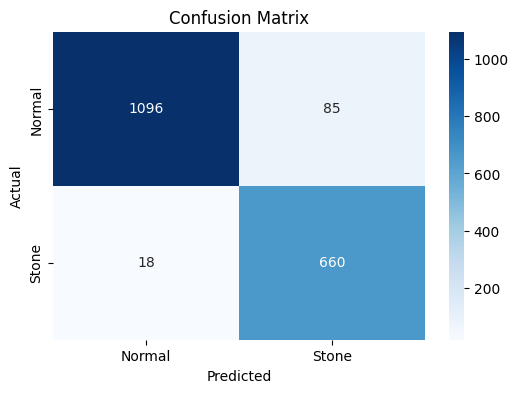

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_test, y_pred_labels)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Stone'], yticklabels=['Normal', 'Stone'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

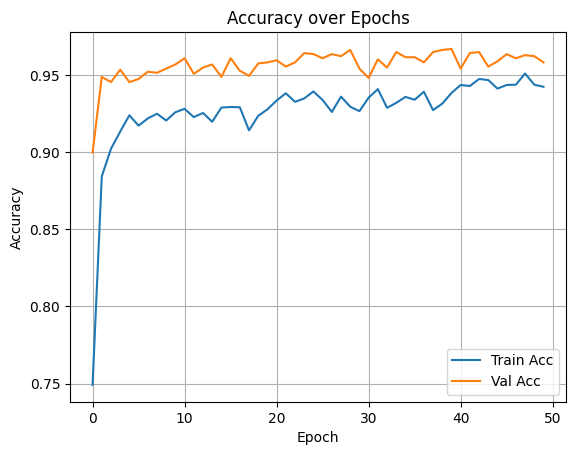

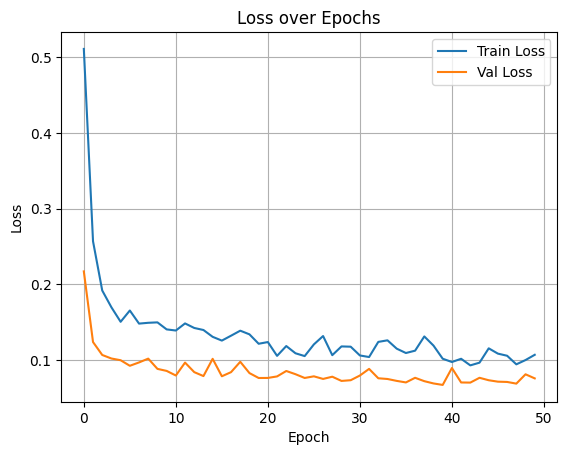

In [54]:
# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [57]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

def preprocess_and_extract(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        raise ValueError(f"Image not found or cannot be opened: {img_path}")

    img = cv2.resize(img, (224, 224))
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.equalizeHist(img)
    img = img / 255.0
    img = (img * 255).astype(np.uint8)

    # Convert to RGB and preprocess
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img_rgb = np.expand_dims(img_rgb, axis=0)
    img_rgb = preprocess_input(img_rgb)

    # ResNet50 with Global Average Pooling
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    model_extract = Model(inputs=base_model.input, outputs=x)

    features = model_extract.predict(img_rgb)
    return features


In [59]:
img_path = '/content/drive/MyDrive/KidneystoneDataset/Normal/Normal- (1).jpg'
features = preprocess_and_extract(img_path)
prediction = model.predict(features)

if prediction[0] > 0.5:
    print("Predicted: Stone")
else:
    print("Predicted: Normal")


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
Predicted: Normal


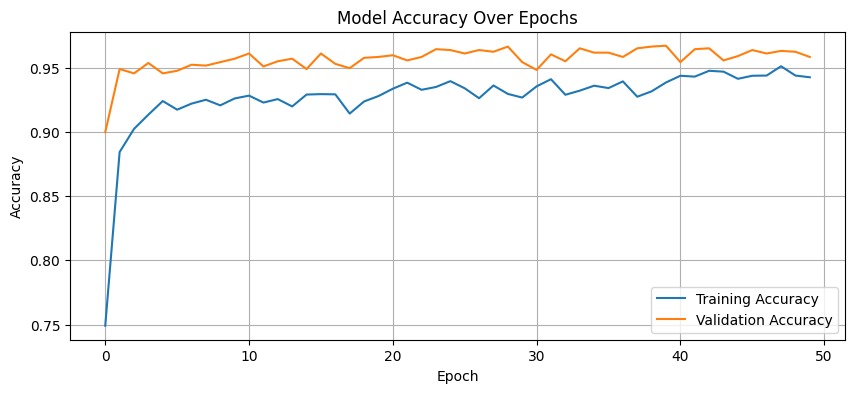

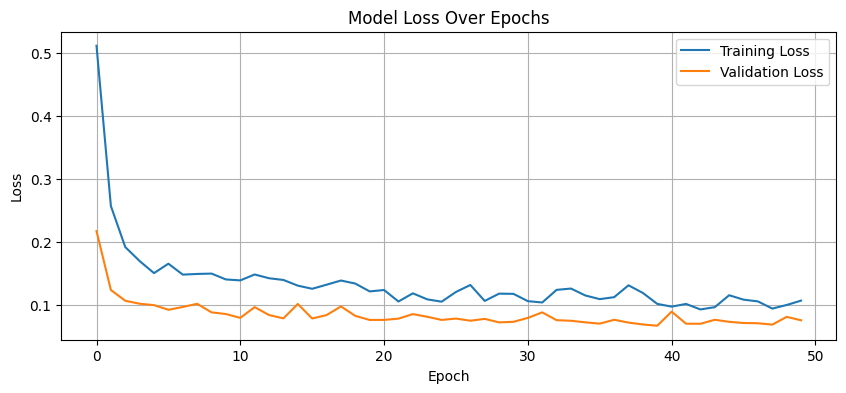

In [60]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
